# **THIS NOTEBOOK CONTAINS THE MODEL USED TO DRAW TRACKS OF HAIL EVENTS USING THE REPORTS**

In [4]:
#importing necessary librairies
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
from datetime import datetime
import statistics 
import math
import matplotlib.image as mpimg

In [5]:
! pip install geopandas
from shapely.geometry import Point
import geopandas as gpd
from geopandas import GeoDataFrame

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 17.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 65.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.6/16.6 MB 60.0 MB/s eta 0:00:00


In [6]:
#install st-dbscan, the librairie used to cluster our data
!pip install st-dbscan
from st_dbscan import ST_DBSCAN

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 414.9/414.9 KB 10.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for st-dbscan: filename=st_dbscan-0.2.2-py2.py3-none-any.whl size=6846 sha256=25edc2ed8f6c1d773d8430adba179626337d5d15b0d40fa12e8d0441f778ccaf
  Stored in directory: /root/.cache/pip/wheels/24/91/29/05225600a7692feed03a950616ef6796185cf266de56f521f0
Successfully built st-dbscan


In [7]:
#import our data frame
df=pd.read_csv(r"/Users/hamzaab/Desktop/cours/2Ak/statap/bdd.csv", low_memory=False)

# **Creating functions needed in our model and for tuning**

In [8]:
#function converting dates into hour stamps (on one year)
def convert_hour(donnee):
    date=donnee['TIME_EVENT']
    dt=datetime.strptime(date,'%Y-%m-%d %H:%M:%S')
    x=float(dt.month)
    y=float(dt.day)
    z=float(dt.hour)
    m=float(dt.minute)
    s=float(dt.second)
    t= (x-1)*365*2 + y*24 + z + m/60 + s/3600
    return t

In [9]:
# fonction returning a list containing clusters needed later for our model
def clust(donnee, classif):
    list1=[]
    n=len(donnee)
    for i in range(len(np.unique(classif))):
        EV=[]
        for j in range(n):
            if classif[j]==np.unique(classif)[i]:
                EV.append(j)
        list1.append(EV)
    return list1

In [10]:
#function needed for tuning and visualization

# function that returns the intersection of two lists
def intersection(E, F) :
    inter=[]
    for val in E:
        if val in F:
            inter.append(val)
    return inter

# function that returns the union of two lists
def reunion (E,F) :
    reu=[]
    for x in E:
        reu.append(x)
    for y in F:
        if not (y in reu):
            reu.append(y)
    return reu

# function that return a list E deprived from another list F
def priv(E,F):
    #pri=[]
    for x in E:
        if x in F:
            #pri.append(x)
            del E[E.index(x)]
    return E

# ** Next is the creation of three functions allowing us to tune the three parameters of our model; epsilon 1 which is the spatial parameter, epsilon 2 the temporal one and min_samples the minimum number of points that have to be close to on epoint for them to be in the same cluster** 

In [ ]:
#funtion runing the model for specified country and year, fixed eps2 and minpts and for many eps1 in an interval [i,j]
def find_right_eps1(country,year,ep2,minpts,i,j):
    
    # extracting needed data
    country=str(country)
    df_clst=df[df['YEAR']==year]
    df_clst=df_clst[df_clst['COUNTRY']==country]
    
    #converting date into hour stamps
    df_clst['TIME_HOUR']=df_clst.apply(lambda donnee: convert_hour(donnee), axis=1)
    
    #maintain columns needed
    df_clst=df_clst.loc[:,['TIME_HOUR','LATITUDE','LONGITUDE']]
    
    #iterate st-dbscan for many epsilon 1
    EP1=[]               #list containing the different epsilon1
    NBR_EVENT=[]         #number of event clustered for each iteration of st-dbscan
    MEAN_LENGTH_EVENT=[] #list containg the mean of the length of the events for each iteration of st-dbscan
    STD_LENGTH_EVENT=[]  #list containg the std of the length of the events for each iteration of st-dbscan
    LENGTH_CLASS_1=[]    #list containg the the length of the trash class (-1) for each iteration of st-dbscan
    reu=[]               #list containing the union of classes -1
    inter=[]             #list containg the intersection of classes -1
    #iterate st-dbscan for eps1 in [i/10,j/10] with a 0.1 step
    for v in range(i,j):
        s=v/10
        # applying st-dbscan
        df_clst1=df_clst.copy() #we copy our dataframe 
        model = ST_DBSCAN(eps1=s, eps2=ep2,min_samples=minpts)
        model.fit(df_clst1)
        df_clst1["cluster"] = model.fit(df_clst)
        classi = model.labels
        # list containing lists of report indexes representing each one an event
        events= clust(df_clst1,classi)
        # column containing labels
        df_clst1["classe"]=classi
        #adding a column containing number of reports per class
        k=df_clst1.groupby(['classe']).count()
        EP1.append(s)
        NBR_EVENT.append(len(k)-1)
        MEAN_LENGTH_EVENT.append(statistics.mean(k['LONGITUDE']))
        STD_LENGTH_EVENT.append(statistics.stdev(k['LONGITUDE']))
        #we fill our two lists reu and inter
        reu=reunion(reu,events[0])
        r=len(events[0])
        LENGTH_CLASS_1.append(r)
        if v==i:
            inter=events[0]
        elif v!=i:
            inter=intersection(inter,events[0])
    # restr is the reunion deprived from the intersection of the classes -1 for each iteration of st-dbscan          
    restr=priv(reu,inter)
    # lat, long and hour are three lists containing the latitude,longitude and time of each 
    # of the reports contained in restr in order to plot them
    lat=[]
    long=[]
    hour=[]
    for e in range(len(df_clst)):
        for f in range(len(restr)):
            if e==restr[f]:
                lat.append(df_clst['LATITUDE'].iloc[e])
                long.append(df_clst['LONGITUDE'].iloc[e])
                hour.append(df_clst['TIME_HOUR'].iloc[e])
    #creating a dataframe containing all the elements we created till now
    df2 = pd.DataFrame(list(zip(EP1,NBR_EVENT,MEAN_LENGTH_EVENT,STD_LENGTH_EVENT,LENGTH_CLASS_1)),columns =['EPS1','NBR_EVENTS','MEAN_LENGTH_EVENTS','STD_LENGTH_EVENTS','LENGTH CLASS -1'])
    print(df2.to_string())
    
    #assign values to variables we'll use to plot results
    x = df2['EPS1']
    y = df2['NBR_EVENTS']
    z = df2['MEAN_LENGTH_EVENTS']
    t = df2['STD_LENGTH_EVENTS']
    h = LENGTH_CLASS_1
  
    # Plotting both the curves simultaneously 
    plt.plot(x, y, color='r', label='NBR OF EVENTS')      #number of events
    plt.plot(x, z, color='g', label='MEAN LENGTH EVENTS') #mean of the length of the events
    plt.plot(x, t, color='b', label='STD LENGTH EVENTS')  #std oft the length of the events
    plt.plot(x, h, color='grey', label= 'number of tracks in class -1')
    plt.xlabel("EP1")
    plt.title("Évènements en " +str(country) + " en " + str(year) + ", eps1=" + str(i/10) + " à " +str((j-1)/10) + ", eps2=" + str(ep2 ) +" et minsamples=" +str(minpts ))
    plt.legend()
    plt.show()
    
    #ploting the classe -1
    x1=min(df_clst['LONGITUDE'])
    x2=max(df_clst['LONGITUDE'])
    y1=min(df_clst['LATITUDE'])
    y2=max(df_clst['LATITUDE'])
    fig = plt.figure(figsize=(10,10))
    ax = plt.subplot(111)
    sc = plt.scatter(long,lat, s = 200, c=hour, cmap=plt.cm.jet)
    cbar = fig.colorbar(sc, orientation='horizontal')
    plt.xlim([x1, x2])
    plt.ylim([y1,y2])
    plt.title("Les rapports contenus dans la réunion des classes -1 pour eps1=" + str(i/10) + " à " +str((j-1)/10) +  " privé de leur intersection")
    plt.show()

In [ ]:
#funtion runing the model for specified country and year, fixed eps1 and minpts and for many eps2 in an interval [i,j]
def find_right_eps2(country,year,ep1,minpts,i,j):
    
    # extracting needed data
    country=str(country)
    df_clst=df[df['YEAR']==year]
    df_clst=df_clst[df_clst['COUNTRY']==country]
    
    #converting date into hour stamps
    df_clst['TIME_HOUR']=df_clst.apply(lambda donnee: convert_hour(donnee), axis=1)
    
    #maintain columns needed
    df_clst=df_clst.loc[:,['TIME_HOUR','LATITUDE','LONGITUDE']]
    
    #iterate st-dbscan for many epsilon 2
    EP2=[]               #list containing the different epsilon2
    NBR_EVENT=[]         #number of event clustered for each iteration of st-dbscan
    MEAN_LENGTH_EVENT=[] #list containg the mean of the length of the events for each iteration of st-dbscan
    STD_LENGTH_EVENT=[]  #list containg the std of the length of the events for each iteration of st-dbscan
    LENGTH_CLASS_1=[]    #list containg the the length of the trash class (-1) for each iteration of st-dbscan
    reu=[]               #list containing the union of classes -1
    inter=[]             #list containg the intersection of classes -1
    #iterate st-dbscan for eps2 in [i,j]
    for v in range(i,j):
        # applying st-dbscan
        df_clst1=df_clst.copy() #we copy our dataframe
        model = ST_DBSCAN(eps1=ep1, eps2=v,min_samples=minpts)
        model.fit(df_clst1)
        df_clst1["cluster"] = model.fit(df_clst)
        classi = model.labels
        # list containing lists of report indexes representing each one an event
        events= clust(df_clst1,classi)
        r=len(events[0])
        LENGTH_CLASS_1.append(r)
        # column containing labels
        df_clst1["classe"]=classi
        #adding a column containing number of reports per class
        k=df_clst1.groupby(['classe']).count()
        EP2.append(v)
        NBR_EVENT.append(len(k)-1)
        MEAN_LENGTH_EVENT.append(statistics.mean(k['LONGITUDE']))
        STD_LENGTH_EVENT.append(statistics.stdev(k['LONGITUDE'])) 
        #we fill our two lists reu and inter
        reu=reunion(reu,events[0])
        if v==i:
            inter=events[0]
        elif v!=i:
            inter=intersection(inter,events[0])
    # restr is the reunion deprived from the intersection of the classes -1 for each iteration of st-dbscan          
    restr=priv(reu,inter)
    # lat, long and hour are three lists containing the latitude,longitude and time of each 
    # of the reports contained in restr in order to plot them
    lat=[]
    long=[]
    hour=[]
    for e in range(len(df_clst)):
        for f in range(len(restr)):
            if e==restr[f]:
                r=df_clst['LATITUDE'].iloc[e]
                s=df_clst['LONGITUDE'].iloc[e]
                lat.append(df_clst['LATITUDE'].iloc[e])
                long.append(df_clst['LONGITUDE'].iloc[e])
                hour.append(df_clst['TIME_HOUR'].iloc[e])
    #creating a dataframe containing all the elements we created till now
    df2 = pd.DataFrame(list(zip(EP2,NBR_EVENT,MEAN_LENGTH_EVENT,STD_LENGTH_EVENT,LENGTH_CLASS_1)),columns =['EPS2','NBR_EVENTS','MEAN_LENGTH_EVENTS','STD_LENGTH_EVENTS','LENGTH CLASS -1'])
    print(df2.to_string())
    
    #assign values to variables we'll use to plot results
    x = df2['EPS2']
    y = df2['NBR_EVENTS']
    z = df2['MEAN_LENGTH_EVENTS']
    t = df2['STD_LENGTH_EVENTS']
    h = LENGTH_CLASS_1

    
    # Plotting both the curves simultaneously
    plt.plot(x, y, color='r', label='NBR OF EVENTS')      #number of events
    plt.plot(x, z, color='g', label='MEAN LENGTH EVENTS') #mean of the length of the events
    plt.plot(x, t, color='b', label='STD LENGTH EVENTS')  #std oft the length of the events
    plt.plot(x, h, color='grey', label= 'number of tracks in class -1')
    plt.xlabel("EPS2")
    plt.title("Évènements en " +str(country) + " en " + str(year) + ", eps1=" + str(ep1) + ", eps2=" + str(i) + " à " +str(j-1) +" et minsamples=" +str(minpts ))
    plt.legend()
    plt.show()
    
    #ploting the classe -1
    x1=min(df_clst['LONGITUDE'])
    x2=max(df_clst['LONGITUDE'])
    y1=min(df_clst['LATITUDE'])
    y2=max(df_clst['LATITUDE'])
    fig = plt.figure(figsize=(10,10))
    ax = plt.subplot(111)
    sc = plt.scatter(long,lat, s = 200, c=hour, cmap=plt.cm.jet)
    cbar = fig.colorbar(sc, orientation='horizontal')
    plt.xlim([x1, x2])
    plt.ylim([y1,y2])
    plt.title("Les rapports contenus dans la réunion des classes -1 pour eps2=" + str(i) + " à " +str(j-1) +  " privé de leur intersection")
    plt.show()

In [ ]:
#funtion runing the model for specified country and year, fixed eps1 and eps2 and for many min_samples in an interval [i,j]
def find_right_minPts(country,year,ep1,ep2,i,j):    
    
    # extracting needed data
    country=str(country)
    df_clst=df[df['YEAR']==year]
    df_clst=df_clst[df_clst['COUNTRY']==country]
    
    #converting date into hour stamps
    df_clst['TIME_HOUR']=df_clst.apply(lambda donnee: convert_hour(donnee), axis=1)
    
    #maintain columns needed
    df_clst=df_clst.loc[:,['TIME_HOUR','LATITUDE','LONGITUDE']]
    
    #iterate st-dbscan for many min_samples    
    MINPT=[]             #list containing the different min_samples
    NBR_EVENT=[]         #number of event clustered for each iteration of st-dbscan
    MEAN_LENGTH_EVENT=[] #list containg the mean of the length of the events for each iteration of st-dbscan
    STD_LENGTH_EVENT=[]  #list containg the std of the length of the events for each iteration of st-dbscan
    LENGTH_CLASS_1=[]    #list containg the the length of the trash class (-1) for each iteration of st-dbscan
    reu=[]               #list containing the union of classes -1
    inter=[]             #list containg the intersection of classes -1
    #iterate st-dbscan for min_samples in [i,j]
    for v in range(i,j):
        # applying st-dbscan
        df_clst1=df_clst.copy()
        model = ST_DBSCAN(eps1=ep1, eps2=ep2,min_samples=v)
        model.fit(df_clst1)
        df_clst1["cluster"] = model.fit(df_clst)
        classi = model.labels
        # list containing lists of report indexes correponding each one to an event
        events= clust(df_clst1,classi)
        r=len(events[0])
        LENGTH_CLASS_1.append(r)
        # column containing labels
        df_clst1["classe"]=classi
        #adding a column containing number of reports per class
        k=df_clst1.groupby(['classe']).count()
        MINPT.append(v)
        NBR_EVENT.append(len(k)-1)
        MEAN_LENGTH_EVENT.append(statistics.mean(k['LONGITUDE']))
        STD_LENGTH_EVENT.append(statistics.stdev(k['LONGITUDE'])) 
        #we fill our two lists reu and inter
        reu=reunion(reu,events[0])
        if v==i:
            inter=events[0]
        elif v!=i:
            inter=intersection(inter,events[0])
    # restr is the reunion deprived from the intersection of the classes -1 for each iteration of st-dbscan          
    restr=priv(reu,inter)
    # lat, long and hour are three lists containing the latitude,longitude and time of each 
    # of the reports contained in restr in order to plot them
    lat=[]
    long=[]
    hour=[]
    for e in range(len(df_clst)):
        for f in range(len(restr)):
            if e==restr[f]:
                lat.append(df_clst['LATITUDE'].iloc[e])
                long.append(df_clst['LONGITUDE'].iloc[e])
                hour.append(df_clst['TIME_HOUR'].iloc[e])
    #creating a dataframe containing all the elements we created till now 
    df2 = pd.DataFrame(list(zip(MINPT,NBR_EVENT,MEAN_LENGTH_EVENT,STD_LENGTH_EVENT,LENGTH_CLASS_1)),columns =['MINPT','NBR_EVENTS','MEAN_LENGTH_EVENTS','STD_LENGTH_EVENTS','LENGTH CLASS -1'])
    print(df2.to_string())
    
    #assign values to variables we'll use to plot results
    x = df2['MINPT']
    y = df2['NBR_EVENTS']
    z = df2['MEAN_LENGTH_EVENTS']
    t = df2['STD_LENGTH_EVENTS']
    h = LENGTH_CLASS_1

    
    # Plotting both the curves simultaneously
    plt.plot(x, y, color='r', label='NBR OF EVENTS')      #number of events
    plt.plot(x, z, color='g', label='MEAN LENGTH EVENTS') #mean of the length of the events
    plt.plot(x, t, color='b', label='STD LENGTH EVENTS')  #std oft the length of the events
    plt.plot(x, h, color='grey', label= 'number of tracks in class -1')
    plt.xlabel("MIN_SAMPLES")
    plt.title("Évènements en " +str(country) + " en " + str(year) + ", eps1=" + str(ep1) + ", eps2=" + str(ep2) +" et minsamples=" + str(i) + " à " +str(j-1))
    plt.legend()
    plt.show()
    
    #ploting the classe -1
    x1=min(df_clst['LONGITUDE'])
    x2=max(df_clst['LONGITUDE'])
    y1=min(df_clst['LATITUDE'])
    y2=max(df_clst['LATITUDE'])
    fig = plt.figure(figsize=(10,10))
    ax = plt.subplot(111)
    sc = plt.scatter(long,lat, s = 200, c=hour, cmap=plt.cm.jet)
    cbar = fig.colorbar(sc, orientation='horizontal')
    plt.xlim([x1, x2])
    plt.ylim([y1,y2])
    plt.title("Les rapports contenus dans la réunion des classes -1 pour minsamples=" + str(i) + " à " +str(j-1) +  " privé de leur intersection")
    plt.show()

# **WE APPLY OUR THREE TUNING FUNCTIONS FOR FRANCE AND POLAND**

    EPS1  NBR_EVENTS  MEAN_LENGTH_EVENTS  STD_LENGTH_EVENTS  LENGTH CLASS -1
0    0.1          50           20.941176          48.590292              186
1    0.2          36           28.864865          63.045470              145
2    0.3          37           28.105263          80.254255              114
3    0.4          37           28.105263          79.820335               95
4    0.5          36           28.864865          99.108011               84
5    0.6          34           30.514286         101.689947               79
6    0.7          32           32.363636         104.528949               71
7    0.8          35           29.666667         100.216623               59
8    0.9          35           29.666667         100.143896               52
9    1.0          35           29.666667         100.124209               44
10   1.1          34           30.514286         101.798062               40


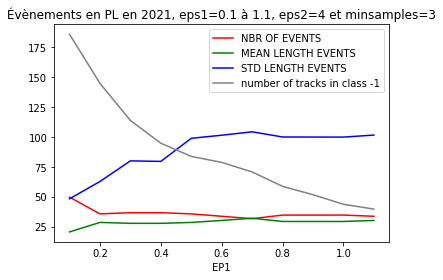

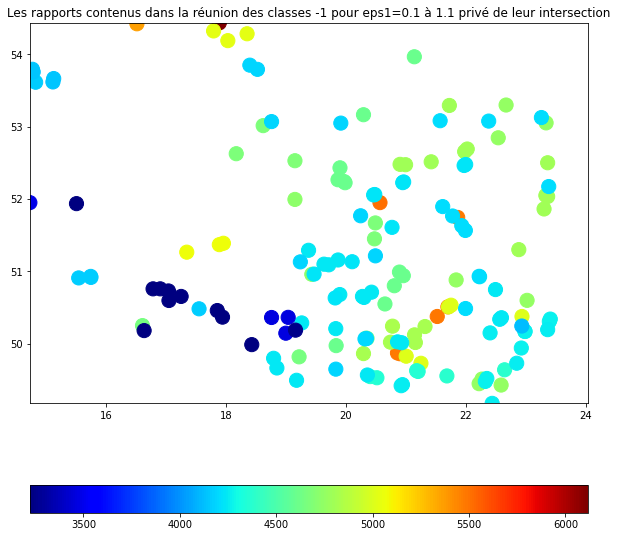

In [ ]:
x="PL"
find_right_eps1(x,2021,4,3,1,12)

    EPS2  NBR_EVENTS  MEAN_LENGTH_EVENTS  STD_LENGTH_EVENTS  LENGTH CLASS -1
0      1          39           10.025000          15.756948               88
1      2          38           10.282051          14.878364               79
2      3          36           10.837838          15.047173               78
3      4          36           10.837838          15.047173               78
4      5          36           10.837838          15.047173               78
5      6          36           10.837838          14.915528               77
6      7          36           10.837838          14.915528               77
7      8          36           10.837838          14.915528               77
8      9          36           10.837838          14.915528               77
9     10          36           10.837838          14.915528               77
10    11          36           10.837838          14.915528               77
11    12          36           10.837838          14.915528               77

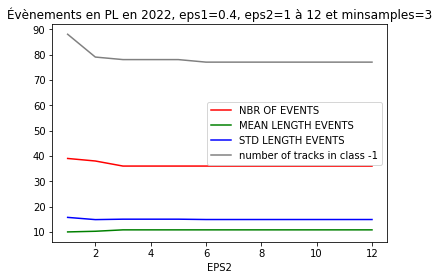

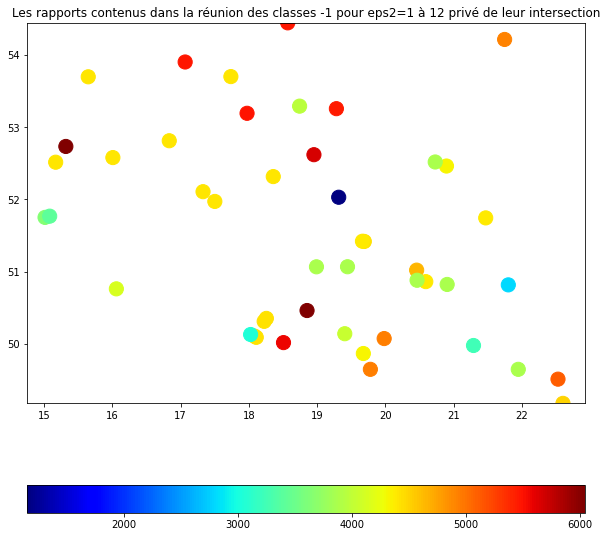

In [ ]:
x="PL"
find_right_eps2(x,2022,0.4,3,1,13)

   MINPT  NBR_EVENTS  MEAN_LENGTH_EVENTS  STD_LENGTH_EVENTS  LENGTH CLASS -1
0      1          99            4.010000           7.043150                1
1      2          50            7.862745          10.785211               50
2      3          36           10.837838          15.047173               78
3      4          31           12.531250          17.953316               93
4      5          23           16.708333          26.635183              130
5      6          15           25.062500          40.900642              171
6      7          12           30.846154          51.629846              197


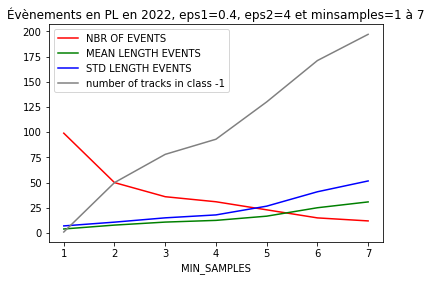

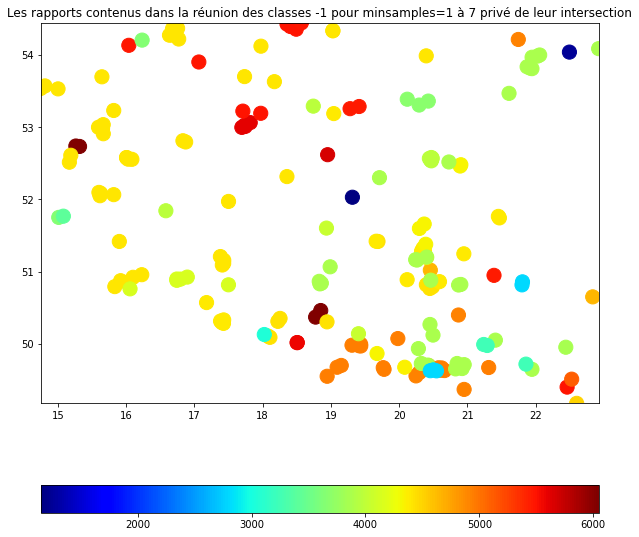

In [ ]:
x="PL"
find_right_minPts(x,2022,0.4,4,1,8)

    EPS1  NBR_EVENTS  MEAN_LENGTH_EVENTS  STD_LENGTH_EVENTS  LENGTH CLASS -1
0    0.1         136           14.452555          35.903255              376
1    0.2         104           18.857143          34.671932              249
2    0.3          88           22.247191          37.189710              189
3    0.4          84           23.294118          42.007602              156
4    0.5          83           23.571429          41.799373              124
5    0.6          78           25.063291          42.976542              112
6    0.7          73           26.756757          44.446308              104
7    0.8          72           27.123288          44.780311               93
8    0.9          68           28.695652          45.931312               84
9    1.0          66           29.552239          46.322415               81
10   1.1          62           31.428571          47.724584               77


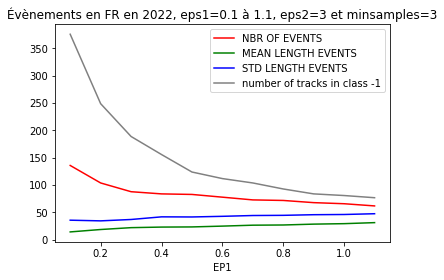

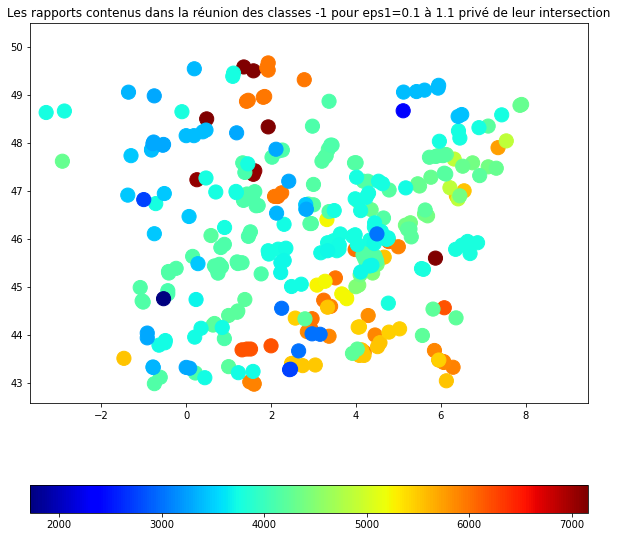

In [ ]:
x="FR"
find_right_eps1(x,2022,3,3,1,12)

    EPS2  NBR_EVENTS  MEAN_LENGTH_EVENTS  STD_LENGTH_EVENTS  LENGTH CLASS -1
0      1          97           20.204082          34.124381              212
1      2          89           22.000000          37.089930              192
2      3          88           22.247191          37.189710              189
3      4          88           22.247191          37.148131              185
4      5          88           22.247191          37.148131              185
5      6          88           22.247191          37.148131              185
6      7          89           22.000000          36.847088              182
7      8          89           22.000000          36.793075              181
8      9          89           22.000000          36.793075              181
9     10          89           22.000000          36.793075              181
10    11          88           22.247191          36.983191              181
11    12          88           22.247191          36.983191              181

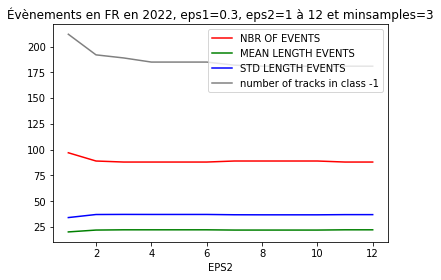

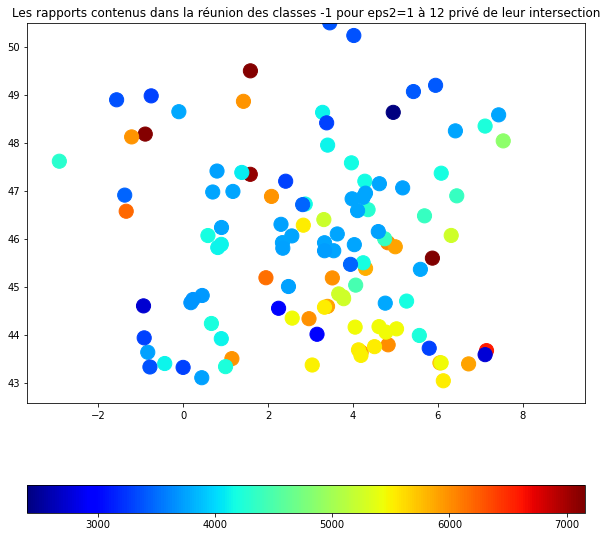

In [ ]:
x="FR"
find_right_eps2(x,2022,0.3,3,1,13)

   MINPT  NBR_EVENTS  MEAN_LENGTH_EVENTS  STD_LENGTH_EVENTS  LENGTH CLASS -1
0      1         228            8.646288          22.282511                2
1      2         136           14.452555          28.473923               93
2      3          88           22.247191          37.189710              189
3      4          74           26.400000          42.205738              233
4      5          61           31.935484          49.545432              289
5      6          56           34.736842          54.403757              325
6      7          50           38.823529          61.538510              373


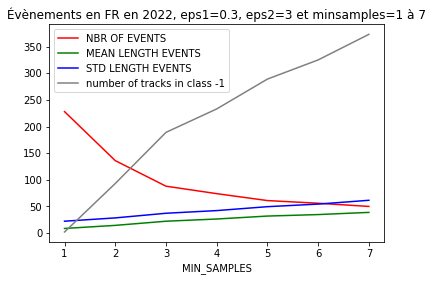

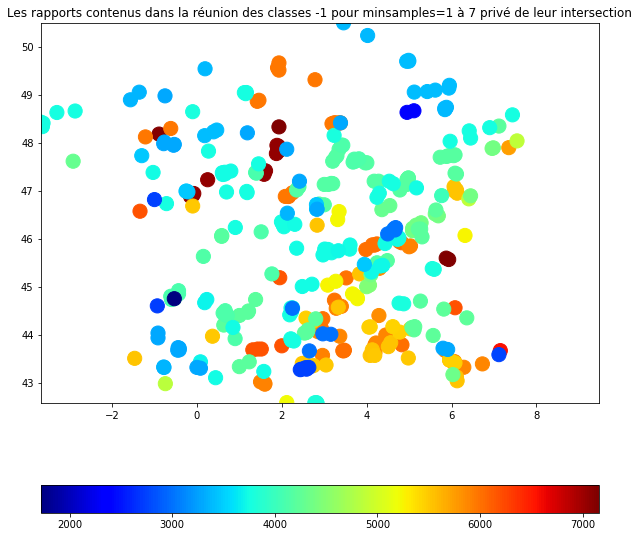

In [ ]:
x="FR"
find_right_minPts(x,2022,0.3,3,1,8)

# **After tuning:**
# **eps1={0.3,0.4}**
# **eps2={1,2}**
# **min_samples={2,3}**

# **Creating function allowing us to automate clustering**

In [ ]:
# function taking into parameters country, year, eps1, eps2 and min_samples and plot the biggest events 
# (events with largest number of reports)

def clusterise_country_year(country, year, ep1, ep2, minpts):
    
    # extracting needed data 
    country=str(country)
    df_clst=df[df['YEAR']==year]
    df_clst=df_clst[df_clst['COUNTRY']==country]
    #connverting time into hour stamps
    df_clst['TIME_HOUR']=df_clst.apply(lambda donnee: convert_hour(donnee), axis=1)
    #maintaining only needed columns
    df_clst=df_clst.loc[:,['TIME_HOUR','LATITUDE','LONGITUDE']]
    # applying st-dbscan
    df_clst1=df_clst.copy()
    model = ST_DBSCAN(eps1=ep1, eps2=ep2,min_samples=minpts)
    model.fit(df_clst1)
    df_clst1["cluster"] = model.fit(df_clst)
    classi = model.labels
    #column containing labels
    df_clst1["classe"]=classi
    #adding a column containg the numbers of reports per class  
    k=df_clst1.groupby(['classe']).count()
    l=[]
    for i in range(len(df_clst1)):
    
        for j in range(len(k)):
            if df_clst1.iloc[i]['classe']==j-1:
                l.append(k['LONGITUDE'][df_clst1.iloc[i]['classe']])
    df_clst1['LENGTH_EVENT']=l
    
    #deleting reports contained in the trash class (-1)
    df_clst1=df_clst1[(df_clst1["classe"]>-1)]
    events= clust(df_clst1,classi)    
    #array containing the lengths of the events in order to pick the largest one only
    b=df_clst1['LENGTH_EVENT'].unique()
    b=sorted(b,reverse=True)
    d=b[0]+1
    c=b[5]-1
    #we keep the longest tracks only
    df_clst1=df_clst1[(df_clst1['LENGTH_EVENT']>c)&(df_clst1['LENGTH_EVENT']<d)]
    k=k[(k['LATITUDE']>c)&(k['LATITUDE']<d)]
    print(k.to_string())

    #ploting our tracks 
    geometry = [Point(xy) for xy in zip(df_clst1['LONGITUDE'], df_clst1['LATITUDE'])]
    gdf = GeoDataFrame(df_clst1, geometry=geometry)      
    ax = gdf.plot(figsize=(30,25), color="gray")
    
    df_clst1.plot.scatter(ax=ax, x = "LONGITUDE", y = "LATITUDE", c = "classe", marker='^', cmap = "tab20")
    plt.title("Évènements en " +str(country) + " en " + str(year) + ", eps1=" + str(ep1 ) + ", eps2=" + str(ep2 ) +" et minsamples=" +str(minpts ))
    plt.xlabel("Longitude")
    plt.ylabel("Latitude")
    plt.show()

        TIME_HOUR  LATITUDE  LONGITUDE  cluster
classe                                         
6              54        54         54       54
16             10        10         10       10
18             19        19         19       19
20             19        19         19       19
23             29        29         29       29
24             11        11         11       11
27             22        22         22       22
37             10        10         10       10


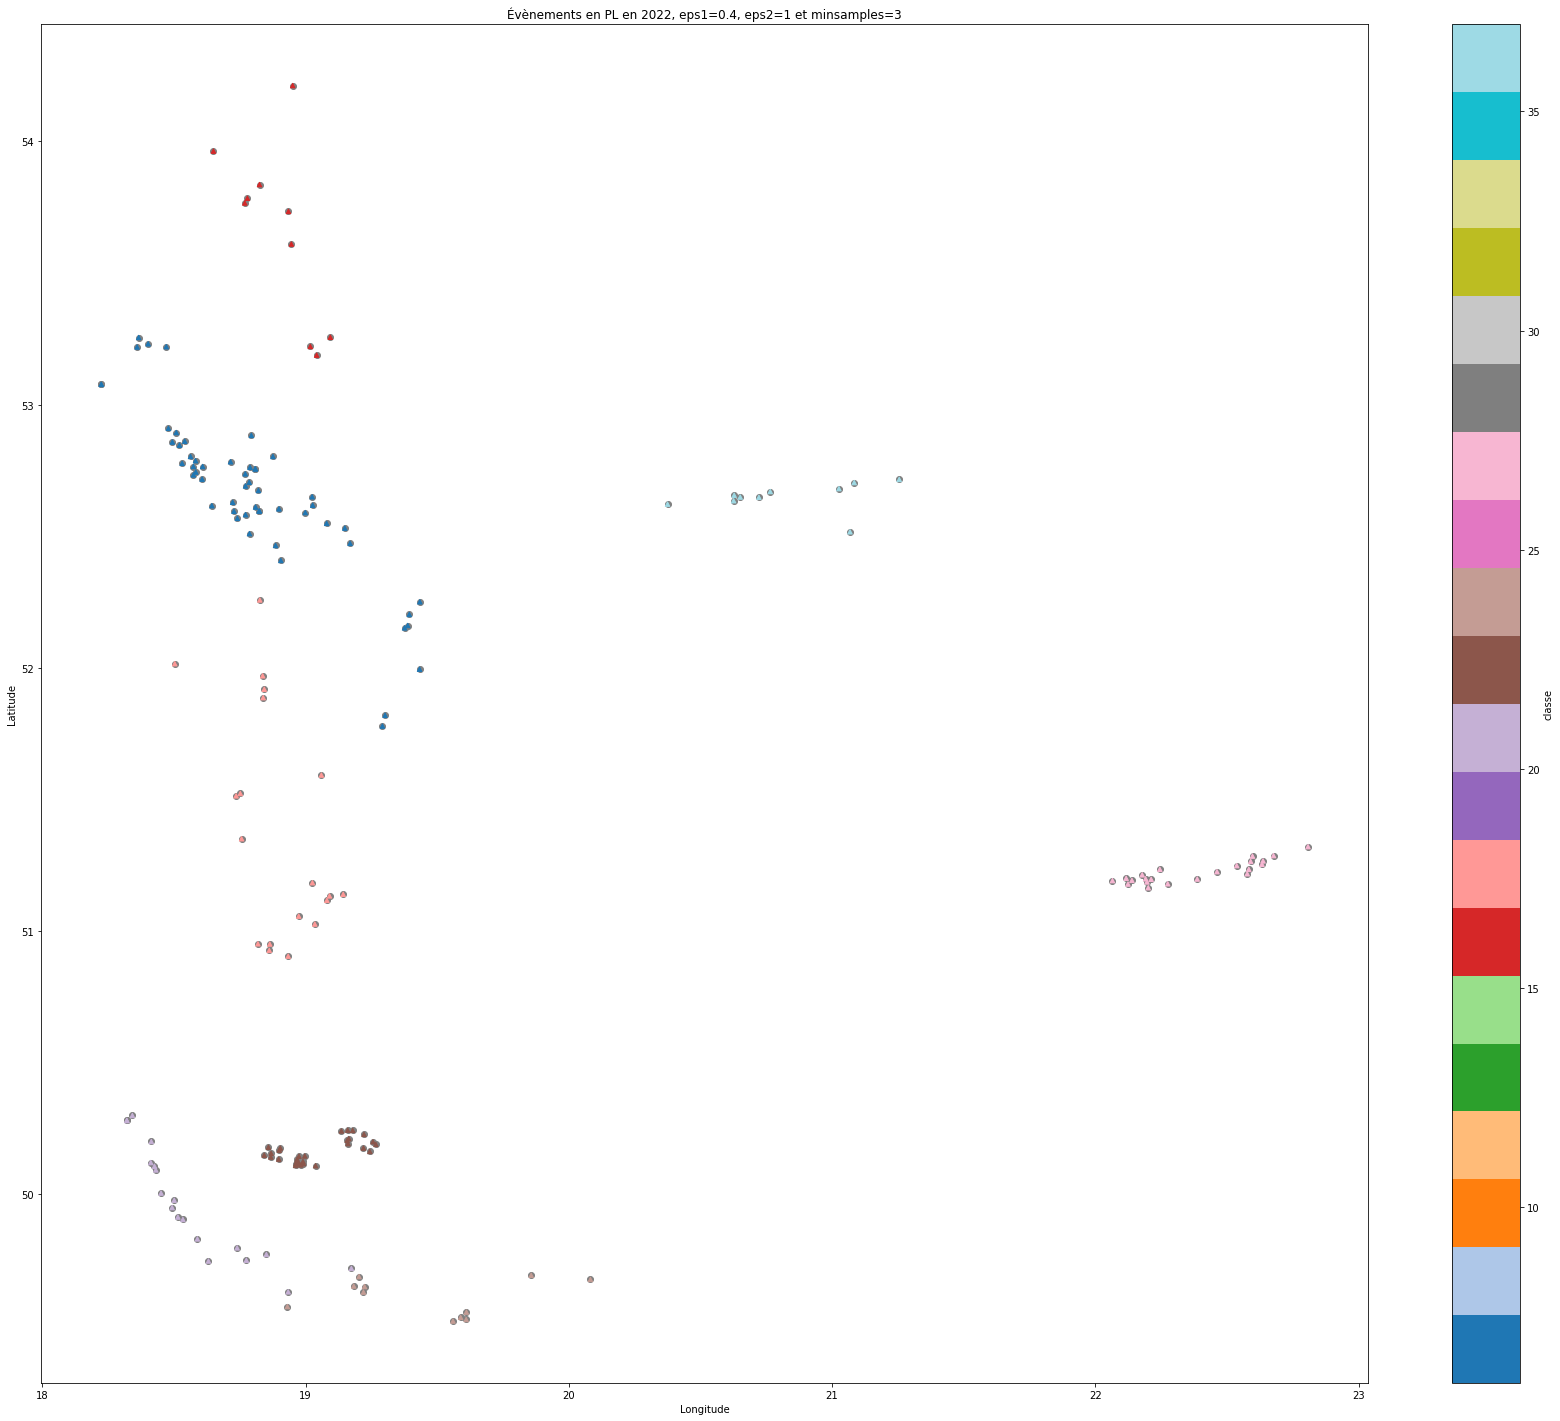

In [ ]:
# plot the results of clustering for Poland in 2022
x="PL"
clusterise_country_year(x, 2022, 0.4, 1, 3)

        TIME_HOUR  LATITUDE  LONGITUDE  cluster
classe                                         
29            110       110        110      110
30            134       134        134      134
46            113       113        113      113
48            105       105        105      105
56            184       184        184      184
73            118       118        118      118


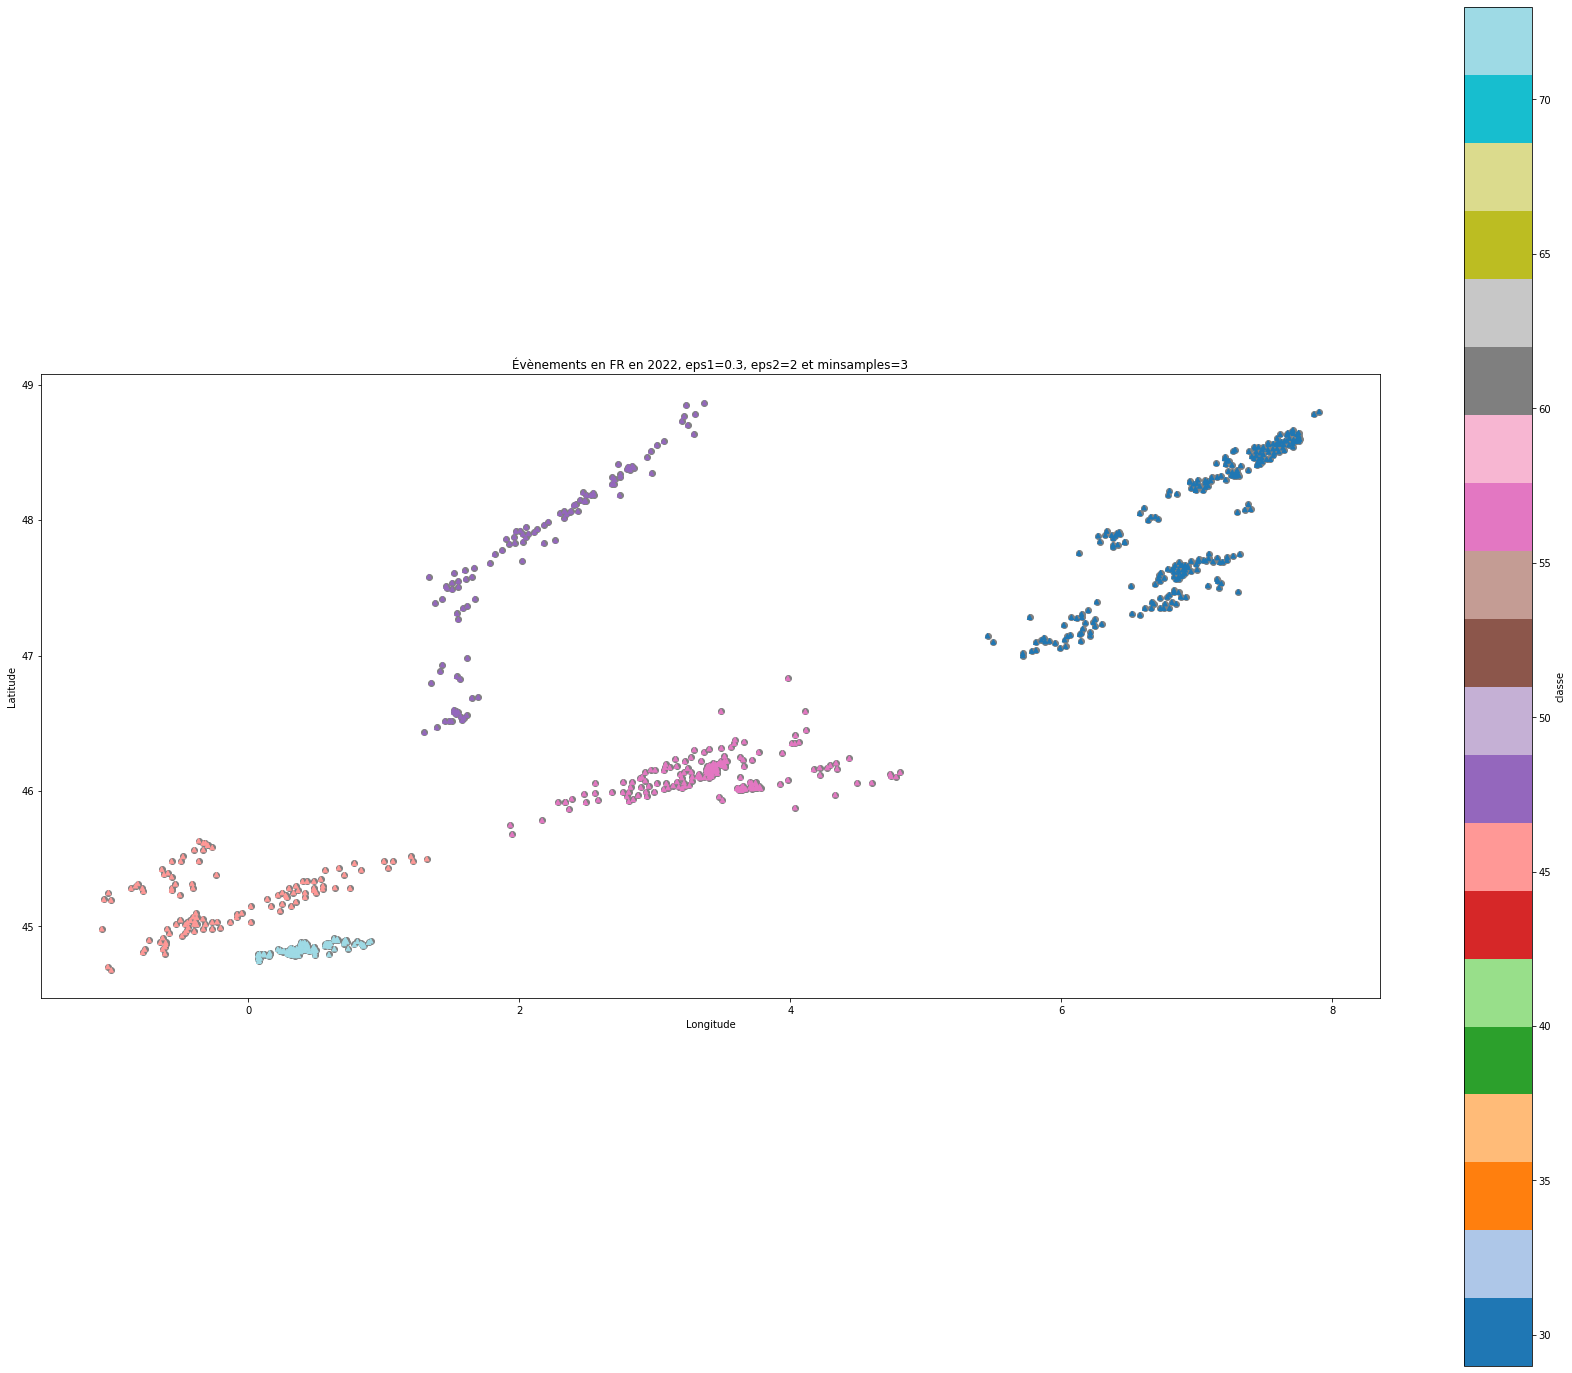

In [ ]:
# plot the results of clustering for France in 2022
x="FR"
clusterise_country_year(x, 2022, 0.3, 2, 3)

In [ ]:
#defining a function taking into parameter the country, year, eps1, eps2, min_samples and the n the position 
#of the track to plot adding an intensity bar corresponding to the time of the reports

def stdbscan_time_intensity(country, year, ep1, ep2, minpts, n):
    # extracting needed data 
    country=str(country)
    df_clst=df[df['YEAR']==year]
    df_clst=df_clst[df_clst['COUNTRY']==country]
    #connverting time into hour stamps
    df_clst['TIME_HOUR']=df_clst.apply(lambda donnee: convert_hour(donnee), axis=1)
    #maintaining only needed columns
    df_clst=df_clst.loc[:,['TIME_HOUR','LATITUDE','LONGITUDE']]
    # applying st-dbscan
    df_clst1=df_clst.copy()
    model = ST_DBSCAN(eps1=ep1, eps2=ep2,min_samples=minpts)
    model.fit(df_clst1)
    df_clst1["cluster"] = model.fit(df_clst)
    classi = model.labels
    #column containing labels
    df_clst1["classe"]=classi
    #adding a column containg the numbers of reports per class  
    k=df_clst1.groupby(['classe']).count()
    l=[]
    for i in range(len(df_clst1)):
    
        for j in range(len(k)):
            if df_clst1.iloc[i]['classe']==j-1:
                l.append(k['LONGITUDE'][df_clst1.iloc[i]['classe']])
    df_clst1['LENGTH_EVENT']=l
    
    #deleting reports contained in the trash class (-1)
    df_clst1=df_clst1[(df_clst1["classe"]>-1)]
    events= clust(df_clst1,classi)
    #we plot the n-th longest track 
    b=df_clst1['LENGTH_EVENT'].unique()
    b=sorted(b,reverse=True)
    d=b[n]+1
    c=b[n+1]
    df_clst1=df_clst1[(df_clst1['LENGTH_EVENT']>c)&(df_clst1['LENGTH_EVENT']<d)]
    k=k[(k['LATITUDE']>c)&(k['LATITUDE']<d)]
    print(k.to_string())

    #plot
    geometry = [Point(xy) for xy in zip(df_clst1['LONGITUDE'], df_clst1['LATITUDE'])]
    gdf = GeoDataFrame(df_clst1, geometry=geometry)      
    ax = gdf.plot(figsize=(30,25), color="gray")
    df_clst1.plot.scatter(ax=ax, x = "LONGITUDE", y = "LATITUDE",s = 200, c = "TIME_HOUR", cmap = plt.cm.jet)
    plt.title("Évènements en " +str(country) + " en " + str(year) + ", eps1=" + str(ep1 ) + ", eps2=" + str(ep2 ) +" et minsamples=" +str(minpts ))
    plt.xlabel("Longitude")
    plt.ylabel("Latitude")
    plt.show()
    

        TIME_HOUR  LATITUDE  LONGITUDE  cluster
classe                                         
56            184       184        184      184


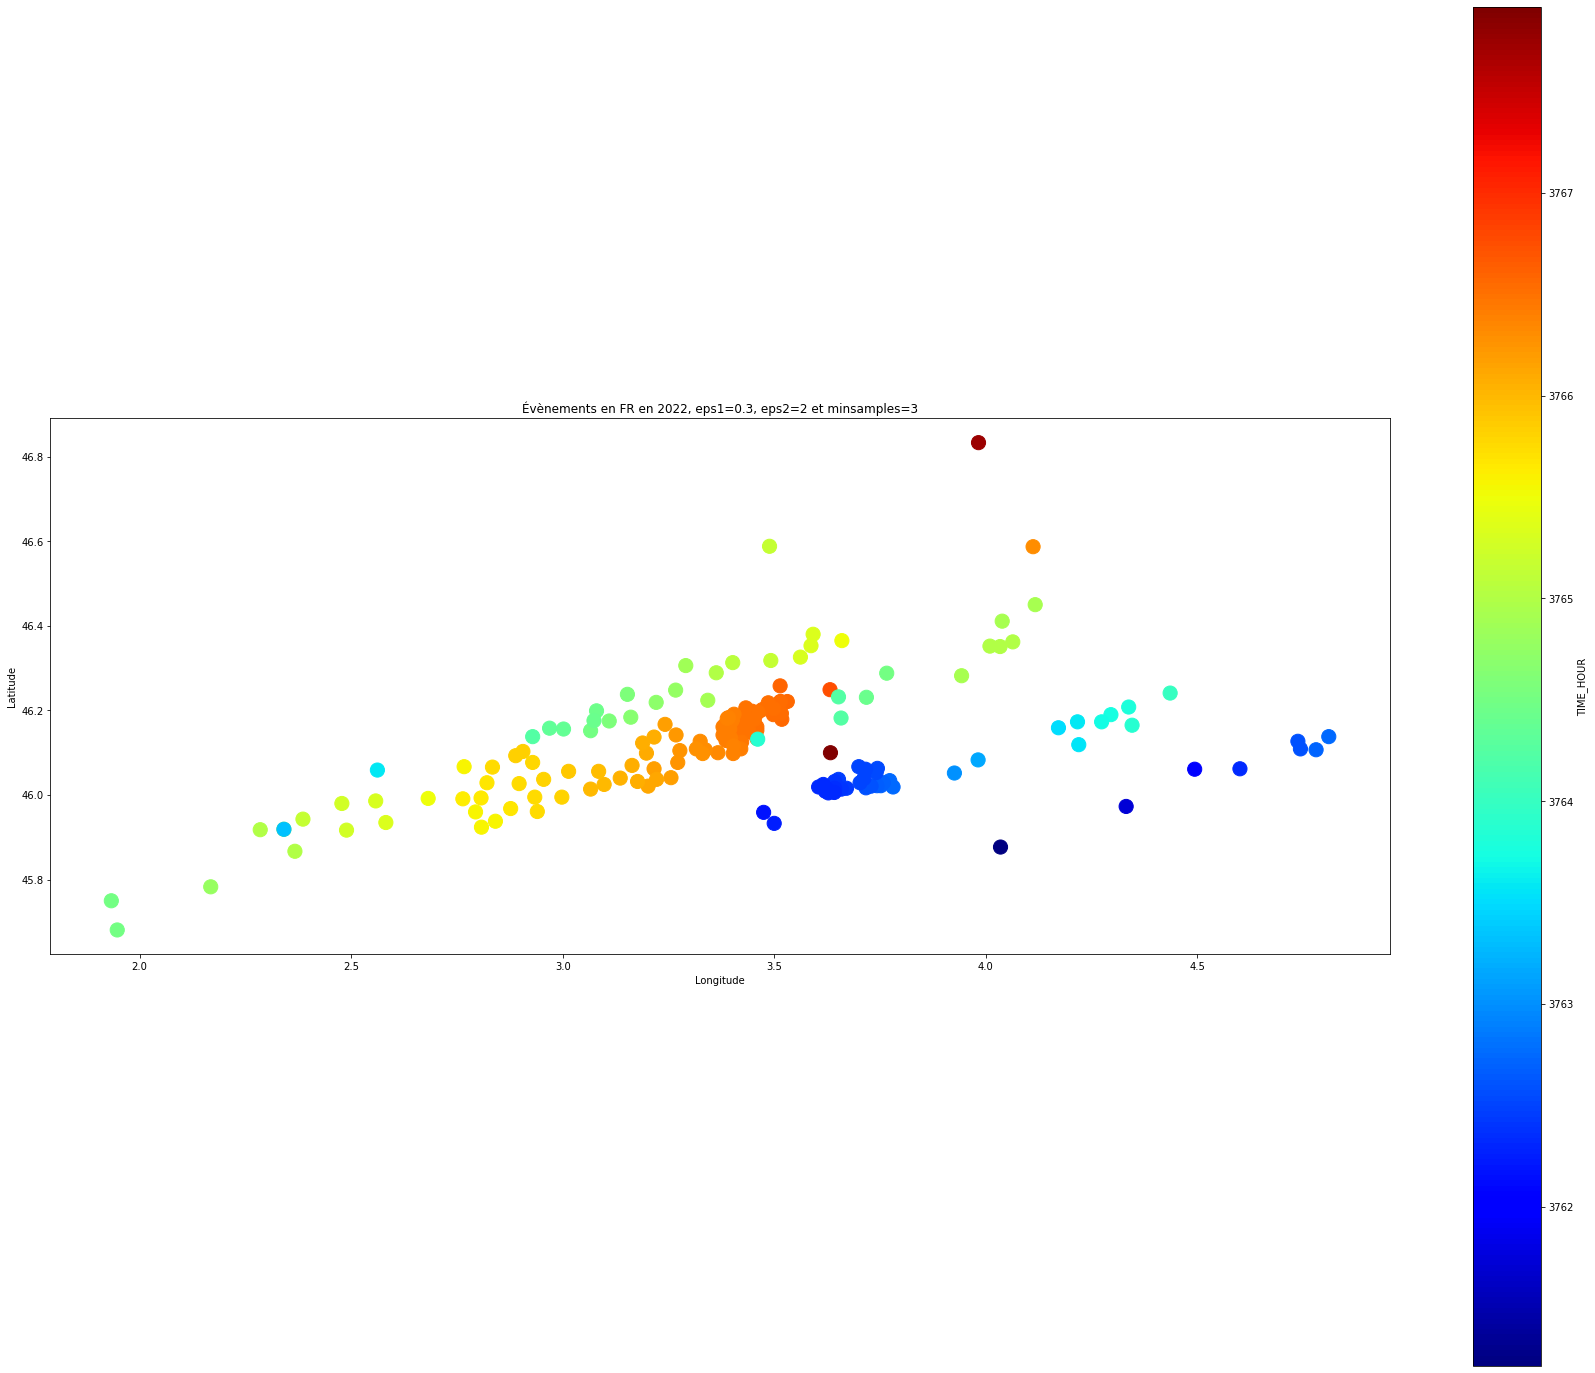

        TIME_HOUR  LATITUDE  LONGITUDE  cluster
classe                                         
30            134       134        134      134


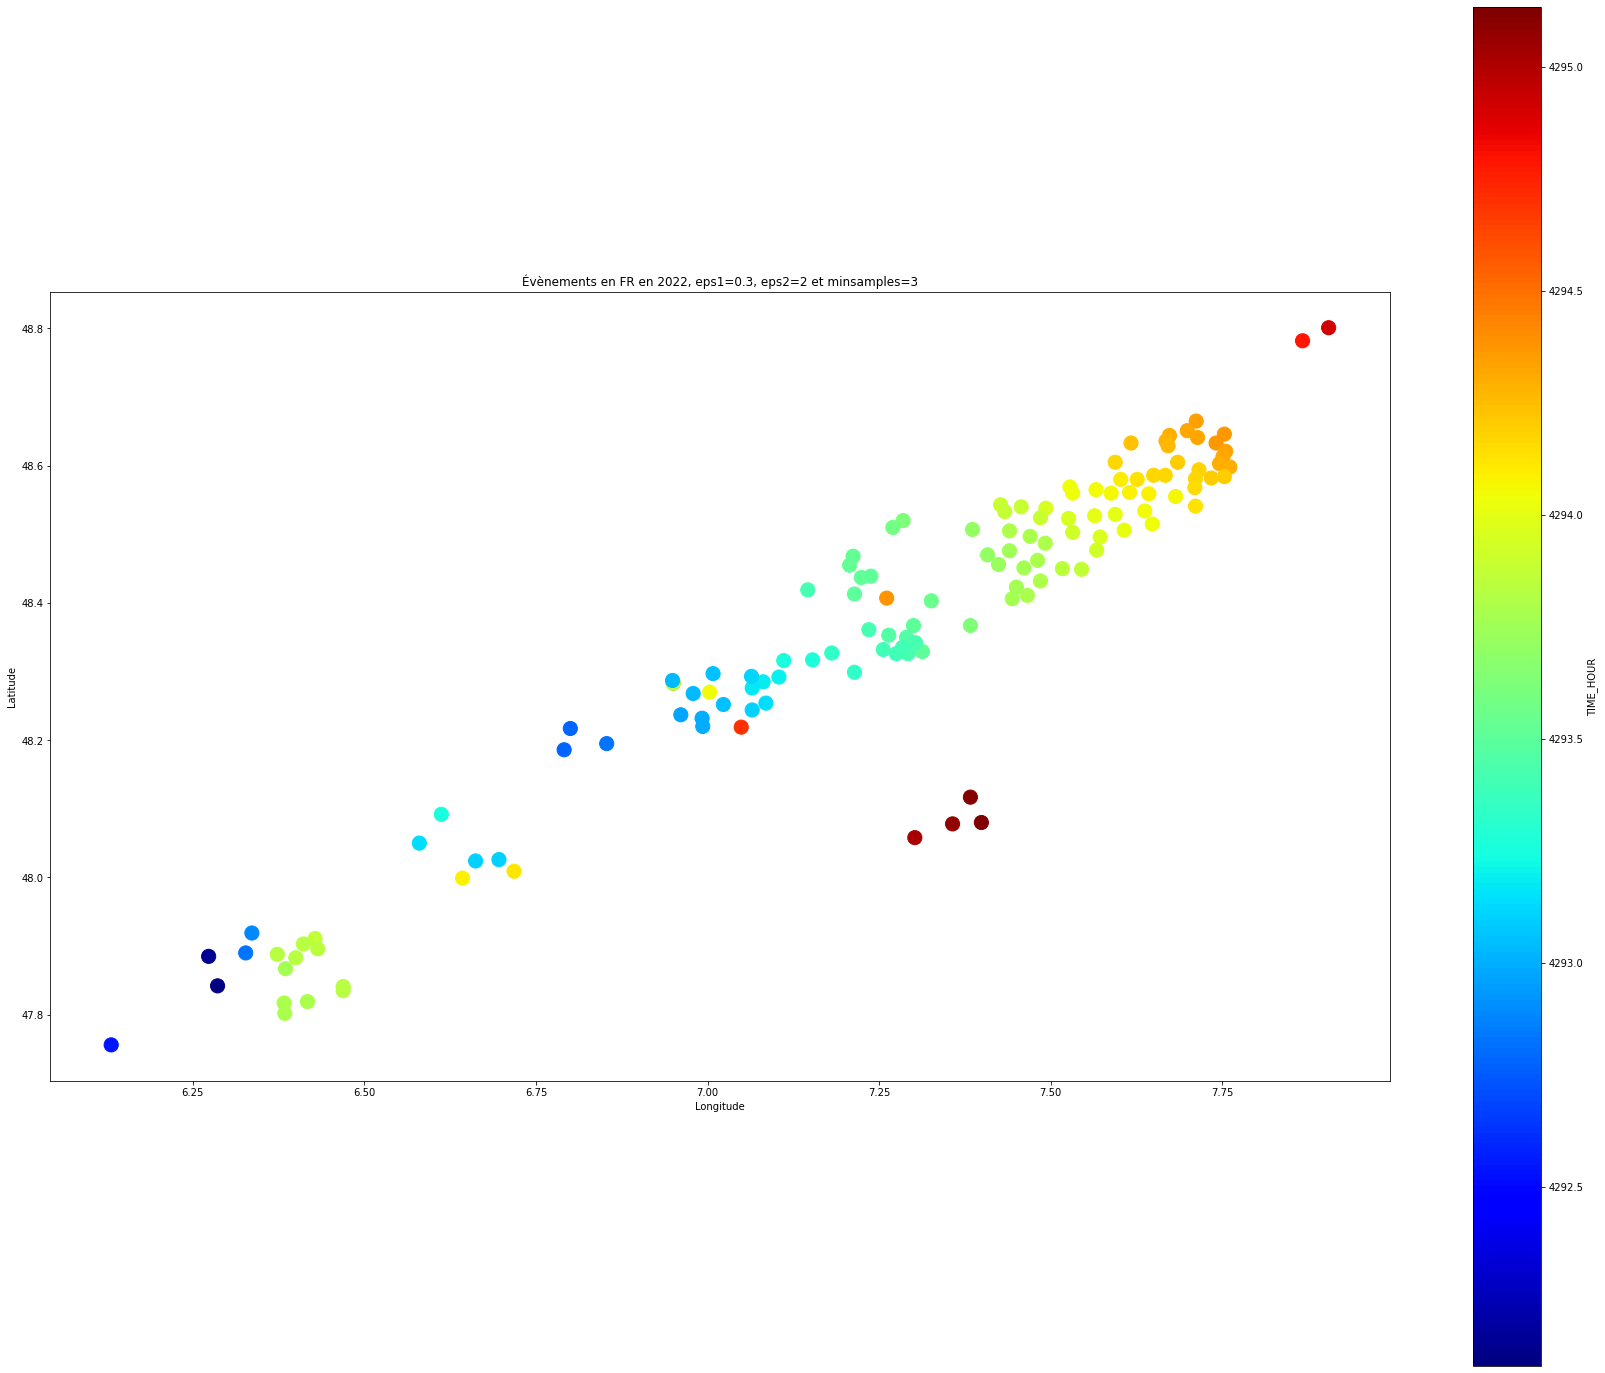

        TIME_HOUR  LATITUDE  LONGITUDE  cluster
classe                                         
73            118       118        118      118


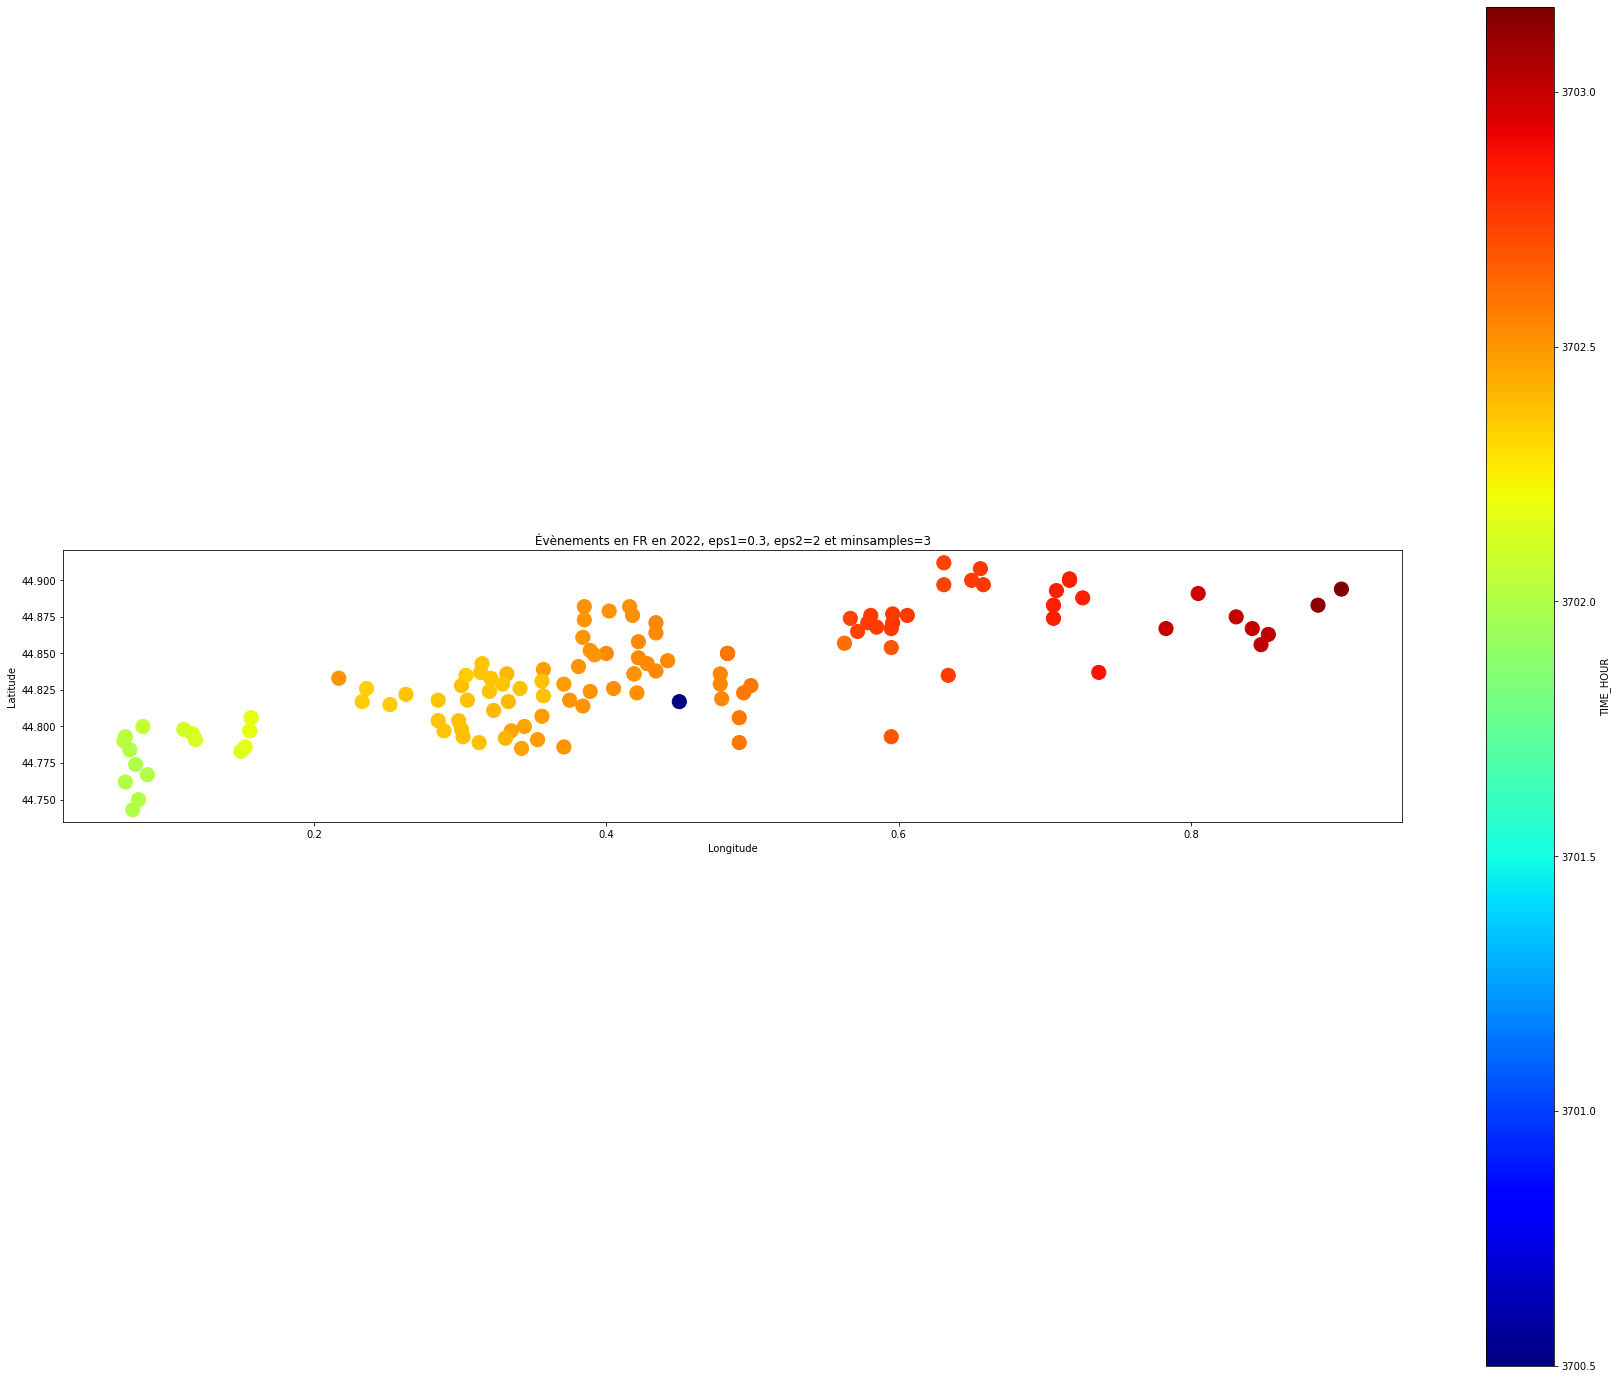

        TIME_HOUR  LATITUDE  LONGITUDE  cluster
classe                                         
46            113       113        113      113


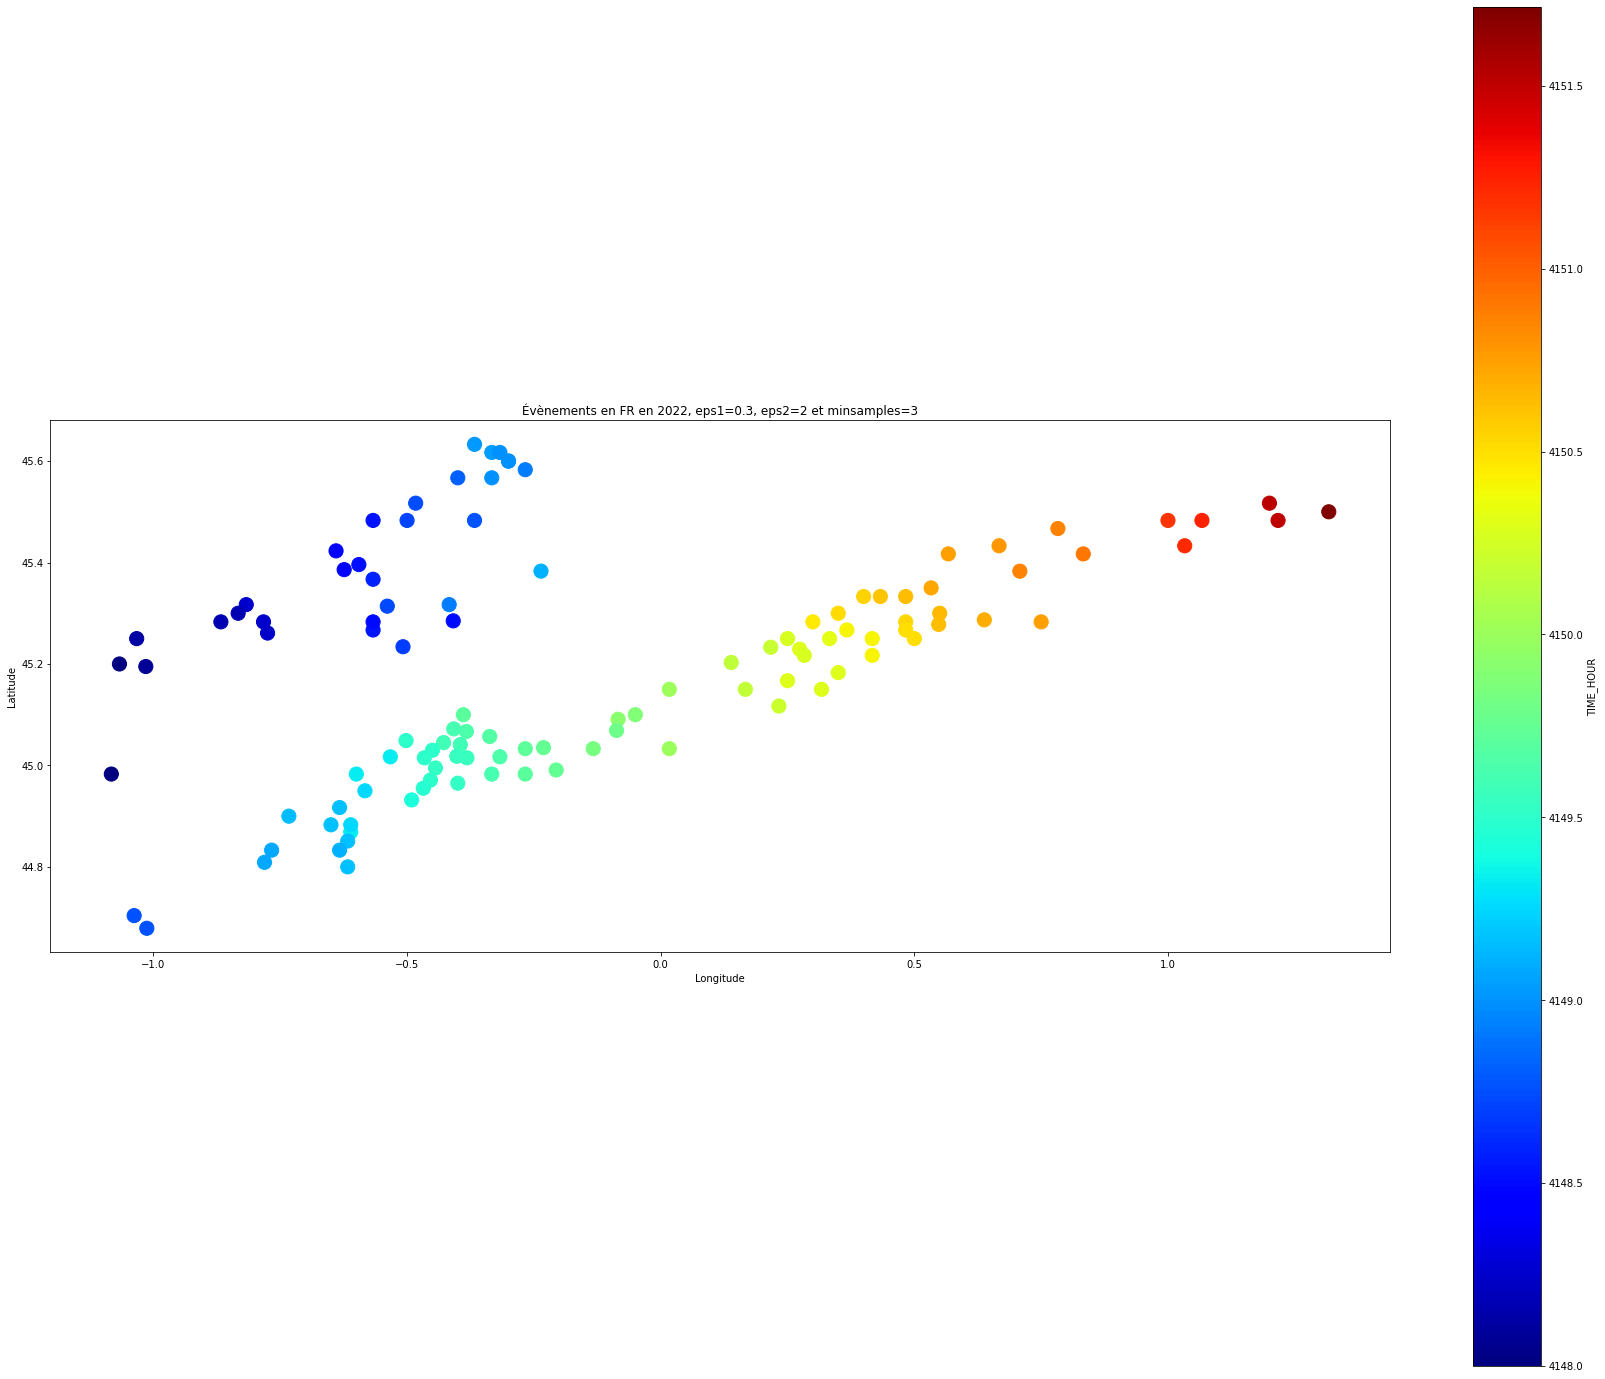

        TIME_HOUR  LATITUDE  LONGITUDE  cluster
classe                                         
29            110       110        110      110


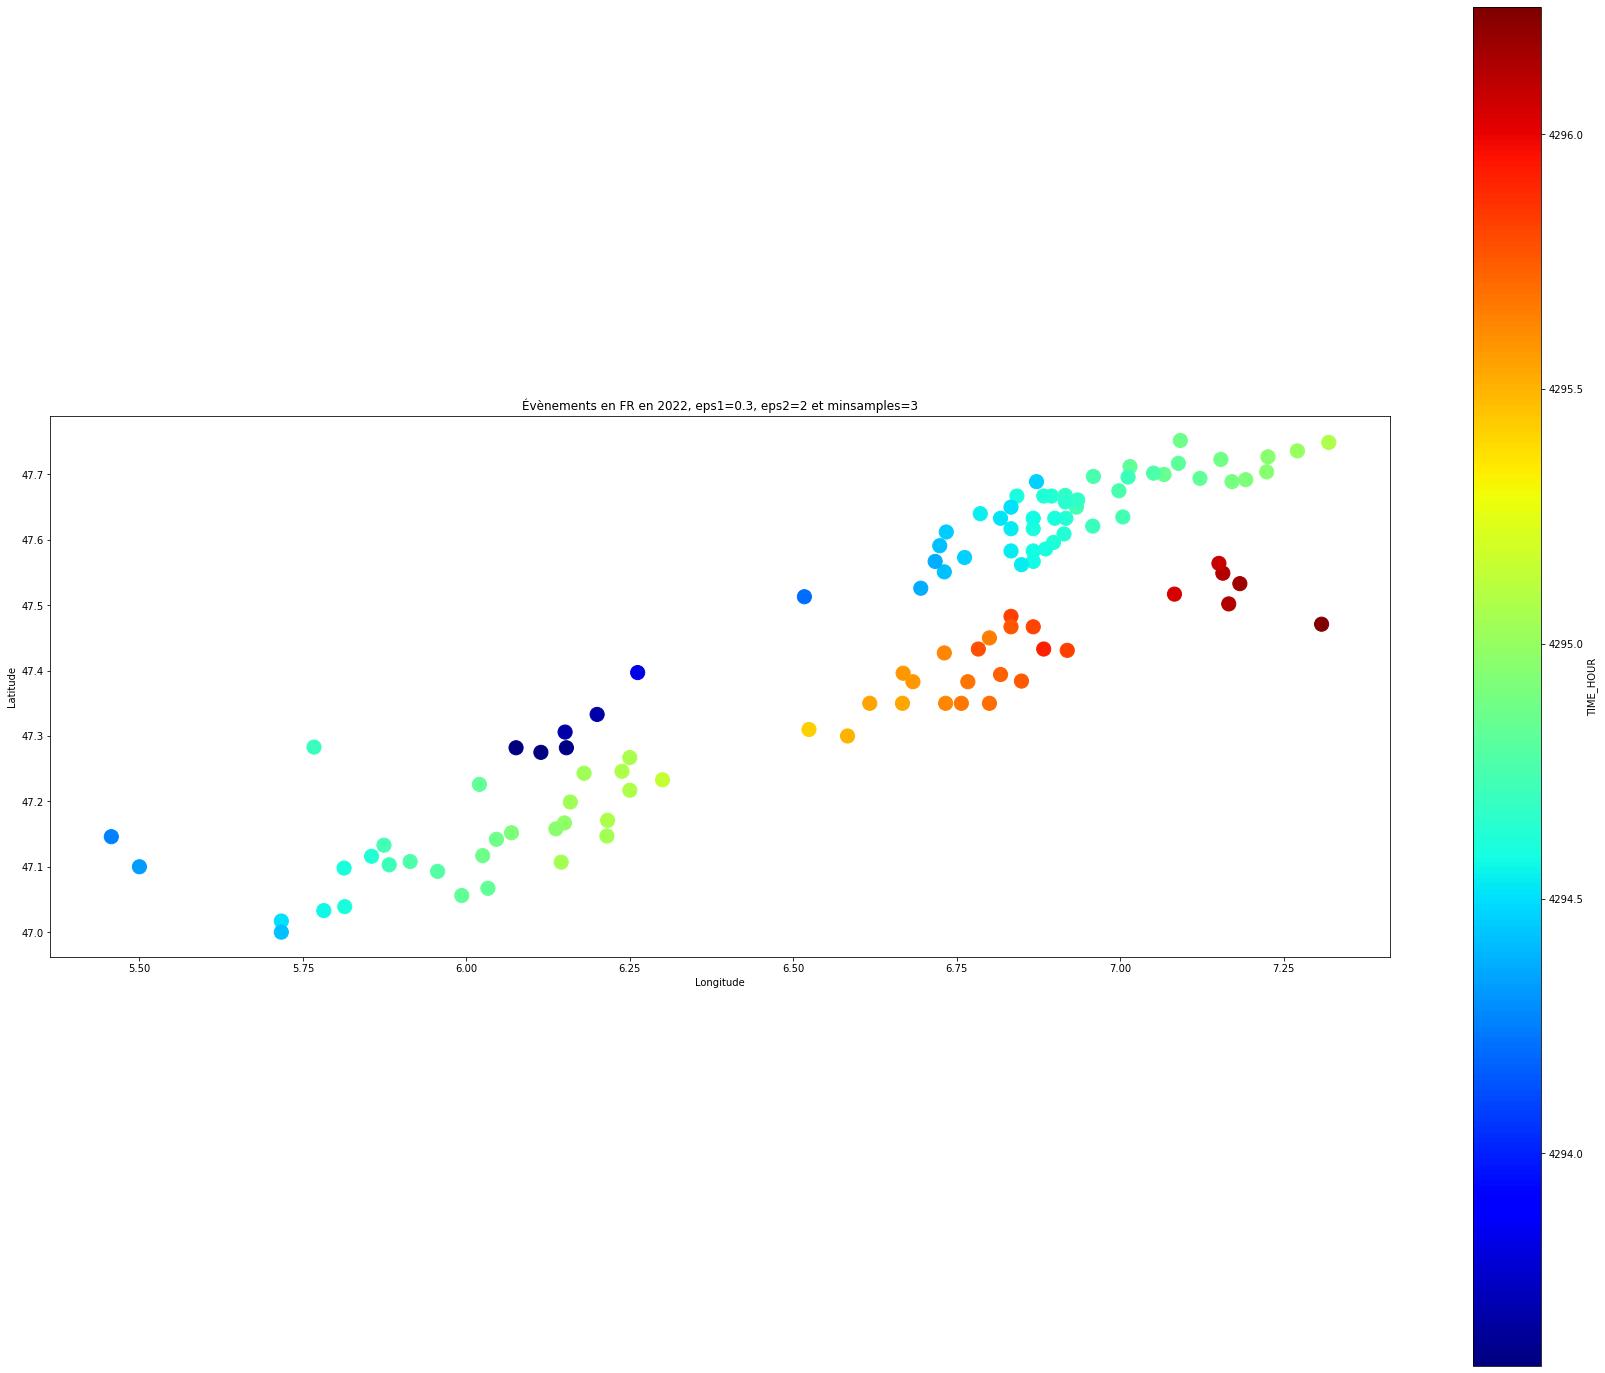

        TIME_HOUR  LATITUDE  LONGITUDE  cluster
classe                                         
48            105       105        105      105


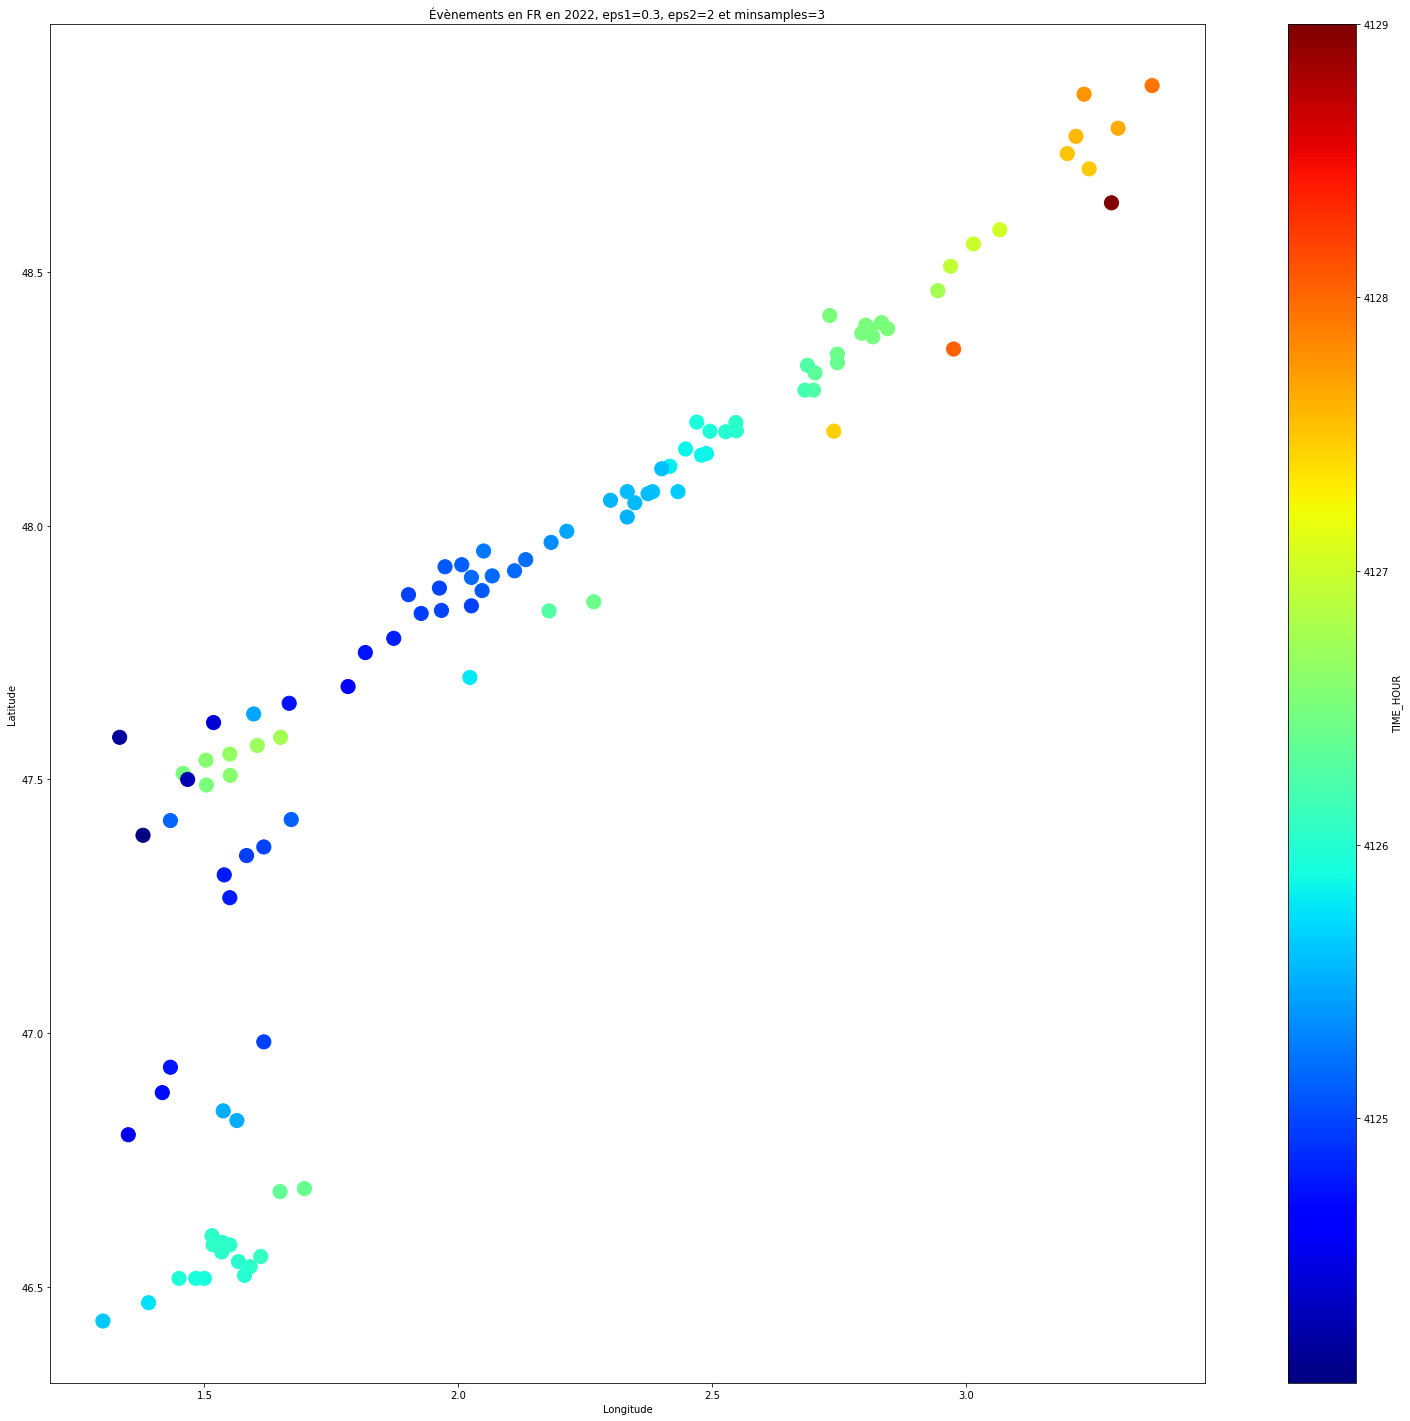

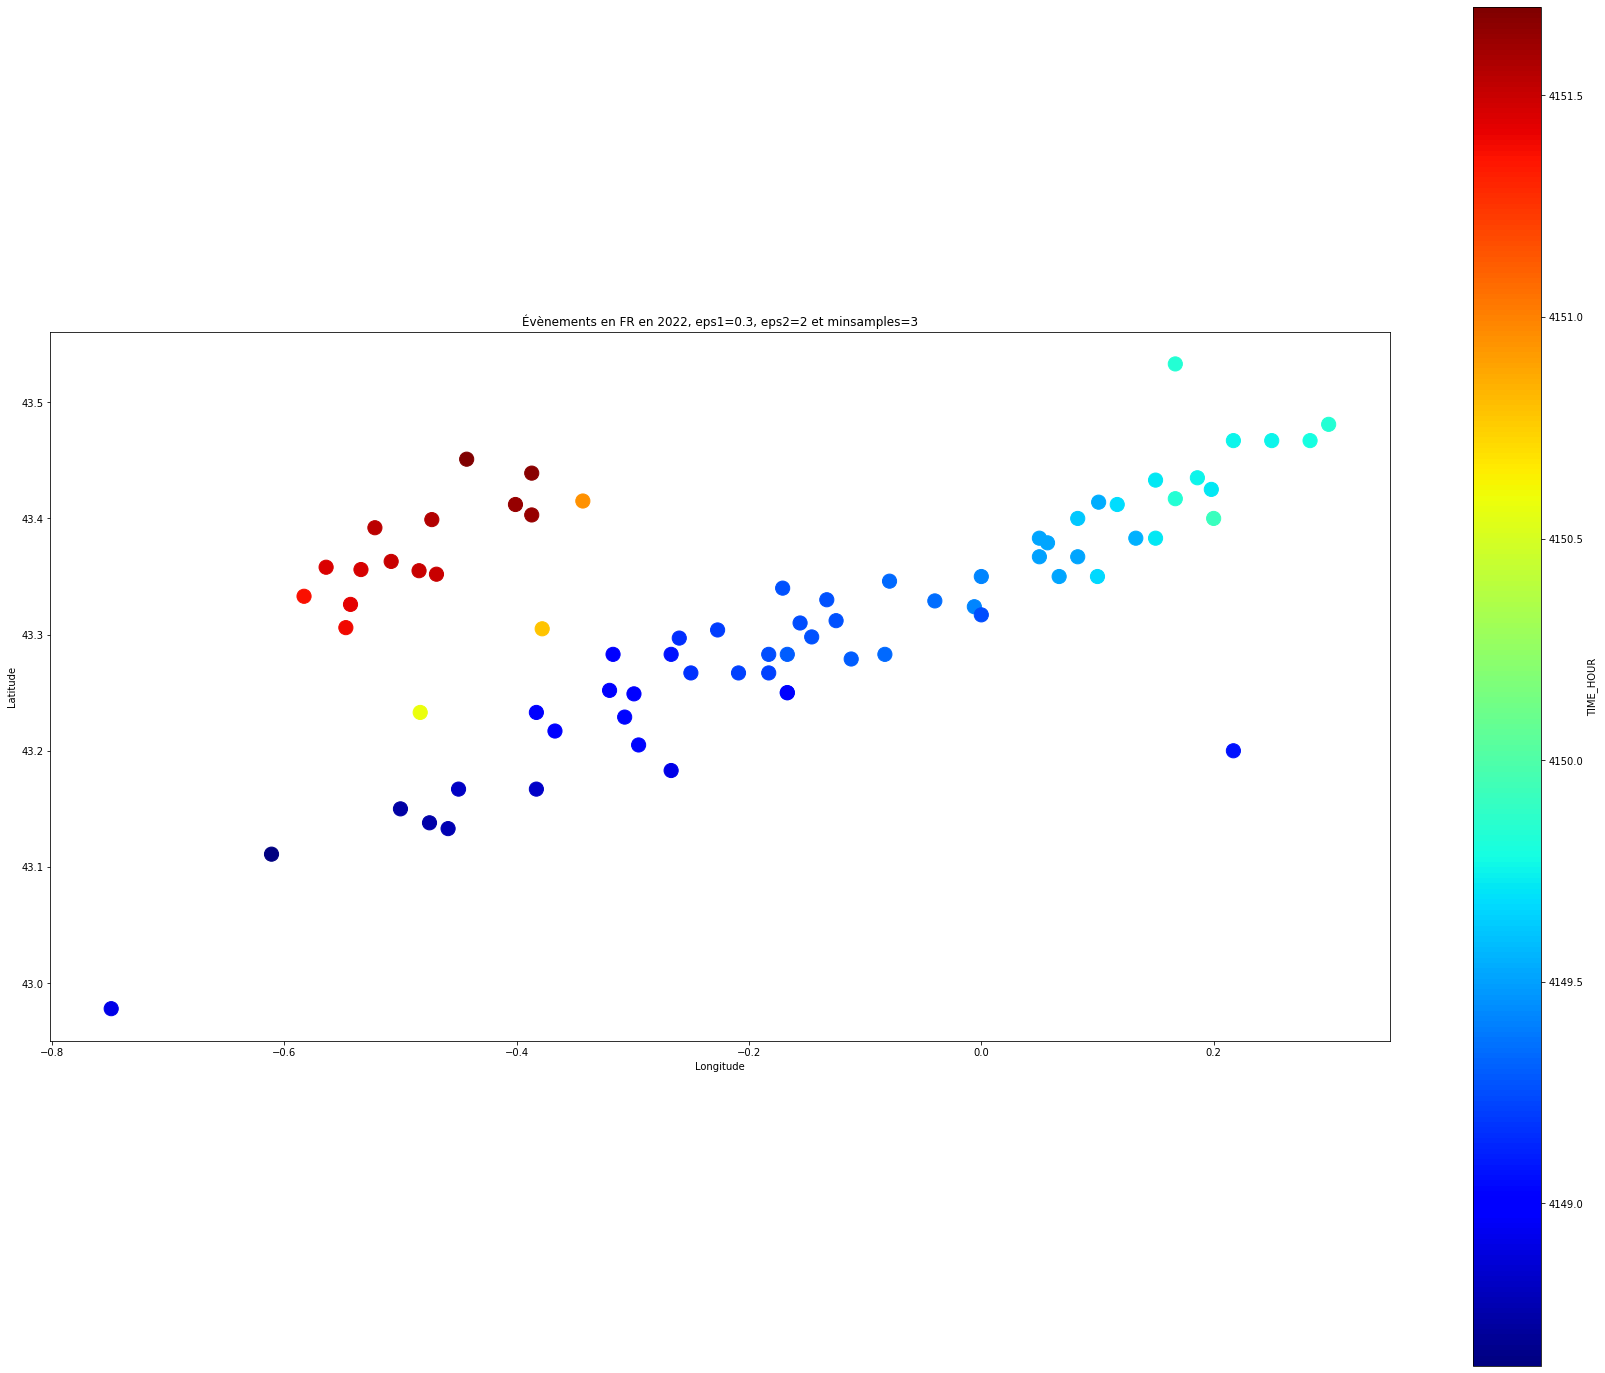

        TIME_HOUR  LATITUDE  LONGITUDE  cluster
classe                                         
45             63        63         63       63


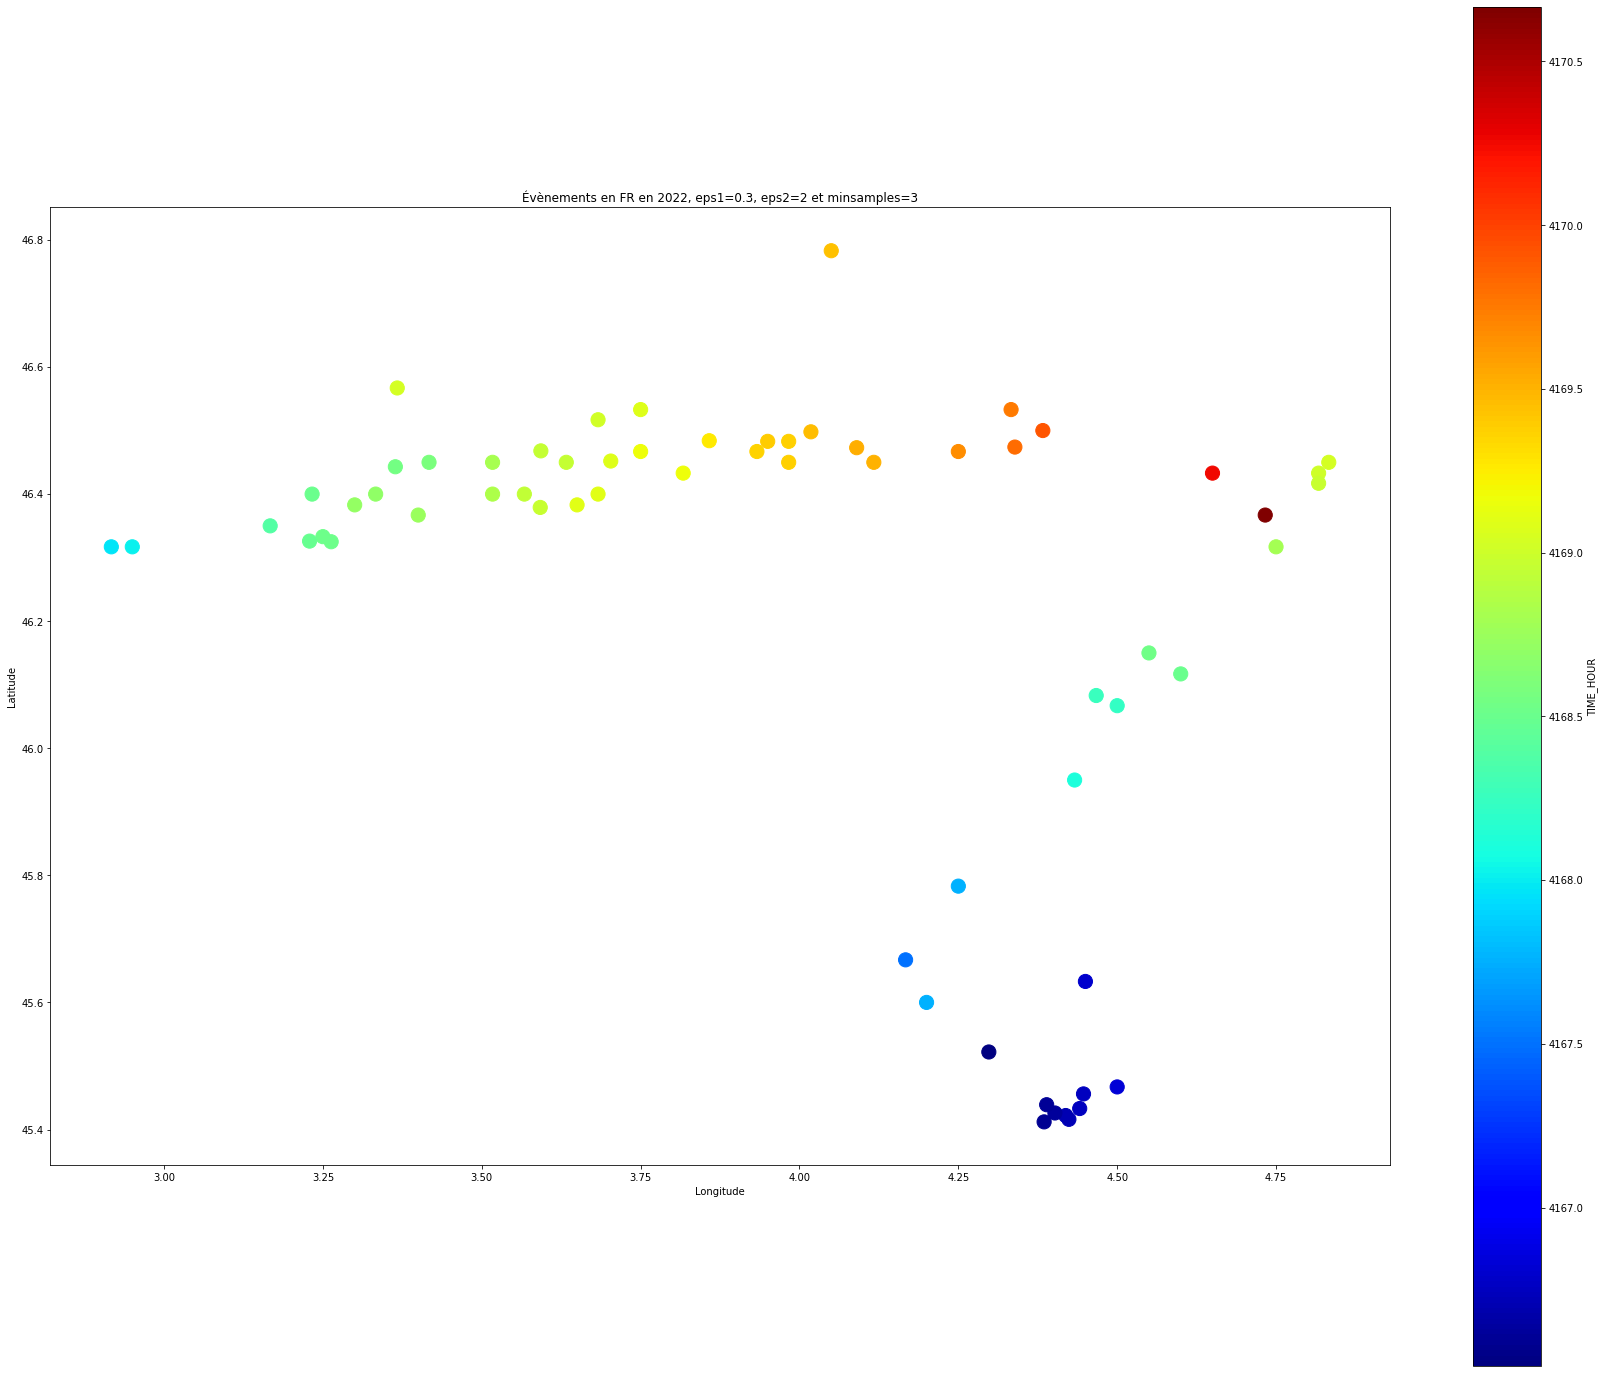

        TIME_HOUR  LATITUDE  LONGITUDE  cluster
classe                                         
77             52        52         52       52


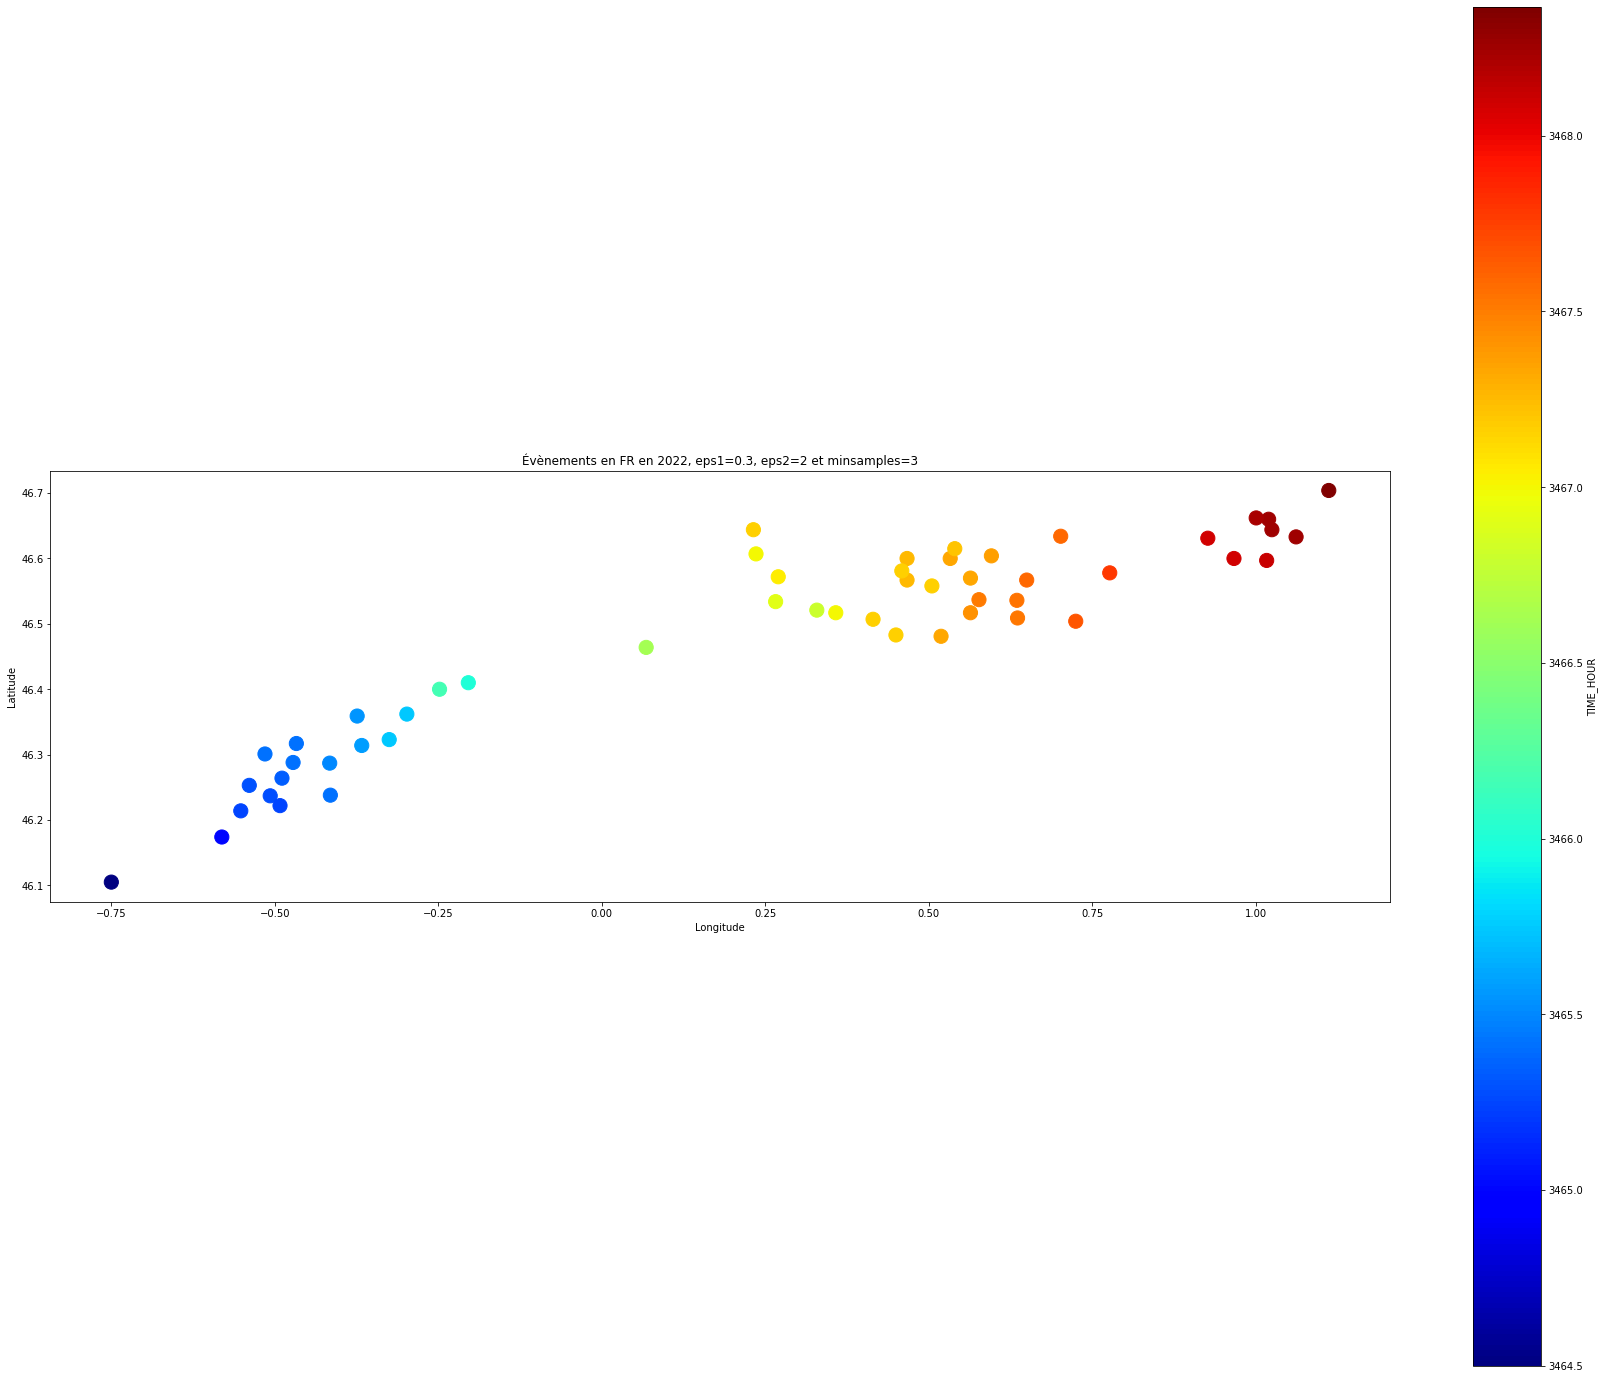

        TIME_HOUR  LATITUDE  LONGITUDE  cluster
classe                                         
21             46        46         46       46


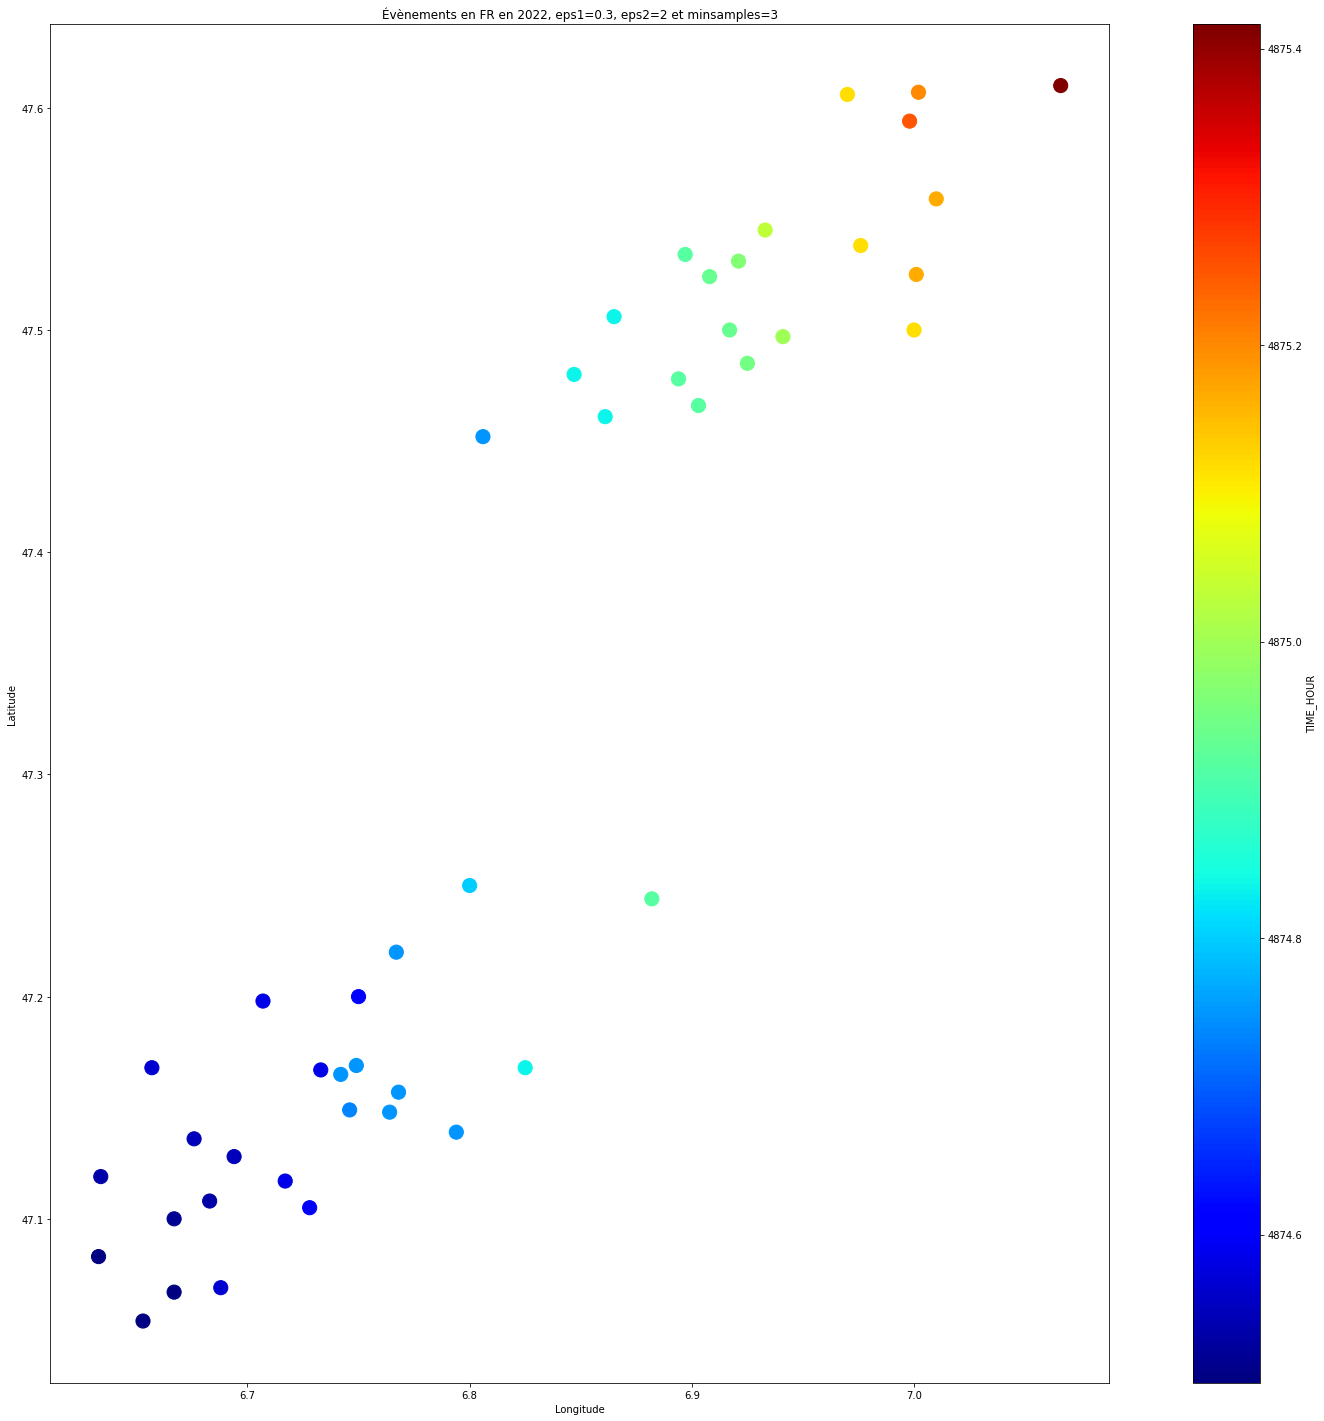

In [ ]:
x='FR'
for i in range(10):
    stdbscan_time_intensity(x, 2022, 0.3, 2, 3, i)

In [ ]:
# defining a function taking year, eps1, eps2 and min_samples into parameter and return a plot of the longest tracks
# obtained after applying st-dbscan in all europe

def clusterise_per_year(year, ep1, ep2, minpts):
    # extracting necessary data
    df_clst=df[df['YEAR']==year]
    #converting date to hour stamps
    df_clst['TIME_HOUR']=df_clst.apply(lambda donnee: convert_hour(donnee), axis=1)
    #maintaining only the columns needed
    df_clst=df_clst.loc[:,['TIME_HOUR','LATITUDE','LONGITUDE']]
    # applying st-dbscan
    df_clst1=df_clst.copy()
    model = ST_DBSCAN(eps1=ep1, eps2=ep2,min_samples=minpts)
    model.fit(df_clst1)
    df_clst1["cluster"] = model.fit(df_clst)
    classi = model.labels
    # column containing labels
    df_clst1["classe"]=classi
    #adding a column containing the number of reports contained in each class
    k=df_clst1.groupby(['classe']).count()
    l=[]
    for i in range(len(df_clst1)):
    
        for j in range(len(k)):
            if df_clst1.iloc[i]['classe']==j-1:
                l.append(k['LONGITUDE'][df_clst1.iloc[i]['classe']])
    df_clst1['LENGTH_EVENT']=l
    #deleting reports contained in the trash class (-1)
    df_clst1=df_clst1[(df_clst1["classe"]>-1)]
    events= clust(df_clst1,classi)
    #maintaining the longest tracks only
    b=df_clst1['LENGTH_EVENT'].unique()
    b=sorted(b,reverse=True)
    d=b[0]+1
    c=b[8]-1
    df_clst1=df_clst1[(df_clst1['LENGTH_EVENT']>c)&(df_clst1['LENGTH_EVENT']<d)]  
    k=k[(k['LATITUDE']>c)&(k['LATITUDE']<d)]
    print(k.to_string())
    #ploting
    geometry = [Point(xy) for xy in zip(df_clst1['LONGITUDE'], df_clst1['LATITUDE'])]
    gdf = GeoDataFrame(df_clst1, geometry=geometry)      
    ax = gdf.plot(figsize=(30,25), color="gray")

    df_clst1.plot.scatter(ax=ax, x = "LONGITUDE", y = "LATITUDE", c = "classe", cmap = "Accent")
    plt.title("Évènements en Europe en " + str(year) + ", eps1=" + str(ep1 ) + ", eps2=" + str(ep2 ) +" et minsamples=" +str(minpts ))
    plt.xlabel("Longitude")
    plt.ylabel("Latitude")
    plt.show()

<ipython-input-30-e020573da2db>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clst['TIME_HOUR']=df_clst.apply(lambda donnee: convert_hour(donnee), axis=1)


        TIME_HOUR  LATITUDE  LONGITUDE  cluster
classe                                         
3              20        20         20       20
17             20        20         20       20
18             18        18         18       18
24             32        32         32       32
27             32        32         32       32
80             66        66         66       66
91             21        21         21       21
111            40        40         40       40
126            23        23         23       23
138            21        21         21       21
144            26        26         26       26
148            18        18         18       18
152            24        24         24       24


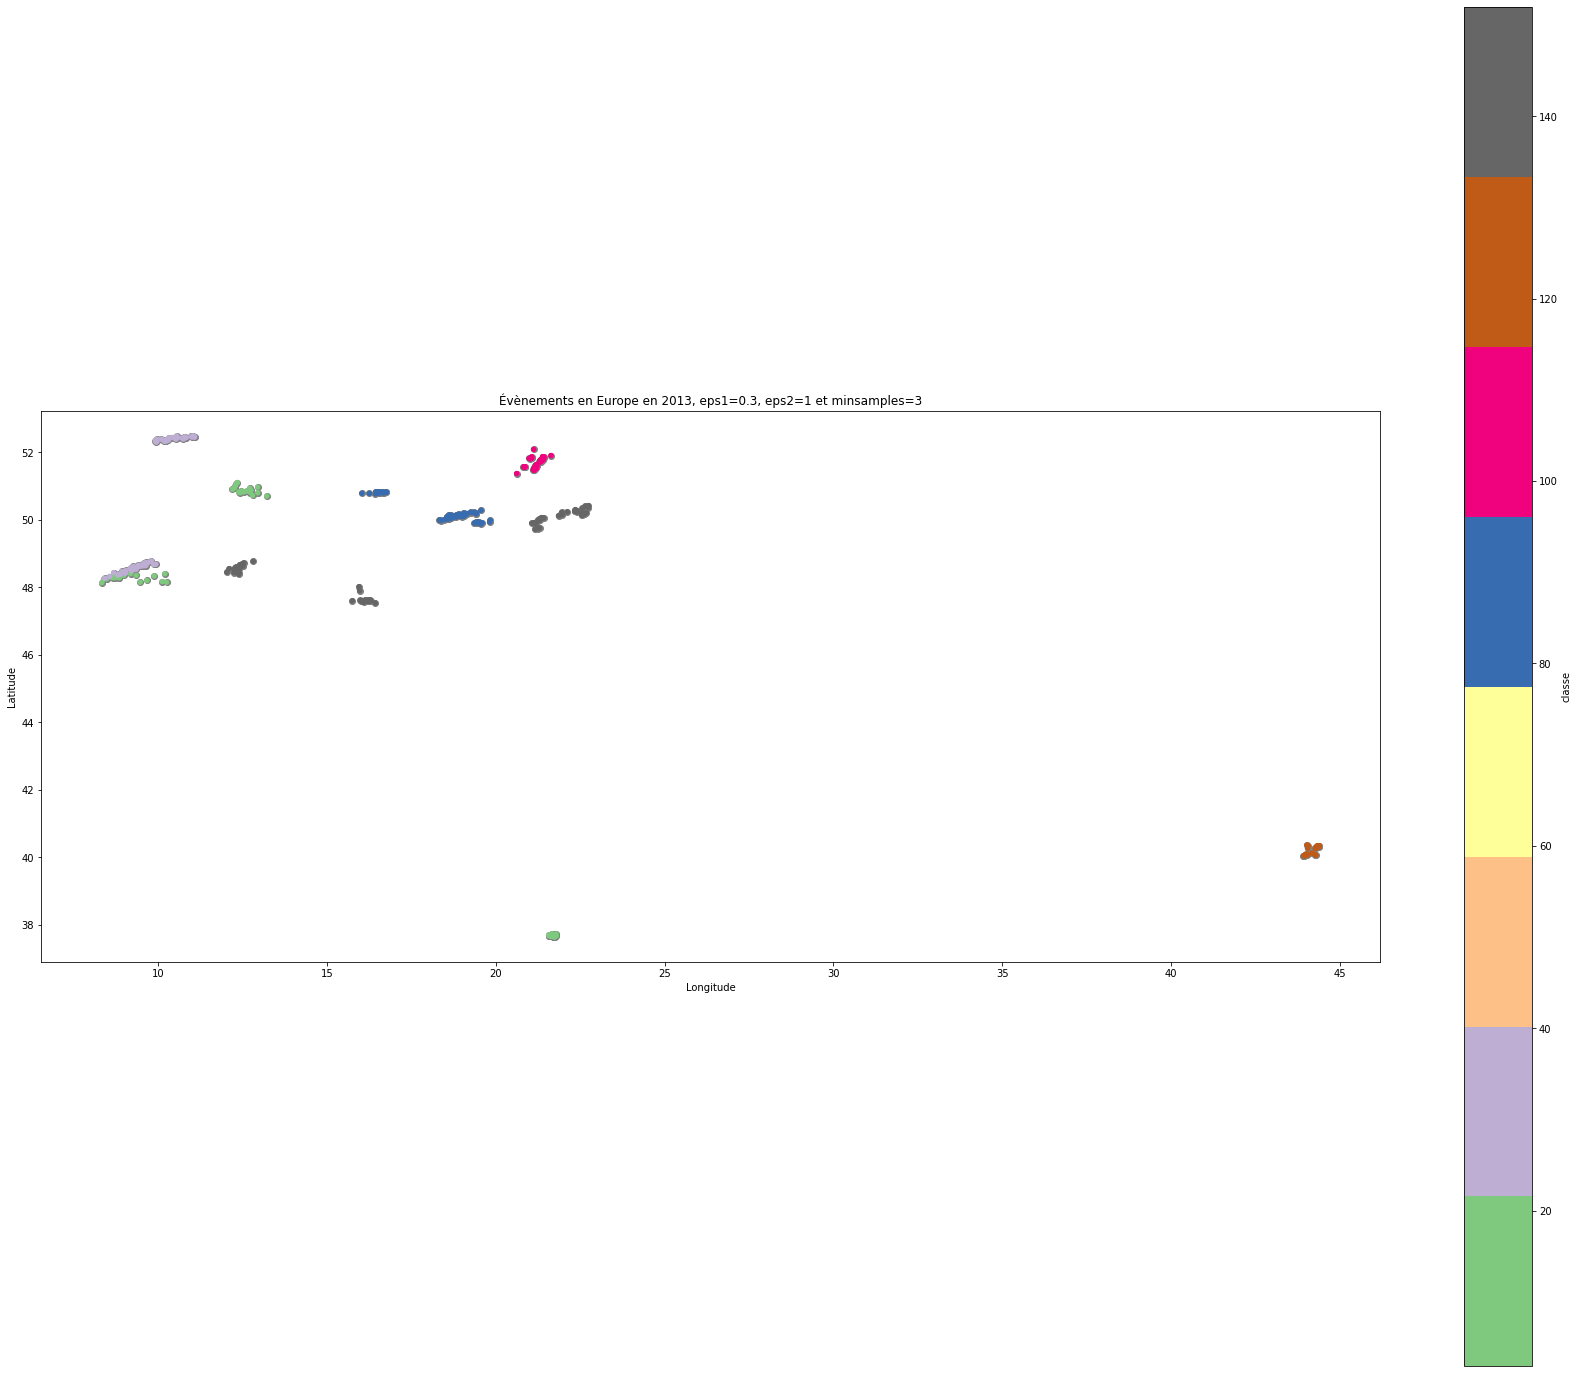

<ipython-input-30-e020573da2db>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clst['TIME_HOUR']=df_clst.apply(lambda donnee: convert_hour(donnee), axis=1)


        TIME_HOUR  LATITUDE  LONGITUDE  cluster
classe                                         
8               9         9          9        9
25             16        16         16       16
27             12        12         12       12
41             14        14         14       14
42             29        29         29       29
52             11        11         11       11
54              9         9          9        9
56             10        10         10       10
58              9         9          9        9
59             14        14         14       14
63              9         9          9        9
73             11        11         11       11
79             11        11         11       11
87             19        19         19       19
94              9         9          9        9
102             9         9          9        9
104            11        11         11       11
112             9         9          9        9
132             9         9          9  

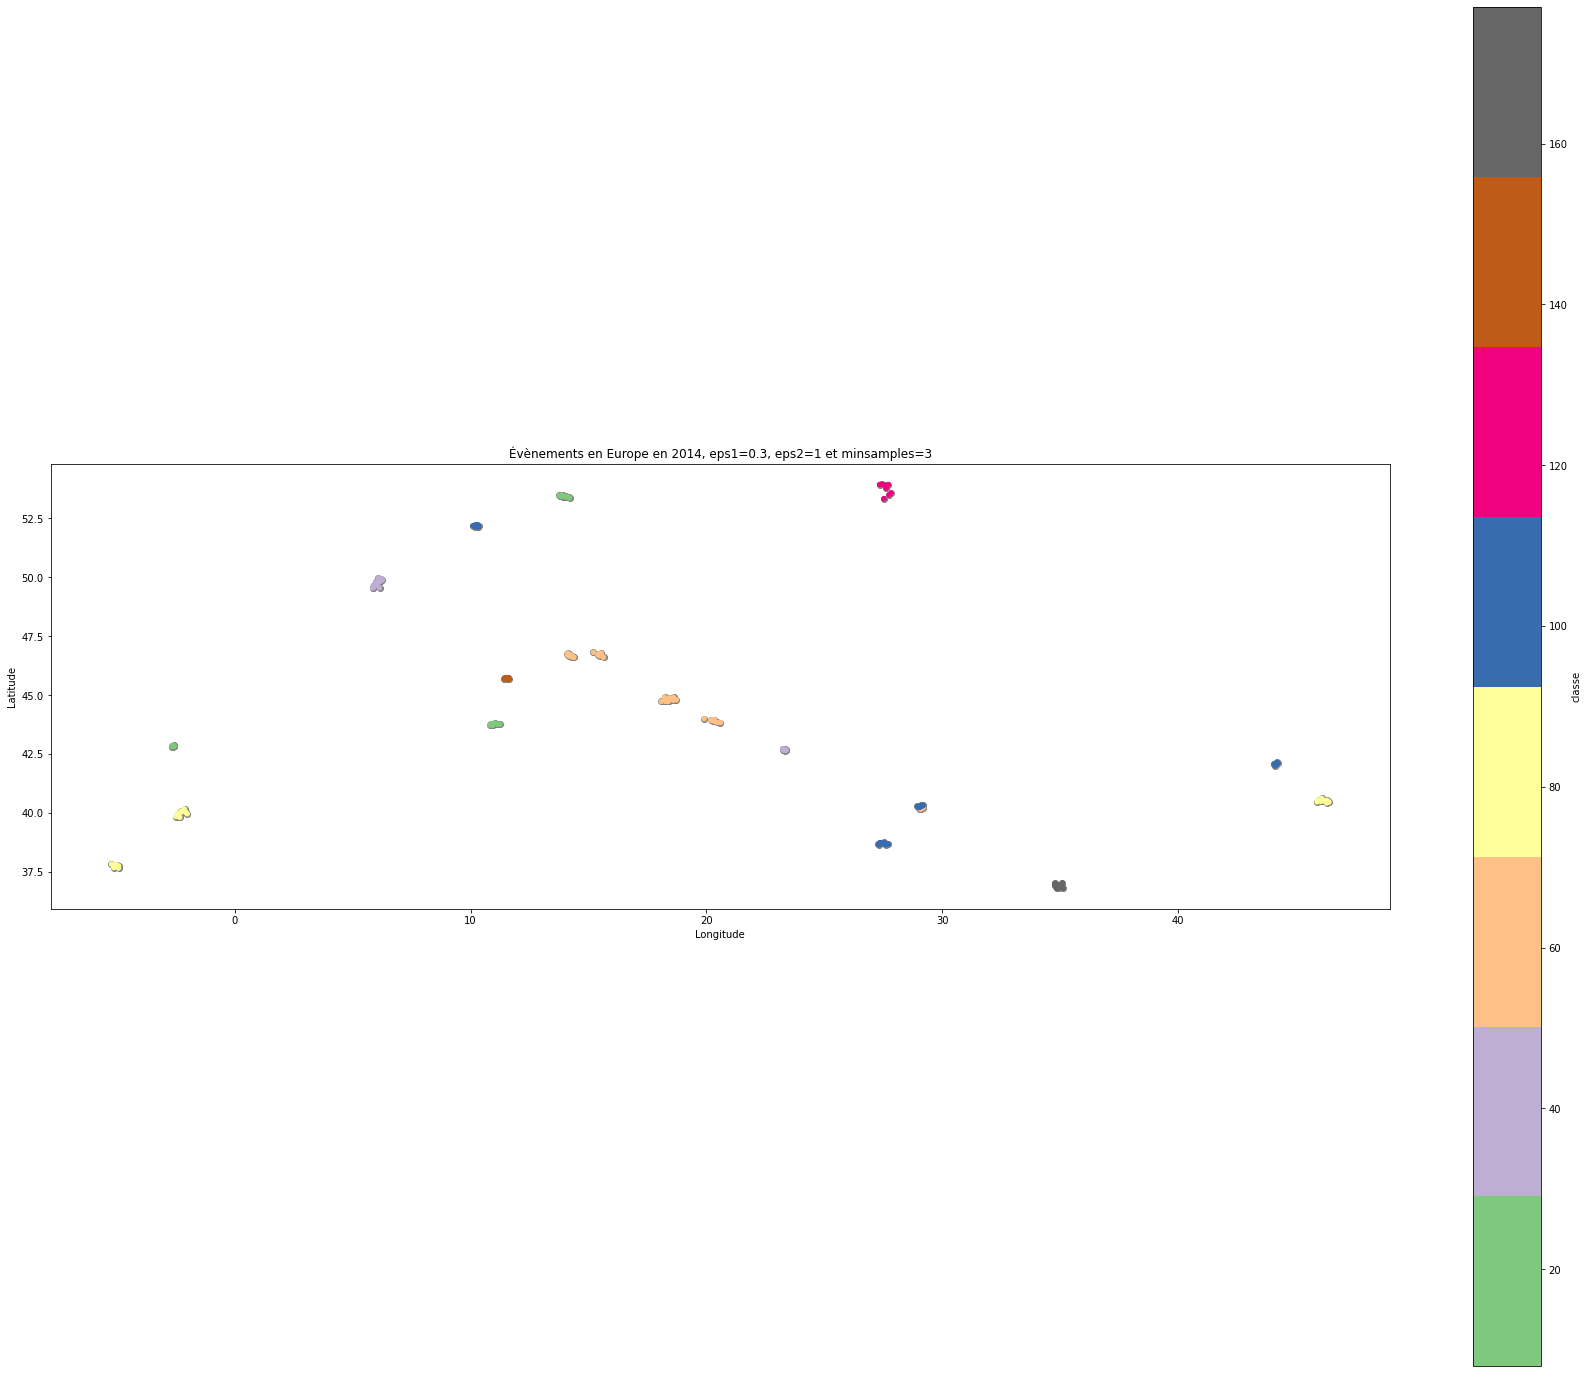

<ipython-input-30-e020573da2db>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clst['TIME_HOUR']=df_clst.apply(lambda donnee: convert_hour(donnee), axis=1)


        TIME_HOUR  LATITUDE  LONGITUDE  cluster
classe                                         
5              13        13         13       13
19             12        12         12       12
34             10        10         10       10
35             10        10         10       10
52             22        22         22       22
59             12        12         12       12
62             42        42         42       42
80             12        12         12       12
133            11        11         11       11
138            36        36         36       36
164            17        17         17       17
168            13        13         13       13
174            10        10         10       10
181            16        16         16       16


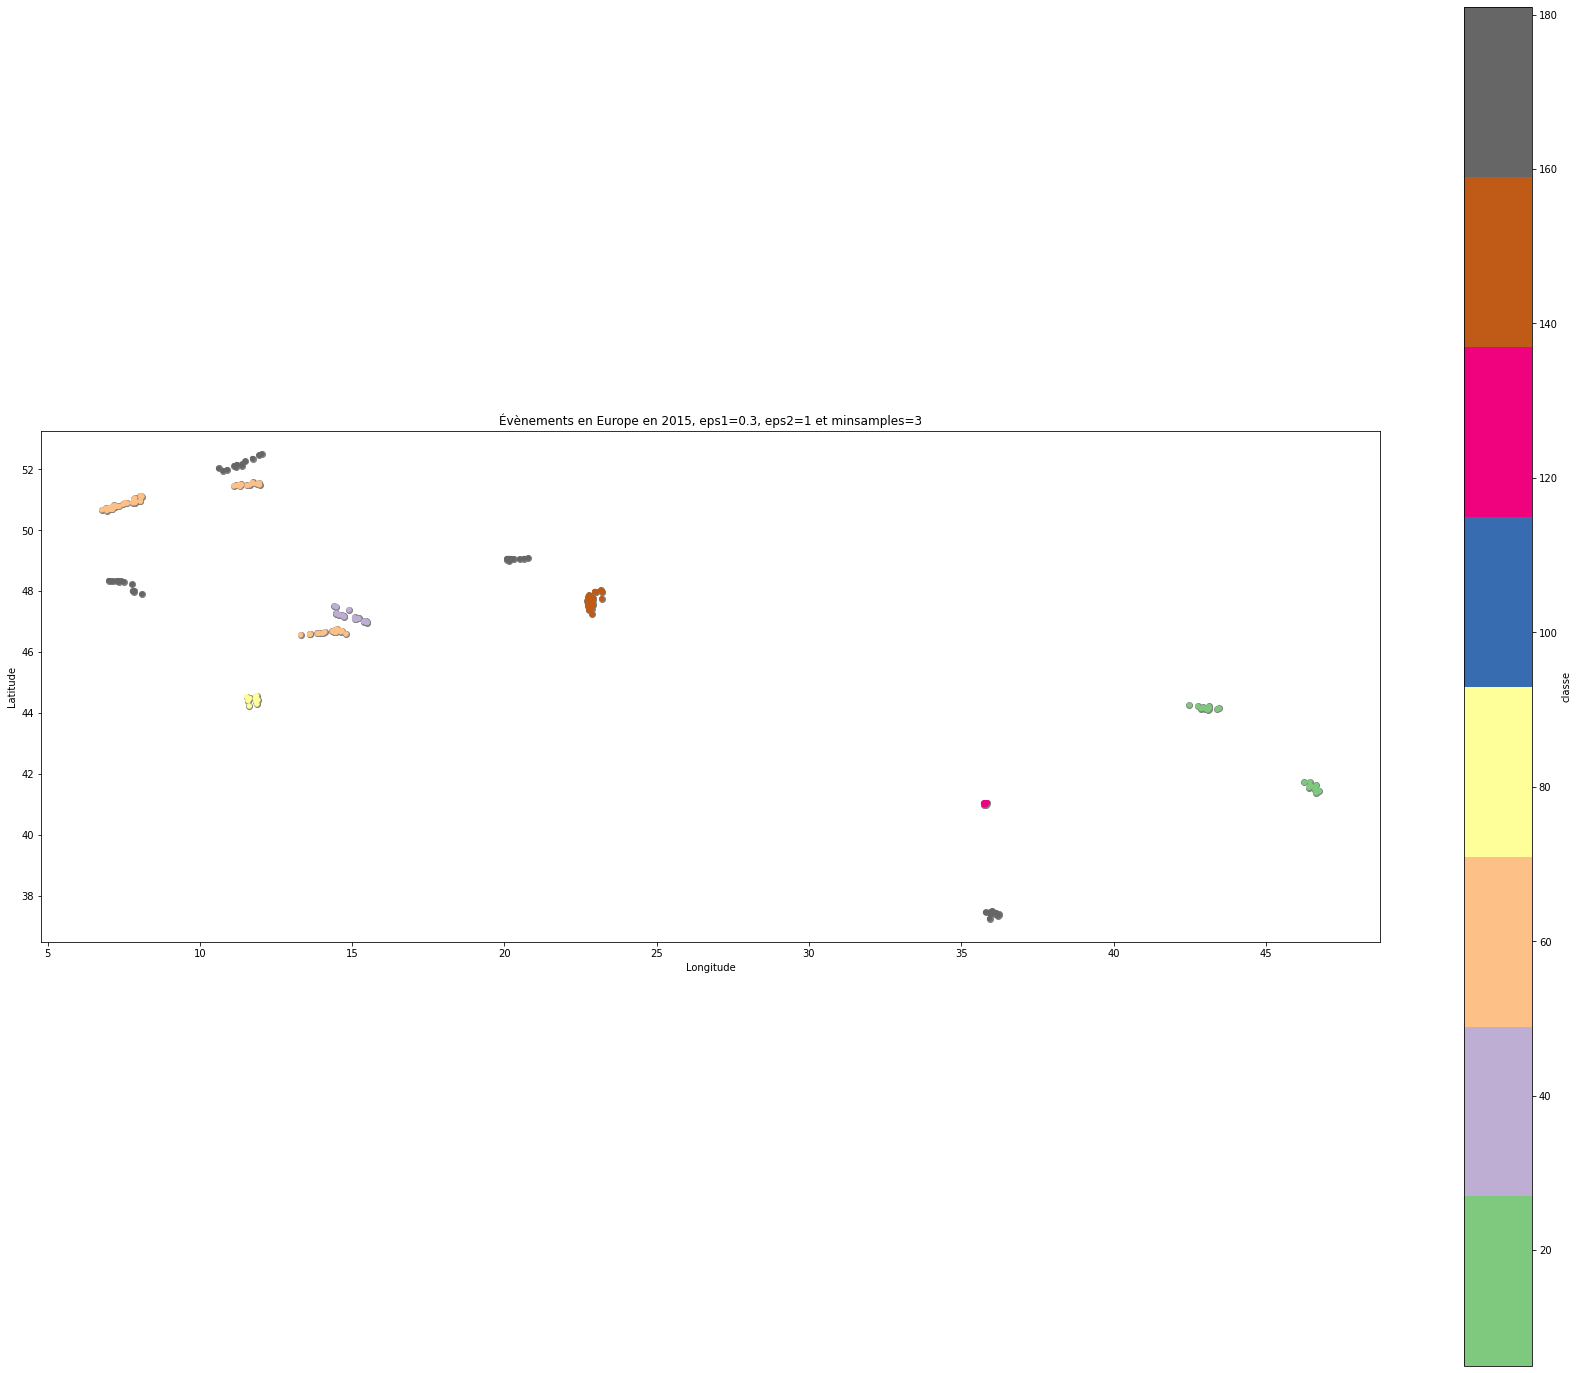

<ipython-input-30-e020573da2db>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clst['TIME_HOUR']=df_clst.apply(lambda donnee: convert_hour(donnee), axis=1)


        TIME_HOUR  LATITUDE  LONGITUDE  cluster
classe                                         
7              65        65         65       65
12             20        20         20       20
34             24        24         24       24
50             27        27         27       27
62             35        35         35       35
98             44        44         44       44
102            35        35         35       35
107            34        34         34       34
111            23        23         23       23
158            19        19         19       19
189            24        24         24       24
201            20        20         20       20
205            20        20         20       20
220            24        24         24       24


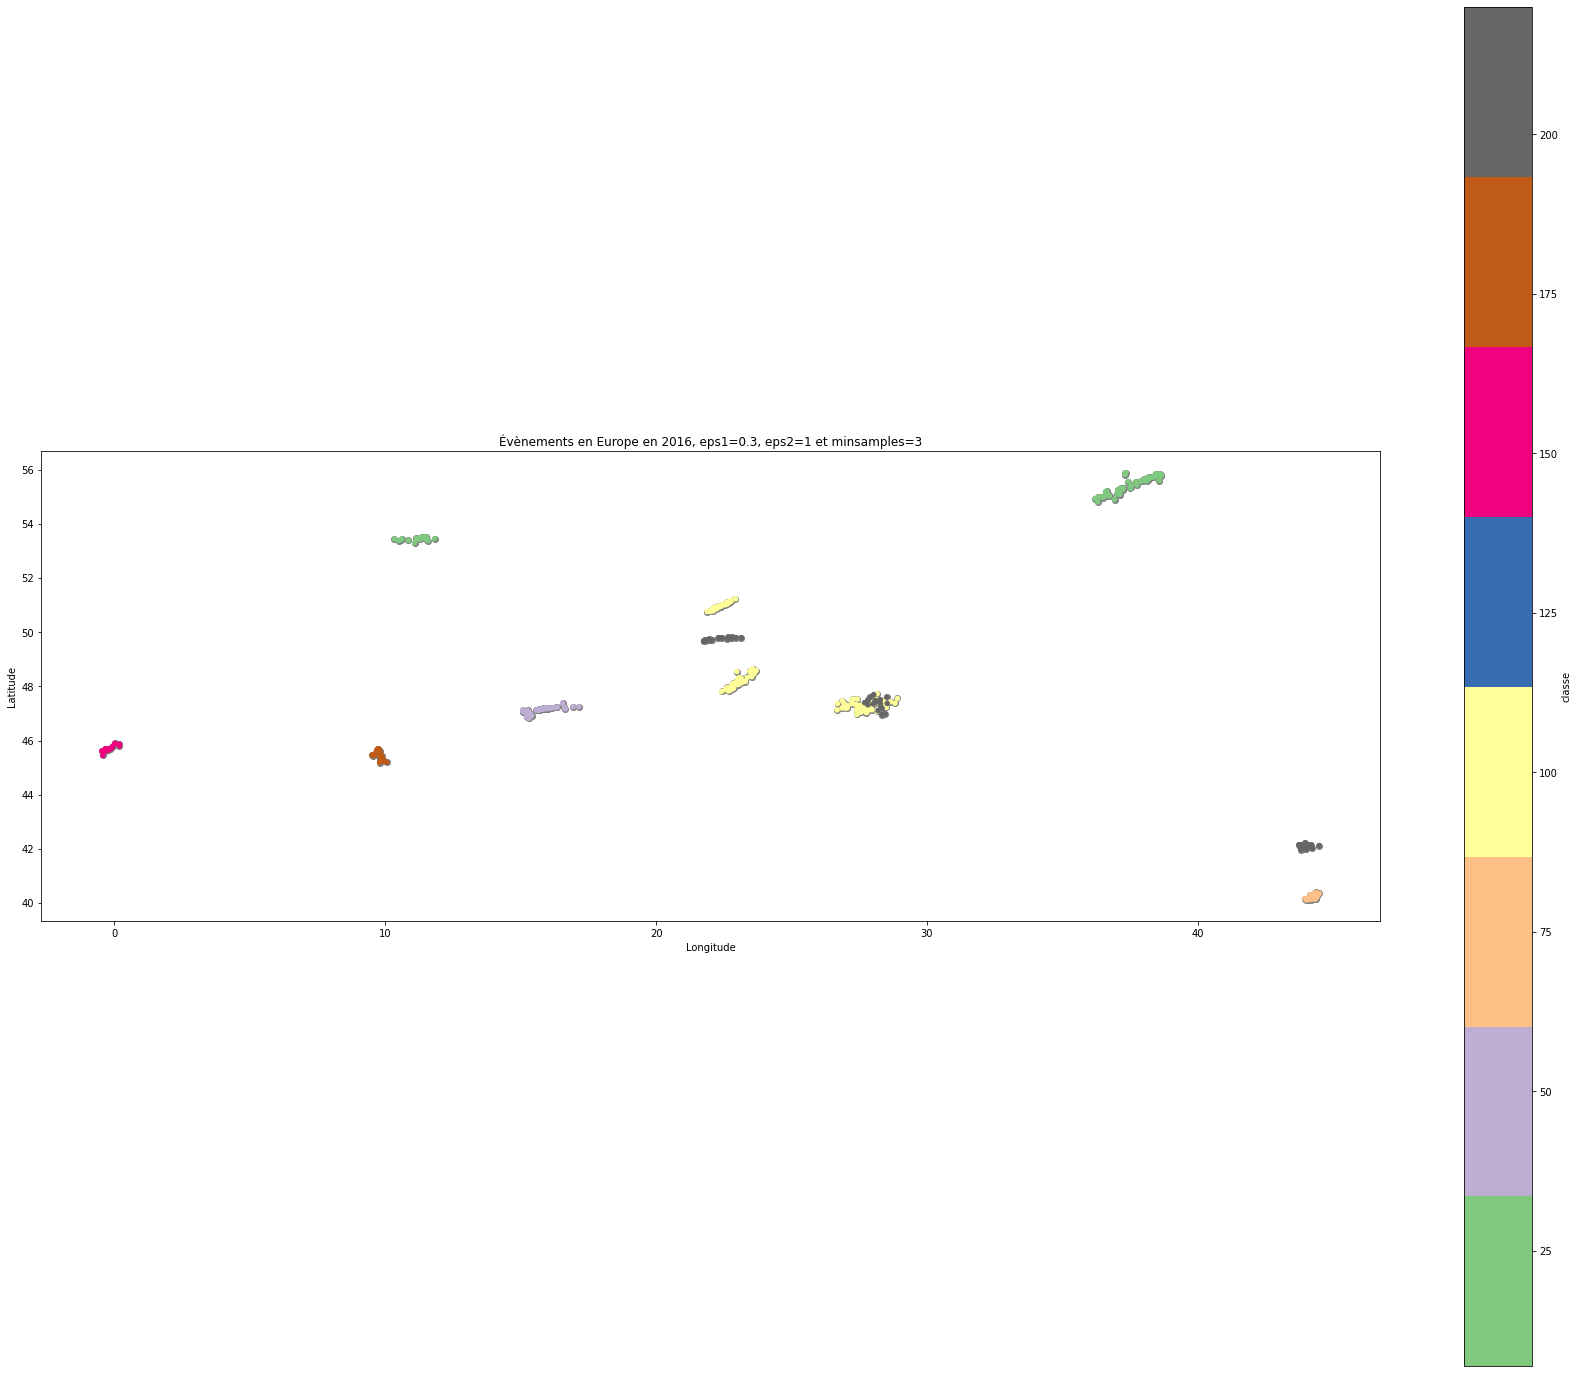

<ipython-input-30-e020573da2db>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clst['TIME_HOUR']=df_clst.apply(lambda donnee: convert_hour(donnee), axis=1)


        TIME_HOUR  LATITUDE  LONGITUDE  cluster
classe                                         
22             15        15         15       15
25             15        15         15       15
34             16        16         16       16
49             11        11         11       11
66             12        12         12       12
90             18        18         18       18
95             11        11         11       11
101            10        10         10       10
103            13        13         13       13
105            11        11         11       11
106            11        11         11       11
113            14        14         14       14
134            16        16         16       16
181            16        16         16       16
193            13        13         13       13
194            15        15         15       15
195            17        17         17       17
221            17        17         17       17
248            16        16         16  

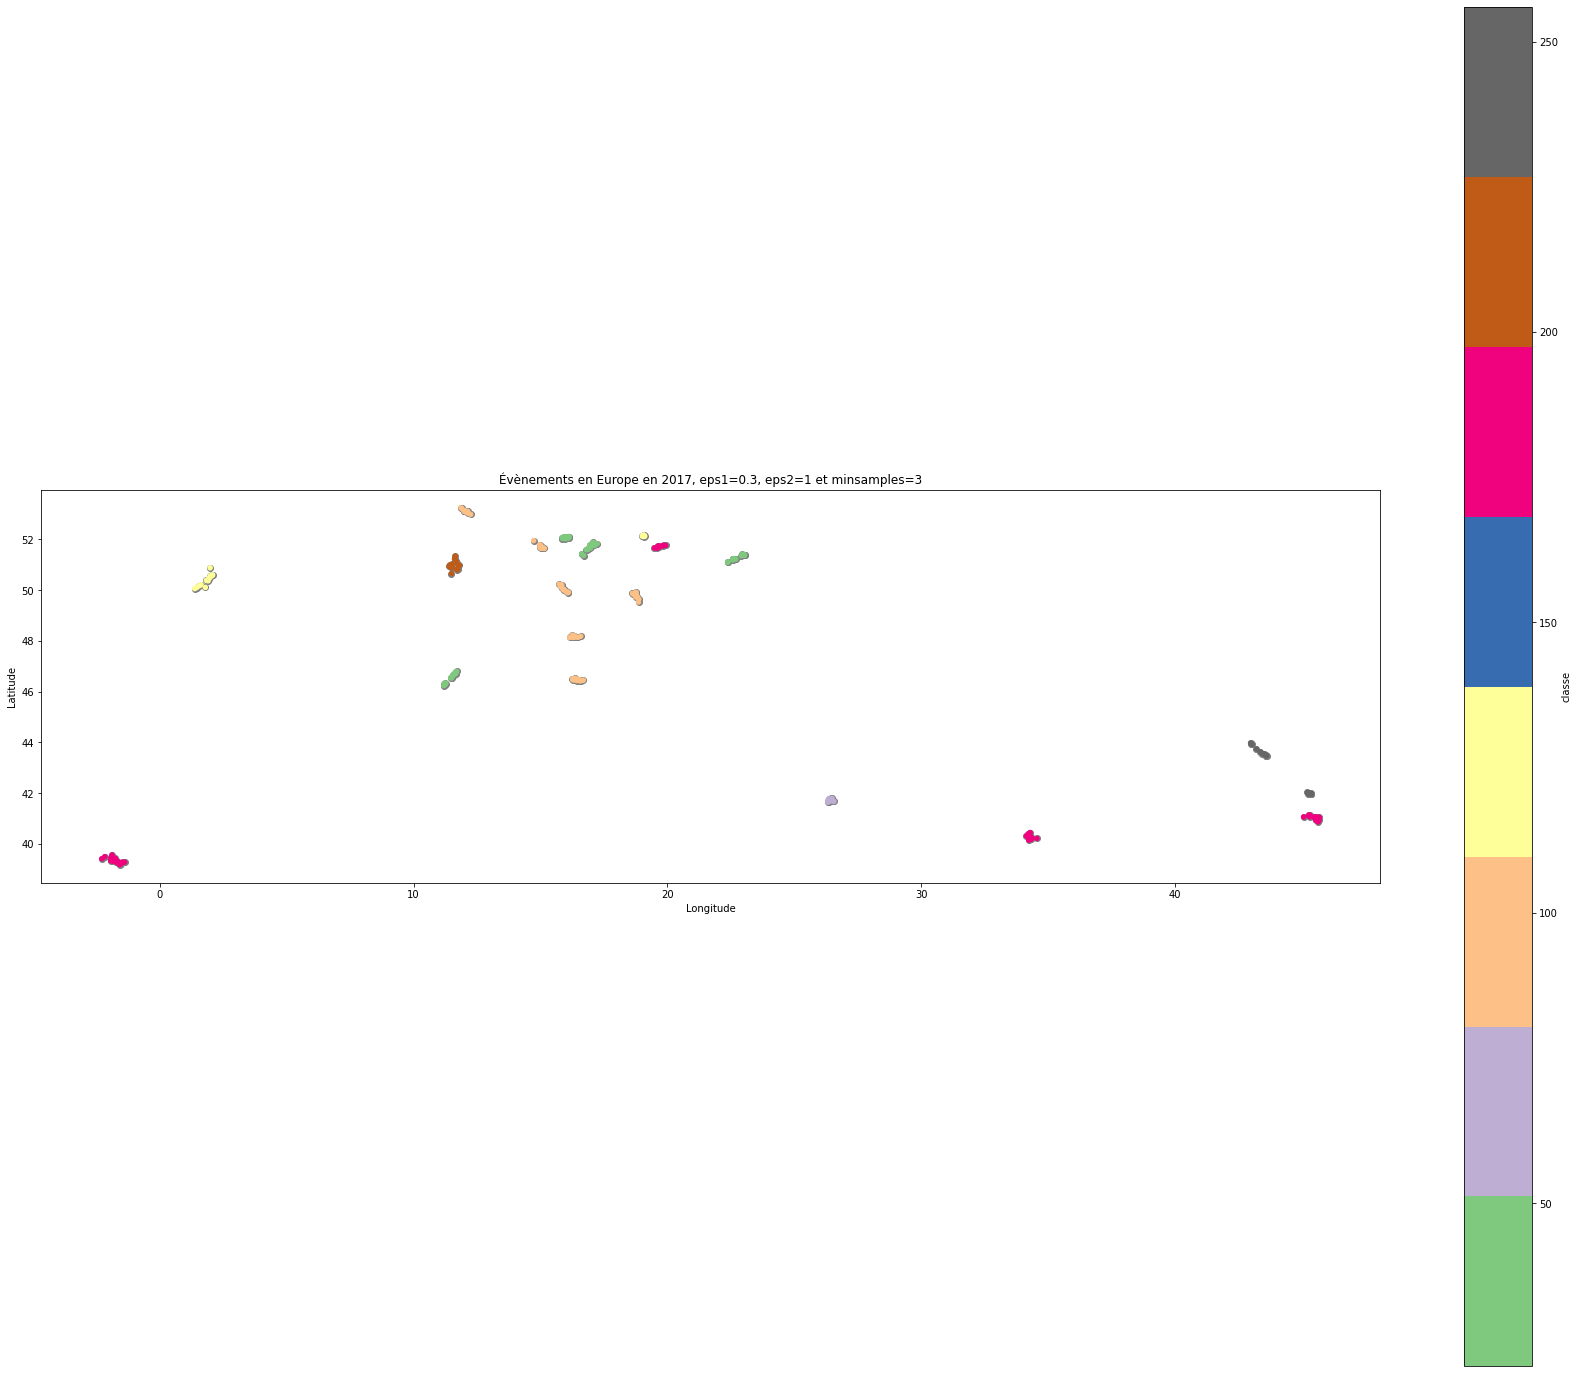

<ipython-input-30-e020573da2db>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clst['TIME_HOUR']=df_clst.apply(lambda donnee: convert_hour(donnee), axis=1)


        TIME_HOUR  LATITUDE  LONGITUDE  cluster
classe                                         
1              15        15         15       15
29             13        13         13       13
58             16        16         16       16
60             17        17         17       17
62             27        27         27       27
69             14        14         14       14
73             12        12         12       12
86             12        12         12       12
93             12        12         12       12
107            12        12         12       12
137            12        12         12       12
170            14        14         14       14
187            18        18         18       18
190            25        25         25       25


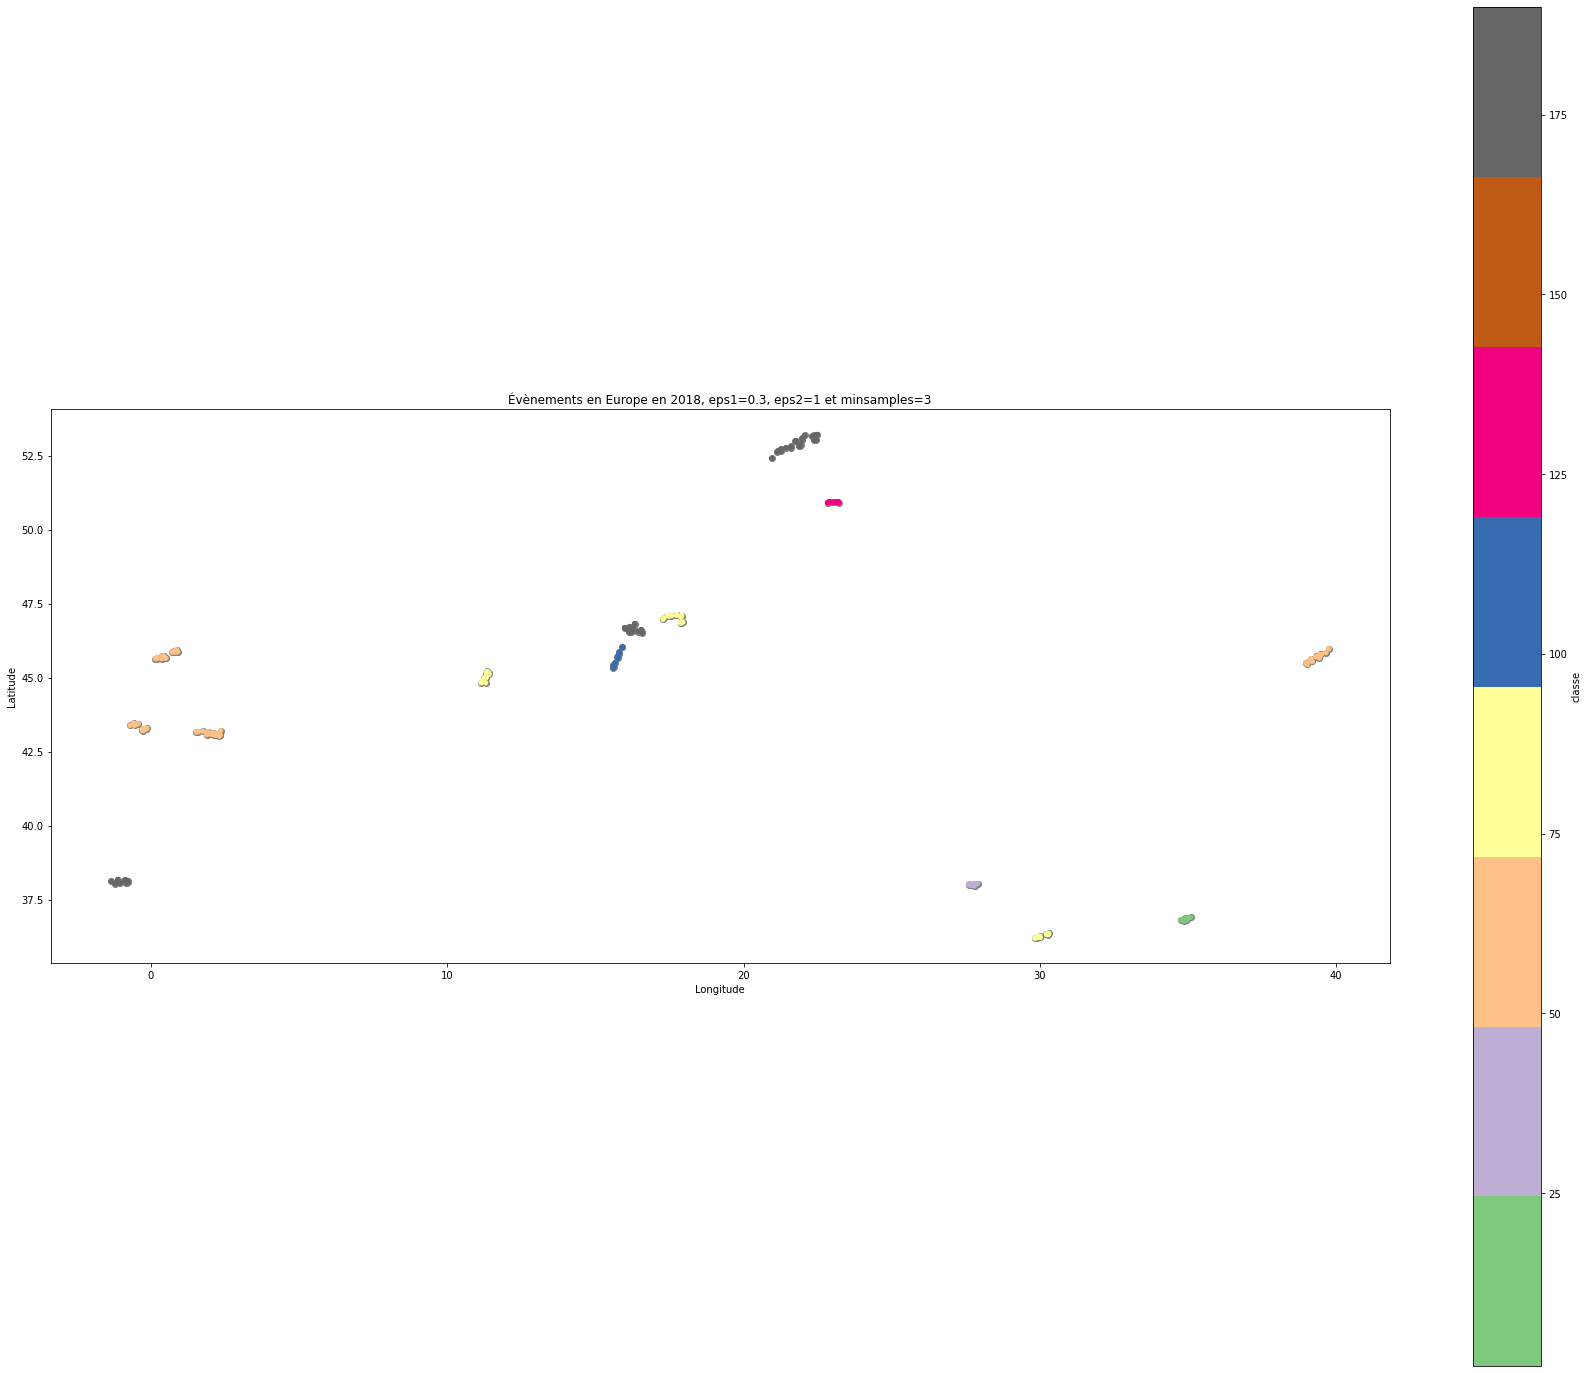

<ipython-input-30-e020573da2db>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clst['TIME_HOUR']=df_clst.apply(lambda donnee: convert_hour(donnee), axis=1)


        TIME_HOUR  LATITUDE  LONGITUDE  cluster
classe                                         
12             22        22         22       22
26             35        35         35       35
101            21        21         21       21
102            70        70         70       70
145            33        33         33       33
157            19        19         19       19
184            33        33         33       33
187            38        38         38       38
201            31        31         31       31
255            81        81         81       81


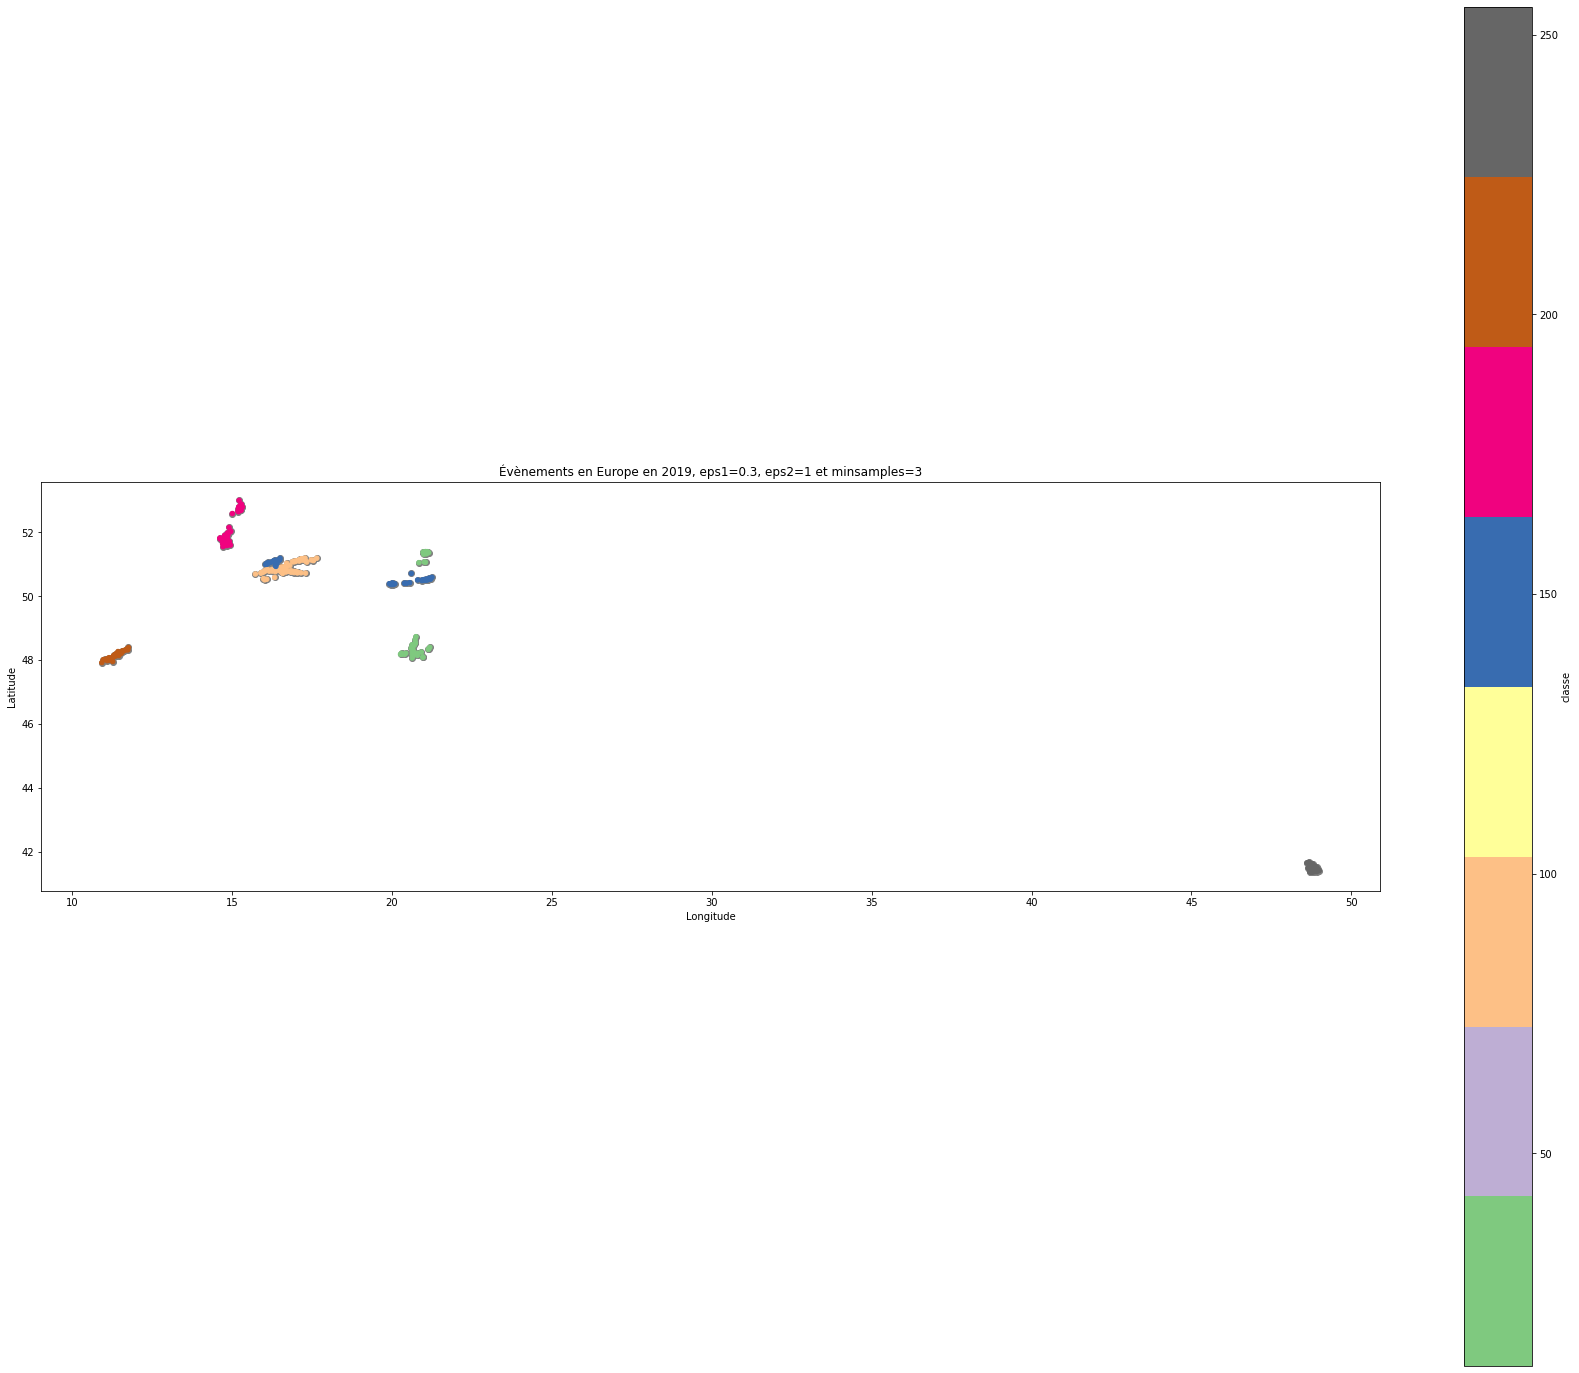

<ipython-input-30-e020573da2db>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clst['TIME_HOUR']=df_clst.apply(lambda donnee: convert_hour(donnee), axis=1)


        TIME_HOUR  LATITUDE  LONGITUDE  cluster
classe                                         
27             50        50         50       50
42             18        18         18       18
79             21        21         21       21
82             15        15         15       15
87             54        54         54       54
92             21        21         21       21
109            21        21         21       21
218            15        15         15       15
223            15        15         15       15
224            15        15         15       15
227            29        29         29       29
230            16        16         16       16
240            16        16         16       16
250            24        24         24       24
269            52        52         52       52


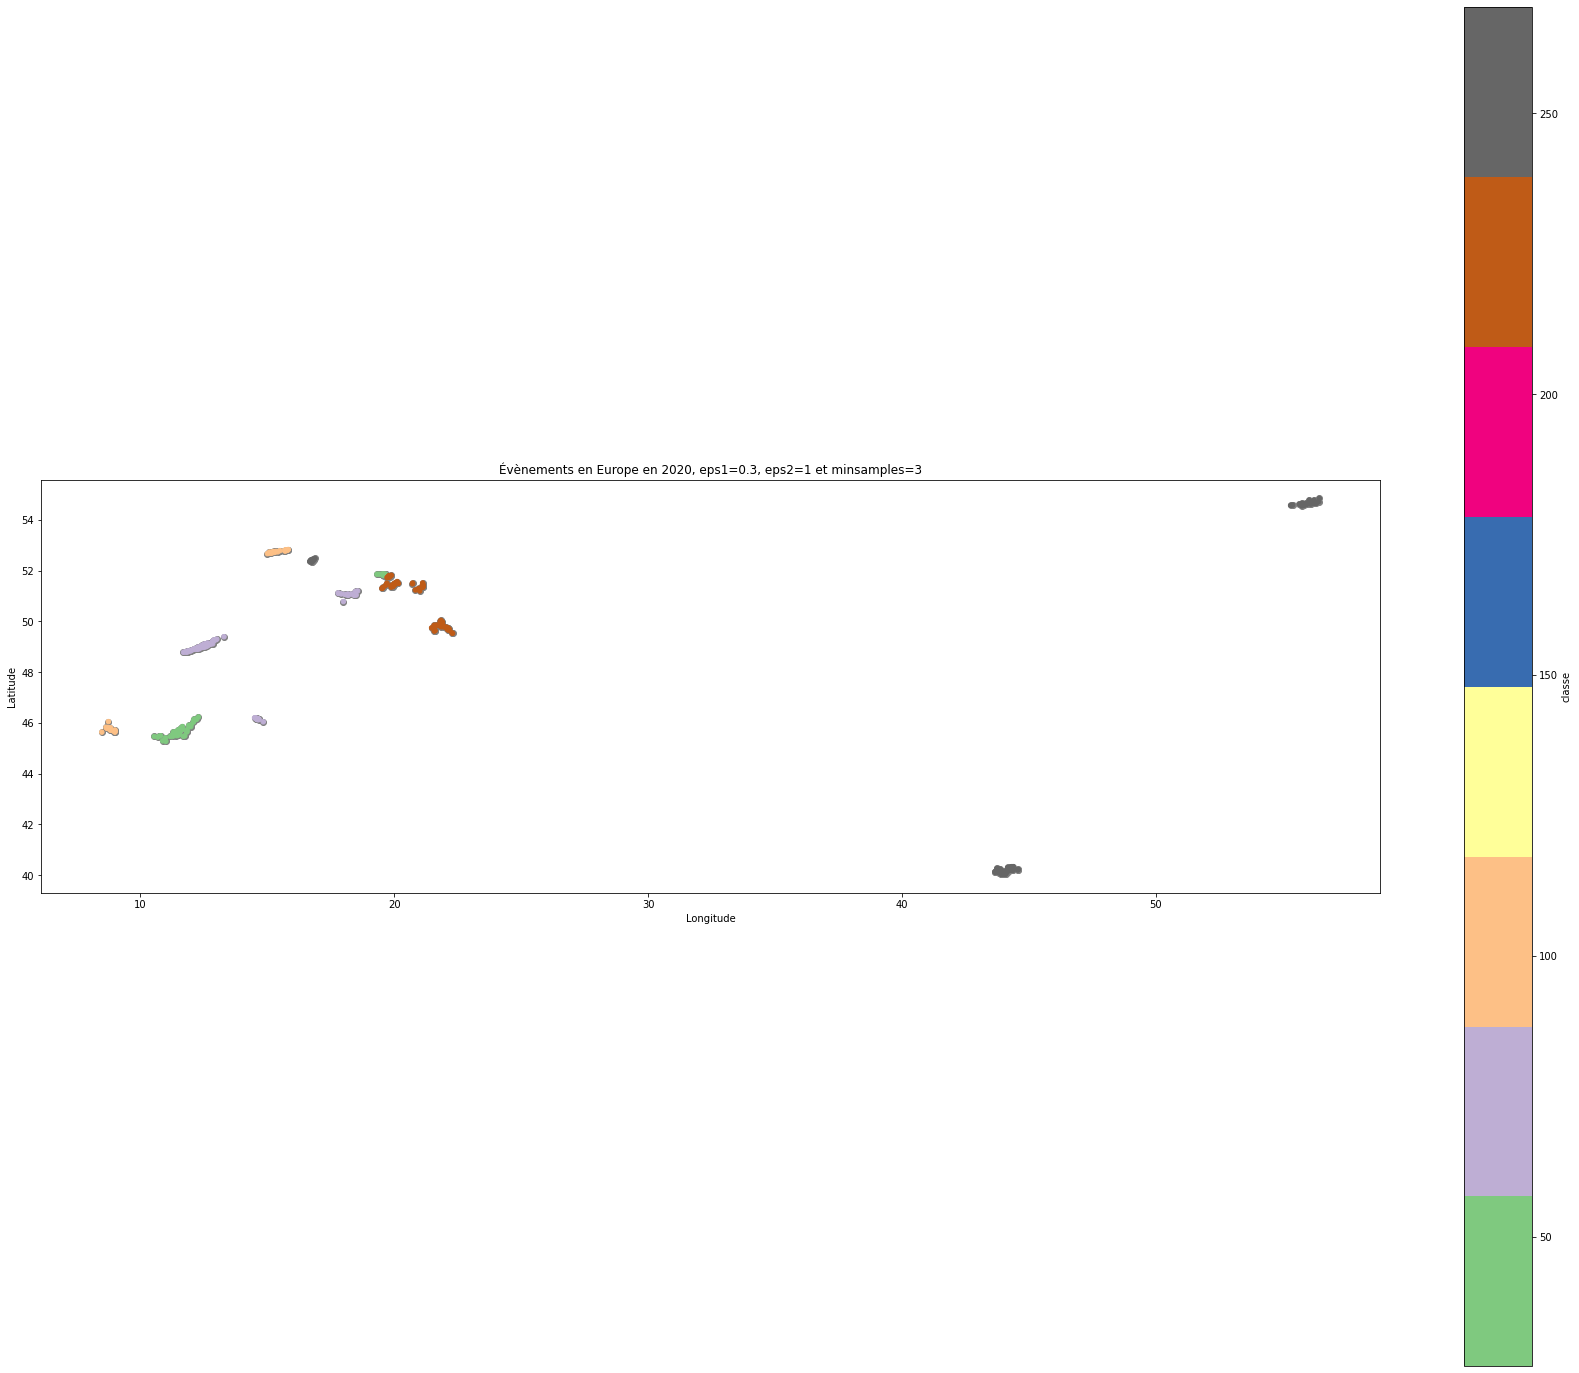

<ipython-input-30-e020573da2db>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clst['TIME_HOUR']=df_clst.apply(lambda donnee: convert_hour(donnee), axis=1)


        TIME_HOUR  LATITUDE  LONGITUDE  cluster
classe                                         
183            54        54         54       54
203            45        45         45       45
215            42        42         42       42
255            78        78         78       78
259           364       364        364      364
261            64        64         64       64
264           115       115        115      115
288            68        68         68       68
295            42        42         42       42
359            59        59         59       59


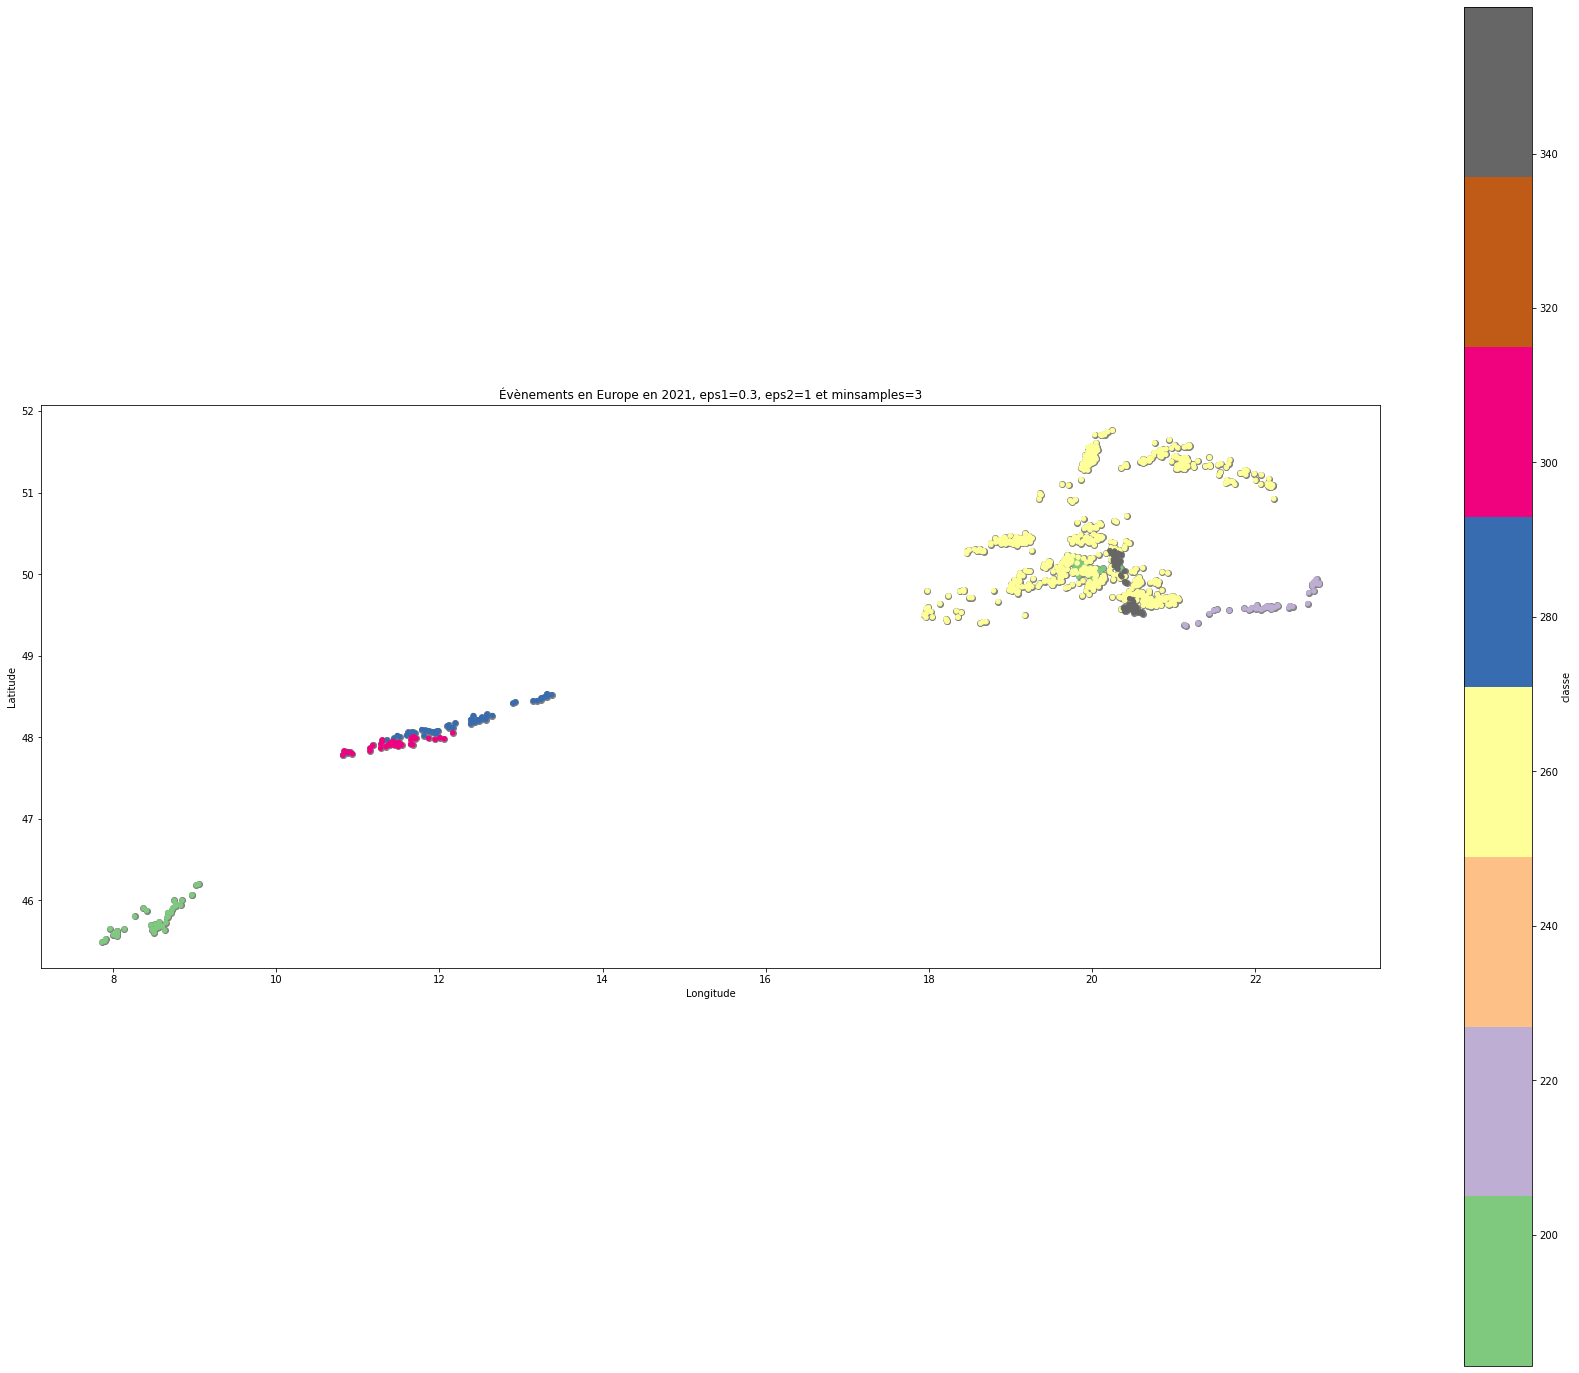

In [ ]:
for i in range(2013,2022):
    clusterise_per_year(i,0.3, 1,3)

# **Next, we want to add demographics to confront with the result of our clustering, we'll do that for France**

In [11]:
#open dataframe containg demographics in France in 2022
demog=pd.read_csv(r"/Users/hamzaab/Desktop/cours/2Ak/statap/demog.csv")
france_img=mpimg.imread(r'/Users/hamzaab/Desktop/cours/2Ak/statap/france2.png')

#open dataframe containing the hail reports as well as nearest city and the correponding population (for france only)
df2=pd.read_csv(r'/Users/hamzaab/Desktop/cours/2Ak/statap/events+demog_france.csv')

In [ ]:
# function taking into parameters year, eps1, eps2 and min_samples and plot the biggest events 
# (events with largest number of reports) as well as the demographics in france in 2020

def stdbscan_demog_fr( year, ep1, ep2, minpts):
    
    # extracting needed data
    df_clst=df[df['YEAR']==year]
    x='FR'
    df_clst=df_clst[df_clst['COUNTRY']==x]
    #connverting time into hour stamps
    df_clst['TIME_HOUR']=df_clst.apply(lambda donnee: convert_hour(donnee), axis=1)
    #maintaining needed columns only
    df_clst=df_clst.loc[:,['TIME_HOUR','LATITUDE','LONGITUDE']]
    # applying st-dbscan
    df_clst1=df_clst.copy()
    model = ST_DBSCAN(eps1=ep1, eps2=ep2,min_samples=minpts)
    model.fit(df_clst1)
    df_clst1["cluster"] = model.fit(df_clst)
    classi = model.labels
    #column containing labels
    df_clst1["classe"]=classi
    #adding a column containg the numbers of reports per class  
    k=df_clst1.groupby(['classe']).count()
    l=[]
    for i in range(len(df_clst1)):
    
        for j in range(len(k)):
            if df_clst1.iloc[i]['classe']==j-1:
                l.append(k['LONGITUDE'][df_clst1.iloc[i]['classe']])
    df_clst1['LENGTH_EVENT']=l
    
    #deleting reports contained in the trash class (-1)
    df_clst1=df_clst1[(df_clst1["classe"]>-1)]
    events= clust(df_clst1,classi)    
    #array containing the lengths of the events in order to pick the largest one only
    b=df_clst1['LENGTH_EVENT'].unique()
    b=sorted(b,reverse=True)
    d=b[0]+1
    c=b[30]-1
    df_clst1=df_clst1[(df_clst1['LENGTH_EVENT']>c)&(df_clst1['LENGTH_EVENT']<d)]
    k=k[(k['LATITUDE']>c)&(k['LATITUDE']<d)]
    print(k.to_string())
    
    #plot
    ax=demog.plot(kind="scatter", x="Longitude", y="Latitude", figsize=(60,45),s=demog['Population municipale 2020']/100, label="Population", cmap=plt.get_cmap("jet"),colorbar=True, alpha=0.4)   
    df_clst1.plot.scatter(ax=ax, x = "LONGITUDE", y = "LATITUDE", c = "classe", cmap = "tab20")
    plt.imshow(france_img, extent=[-4.47, 8.13, 42.19, 51.05], alpha=0.4)
    plt.legend(fontsize=16)    
    plt.title("Évènements en France en " + str(year) + ", eps1=" + str(ep1 ) + ", eps2=" + str(ep2 ) +" et minsamples=" +str(minpts ))
    plt.xlabel("Longitude")
    plt.ylabel("Latitude")
    plt.show()


        TIME_HOUR  LATITUDE  LONGITUDE  cluster
classe                                         
-1             96        96         96       96
 1             26        26         26       26
 2             15        15         15       15
 3              6         6          6        6
 12            19        19         19       19
 14            21        21         21       21
 15             6         6          6        6
 22            11        11         11       11
 24            17        17         17       17
 25            17        17         17       17
 36            14        14         14       14
 37            46        46         46       46
 38            21        21         21       21
 39             8         8          8        8
 40             7         7          7        7
 42            18        18         18       18
 43            33        33         33       33
 46             7         7          7        7
 47           110       110        110  

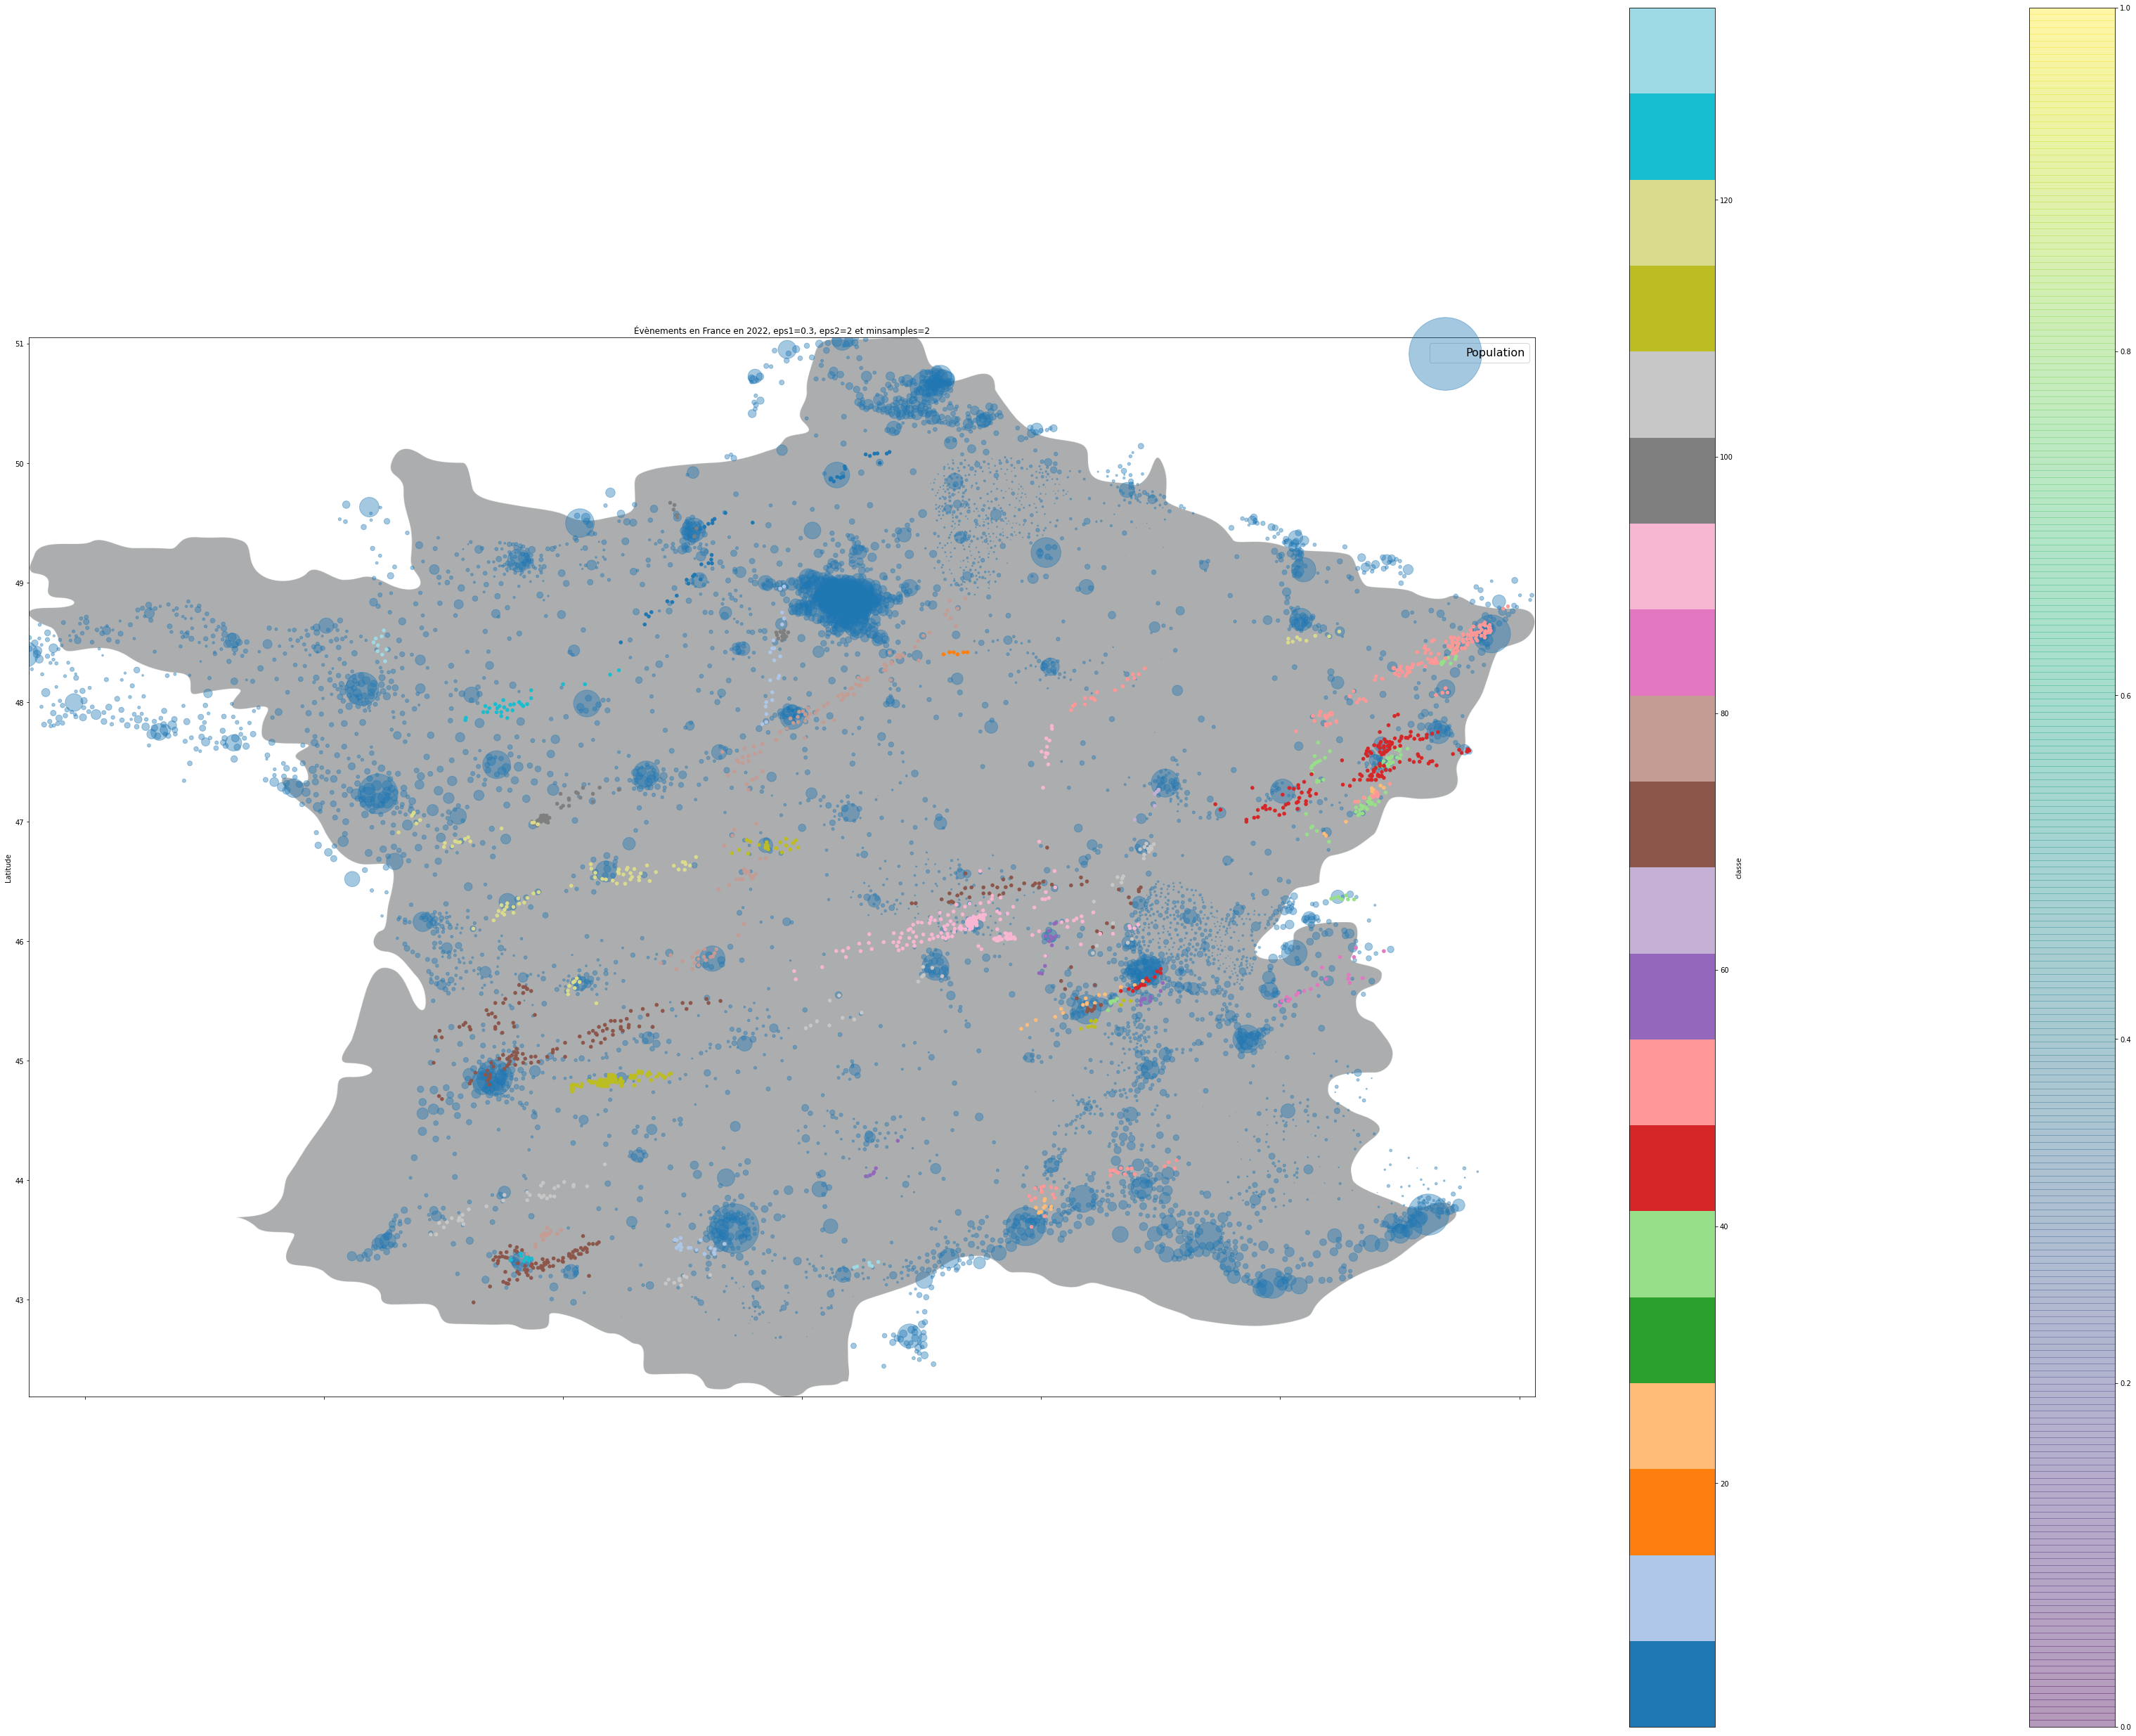

In [ ]:

stdbscan_demog_fr(2022, 0.3, 2, 2)

In [ ]:
# function taking into parameters year, eps1, eps2 and min_samples and plot the biggest events 
# (events with largest number of reports) as well as the demographics in france in 2020

def stdbscan_demog_fr2( ep1, ep2, minpts,year):
    
    # extracting needed data
    df_clst=df2[df2['YEAR']==year]
    #connverting time into hour stamps
    df_clst['TIME_HOUR']=df_clst.apply(lambda donnee: convert_hour(donnee), axis=1)
    #maintaining needed columns only
    df_st=df_clst.loc[:,['TIME_HOUR','LATITUDE','LONGITUDE','Population municipale 2020']]
    df_clst=df_clst.loc[:,['TIME_HOUR','LATITUDE','LONGITUDE']]
    # applying st-dbscan
    df_clst1=df_clst.copy()
    model = ST_DBSCAN(eps1=ep1, eps2=ep2,min_samples=minpts)
    model.fit(df_clst1)
    df_clst1["cluster"] = model.fit(df_clst)
    classi = model.labels
    #column containing labels
    df_clst1["classe"]=classi
    #adding a column containg the numbers of reports per class    
    k=df_clst1.groupby(['classe']).count()
    l=[]
    for i in range(len(df_clst1)):
    
        for j in range(len(k)):
            if df_clst1.iloc[i]['classe']==j-1:
                l.append(k['LONGITUDE'][df_clst1.iloc[i]['classe']])
    df_clst1['LENGTH_EVENT']=l
    #deleting trash class 
    df_clst1=df_clst1[(df_clst1["classe"]>-1)]
    events= clust(df_clst1,classi)
    #we merge df_clst1 and df_st in order to have a dataframe with population 
    df_clst2=pd.merge(df_clst1, df_st, on="TIME_HOUR", how="left")
    #keeping longest tracks only
    b=df_clst2['LENGTH_EVENT'].unique()
    b=sorted(b,reverse=True)
    d=b[0]+1
    c=b[20]-1
    df_clst2=df_clst2[(df_clst2['LENGTH_EVENT']>c)&(df_clst2['LENGTH_EVENT']<d)]
    k=k[(k['LATITUDE']>c)&(k['LATITUDE']<d)]
    print(k.to_string())

    #plot
    ax=df_clst2.plot(kind="scatter", x="LONGITUDE_x", y="LATITUDE_x", figsize=(60,45),s=df_clst2['Population municipale 2020']/100, label="Population",c='classe', cmap=plt.get_cmap("jet"),colorbar=True, alpha=0.4)   
    df_clst1.plot.scatter(ax=ax, x = "LONGITUDE", y = "LATITUDE", c = "classe", cmap = "tab20")
    plt.imshow(france_img, extent=[-4.47, 8.13, 42.19, 51.05], alpha=0.4)
    plt.legend(fontsize=16)    
    plt.title("Évènements en FR" + " en " + str(year) + ", eps1=" + str(ep1 ) + ", eps2=" + str(ep2 ) +" et minsamples=" +str(minpts ))
    plt.xlabel("Longitude")
    plt.ylabel("Latitude")
    plt.show()

<ipython-input-39-d6dca115ba95>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clst['TIME_HOUR']=df_clst.apply(lambda donnee: convert_hour(donnee), axis=1)


        TIME_HOUR  LATITUDE  LONGITUDE  cluster
classe                                         
2              20        20         20       20
9              18        18         18       18
10             21        21         21       21
18             17        17         17       17
19             17        17         17       17
23             46        46         46       46
24             21        21         21       21
27             21        21         21       21
28             36        36         36       36
31            110       110        110      110
32            134       134        134      134
49             41        41         41       41
50             22        22         22       22
51            113       113        113      113
52             17        17         17       17
53             59        59         59       59
54             98        98         98       98
56             18        18         18       18
62             21        21         21  

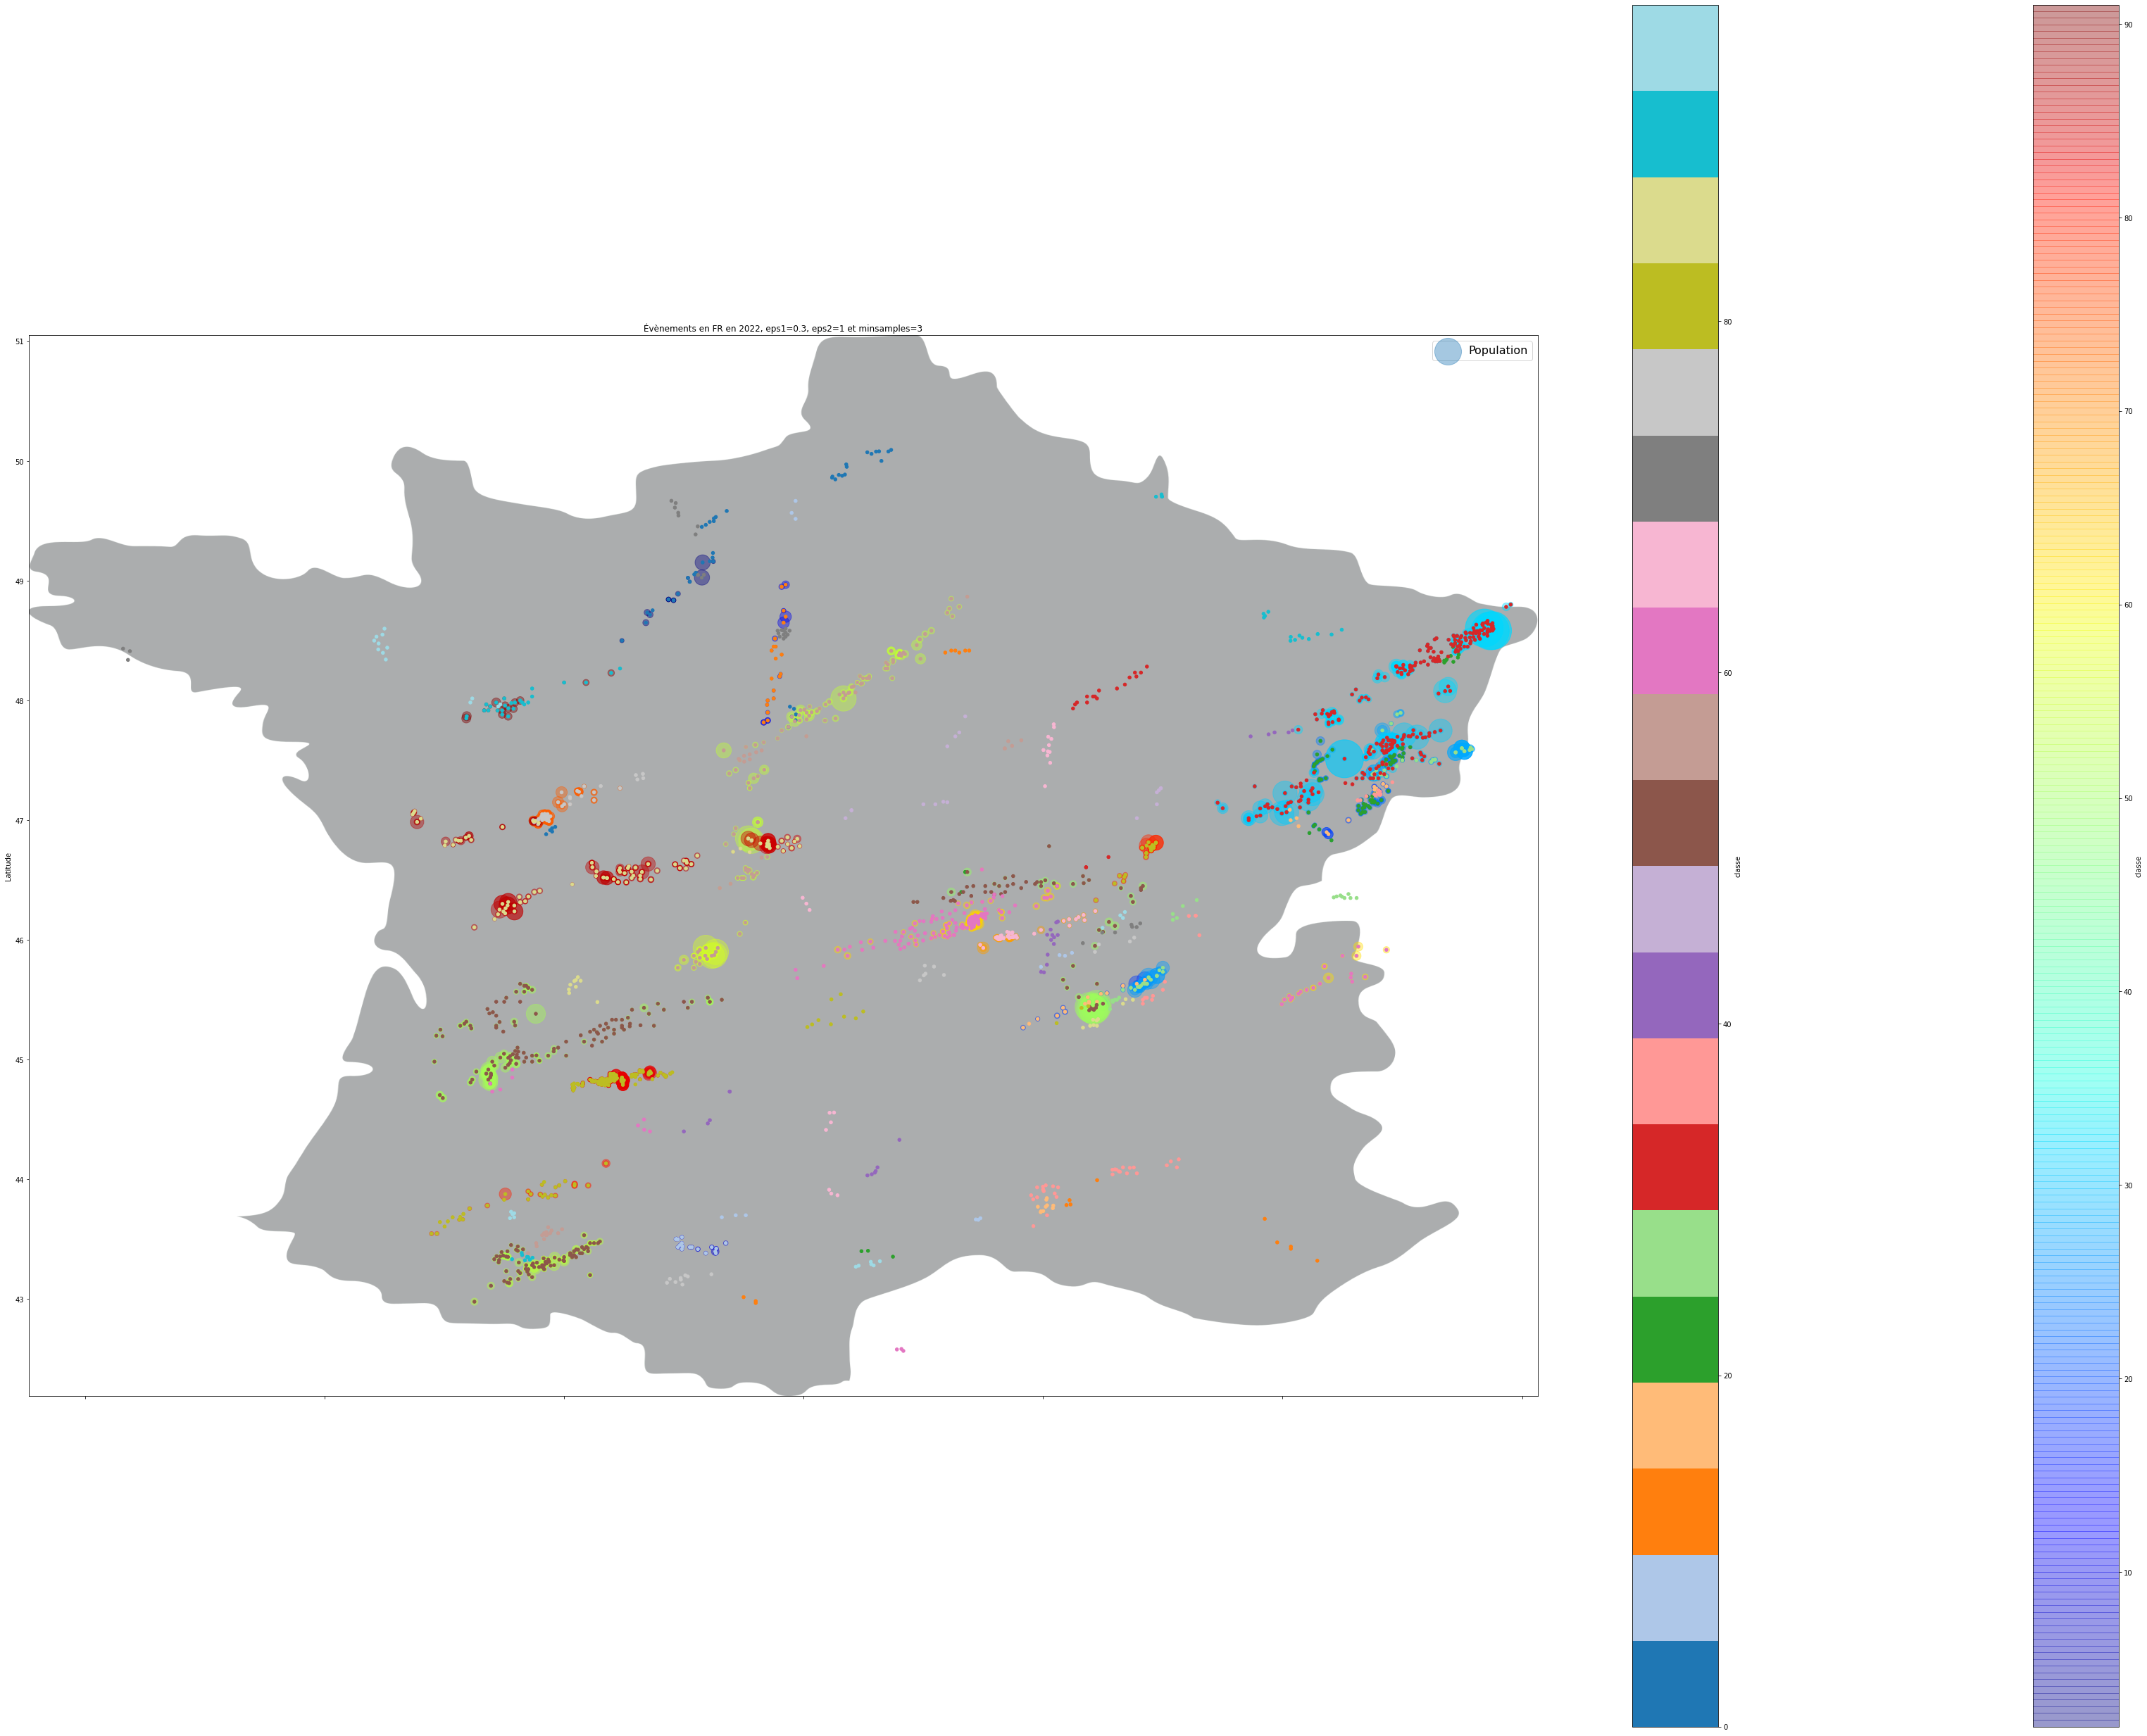

In [ ]:
stdbscan_demog_fr2( 0.3, 1, 3,2022)

In [ ]:
#defining a function taking into parameter the country, year, eps1, eps2, min_samples and the n the position 
#of the track to plot adding an intensity bar corresponding to the time of the reports and demographhics

def stdbscan_demog_fr3(year, ep1, ep2, minpts, n):
    # extracting needed data
    df_clst=df2[df2['YEAR']==year]
    #connverting time into hour stamps
    df_clst['TIME_HOUR']=df_clst.apply(lambda donnee: convert_hour(donnee), axis=1)
    #maintaining needed columns only
    df_st=df_clst.loc[:,['TIME_HOUR','LATITUDE','LONGITUDE','Population municipale 2020']]
    df_clst=df_clst.loc[:,['TIME_HOUR','LATITUDE','LONGITUDE']]
    # applying st-dbscan
    df_clst1=df_clst.copy()
    model = ST_DBSCAN(eps1=ep1, eps2=ep2,min_samples=minpts)
    model.fit(df_clst1)
    df_clst1["cluster"] = model.fit(df_clst)
    classi = model.labels
    #column containing labels
    df_clst1["classe"]=classi
    #adding a column containg the numbers of reports per class    
    k=df_clst1.groupby(['classe']).count()
    l=[]
    for i in range(len(df_clst1)):
    
        for j in range(len(k)):
            if df_clst1.iloc[i]['classe']==j-1:
                l.append(k['LONGITUDE'][df_clst1.iloc[i]['classe']])
    df_clst1['LENGTH_EVENT']=l
    #deleting trash class 
    df_clst1=df_clst1[(df_clst1["classe"]>-1)]
    events= clust(df_clst1,classi)
    #we merge df_clst1 and df_st in order to have a dataframe with population 
    df_clst2=pd.merge(df_clst1, df_st, on="TIME_HOUR", how="left")
    #we plot the n-th longest track 
    b=df_clst2['LENGTH_EVENT'].unique()
    b=sorted(b,reverse=True)
    d=b[n]+1
    c=b[n+1]
    df_clst2=df_clst2[(df_clst2['LENGTH_EVENT']>c)&(df_clst2['LENGTH_EVENT']<d)]
    k=k[(k['LATITUDE']>c)&(k['LATITUDE']<d)]
    print(k.to_string())

    #plot
    geometry = [Point(xy) for xy in zip(df_clst2['LONGITUDE_x'], df_clst2['LATITUDE_x'])]
    gdf = GeoDataFrame(df_clst2, geometry=geometry)      
    ax = gdf.plot(figsize=(30,25), color="gray")
    df_clst2.plot.scatter(ax=ax, x = "LONGITUDE_x", y = "LATITUDE_x",s=df_clst2['Population municipale 2020']/100, label="Population", c = "TIME_HOUR", cmap = plt.cm.jet,colorbar=True, alpha=0.4)
    plt.legend(fontsize=16)    
    plt.title("Évènements en FR" + " en " + str(year) + ", eps1=" + str(ep1 ) + ", eps2=" + str(ep2 ) +" et minsamples=" +str(minpts ))
    plt.xlabel("Longitude")
    plt.ylabel("Latitude")
    plt.show()

<ipython-input-35-bf8f5fb22b34>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clst['TIME_HOUR']=df_clst.apply(lambda donnee: convert_hour(donnee), axis=1)


        TIME_HOUR  LATITUDE  LONGITUDE  cluster
classe                                         
63            136       136        136      136


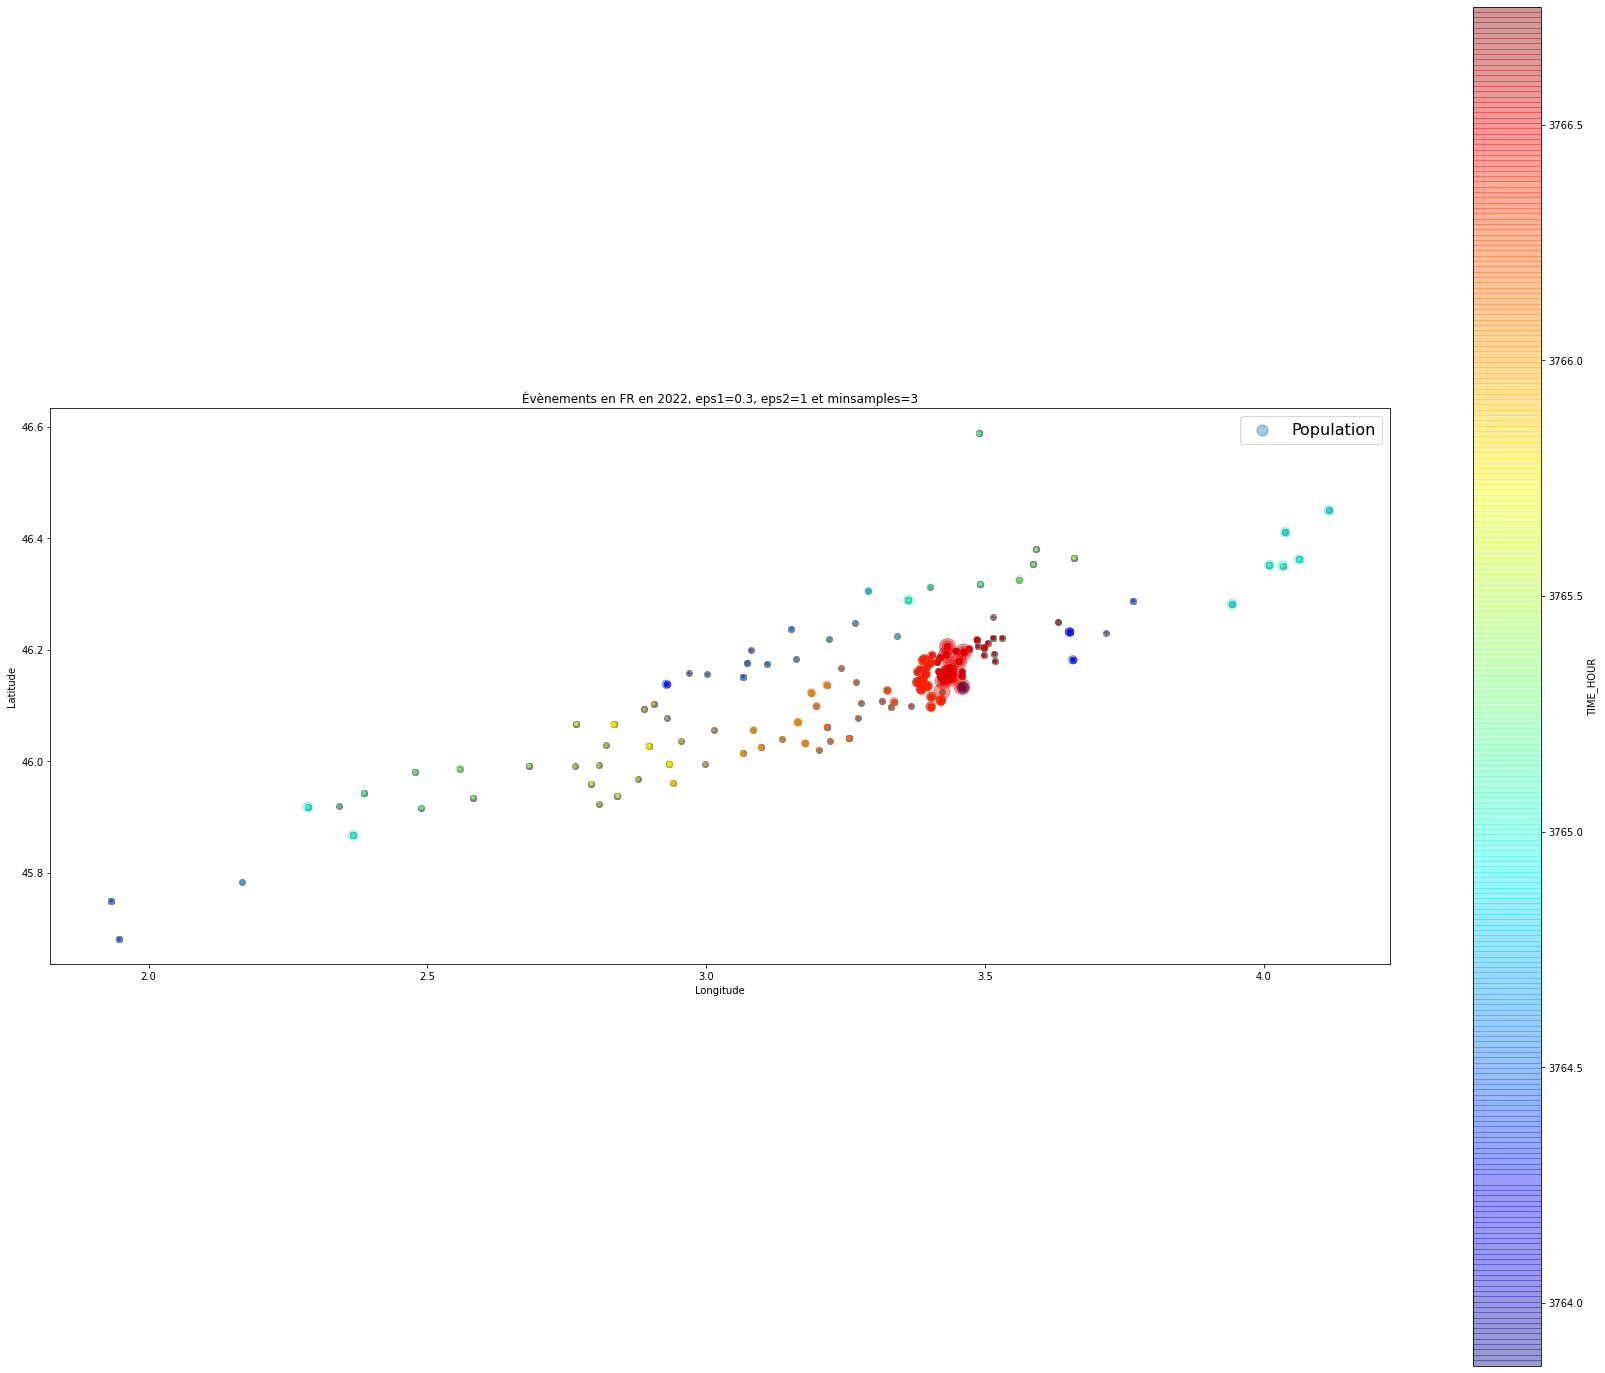

<ipython-input-35-bf8f5fb22b34>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clst['TIME_HOUR']=df_clst.apply(lambda donnee: convert_hour(donnee), axis=1)


        TIME_HOUR  LATITUDE  LONGITUDE  cluster
classe                                         
32            134       134        134      134


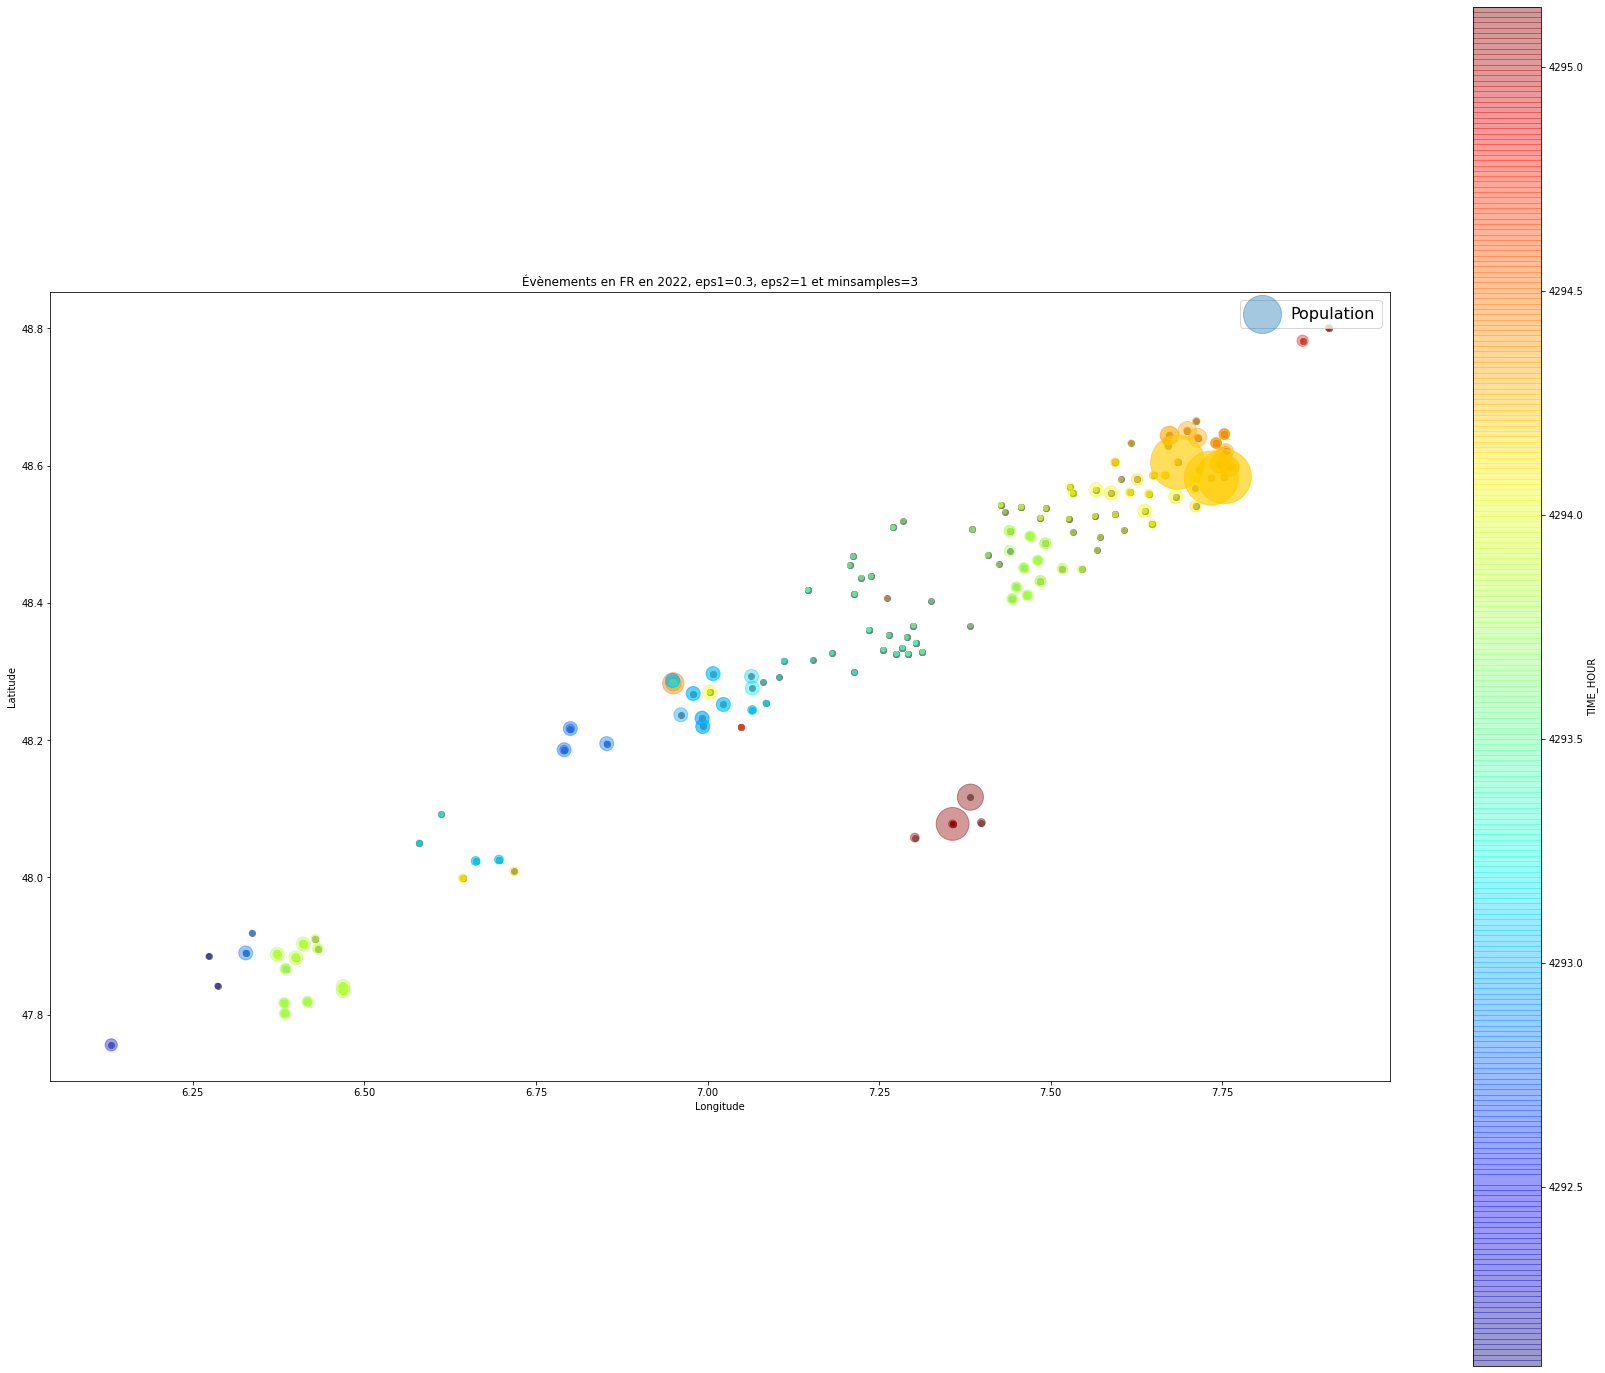

<ipython-input-35-bf8f5fb22b34>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clst['TIME_HOUR']=df_clst.apply(lambda donnee: convert_hour(donnee), axis=1)


        TIME_HOUR  LATITUDE  LONGITUDE  cluster
classe                                         
83            117       117        117      117


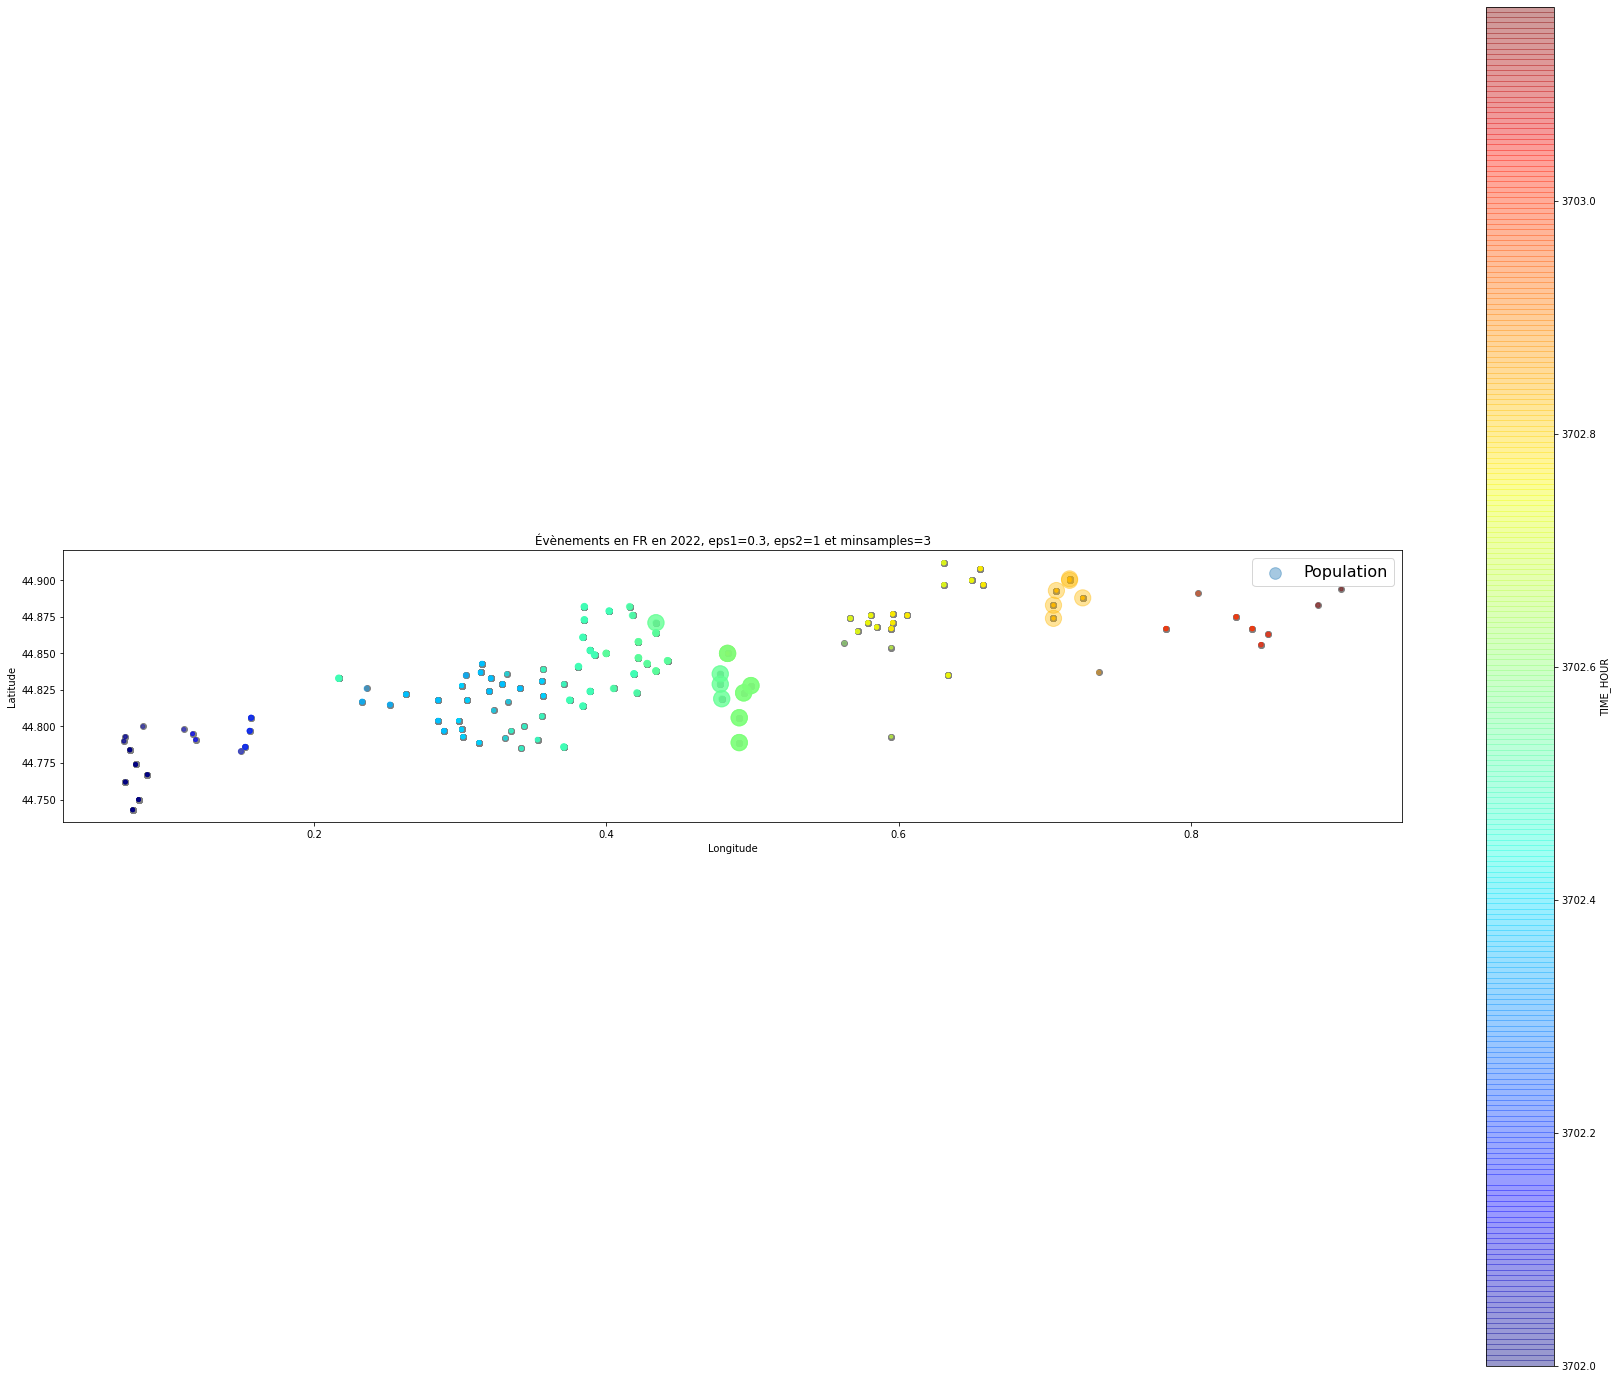

<ipython-input-35-bf8f5fb22b34>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clst['TIME_HOUR']=df_clst.apply(lambda donnee: convert_hour(donnee), axis=1)


        TIME_HOUR  LATITUDE  LONGITUDE  cluster
classe                                         
51            113       113        113      113


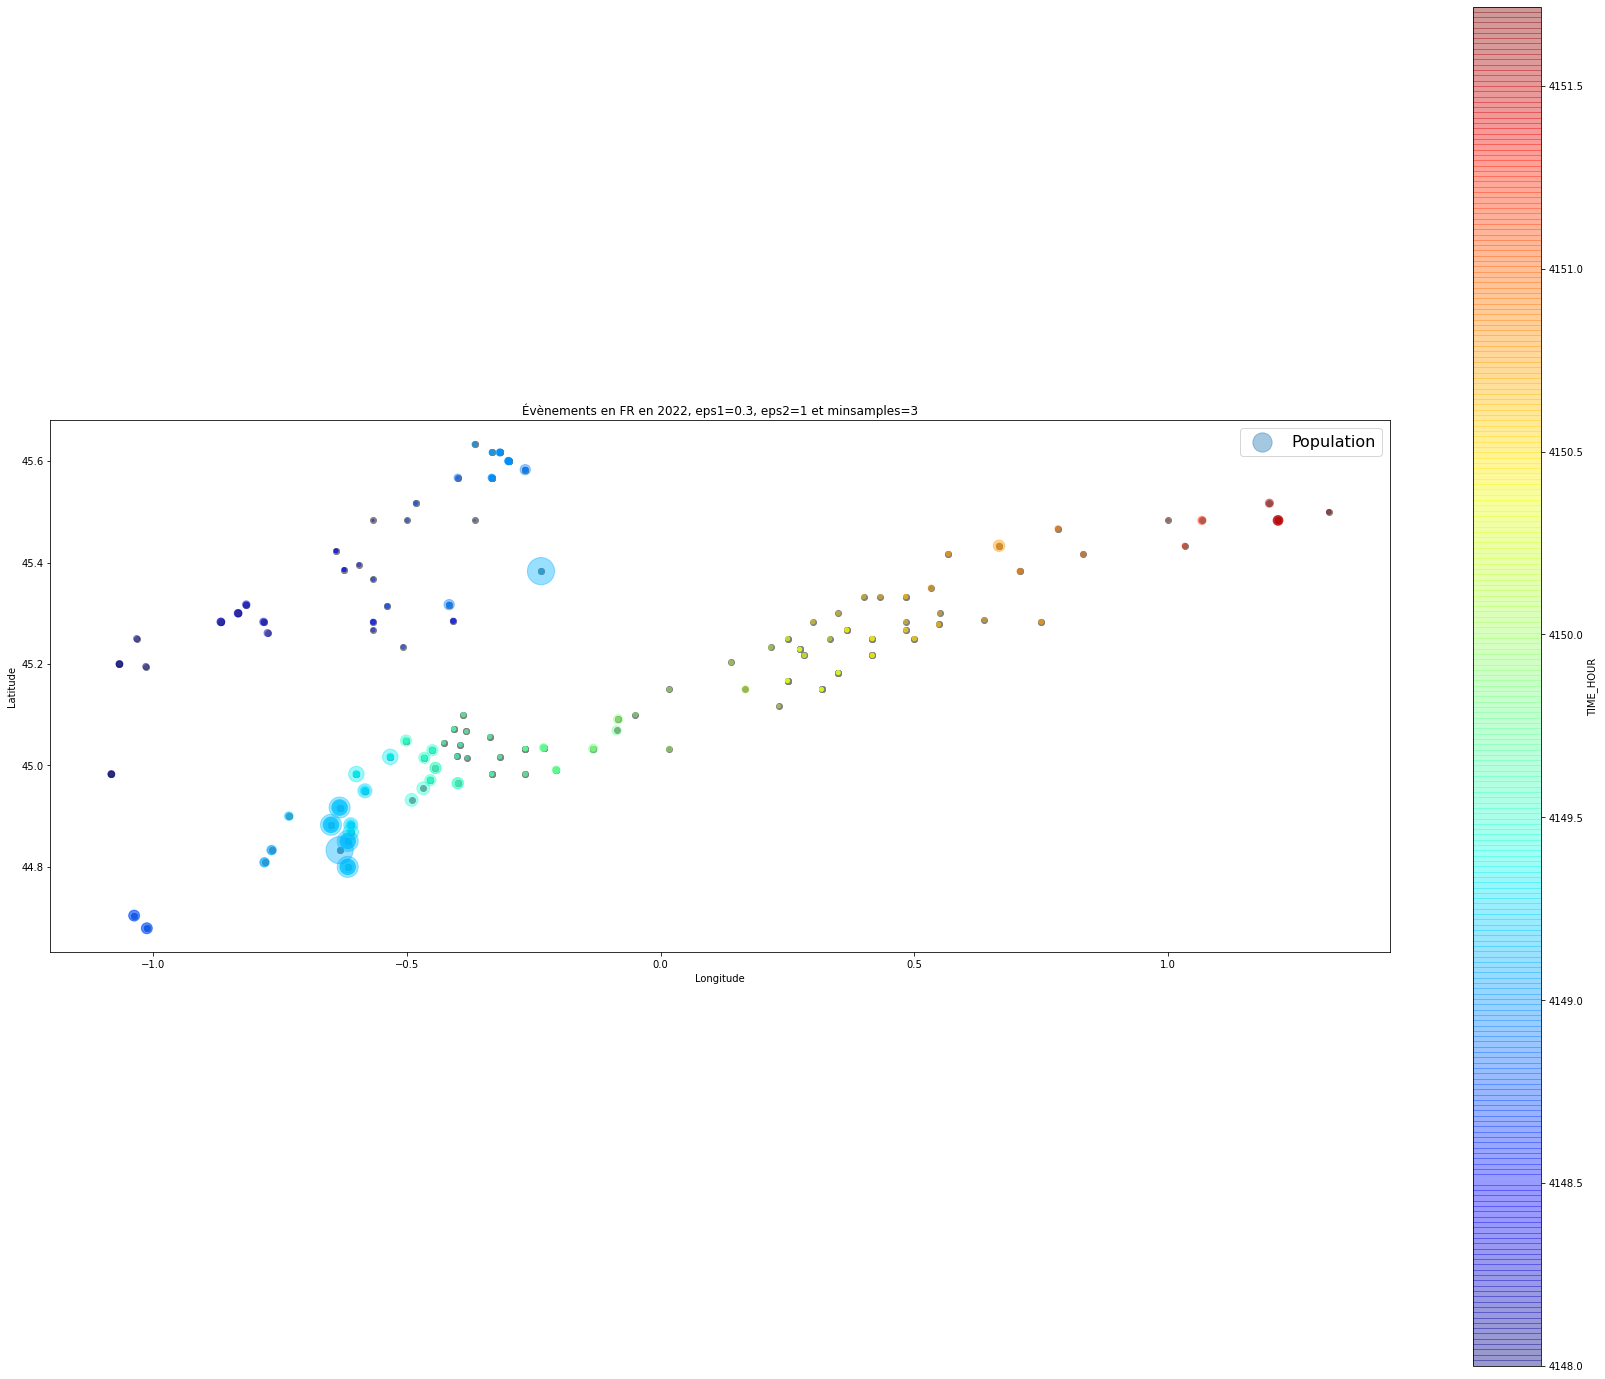

<ipython-input-35-bf8f5fb22b34>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clst['TIME_HOUR']=df_clst.apply(lambda donnee: convert_hour(donnee), axis=1)


        TIME_HOUR  LATITUDE  LONGITUDE  cluster
classe                                         
31            110       110        110      110


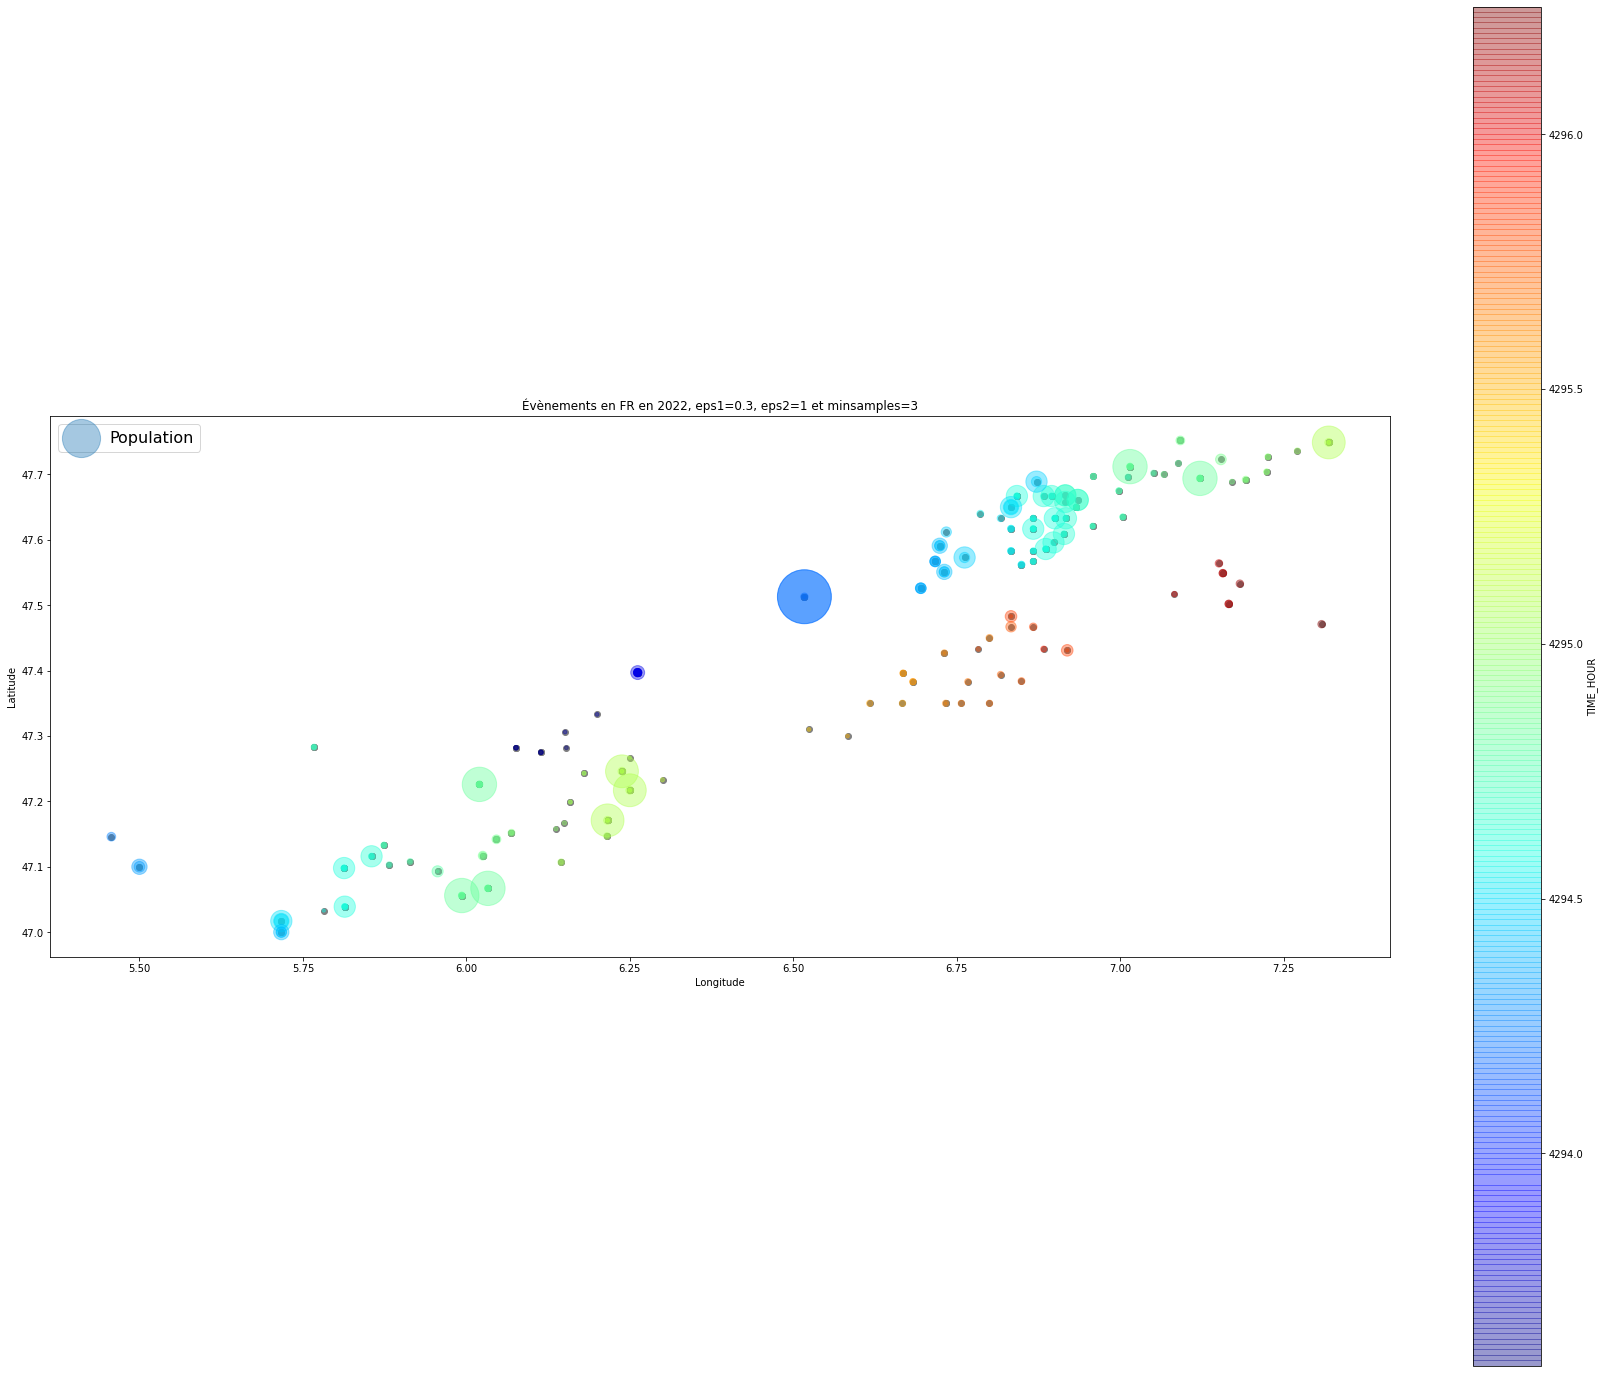

<ipython-input-35-bf8f5fb22b34>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clst['TIME_HOUR']=df_clst.apply(lambda donnee: convert_hour(donnee), axis=1)


        TIME_HOUR  LATITUDE  LONGITUDE  cluster
classe                                         
54             98        98         98       98


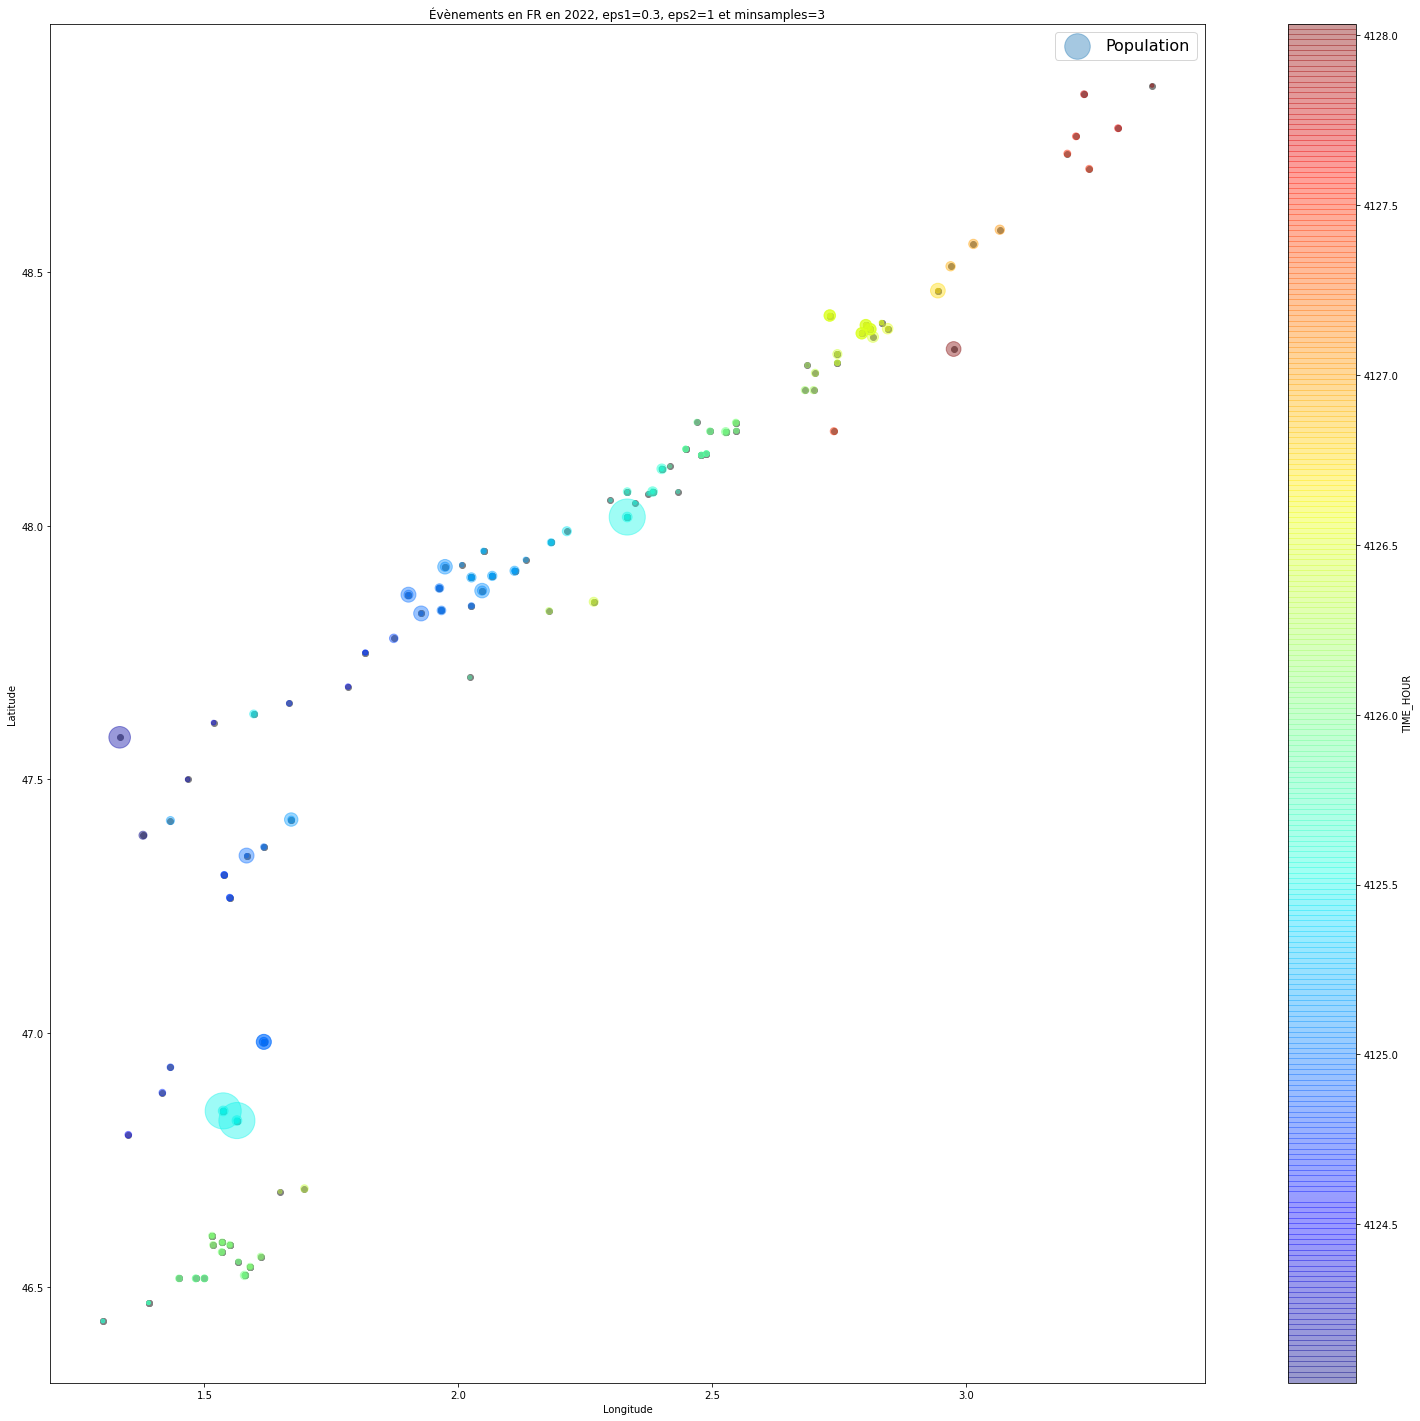

<ipython-input-35-bf8f5fb22b34>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clst['TIME_HOUR']=df_clst.apply(lambda donnee: convert_hour(donnee), axis=1)


        TIME_HOUR  LATITUDE  LONGITUDE  cluster
classe                                         
53             59        59         59       59


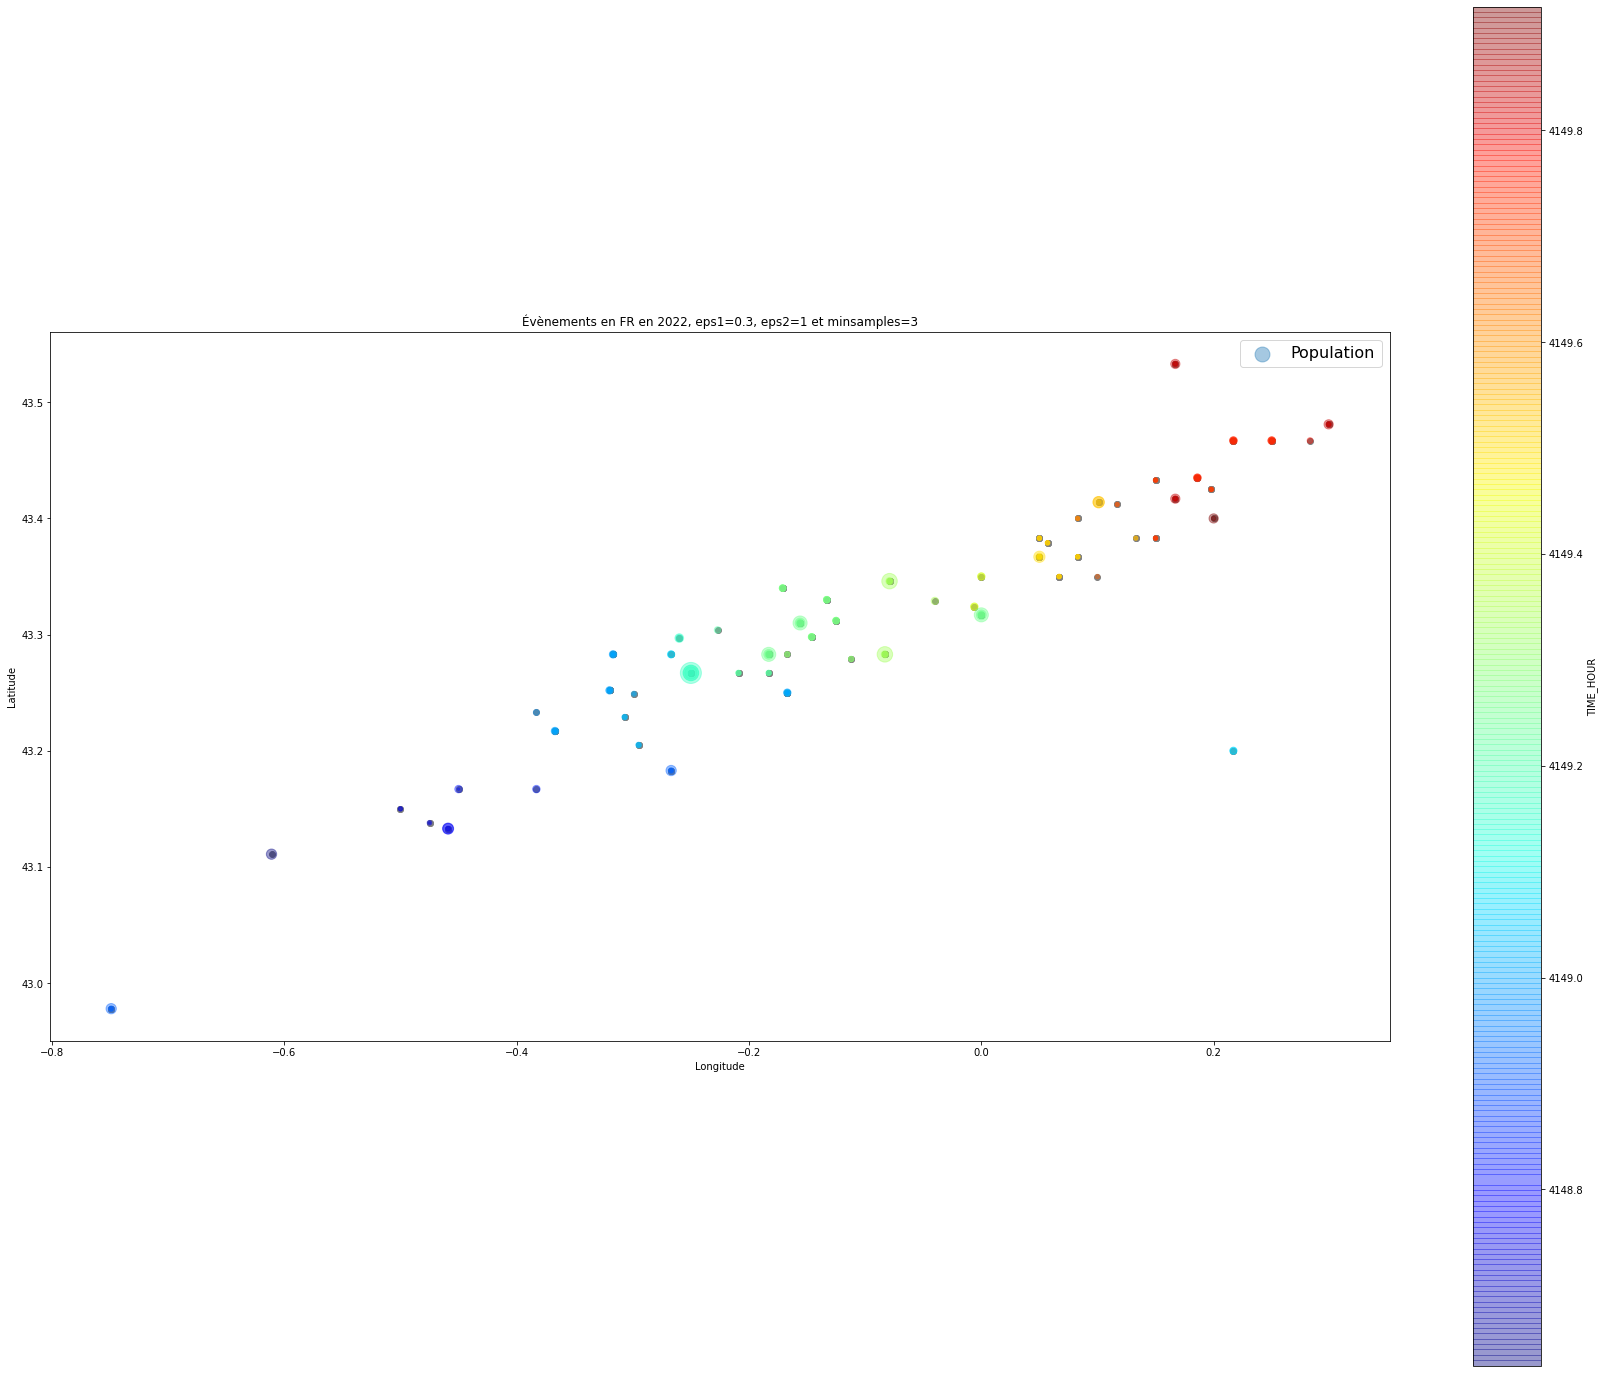

<ipython-input-35-bf8f5fb22b34>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clst['TIME_HOUR']=df_clst.apply(lambda donnee: convert_hour(donnee), axis=1)


        TIME_HOUR  LATITUDE  LONGITUDE  cluster
classe                                         
86             54        54         54       54


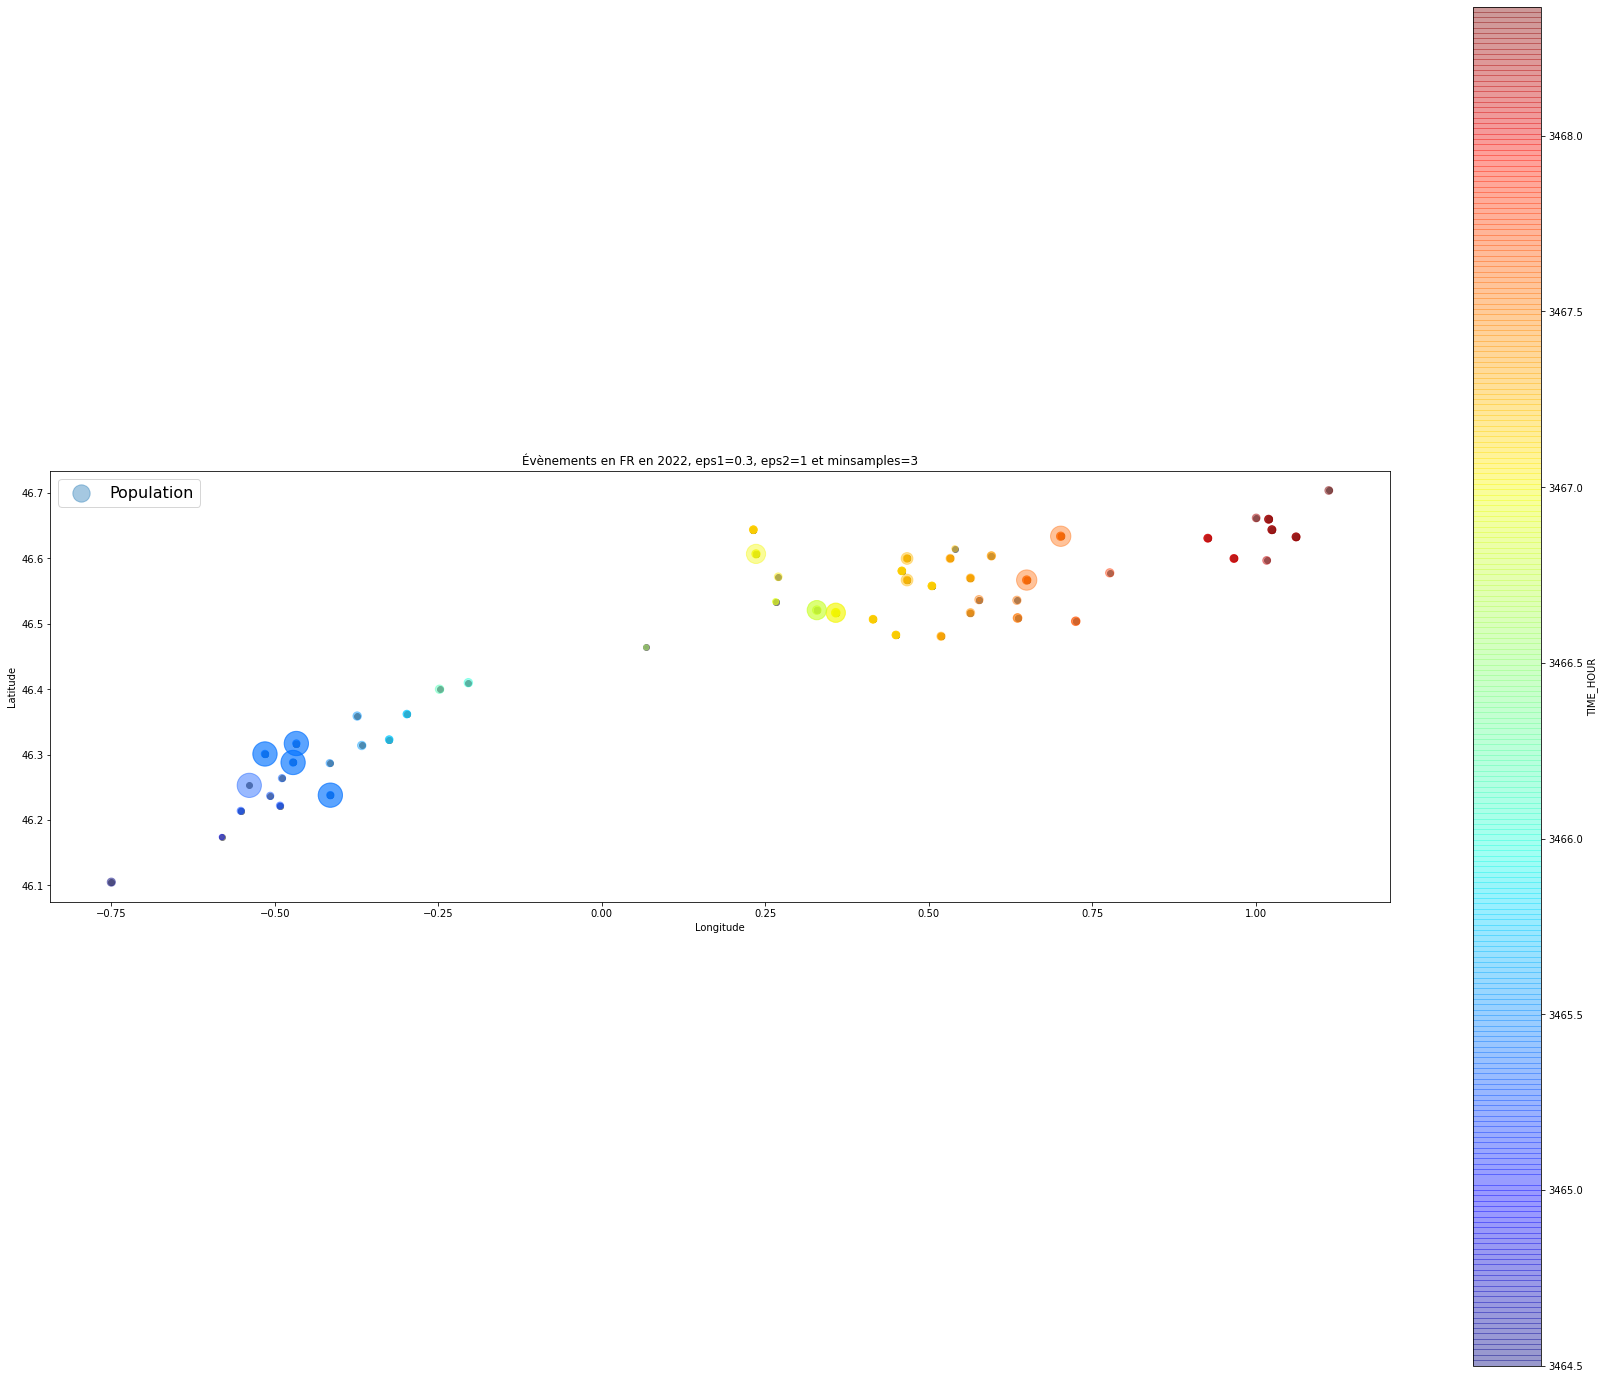

<ipython-input-35-bf8f5fb22b34>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clst['TIME_HOUR']=df_clst.apply(lambda donnee: convert_hour(donnee), axis=1)


        TIME_HOUR  LATITUDE  LONGITUDE  cluster
classe                                         
23             46        46         46       46


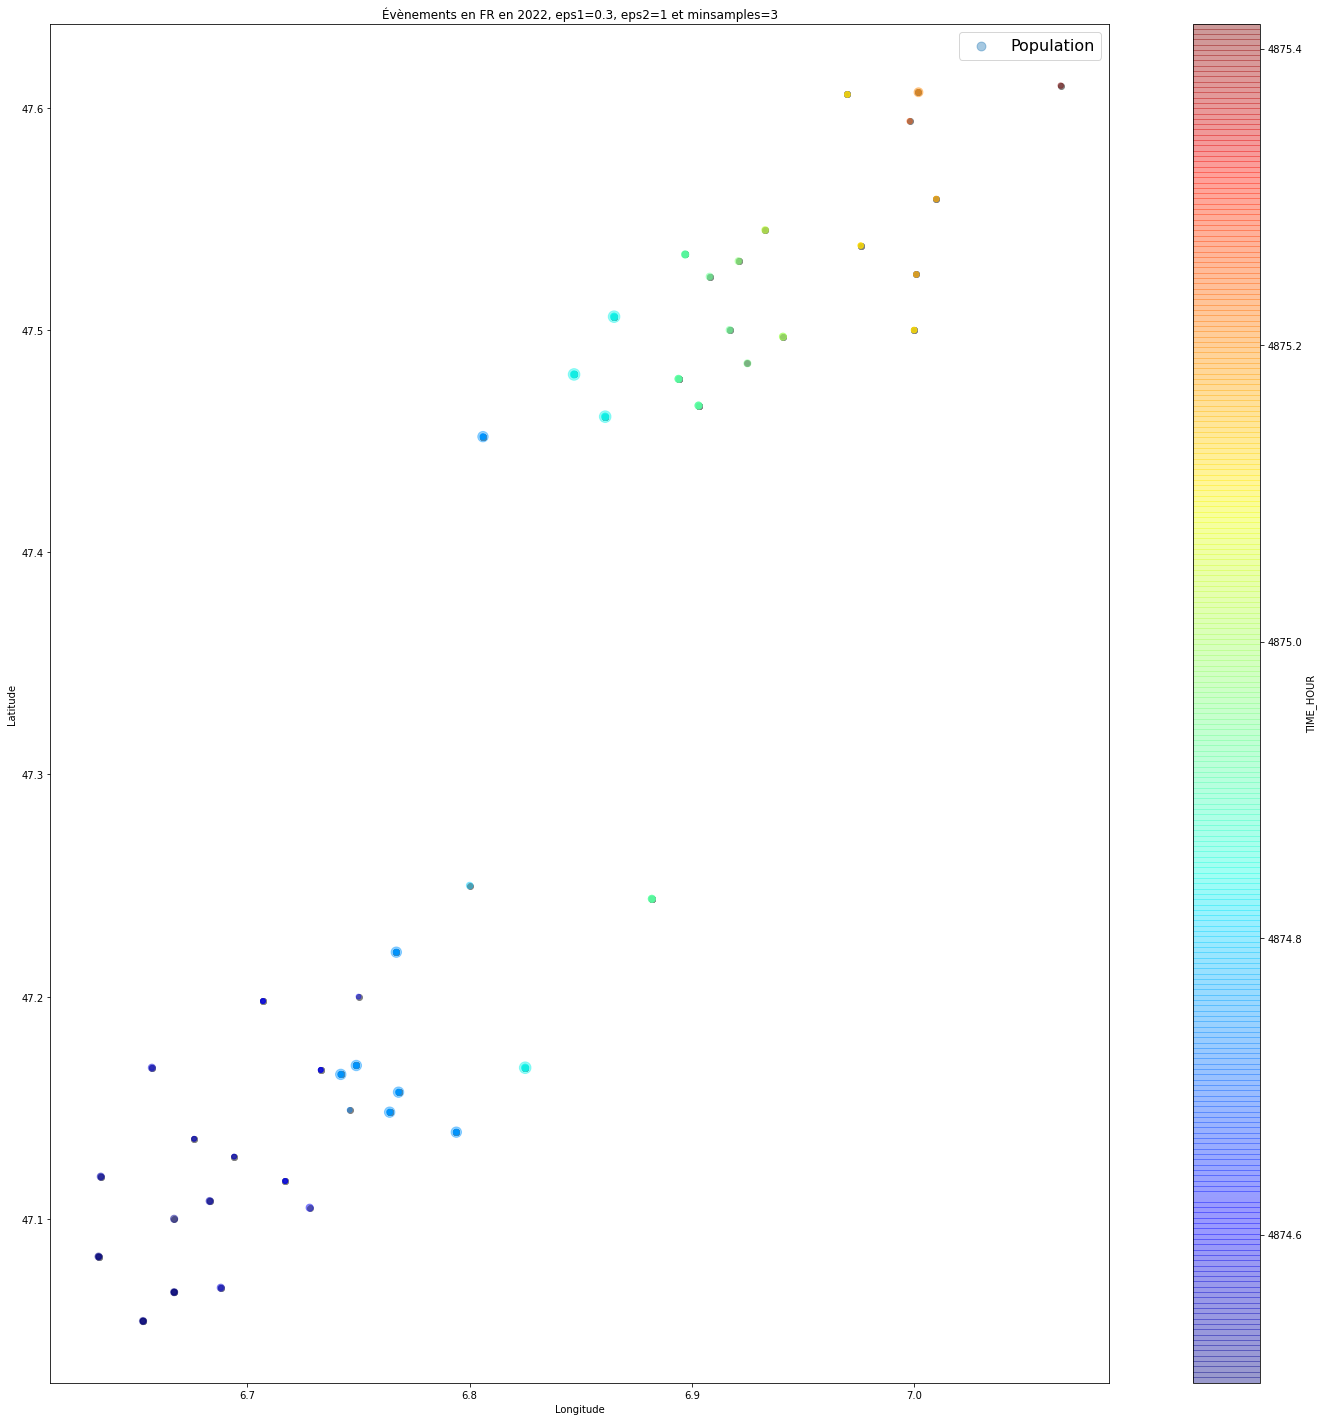

<ipython-input-35-bf8f5fb22b34>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clst['TIME_HOUR']=df_clst.apply(lambda donnee: convert_hour(donnee), axis=1)


        TIME_HOUR  LATITUDE  LONGITUDE  cluster
classe                                         
49             41        41         41       41


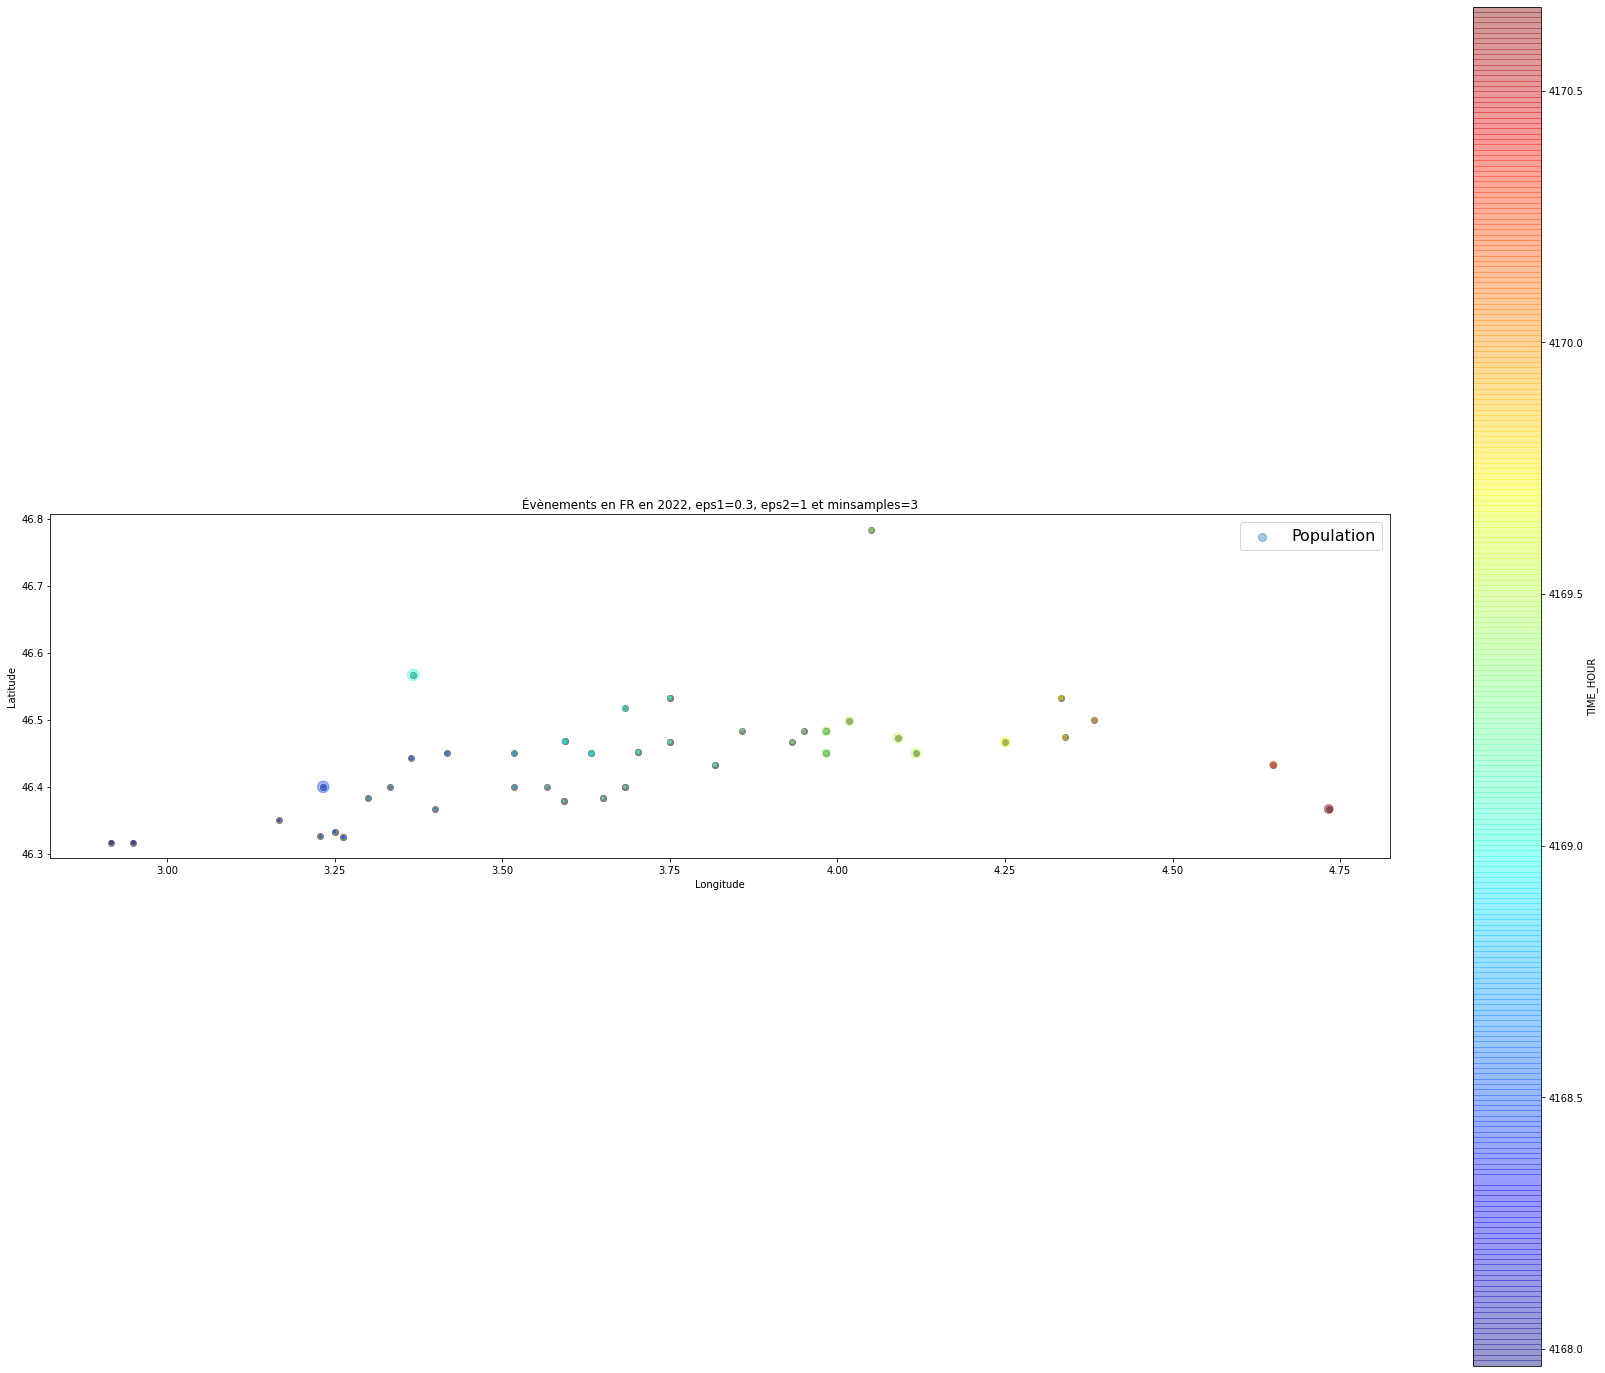

In [ ]:
for i in range(10):
  stdbscan_demog_fr3(2022,0.3, 2, 3,i)

In [ ]:
#defining a function taking into parameter the country, year, eps1, eps2, min_samples and the n the position 
#of the track to plot adding an intensity bar corresponding to the time of the reports and demographhics

def stdbscan_demog_fr4(year, ep1, ep2, minpts, n):
    # extracting needed data
    df_clst=df2[df2['YEAR']==year]
    #connverting time into hour stamps
    df_clst['TIME_HOUR']=df_clst.apply(lambda donnee: convert_hour(donnee), axis=1)
    #maintaining needed columns only
    df_st=df_clst.loc[:,['TIME_HOUR','LATITUDE','LONGITUDE','Population municipale 2020','NEAREST_CITY']]
    df_clst=df_clst.loc[:,['TIME_HOUR','LATITUDE','LONGITUDE']]
    # applying st-dbscan
    df_clst1=df_clst.copy()
    model = ST_DBSCAN(eps1=ep1, eps2=ep2,min_samples=minpts)
    model.fit(df_clst1)
    df_clst1["cluster"] = model.fit(df_clst)
    classi = model.labels
    #column containing labels
    df_clst1["classe"]=classi
    #adding a column containg the numbers of reports per class    
    k=df_clst1.groupby(['classe']).count()
    l=[]
    for i in range(len(df_clst1)):
    
        for j in range(len(k)):
            if df_clst1.iloc[i]['classe']==j-1:
                l.append(k['LONGITUDE'][df_clst1.iloc[i]['classe']])
    df_clst1['LENGTH_EVENT']=l
    #deleting trash class 
    df_clst1=df_clst1[(df_clst1["classe"]>-1)]
    events= clust(df_clst1,classi)
    #we merge df_clst1 and df_st in order to have a dataframe with population 
    df_clst2=pd.merge(df_clst1, df_st, on="TIME_HOUR", how="left")
    #we plot the n-th longest track 
    b=df_clst2['LENGTH_EVENT'].unique()
    b=sorted(b,reverse=True)
    d=b[n]+1
    c=b[n+1]
    df_clst2=df_clst2[(df_clst2['LENGTH_EVENT']>c)&(df_clst2['LENGTH_EVENT']<d)]
    k=k[(k['LATITUDE']>c)&(k['LATITUDE']<d)]
    print(k.to_string())
    #creating a list containing the nearest cities to the track
    city=df_clst2['NEAREST_CITY'].unique()
    dem=demog[demog['Libelle'].isin(city)]

    #plot 
    ax=dem.plot(kind="scatter", x="Longitude", y="Latitude", figsize=(30,25),s=dem['Population municipale 2020']/100, label="Population", cmap=plt.get_cmap("jet"),colorbar=True, alpha=0.4)   
    df_clst2.plot.scatter(ax=ax, x = "LONGITUDE_x", y = "LATITUDE_x", s = 200, c = "TIME_HOUR", cmap = plt.cm.jet)
    plt.legend(fontsize=16)    
    plt.title("Évènements en France en " + str(year) + ", eps1=" + str(ep1 ) + ", eps2=" + str(ep2 ) +" et minsamples=" +str(minpts ))
    plt.xlabel("Longitude")
    plt.ylabel("Latitude")
    plt.show()


<ipython-input-37-4213b9b02d9f>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clst['TIME_HOUR']=df_clst.apply(lambda donnee: convert_hour(donnee), axis=1)


        TIME_HOUR  LATITUDE  LONGITUDE  cluster
classe                                         
58            187       187        187      187


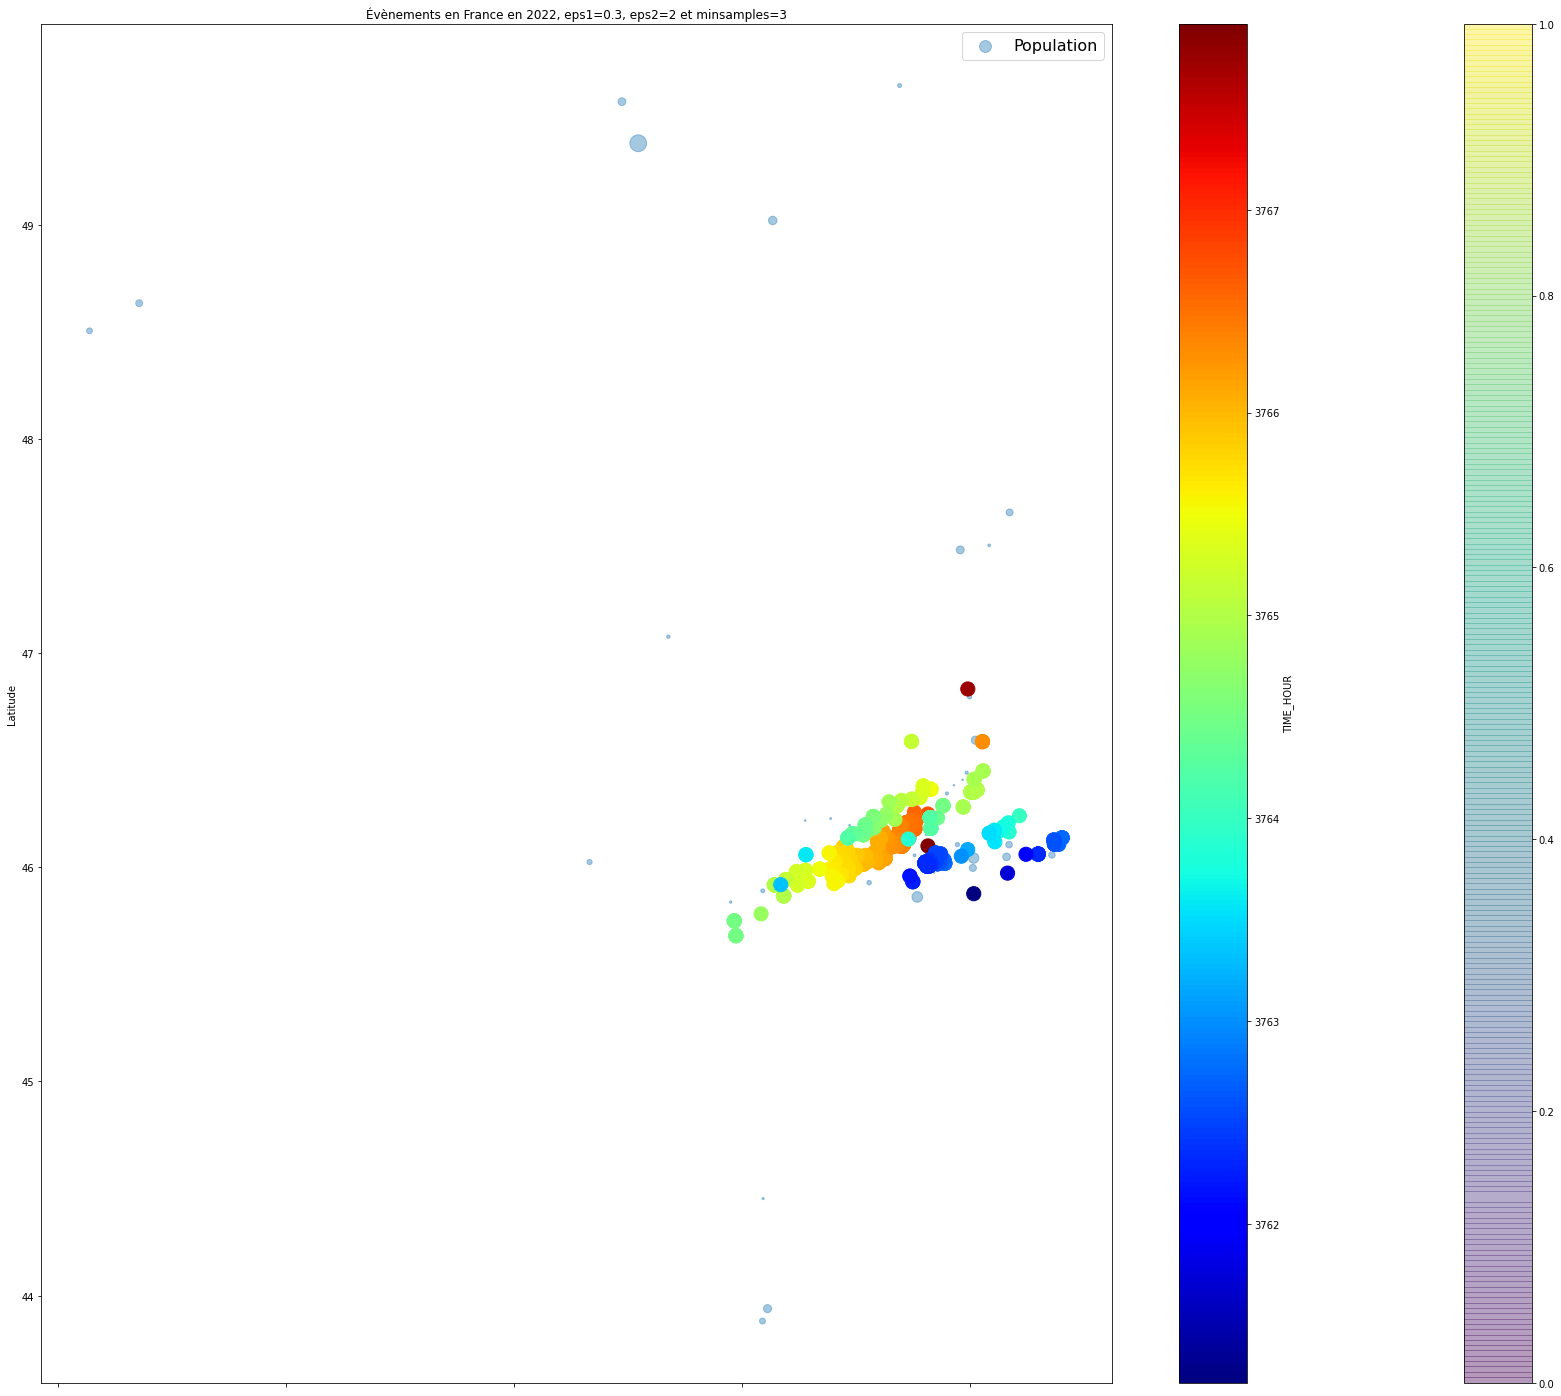

<ipython-input-37-4213b9b02d9f>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clst['TIME_HOUR']=df_clst.apply(lambda donnee: convert_hour(donnee), axis=1)


        TIME_HOUR  LATITUDE  LONGITUDE  cluster
classe                                         
31            134       134        134      134


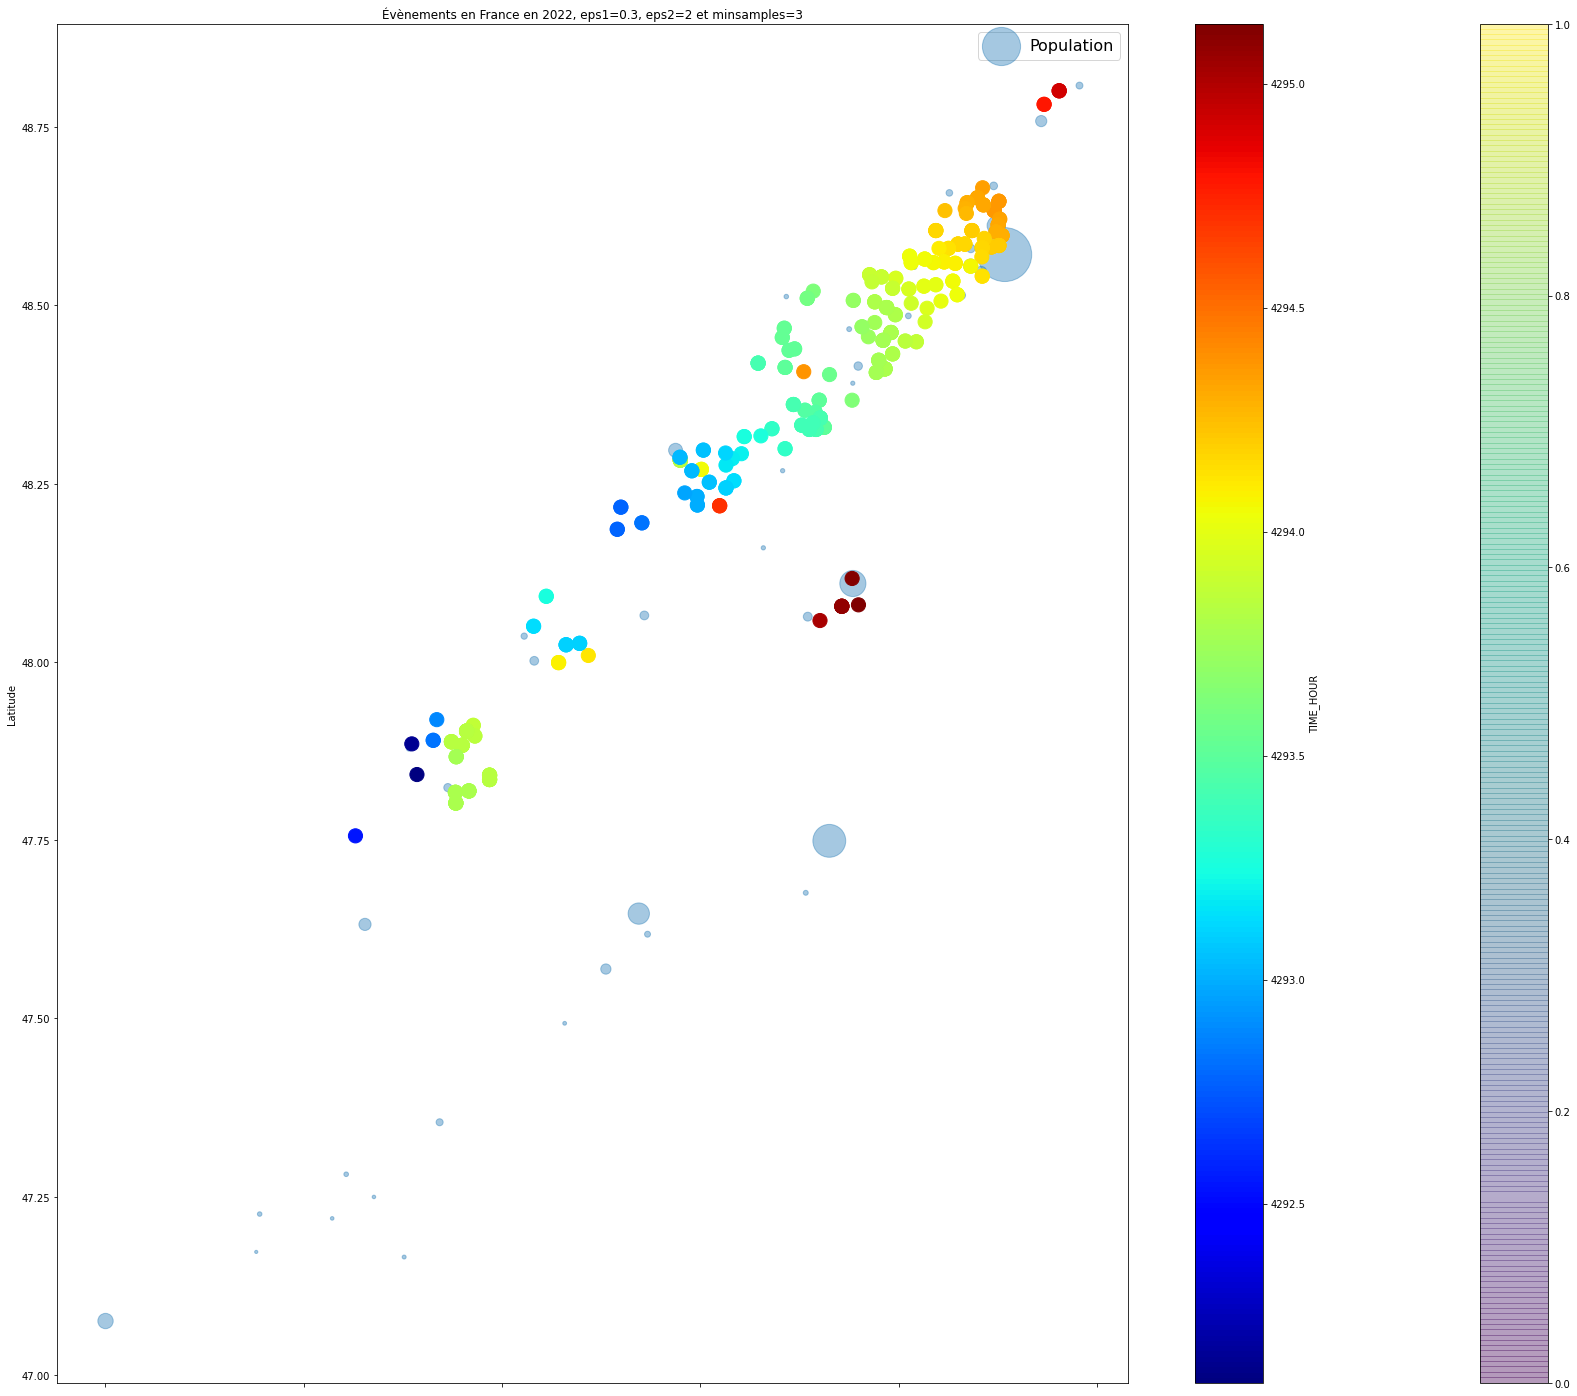

<ipython-input-37-4213b9b02d9f>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clst['TIME_HOUR']=df_clst.apply(lambda donnee: convert_hour(donnee), axis=1)


        TIME_HOUR  LATITUDE  LONGITUDE  cluster
classe                                         
75            118       118        118      118


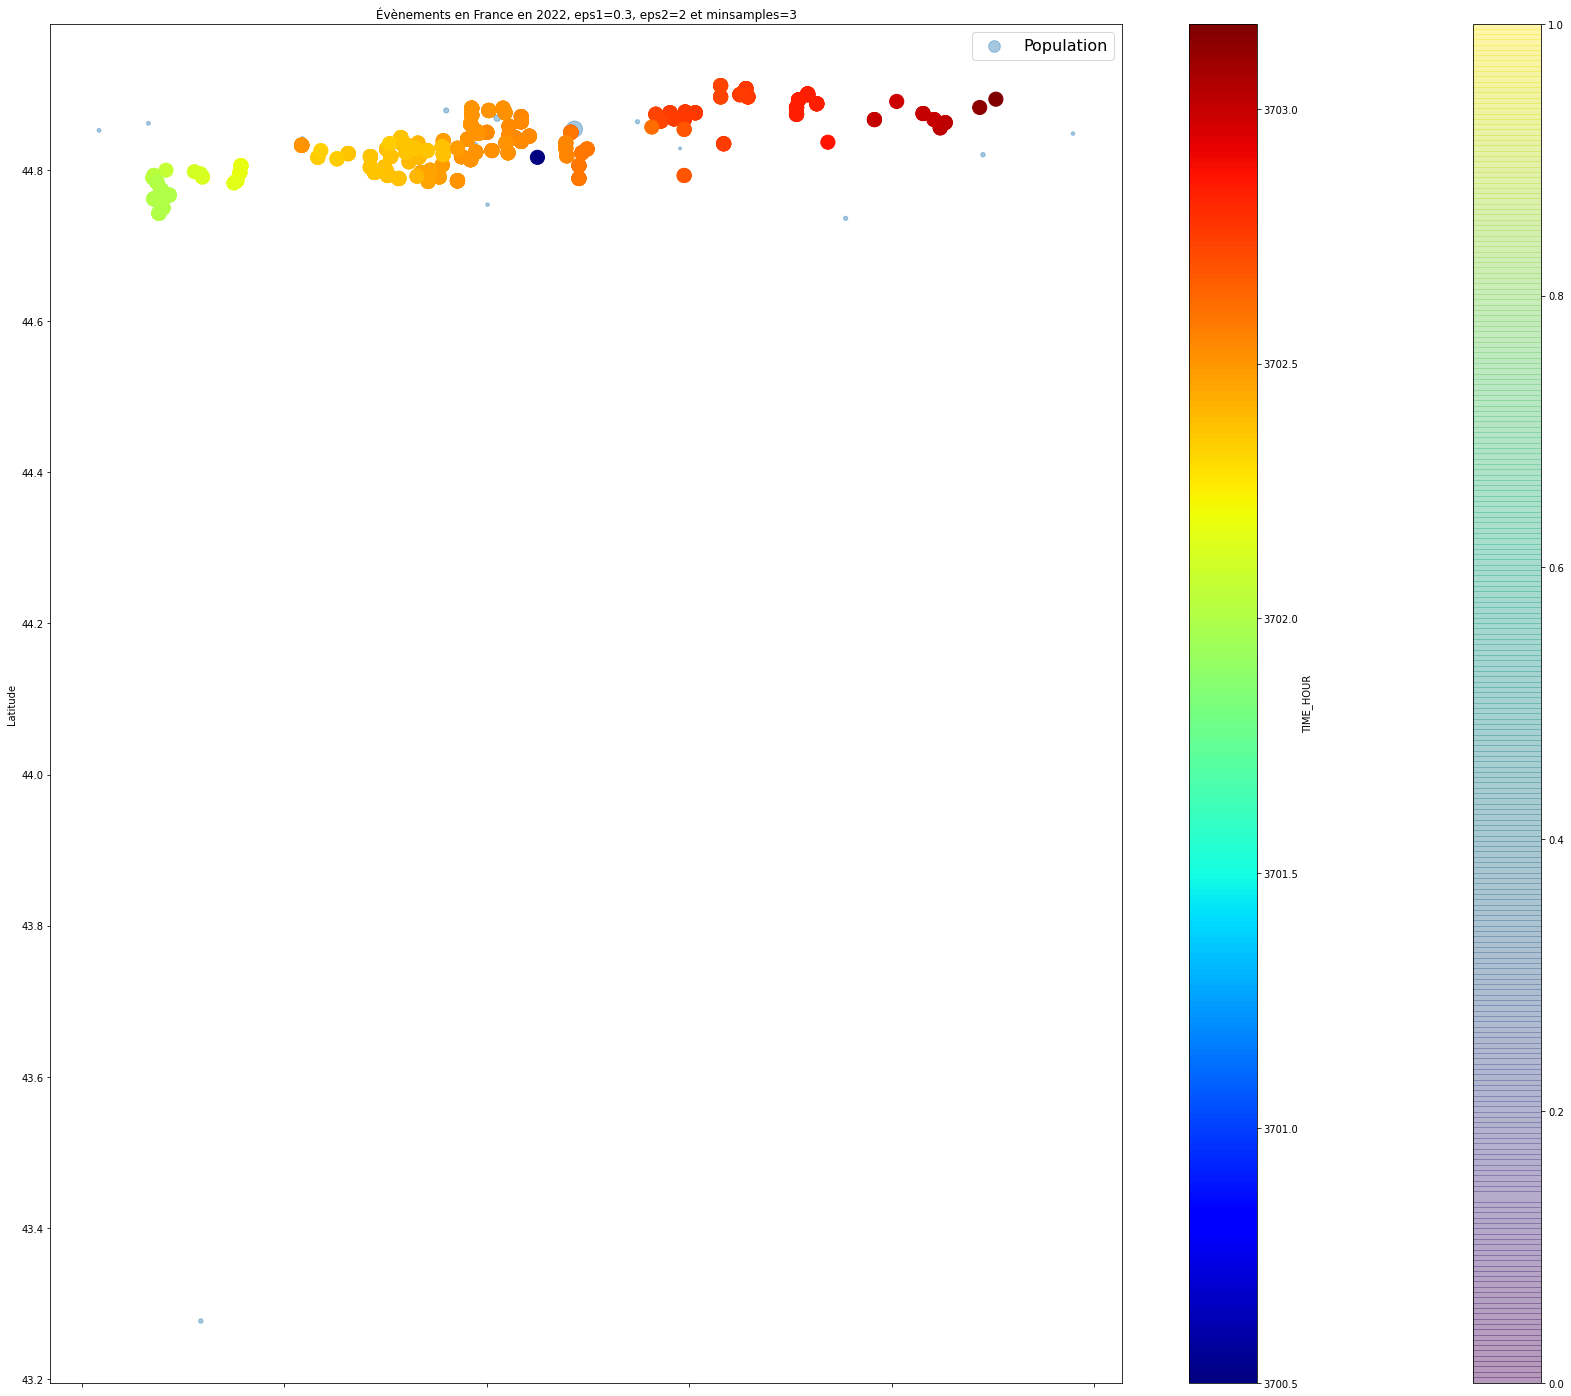

<ipython-input-37-4213b9b02d9f>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clst['TIME_HOUR']=df_clst.apply(lambda donnee: convert_hour(donnee), axis=1)


        TIME_HOUR  LATITUDE  LONGITUDE  cluster
classe                                         
48            113       113        113      113


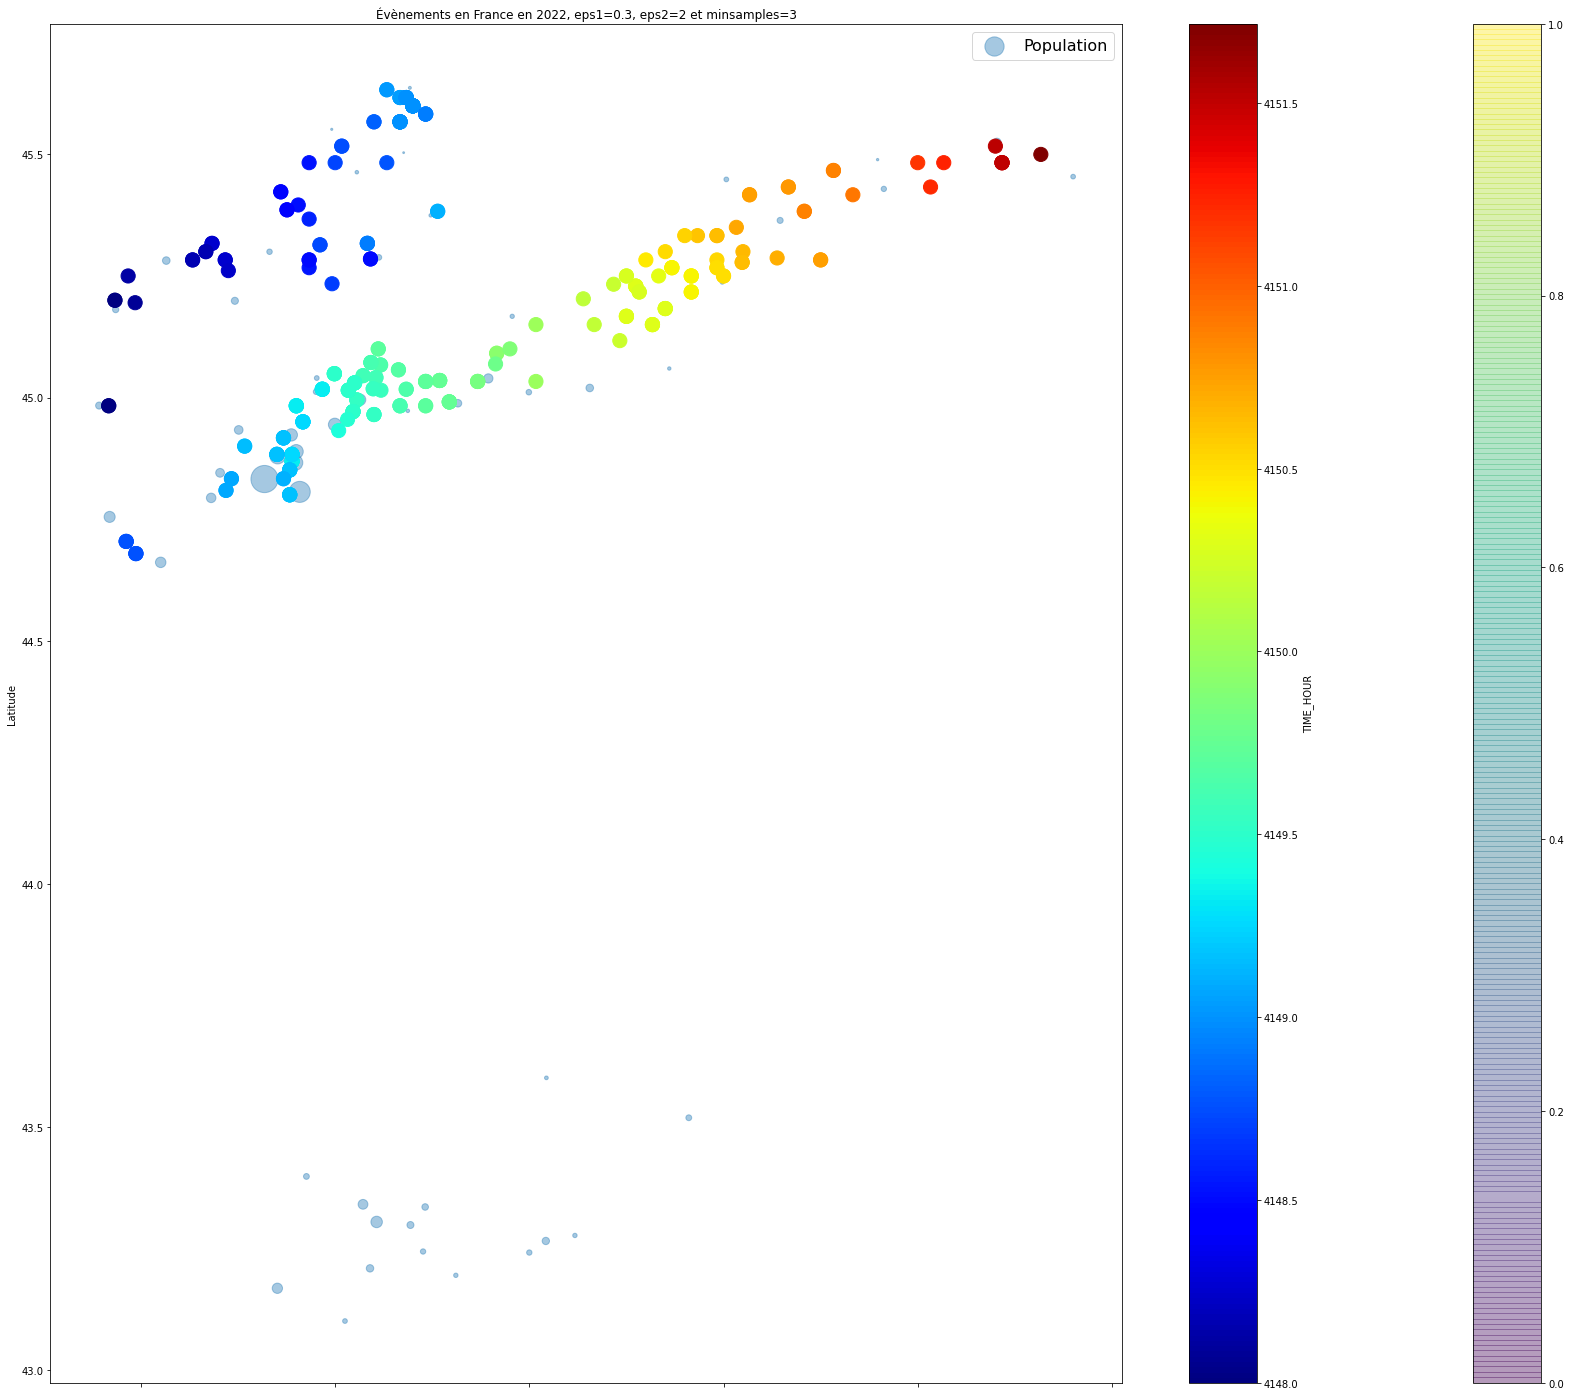

<ipython-input-37-4213b9b02d9f>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clst['TIME_HOUR']=df_clst.apply(lambda donnee: convert_hour(donnee), axis=1)


        TIME_HOUR  LATITUDE  LONGITUDE  cluster
classe                                         
30            110       110        110      110


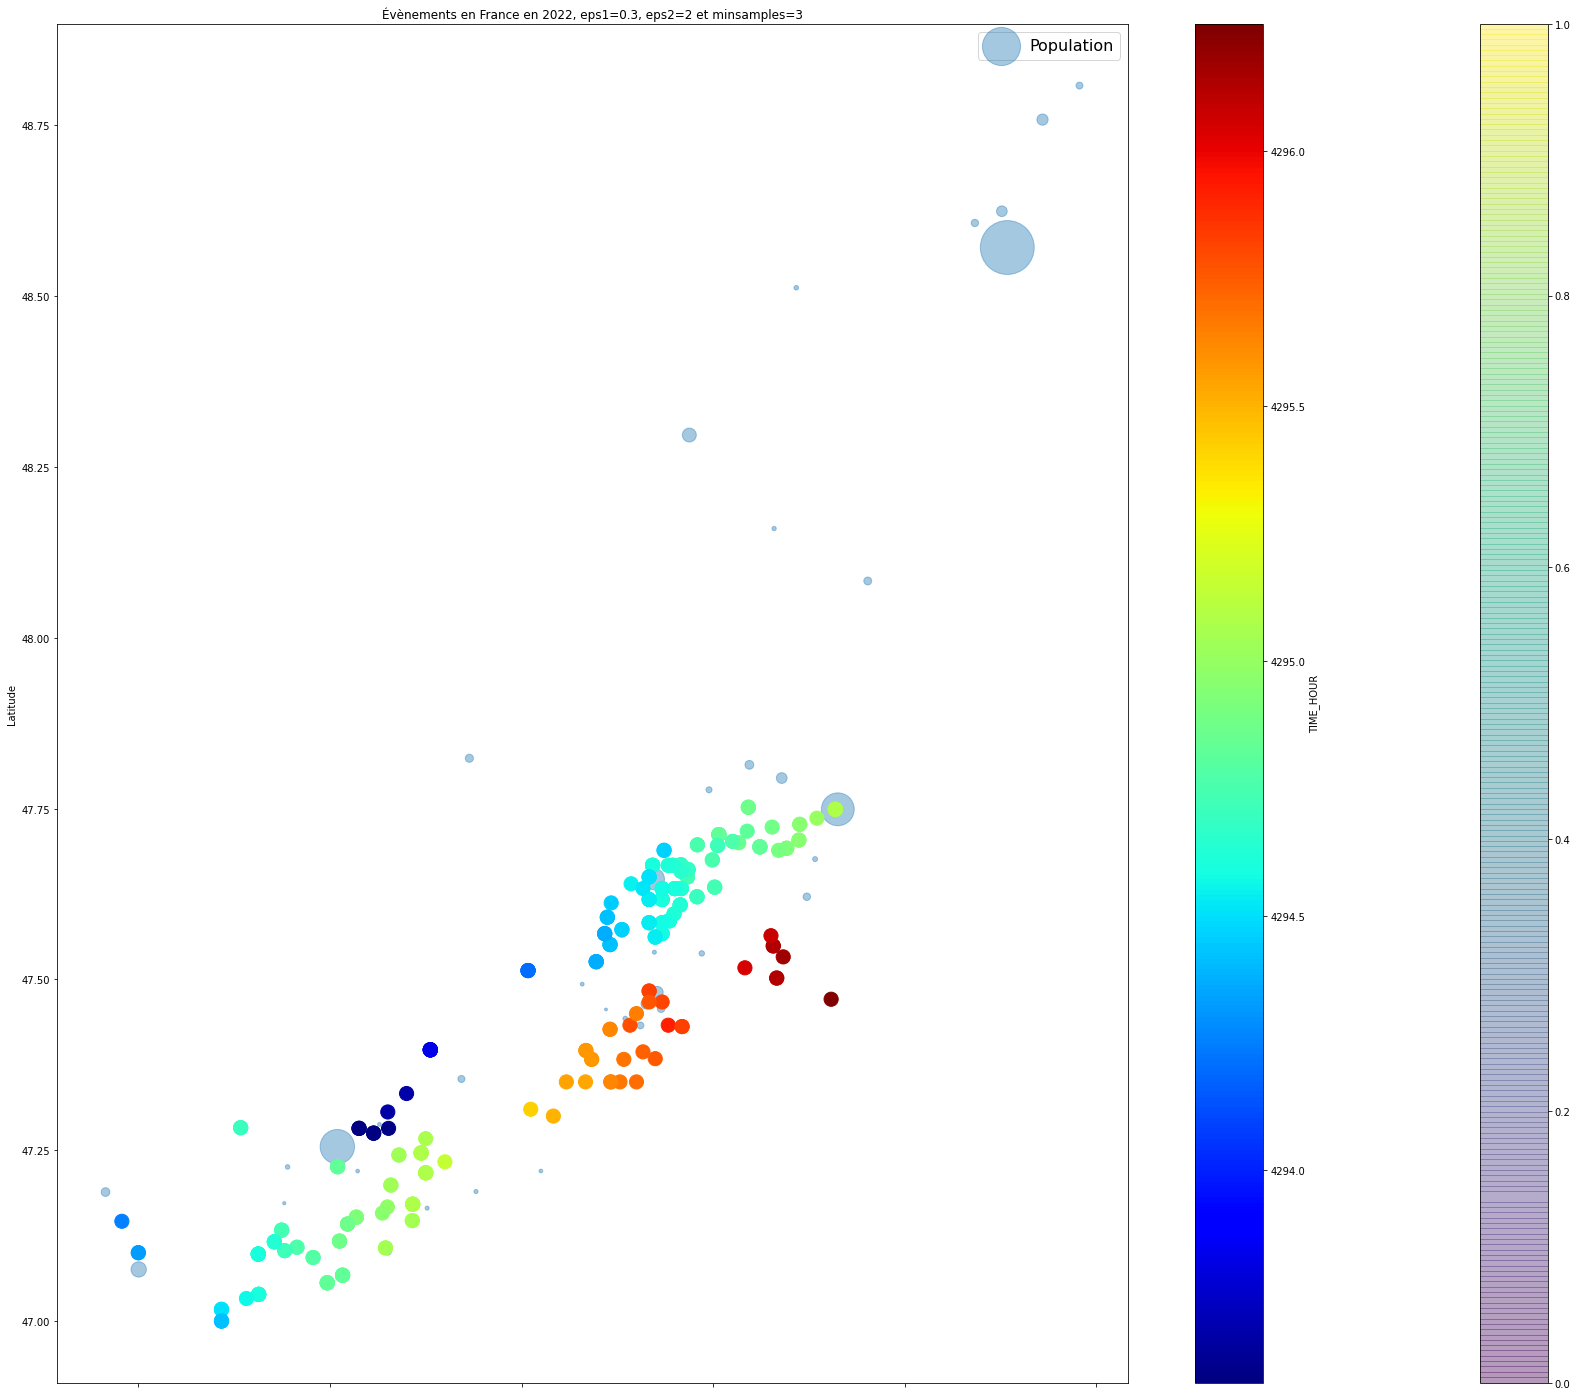

<ipython-input-37-4213b9b02d9f>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clst['TIME_HOUR']=df_clst.apply(lambda donnee: convert_hour(donnee), axis=1)


        TIME_HOUR  LATITUDE  LONGITUDE  cluster
classe                                         
50            106       106        106      106


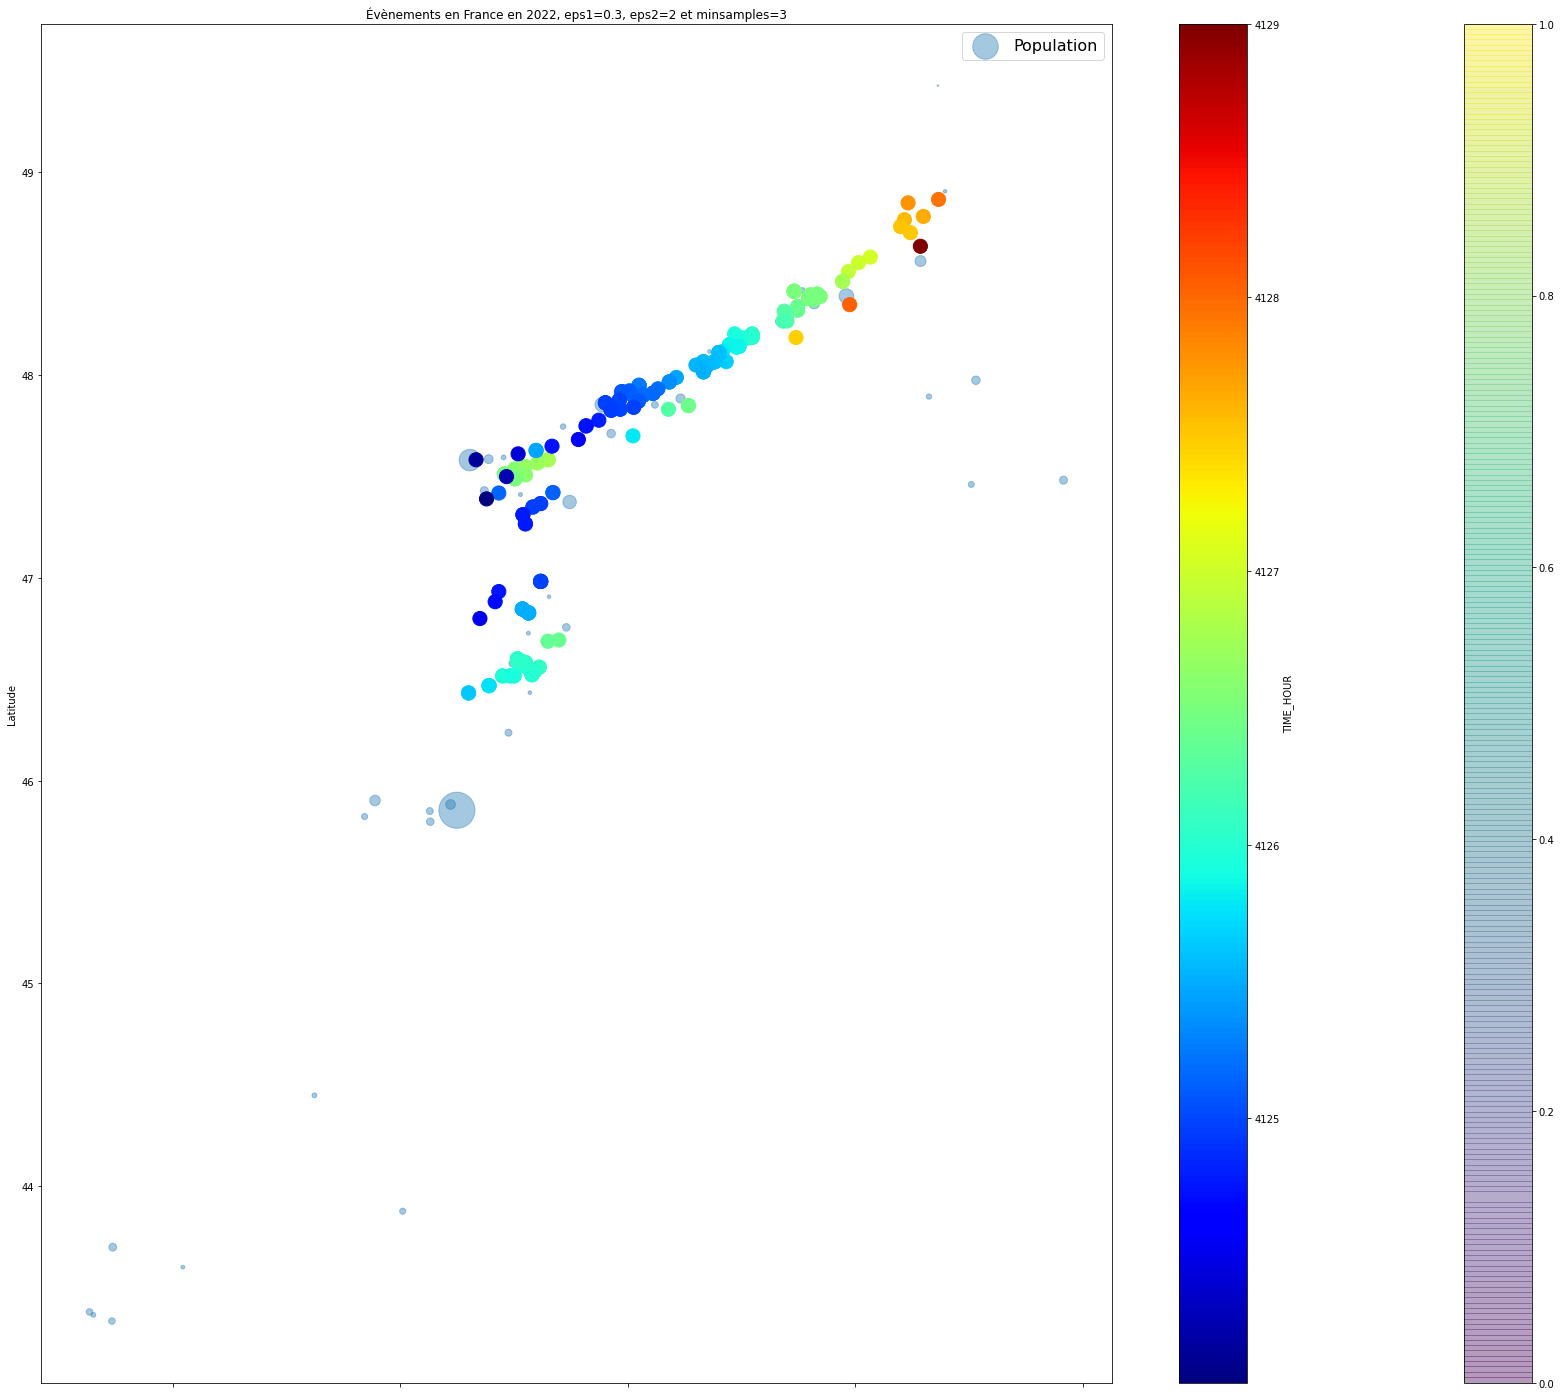

<ipython-input-37-4213b9b02d9f>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clst['TIME_HOUR']=df_clst.apply(lambda donnee: convert_hour(donnee), axis=1)


        TIME_HOUR  LATITUDE  LONGITUDE  cluster
classe                                         
49             76        76         76       76


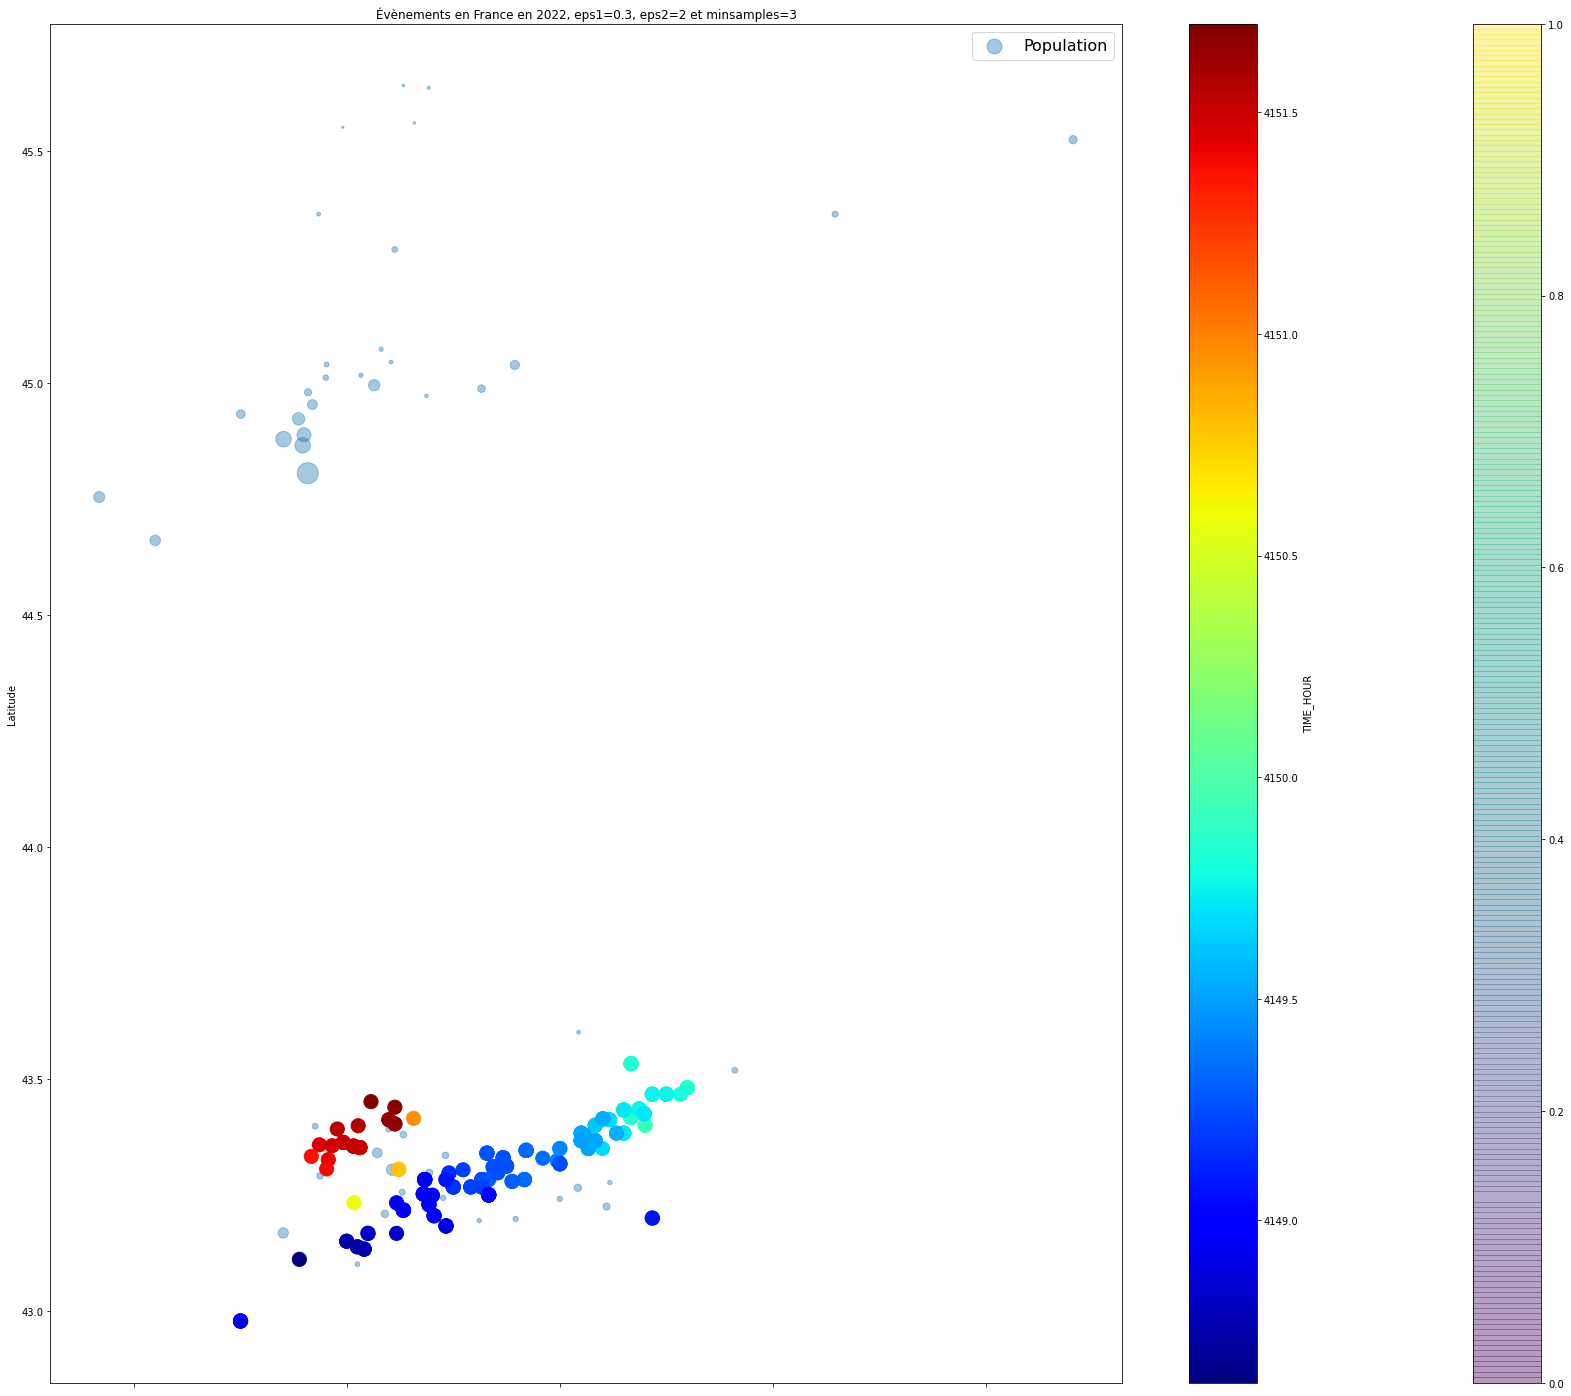

<ipython-input-37-4213b9b02d9f>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clst['TIME_HOUR']=df_clst.apply(lambda donnee: convert_hour(donnee), axis=1)


        TIME_HOUR  LATITUDE  LONGITUDE  cluster
classe                                         
47             63        63         63       63


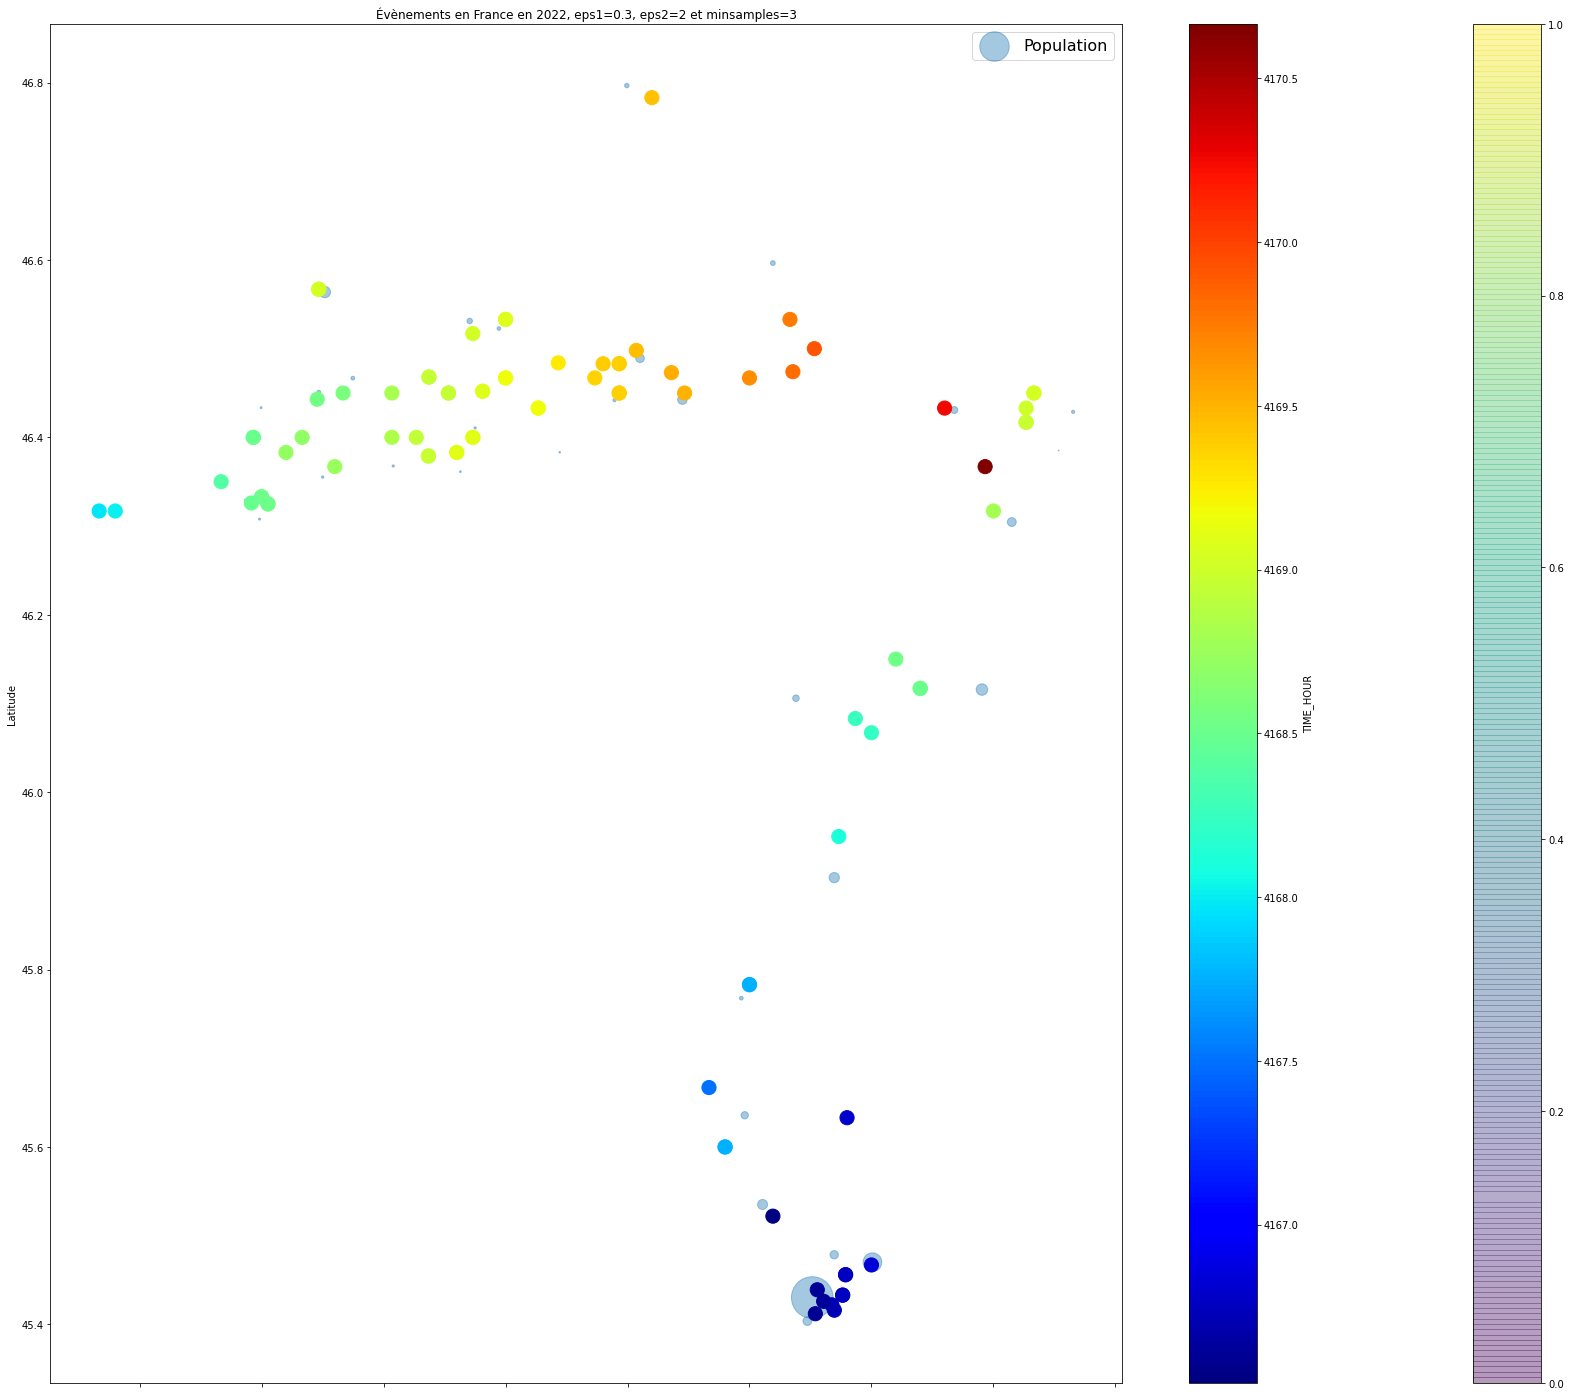

<ipython-input-37-4213b9b02d9f>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clst['TIME_HOUR']=df_clst.apply(lambda donnee: convert_hour(donnee), axis=1)


        TIME_HOUR  LATITUDE  LONGITUDE  cluster
classe                                         
79             54        54         54       54


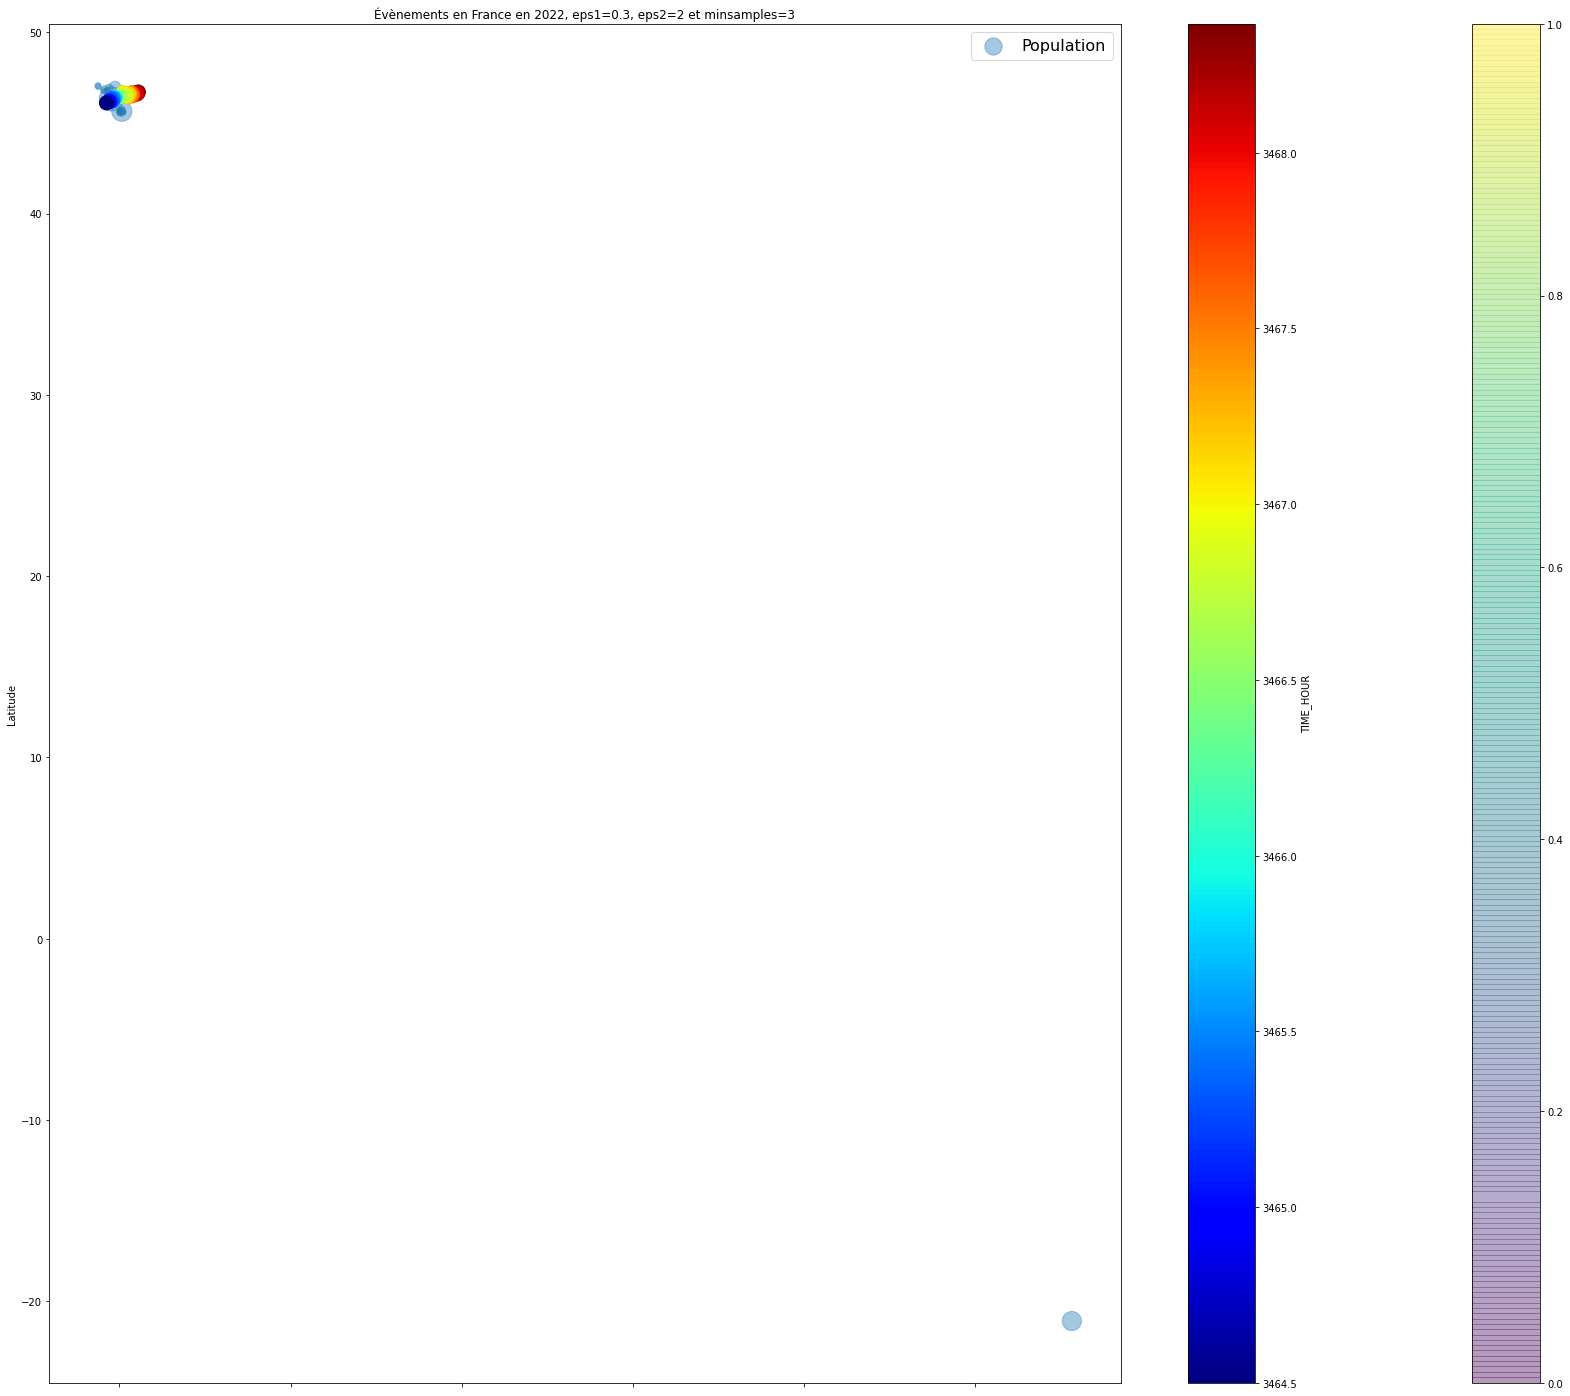

<ipython-input-37-4213b9b02d9f>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clst['TIME_HOUR']=df_clst.apply(lambda donnee: convert_hour(donnee), axis=1)


        TIME_HOUR  LATITUDE  LONGITUDE  cluster
classe                                         
22             46        46         46       46


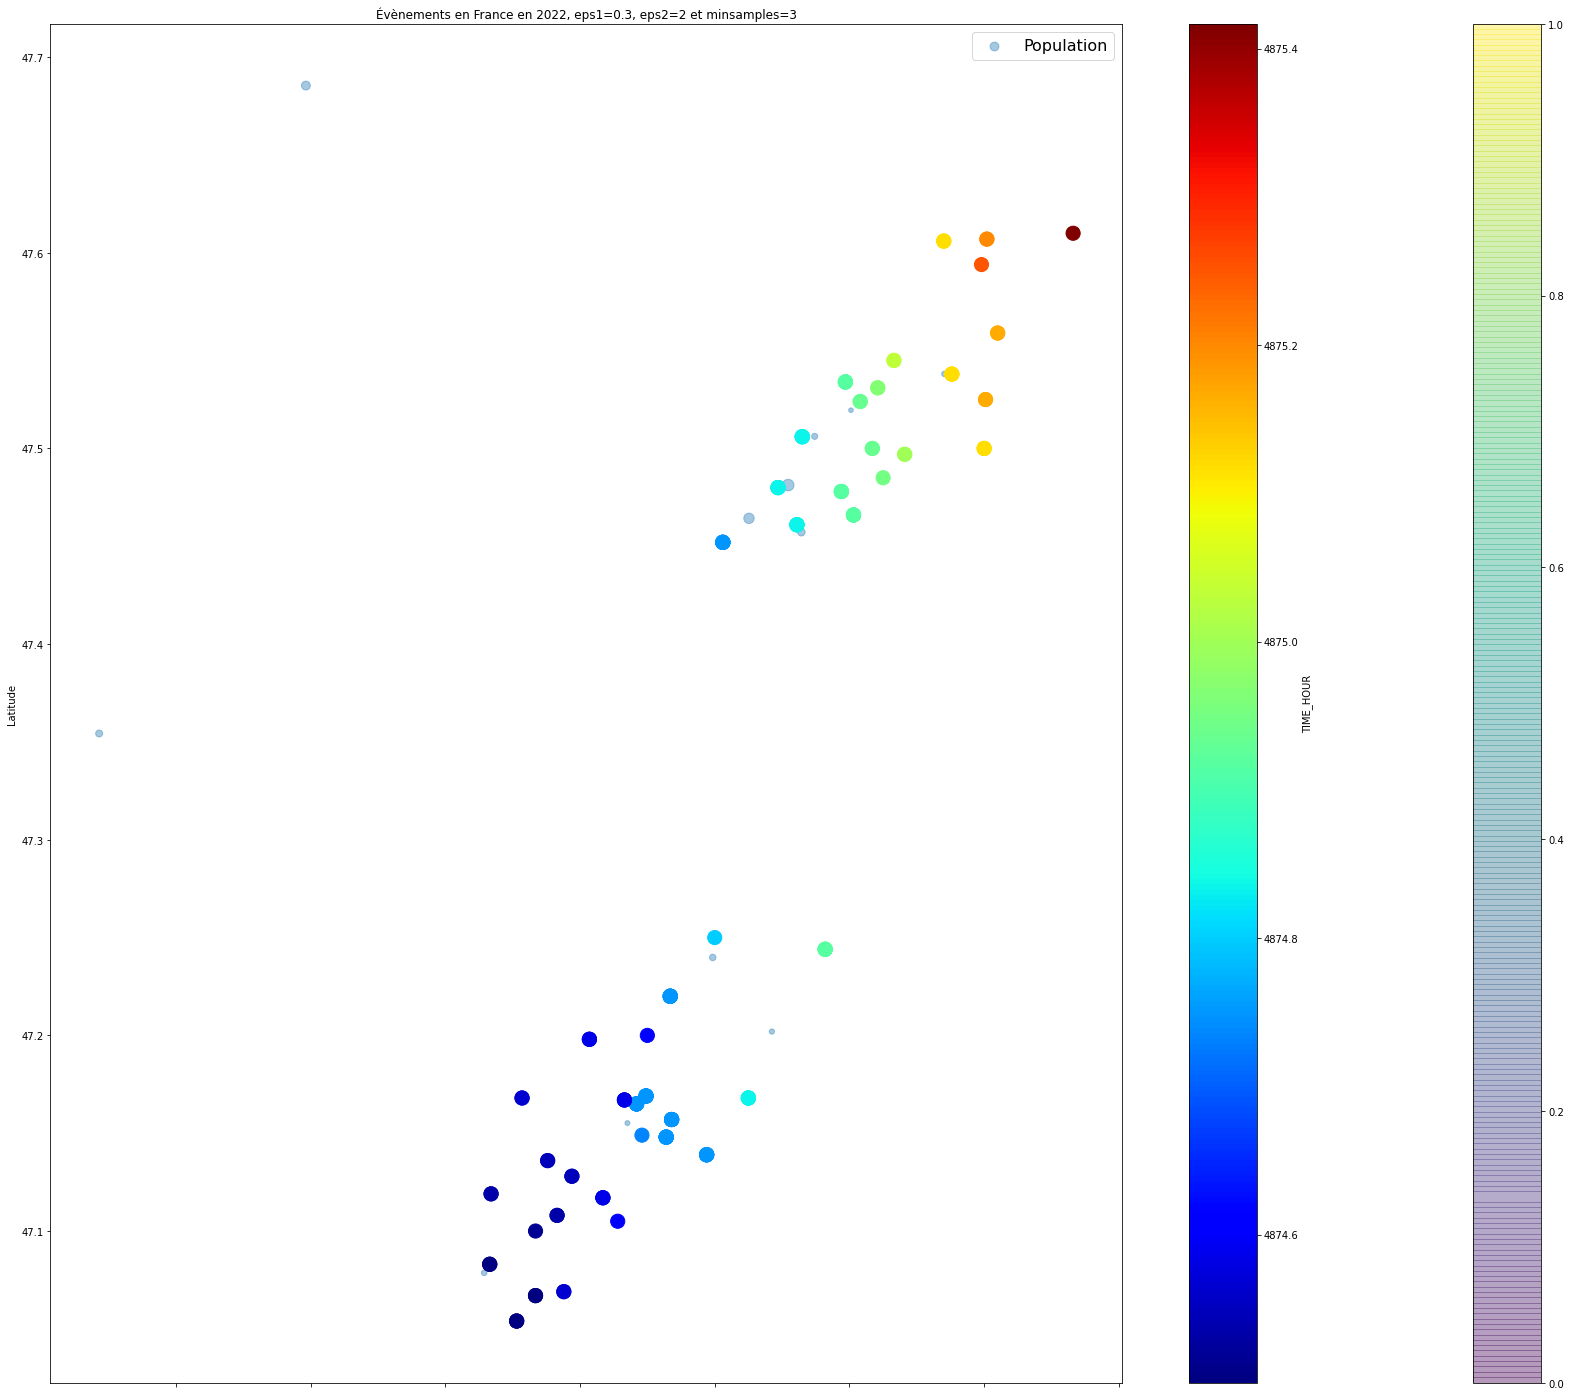

In [ ]:
for i in range(10):
  stdbscan_demog_fr4(2022,0.3, 2, 3,i)

<ipython-input-37-4213b9b02d9f>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clst['TIME_HOUR']=df_clst.apply(lambda donnee: convert_hour(donnee), axis=1)


        TIME_HOUR  LATITUDE  LONGITUDE  cluster
classe                                         
63            136       136        136      136


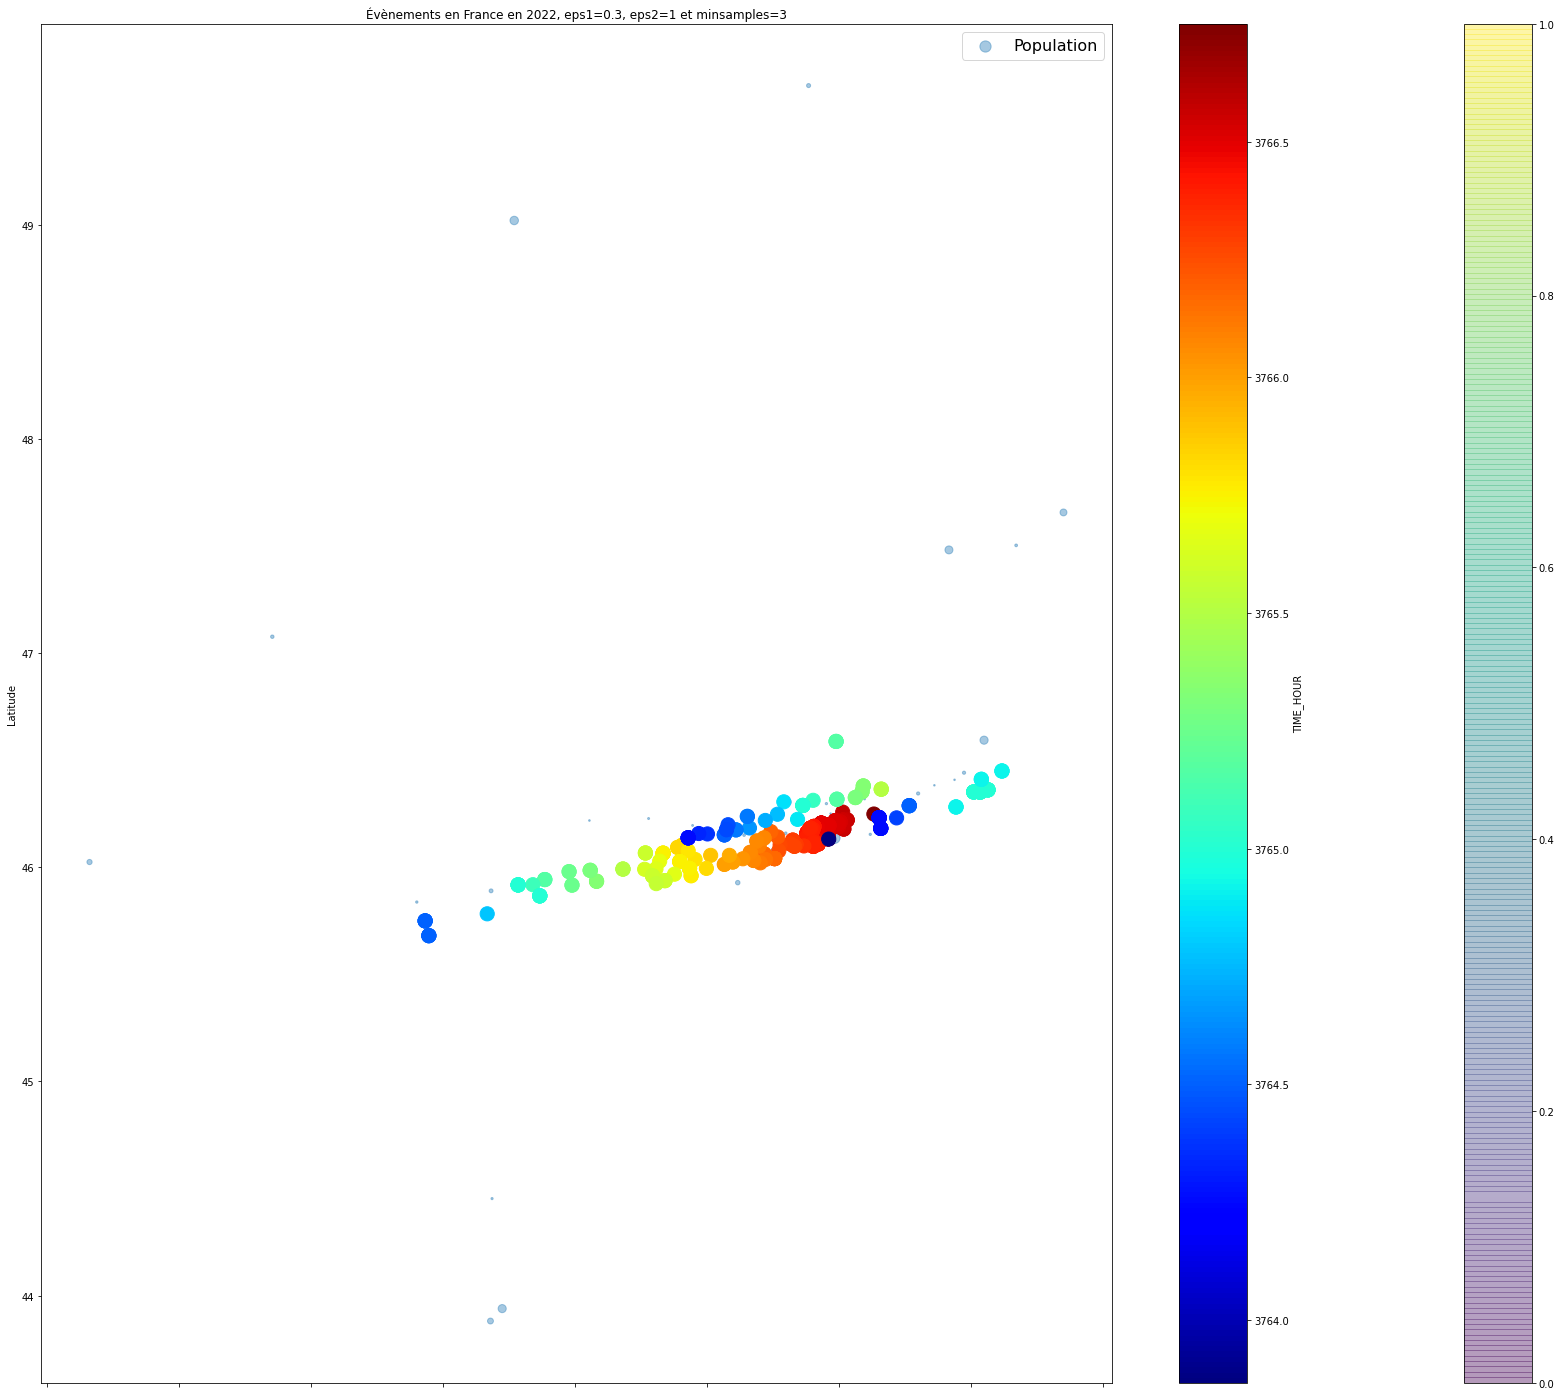

<ipython-input-37-4213b9b02d9f>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clst['TIME_HOUR']=df_clst.apply(lambda donnee: convert_hour(donnee), axis=1)


        TIME_HOUR  LATITUDE  LONGITUDE  cluster
classe                                         
32            134       134        134      134


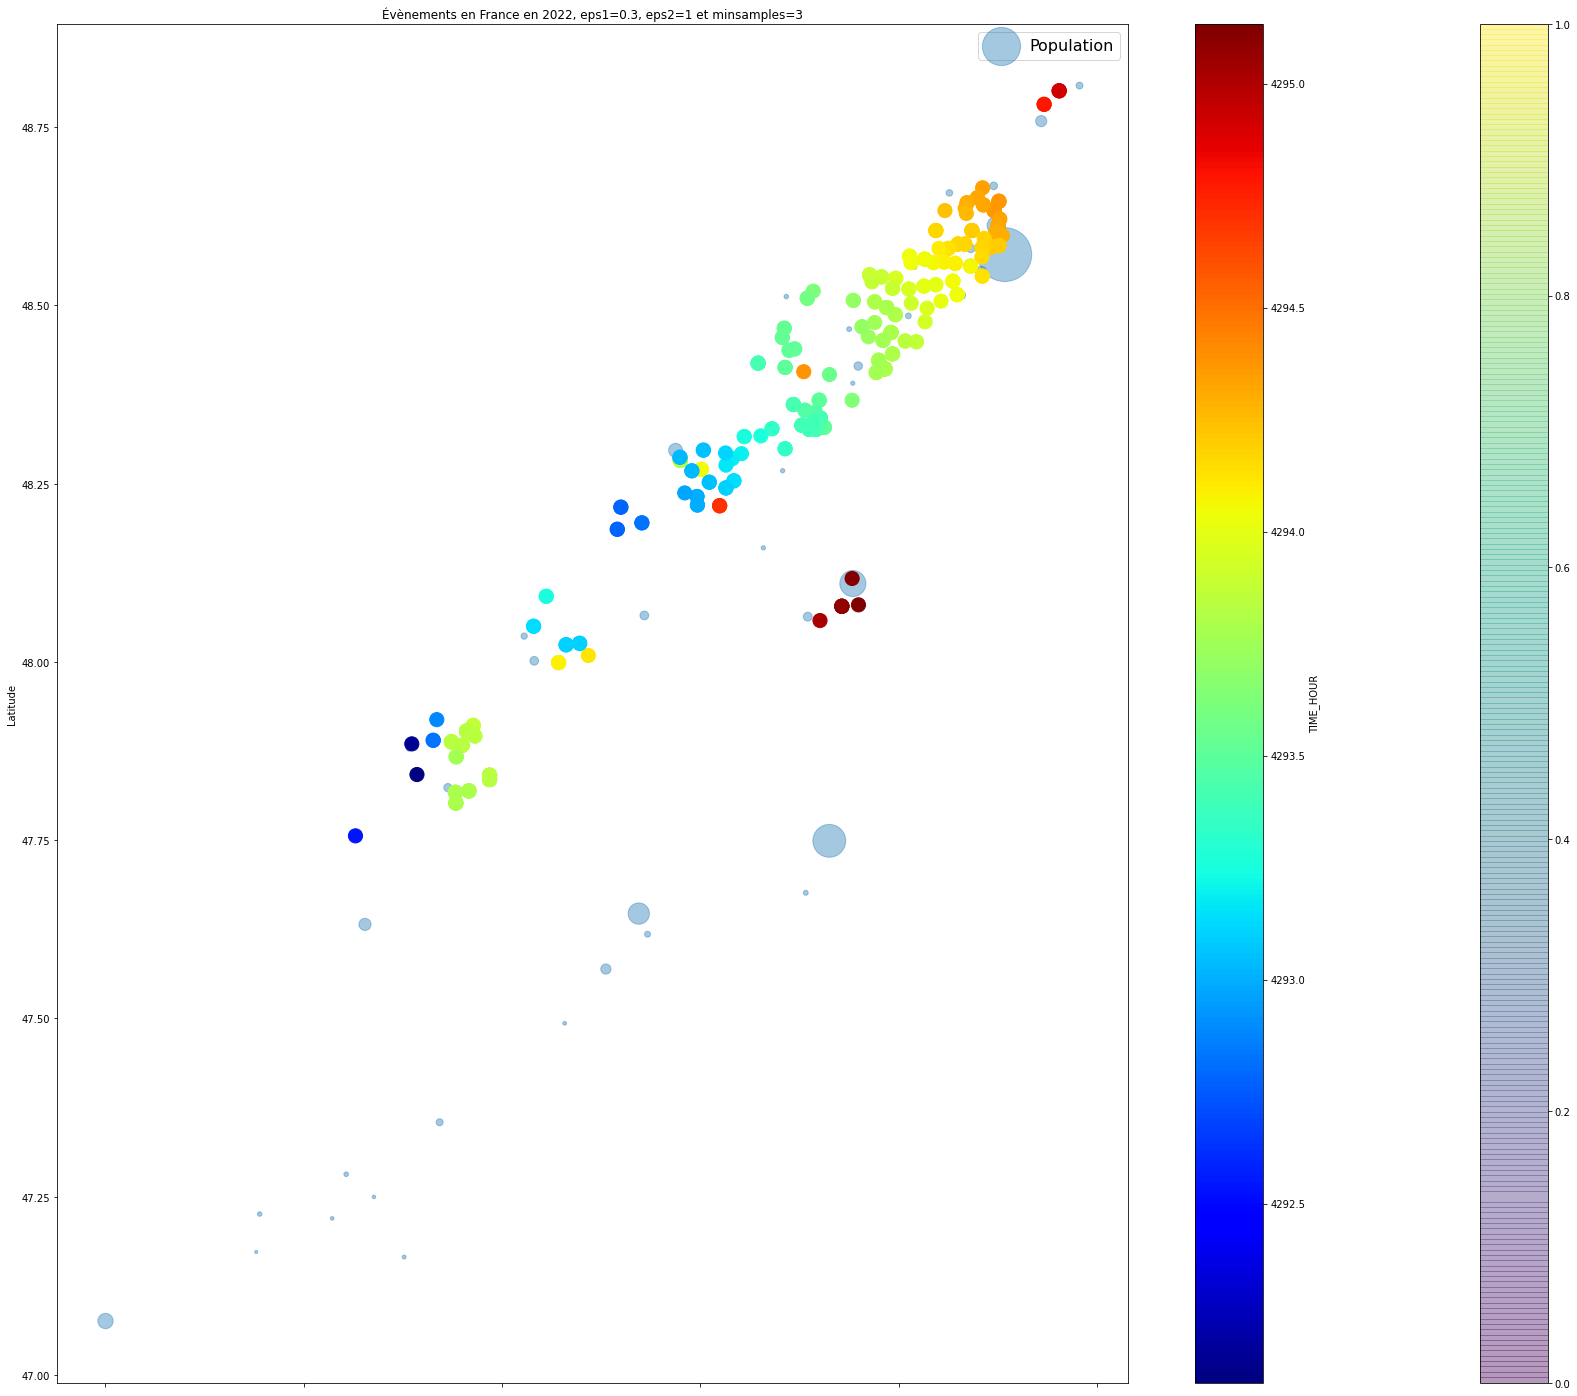

<ipython-input-37-4213b9b02d9f>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clst['TIME_HOUR']=df_clst.apply(lambda donnee: convert_hour(donnee), axis=1)


        TIME_HOUR  LATITUDE  LONGITUDE  cluster
classe                                         
83            117       117        117      117


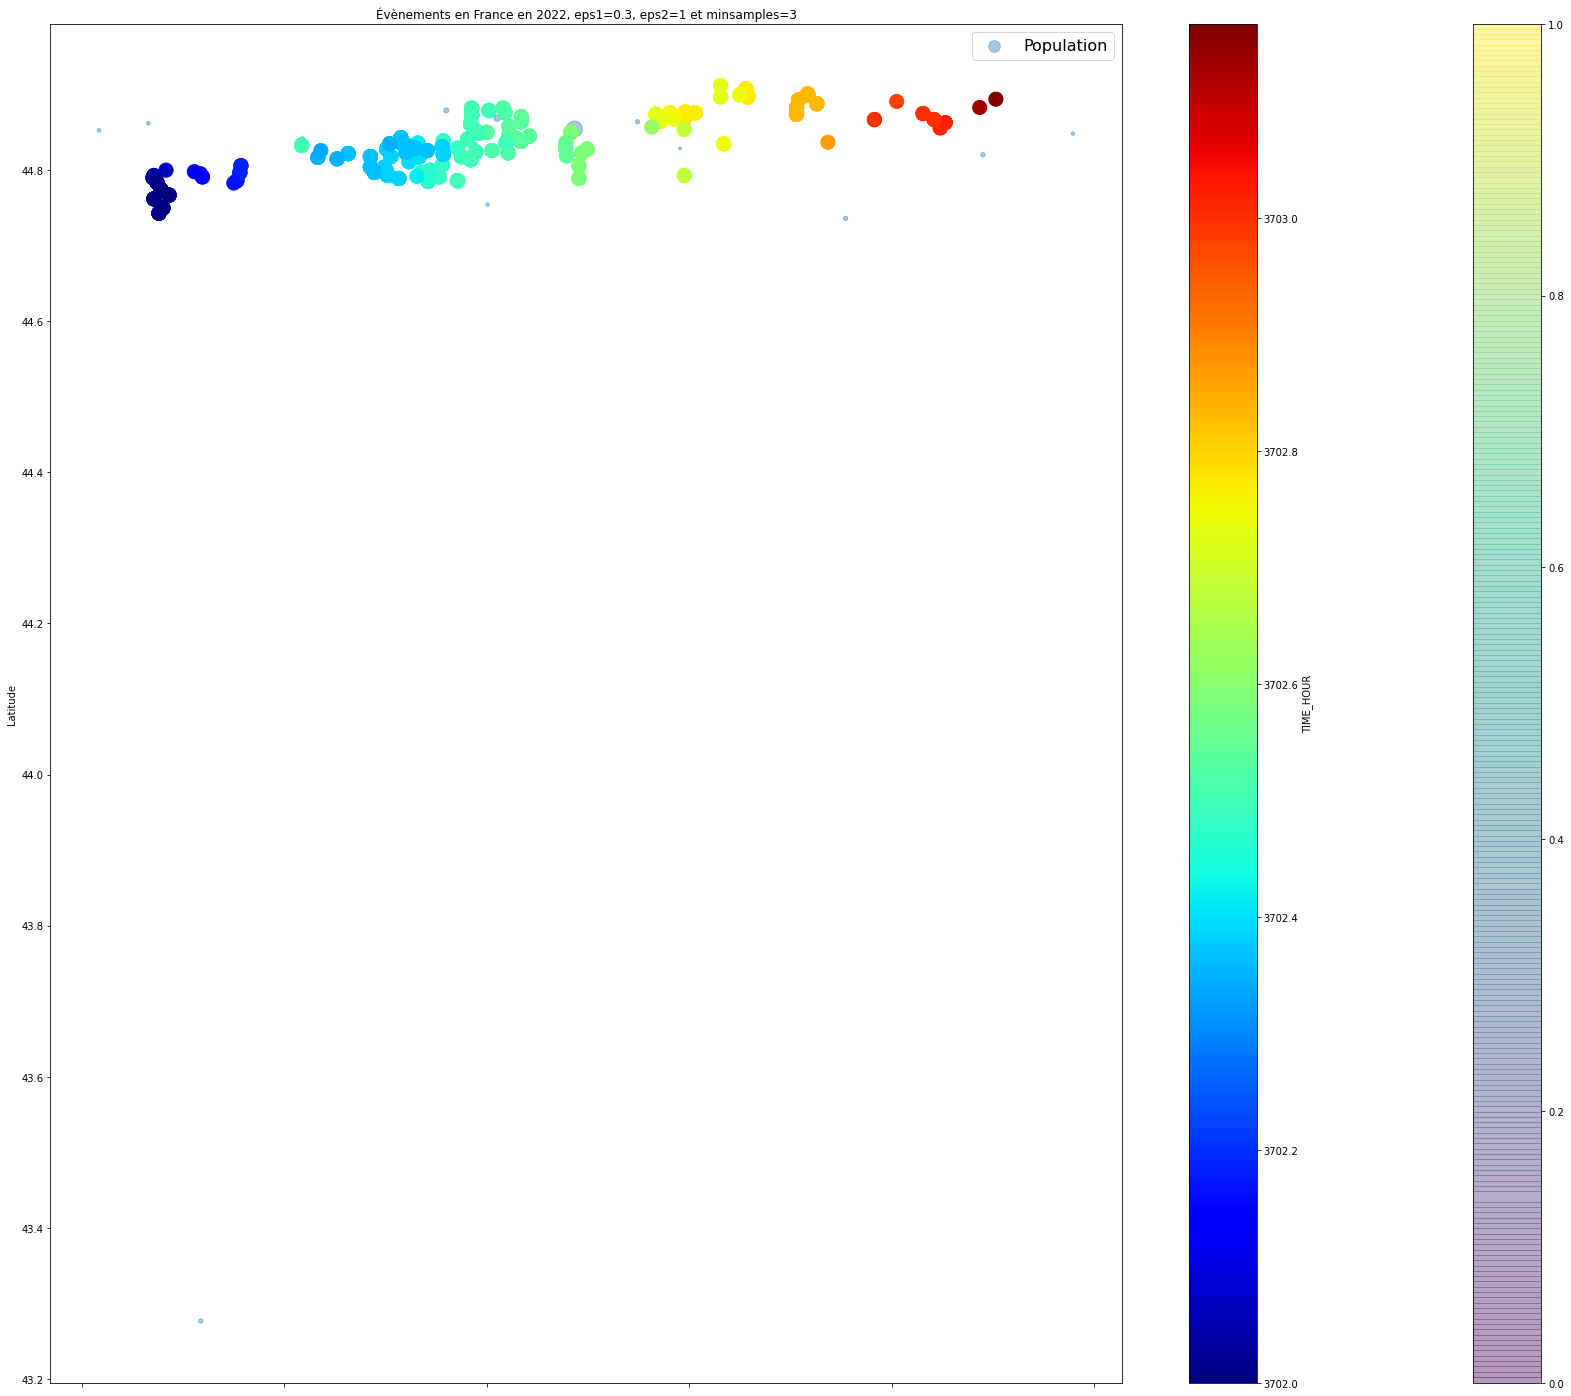

<ipython-input-37-4213b9b02d9f>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clst['TIME_HOUR']=df_clst.apply(lambda donnee: convert_hour(donnee), axis=1)


        TIME_HOUR  LATITUDE  LONGITUDE  cluster
classe                                         
51            113       113        113      113


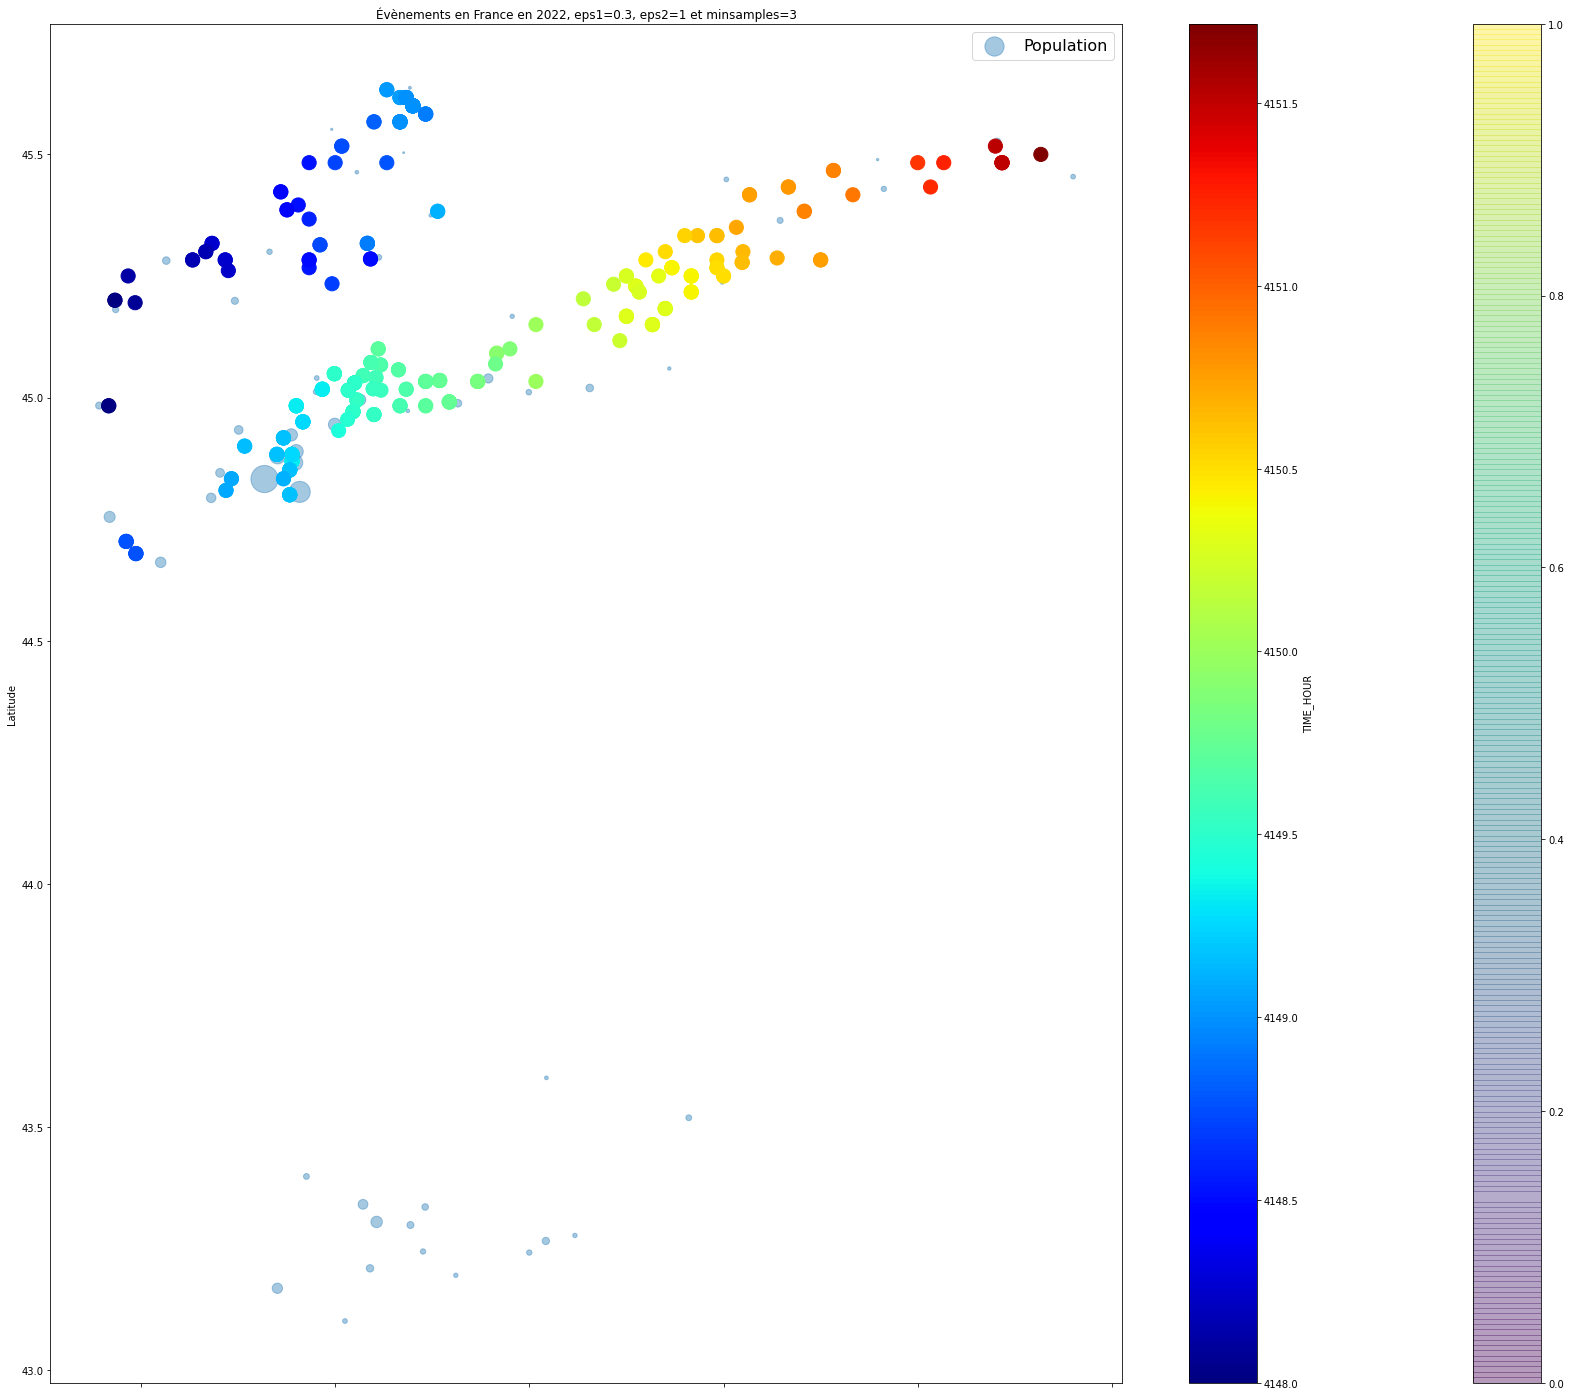

<ipython-input-37-4213b9b02d9f>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clst['TIME_HOUR']=df_clst.apply(lambda donnee: convert_hour(donnee), axis=1)


        TIME_HOUR  LATITUDE  LONGITUDE  cluster
classe                                         
31            110       110        110      110


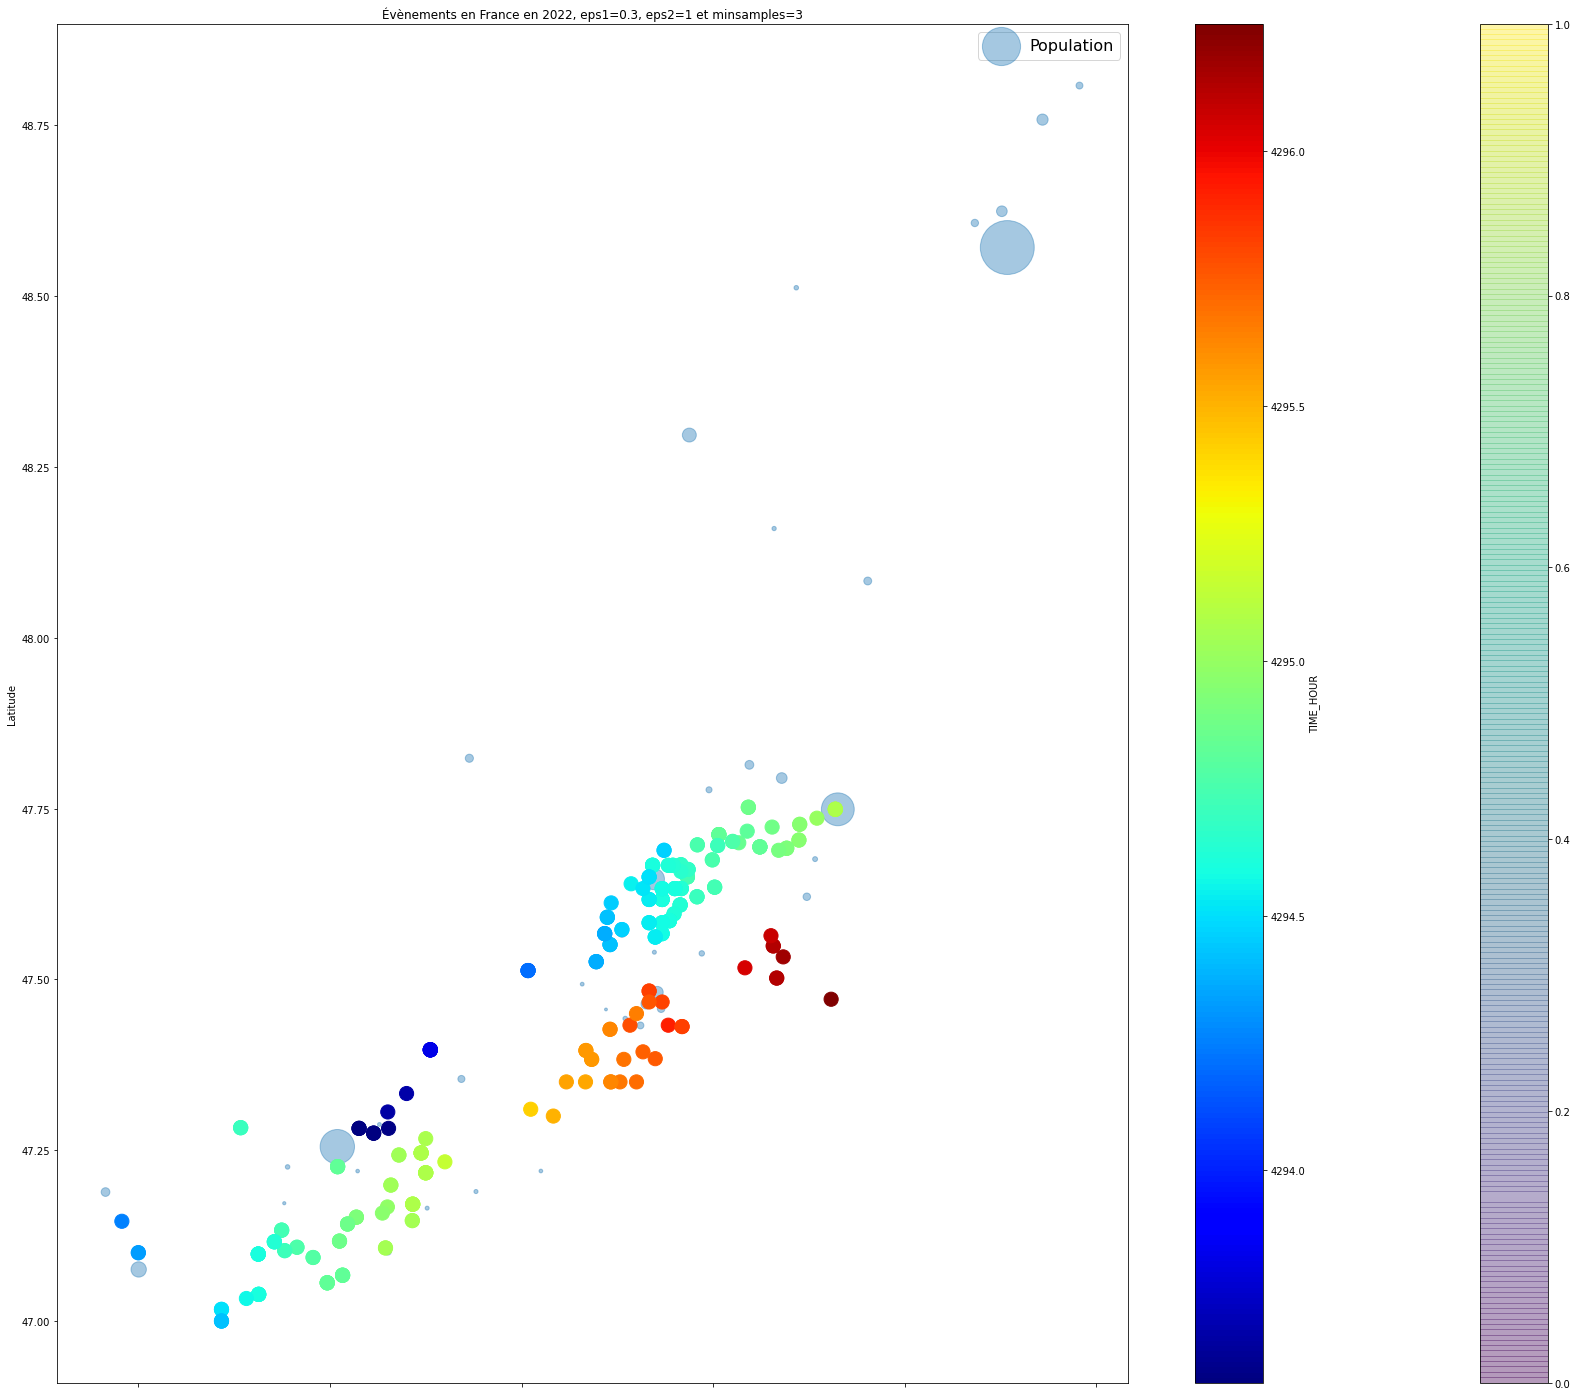

<ipython-input-37-4213b9b02d9f>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clst['TIME_HOUR']=df_clst.apply(lambda donnee: convert_hour(donnee), axis=1)


        TIME_HOUR  LATITUDE  LONGITUDE  cluster
classe                                         
54             98        98         98       98


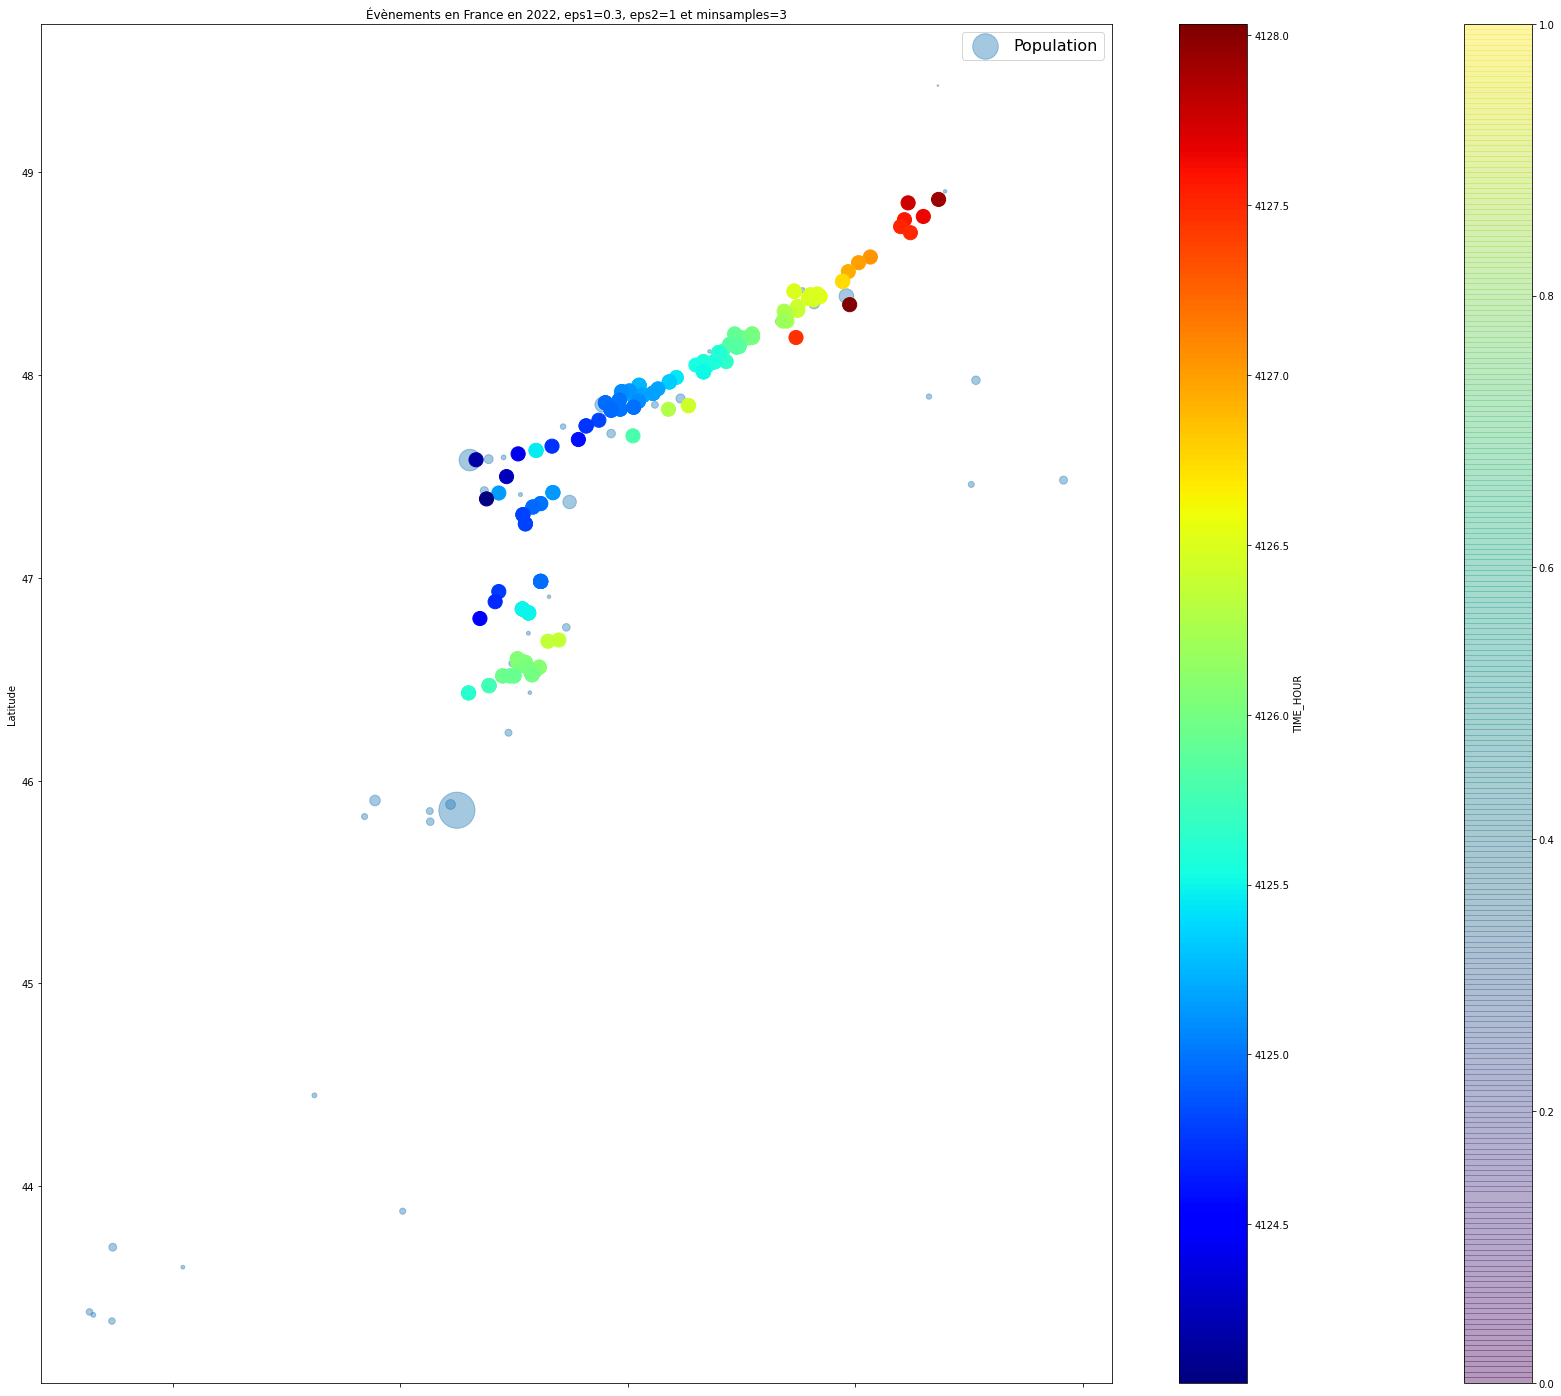

<ipython-input-37-4213b9b02d9f>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clst['TIME_HOUR']=df_clst.apply(lambda donnee: convert_hour(donnee), axis=1)


        TIME_HOUR  LATITUDE  LONGITUDE  cluster
classe                                         
53             59        59         59       59


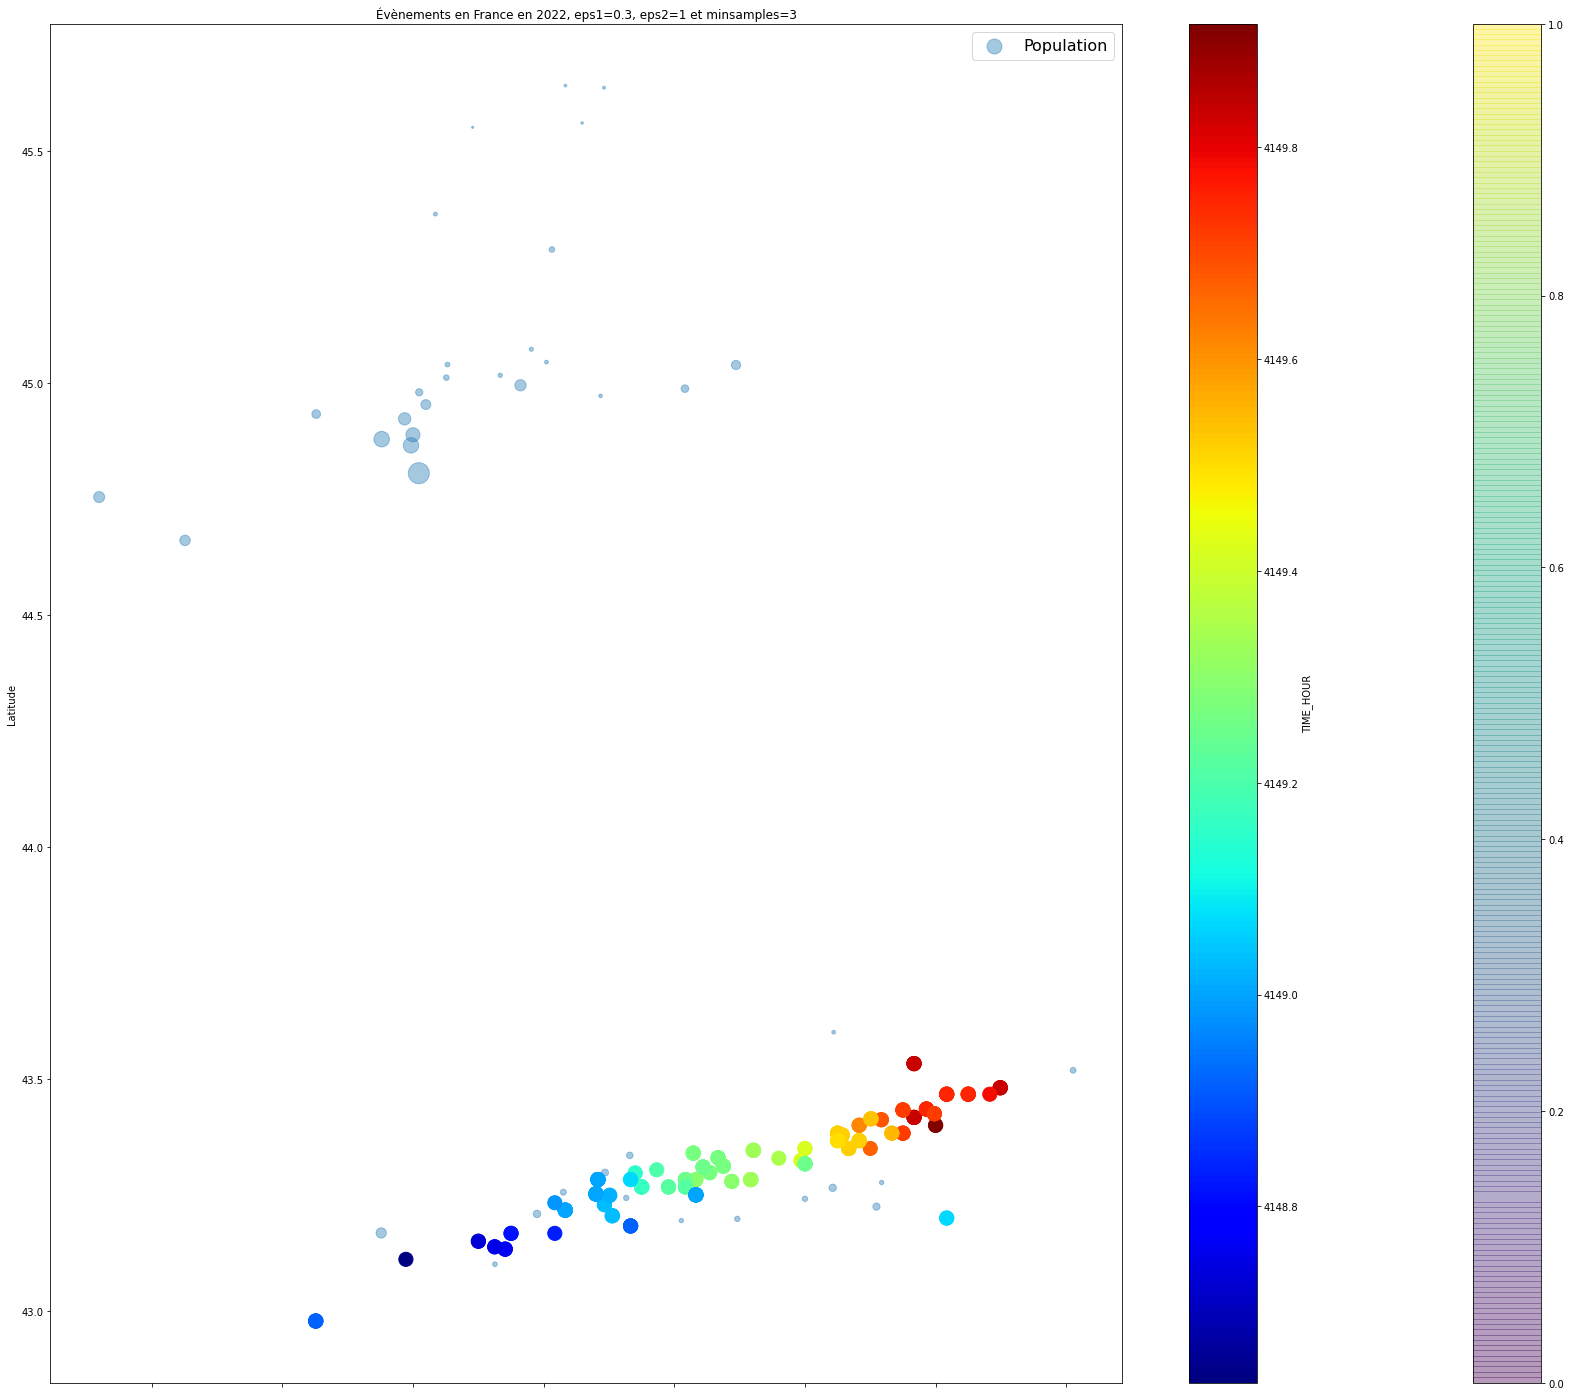

<ipython-input-37-4213b9b02d9f>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clst['TIME_HOUR']=df_clst.apply(lambda donnee: convert_hour(donnee), axis=1)


        TIME_HOUR  LATITUDE  LONGITUDE  cluster
classe                                         
86             54        54         54       54


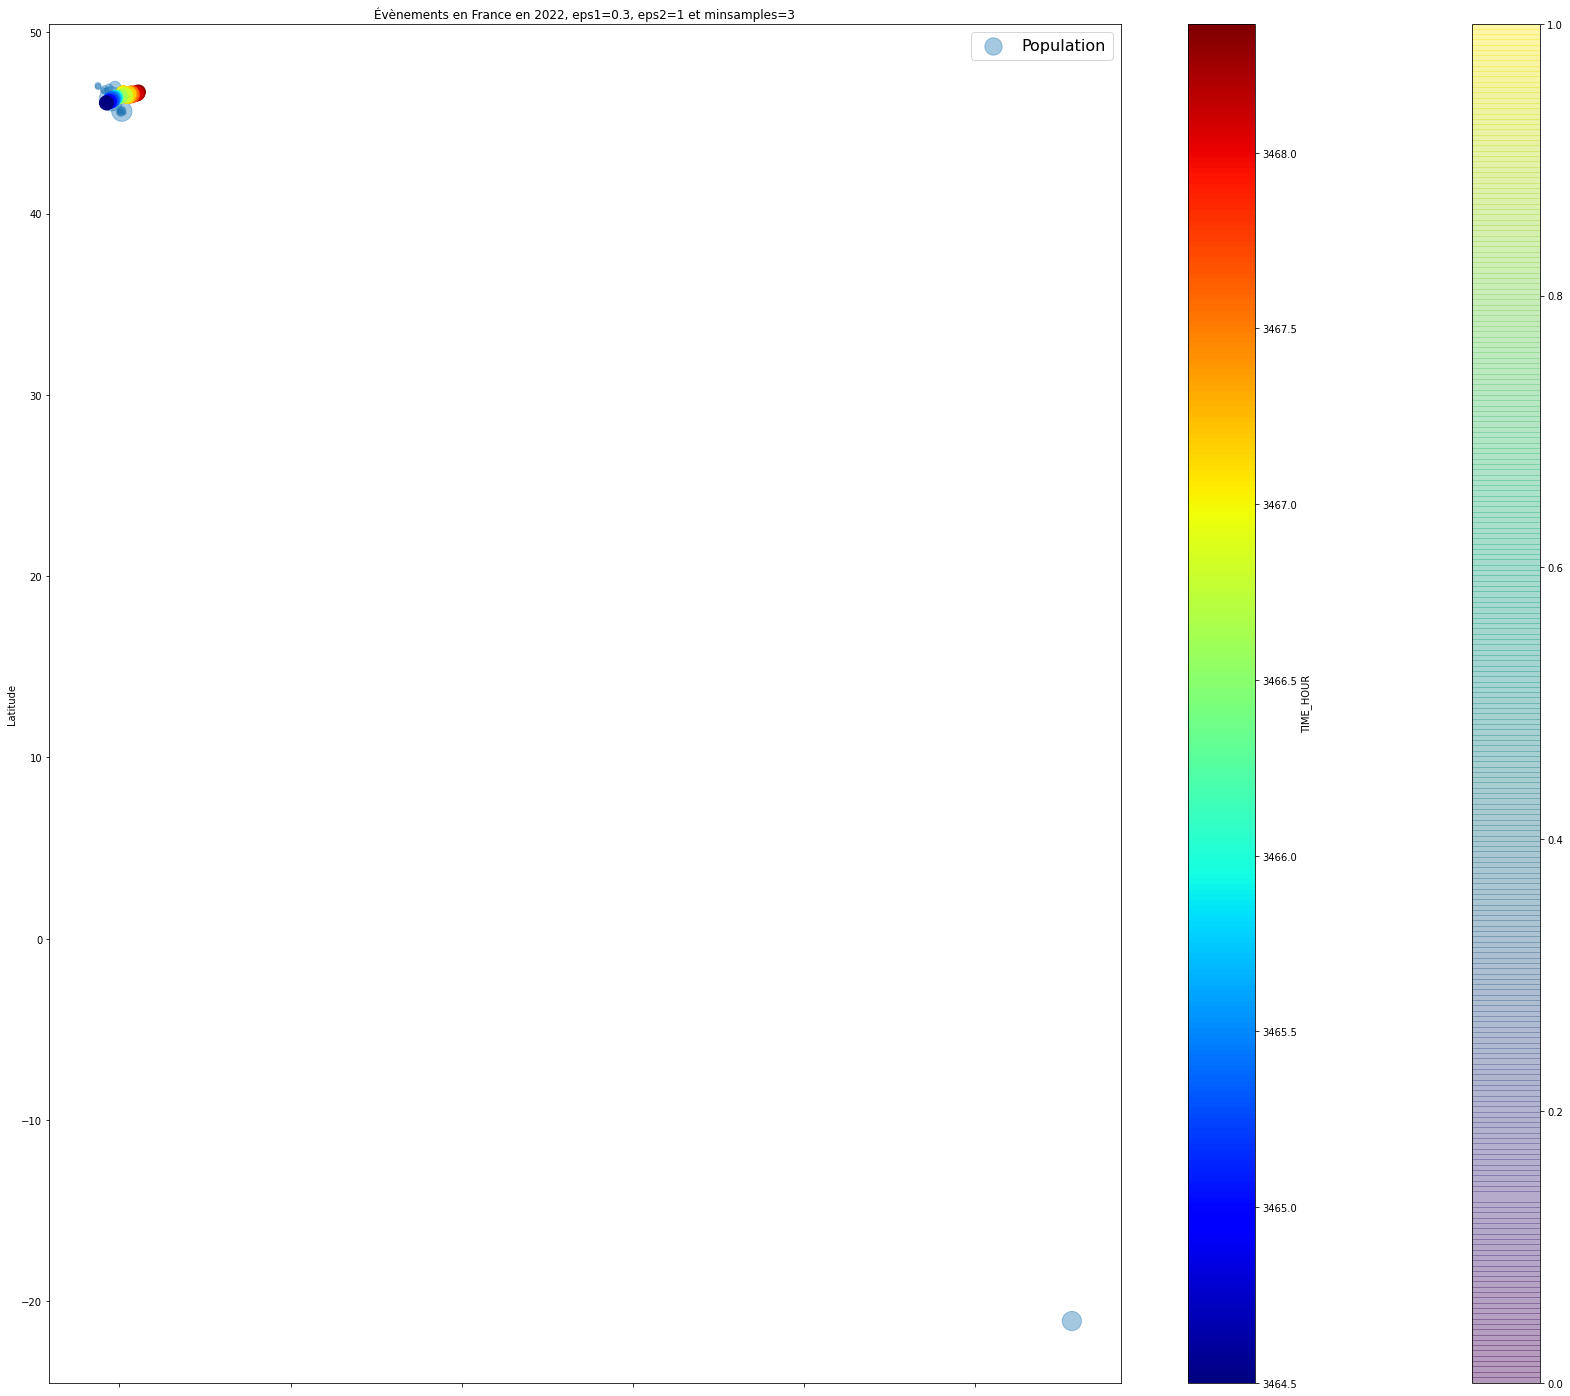

<ipython-input-37-4213b9b02d9f>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clst['TIME_HOUR']=df_clst.apply(lambda donnee: convert_hour(donnee), axis=1)


        TIME_HOUR  LATITUDE  LONGITUDE  cluster
classe                                         
23             46        46         46       46


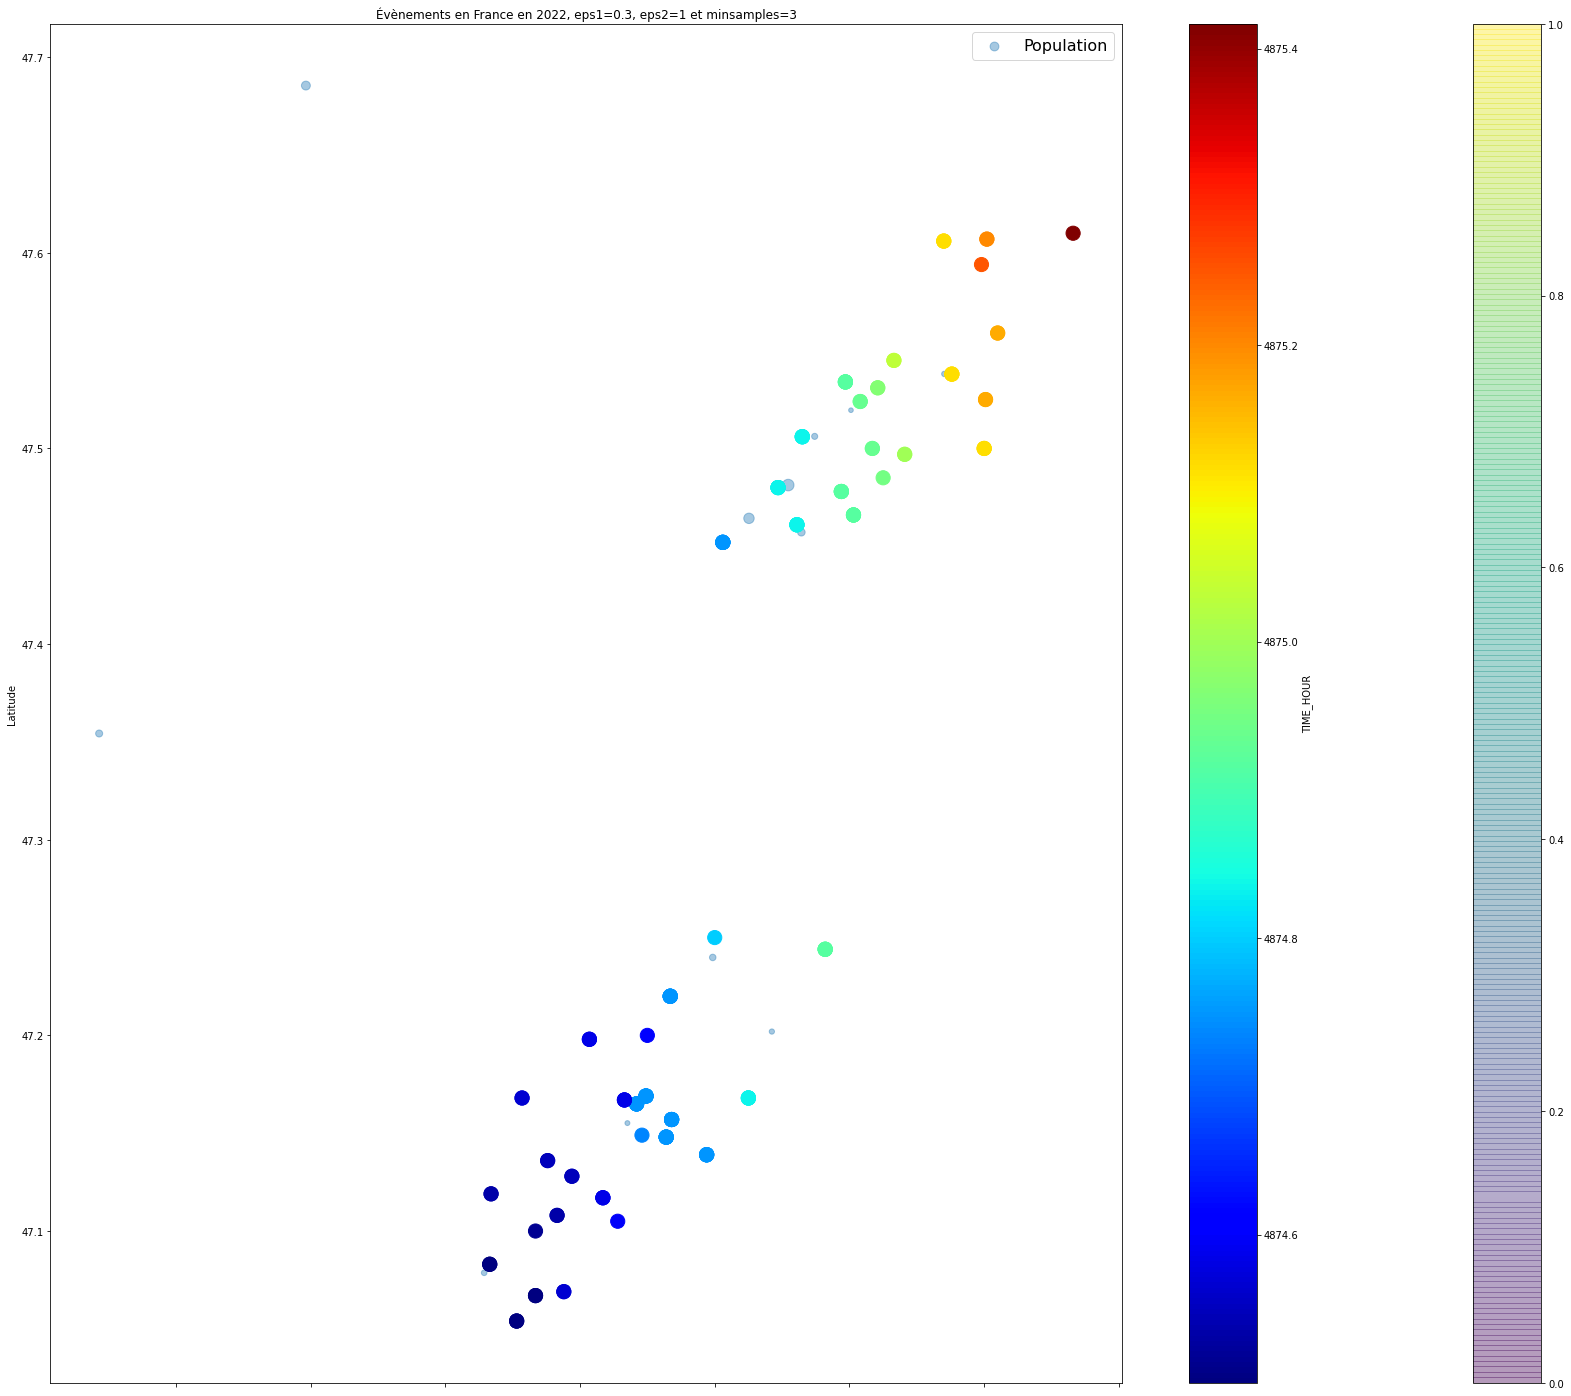

<ipython-input-37-4213b9b02d9f>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clst['TIME_HOUR']=df_clst.apply(lambda donnee: convert_hour(donnee), axis=1)


        TIME_HOUR  LATITUDE  LONGITUDE  cluster
classe                                         
49             41        41         41       41


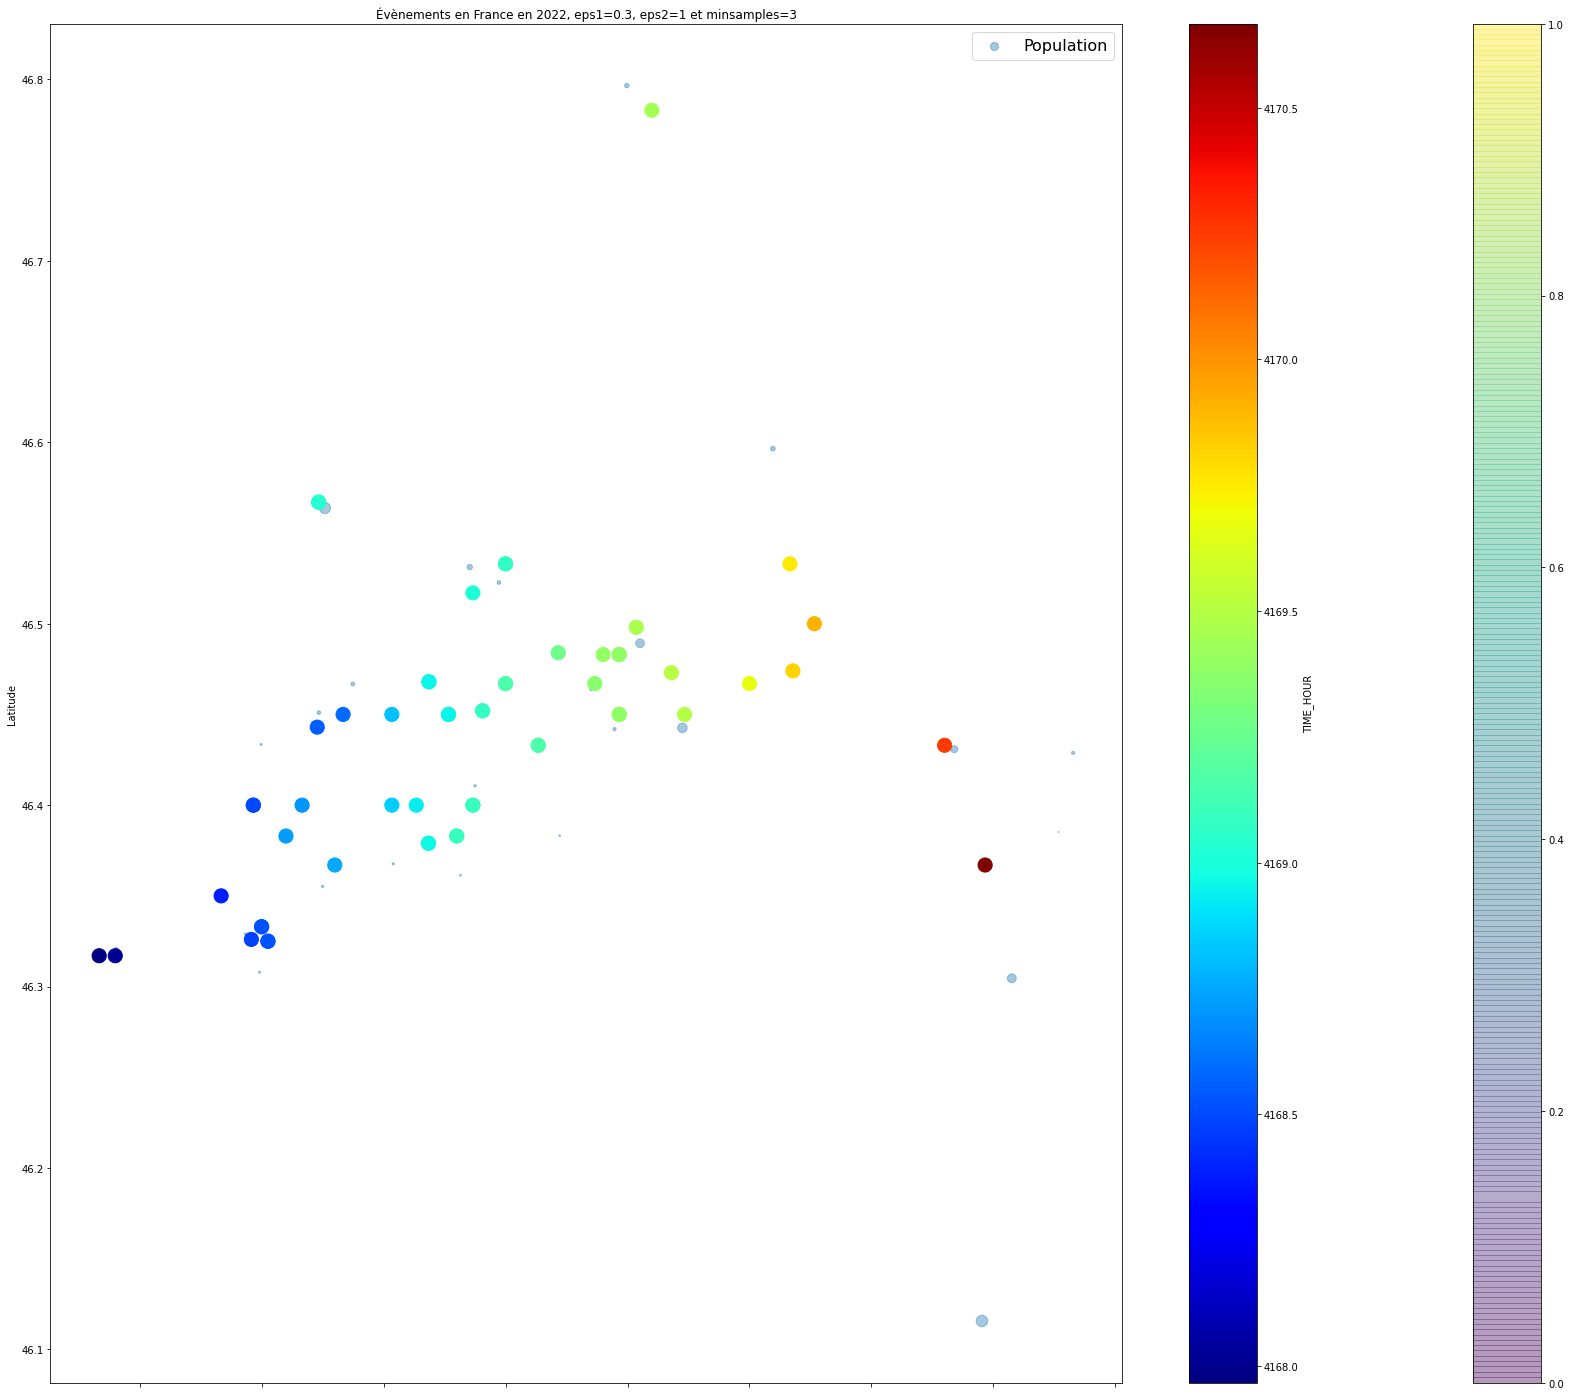

<ipython-input-37-4213b9b02d9f>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clst['TIME_HOUR']=df_clst.apply(lambda donnee: convert_hour(donnee), axis=1)


        TIME_HOUR  LATITUDE  LONGITUDE  cluster
classe                                         
68             38        38         38       38


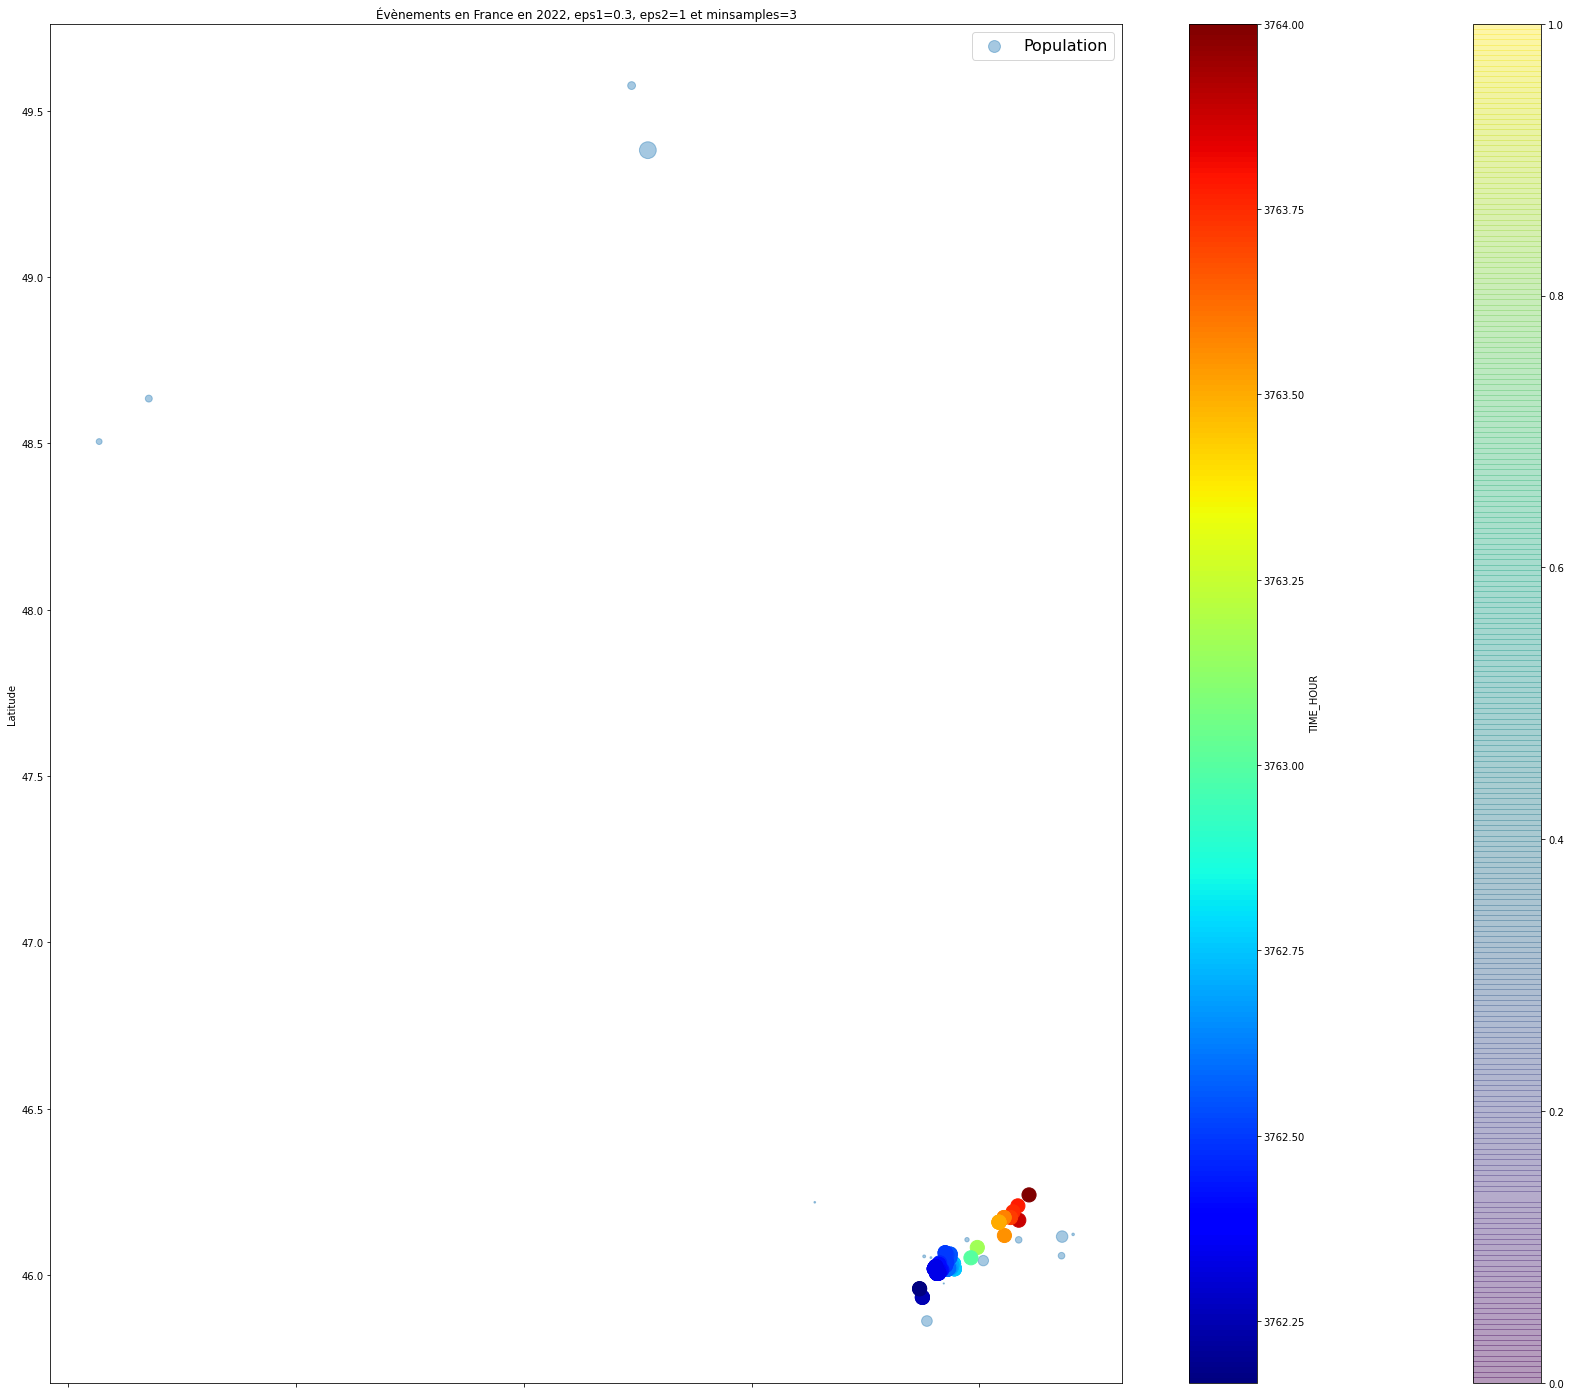

<ipython-input-37-4213b9b02d9f>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clst['TIME_HOUR']=df_clst.apply(lambda donnee: convert_hour(donnee), axis=1)


        TIME_HOUR  LATITUDE  LONGITUDE  cluster
classe                                         
74             37        37         37       37


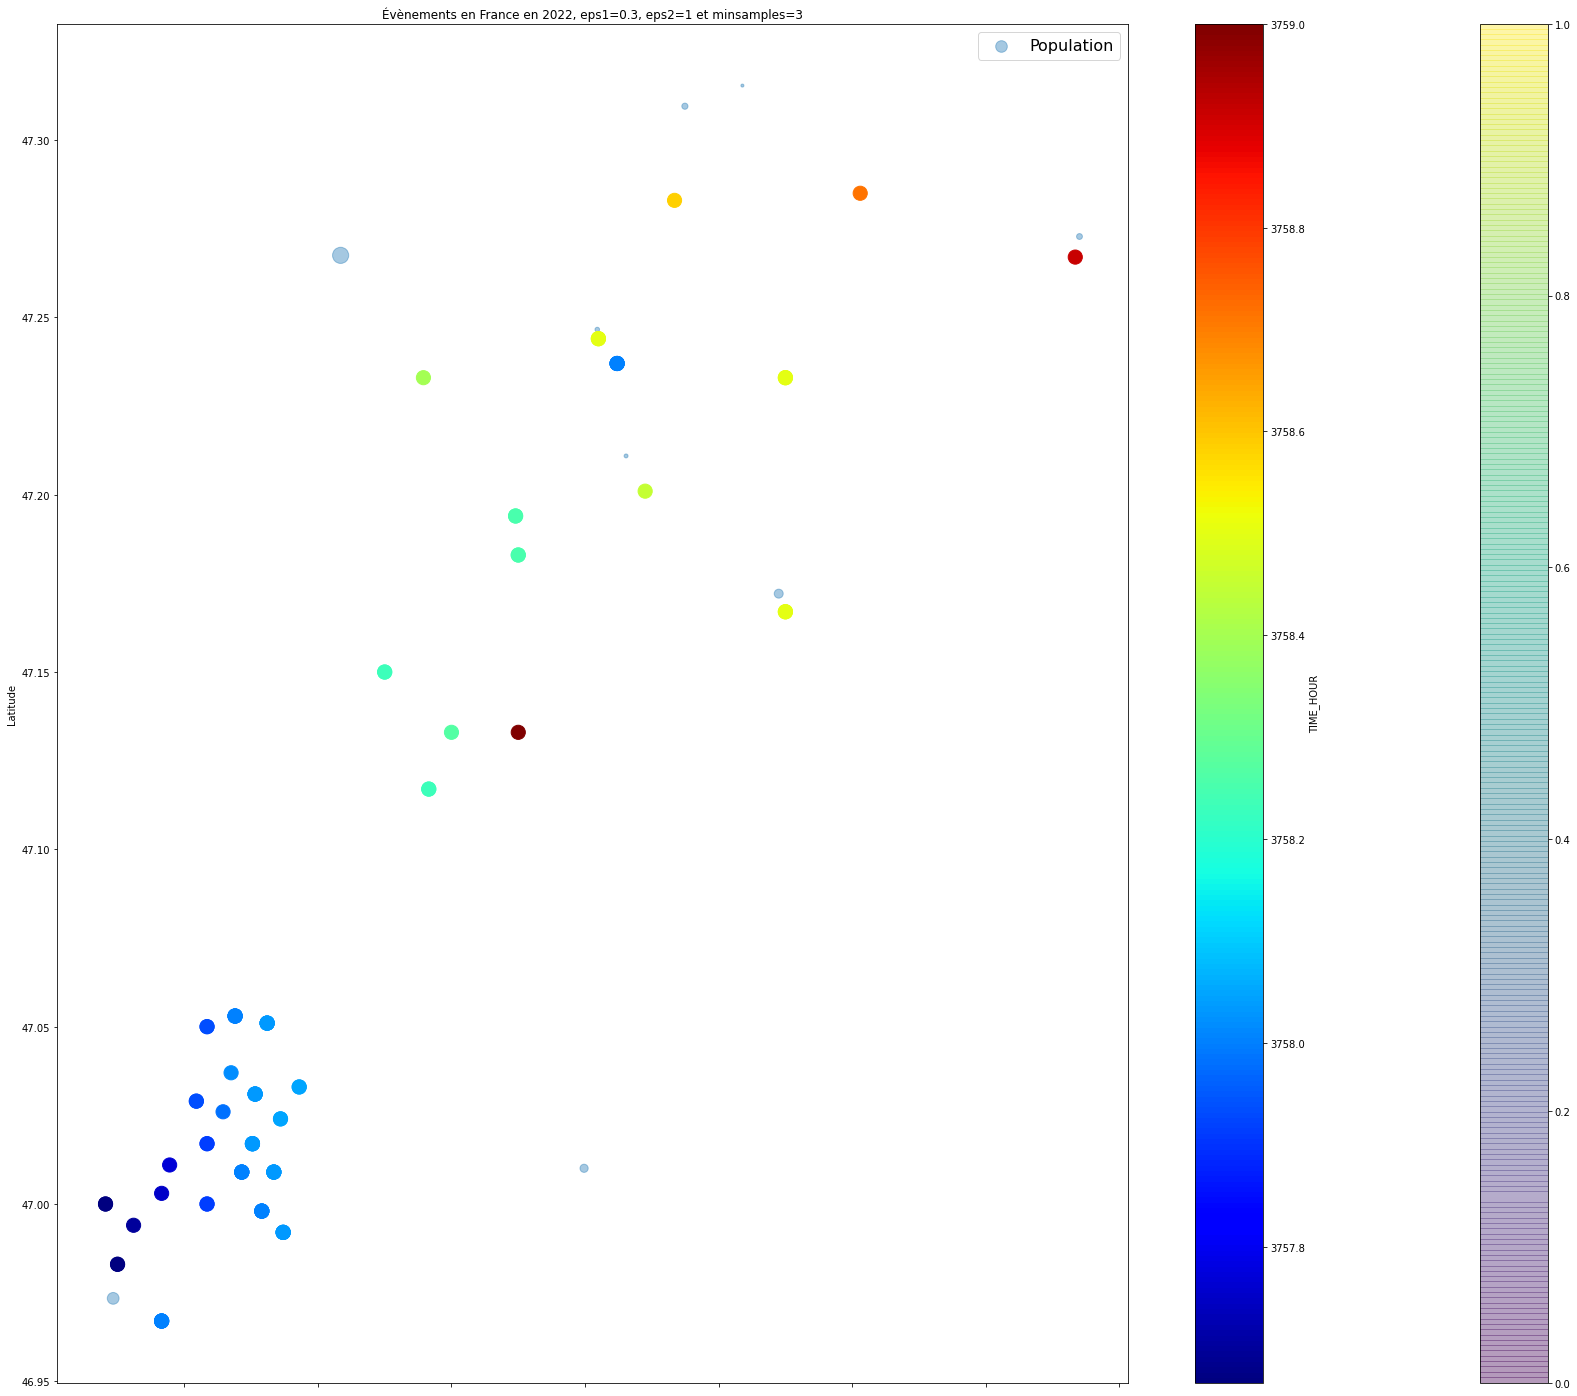

<ipython-input-37-4213b9b02d9f>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clst['TIME_HOUR']=df_clst.apply(lambda donnee: convert_hour(donnee), axis=1)


        TIME_HOUR  LATITUDE  LONGITUDE  cluster
classe                                         
28             36        36         36       36


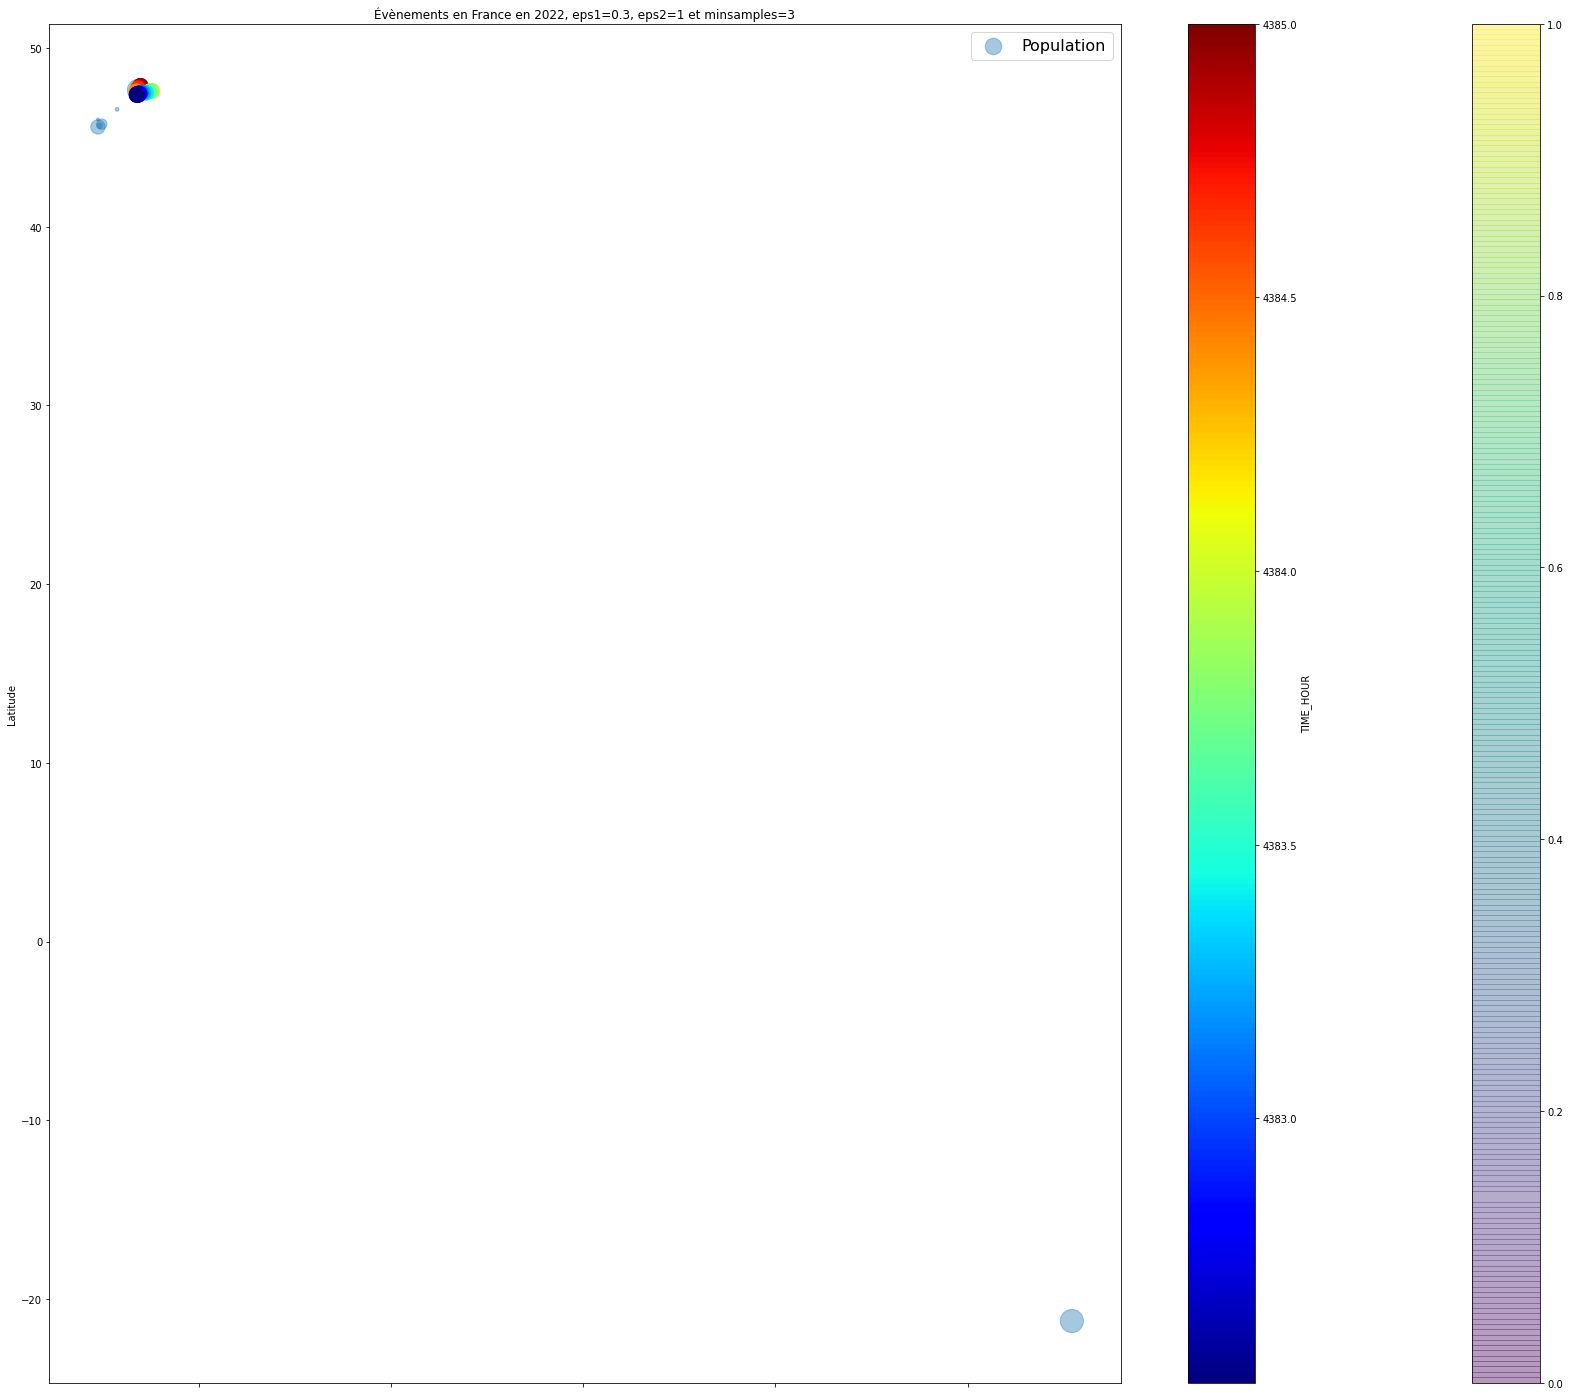

<ipython-input-37-4213b9b02d9f>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clst['TIME_HOUR']=df_clst.apply(lambda donnee: convert_hour(donnee), axis=1)


        TIME_HOUR  LATITUDE  LONGITUDE  cluster
classe                                         
80             32        32         32       32


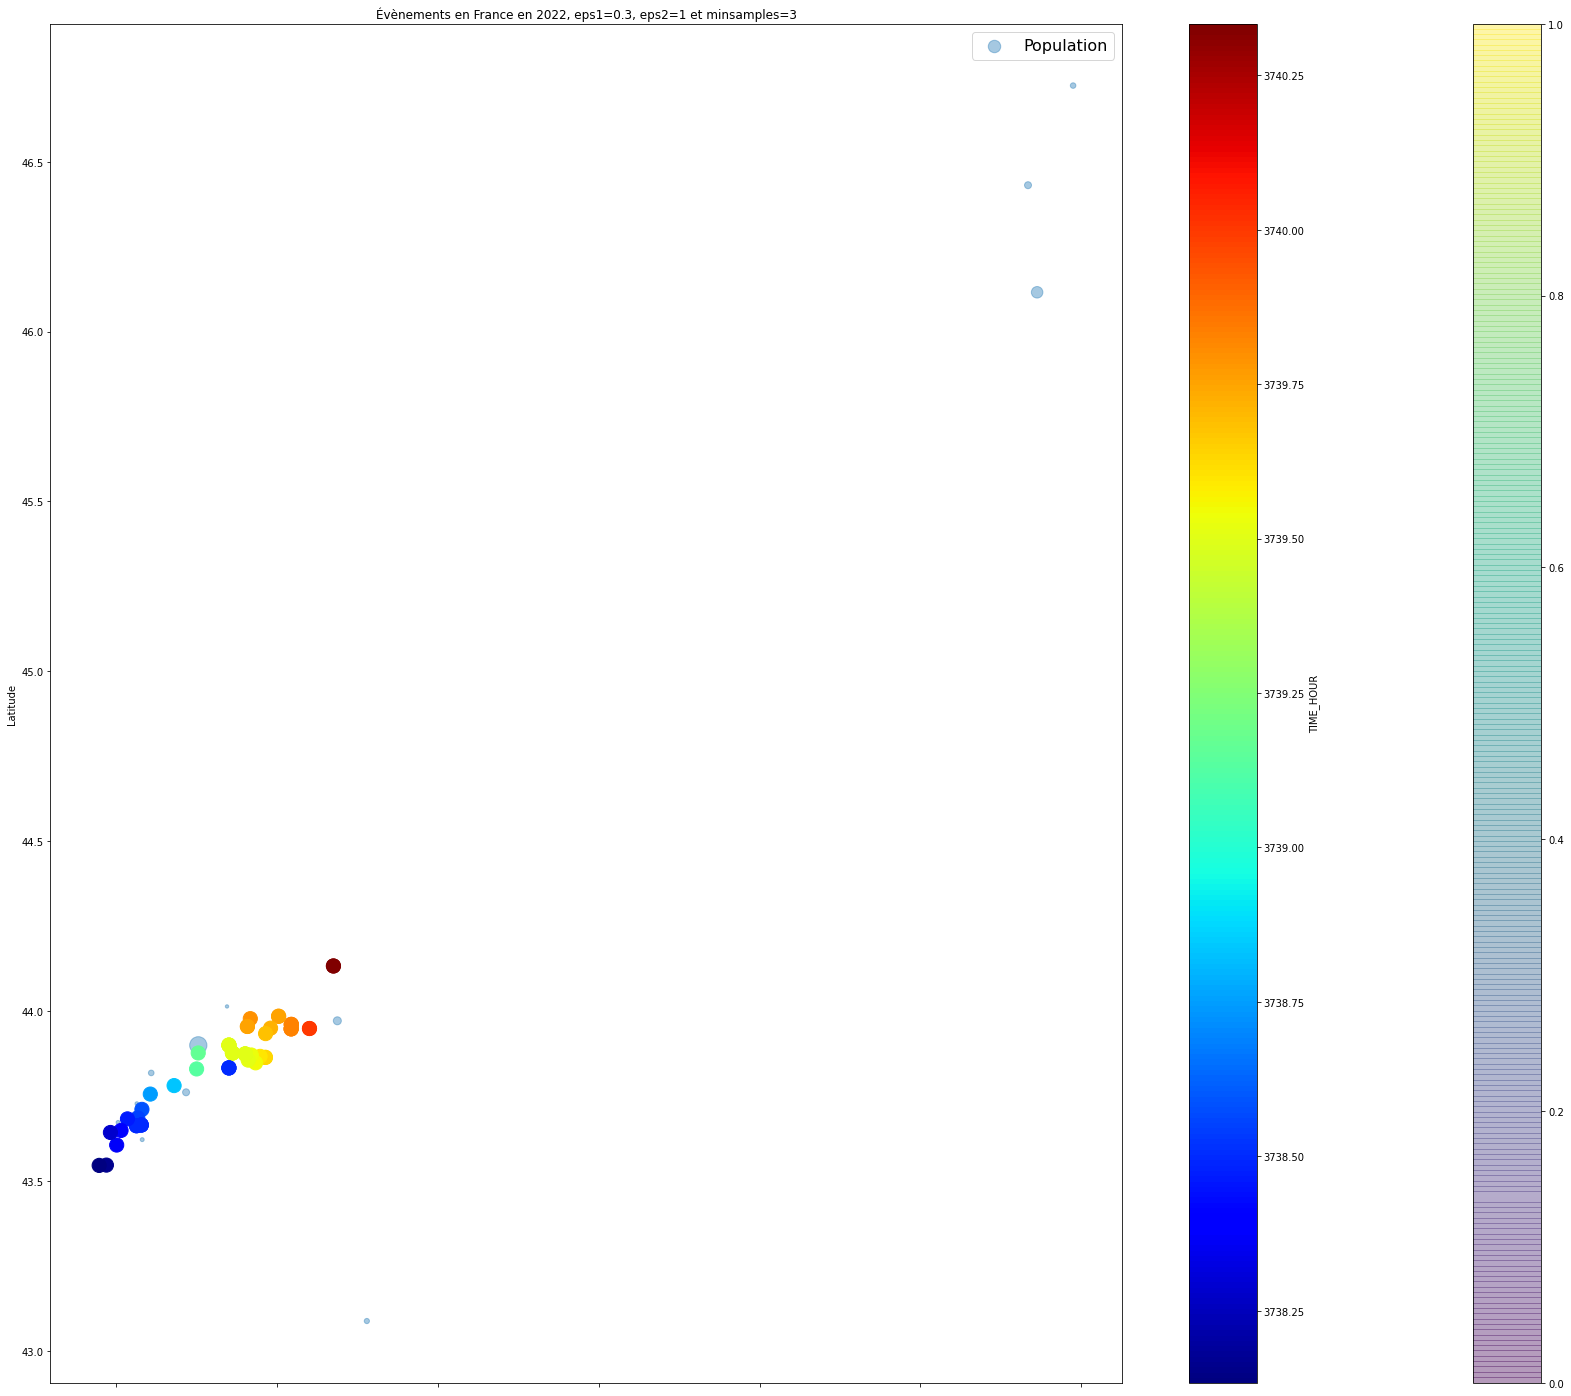

<ipython-input-37-4213b9b02d9f>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clst['TIME_HOUR']=df_clst.apply(lambda donnee: convert_hour(donnee), axis=1)


        TIME_HOUR  LATITUDE  LONGITUDE  cluster
classe                                         
79             31        31         31       31


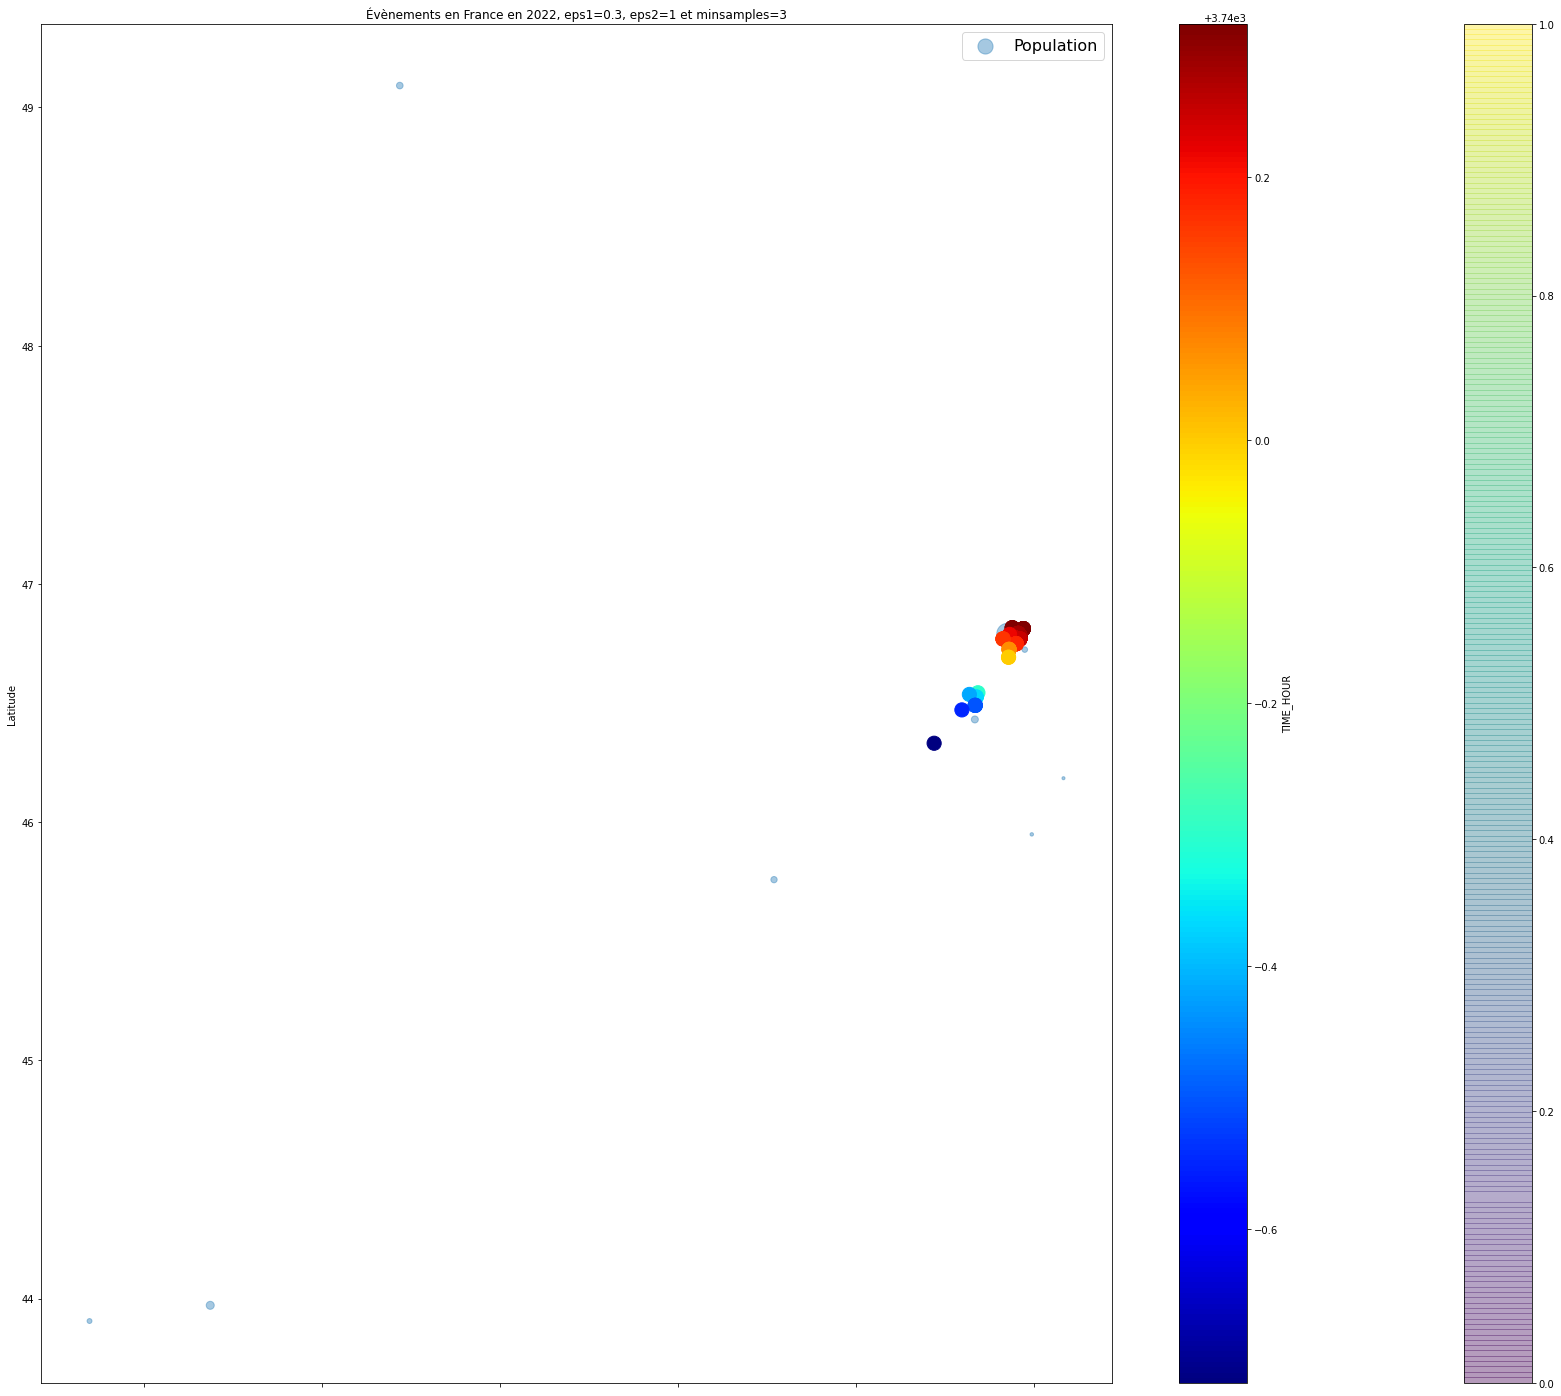

<ipython-input-37-4213b9b02d9f>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clst['TIME_HOUR']=df_clst.apply(lambda donnee: convert_hour(donnee), axis=1)


        TIME_HOUR  LATITUDE  LONGITUDE  cluster
classe                                         
91             29        29         29       29


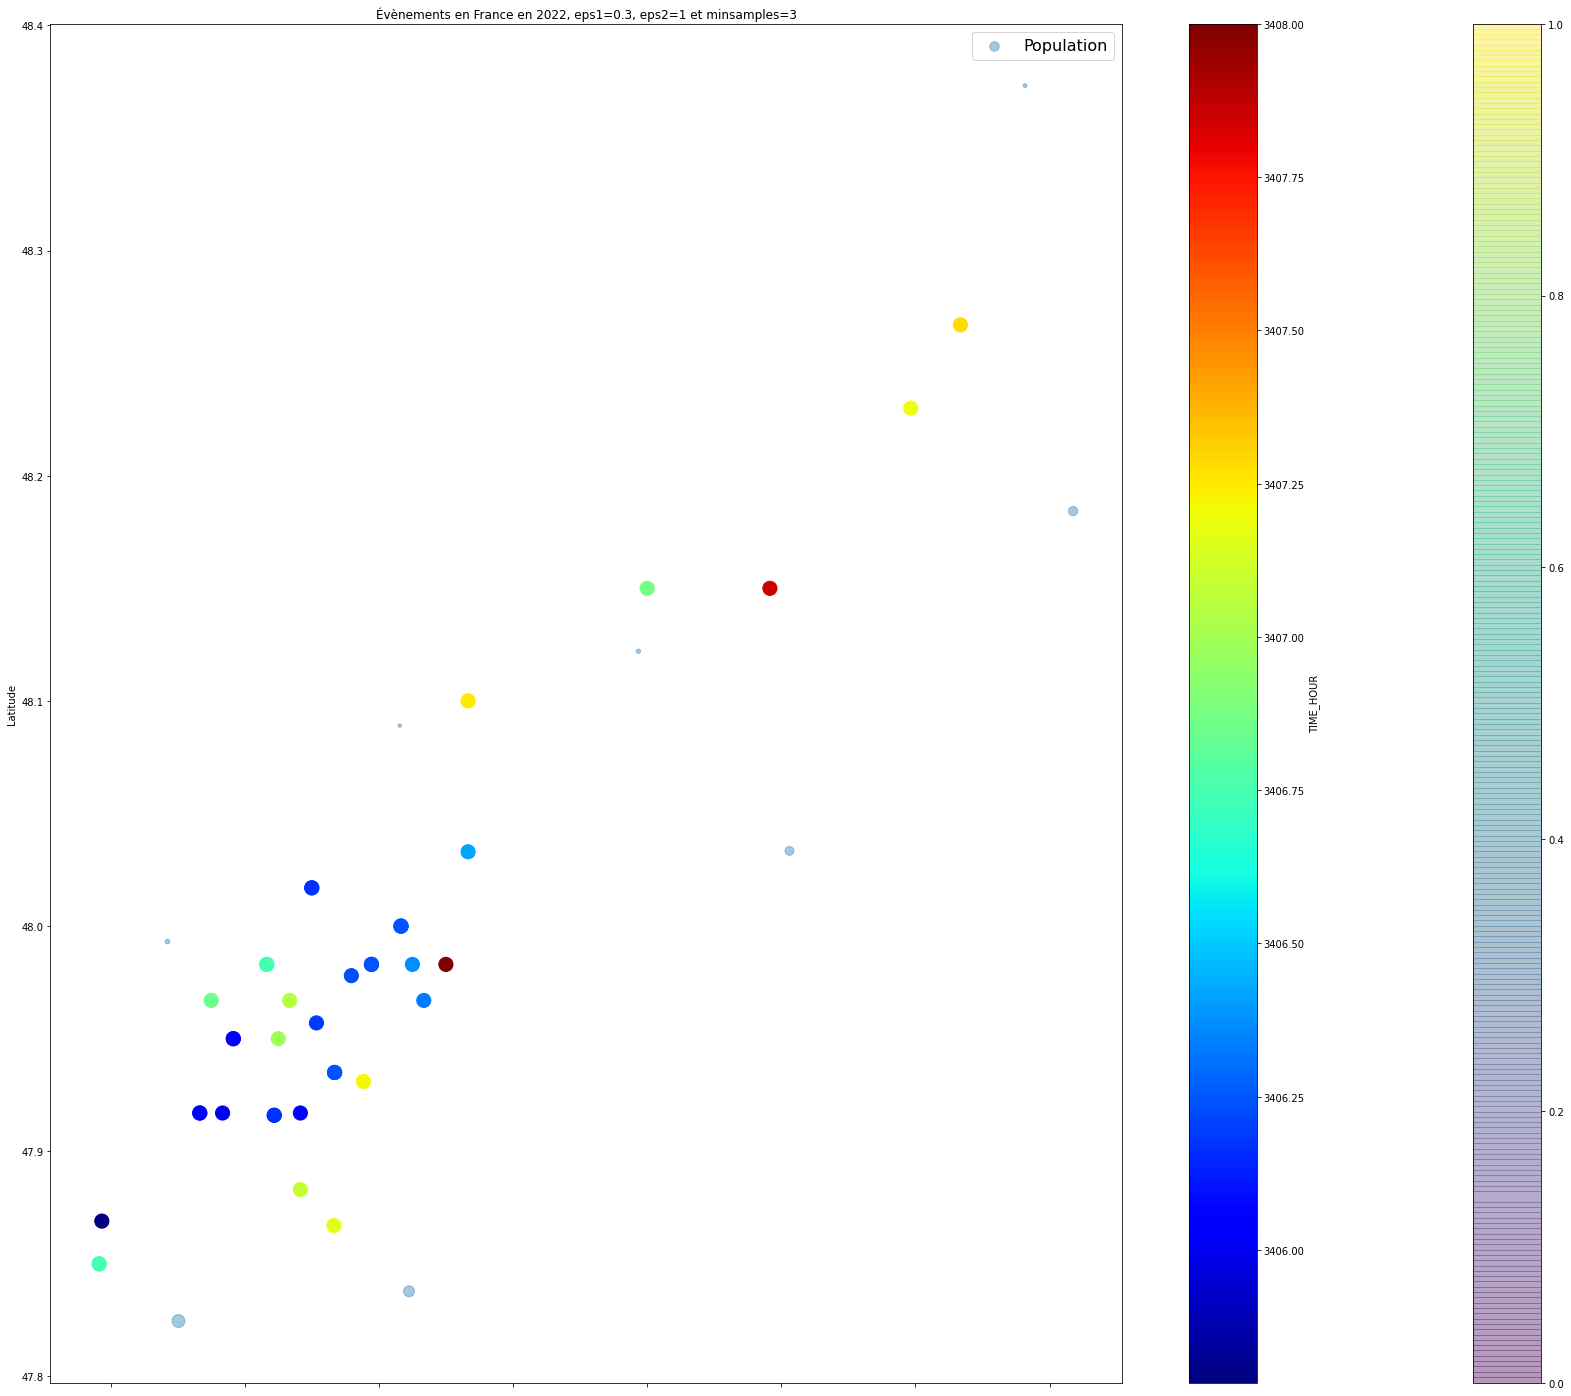

<ipython-input-37-4213b9b02d9f>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clst['TIME_HOUR']=df_clst.apply(lambda donnee: convert_hour(donnee), axis=1)


        TIME_HOUR  LATITUDE  LONGITUDE  cluster
classe                                         
50             22        22         22       22


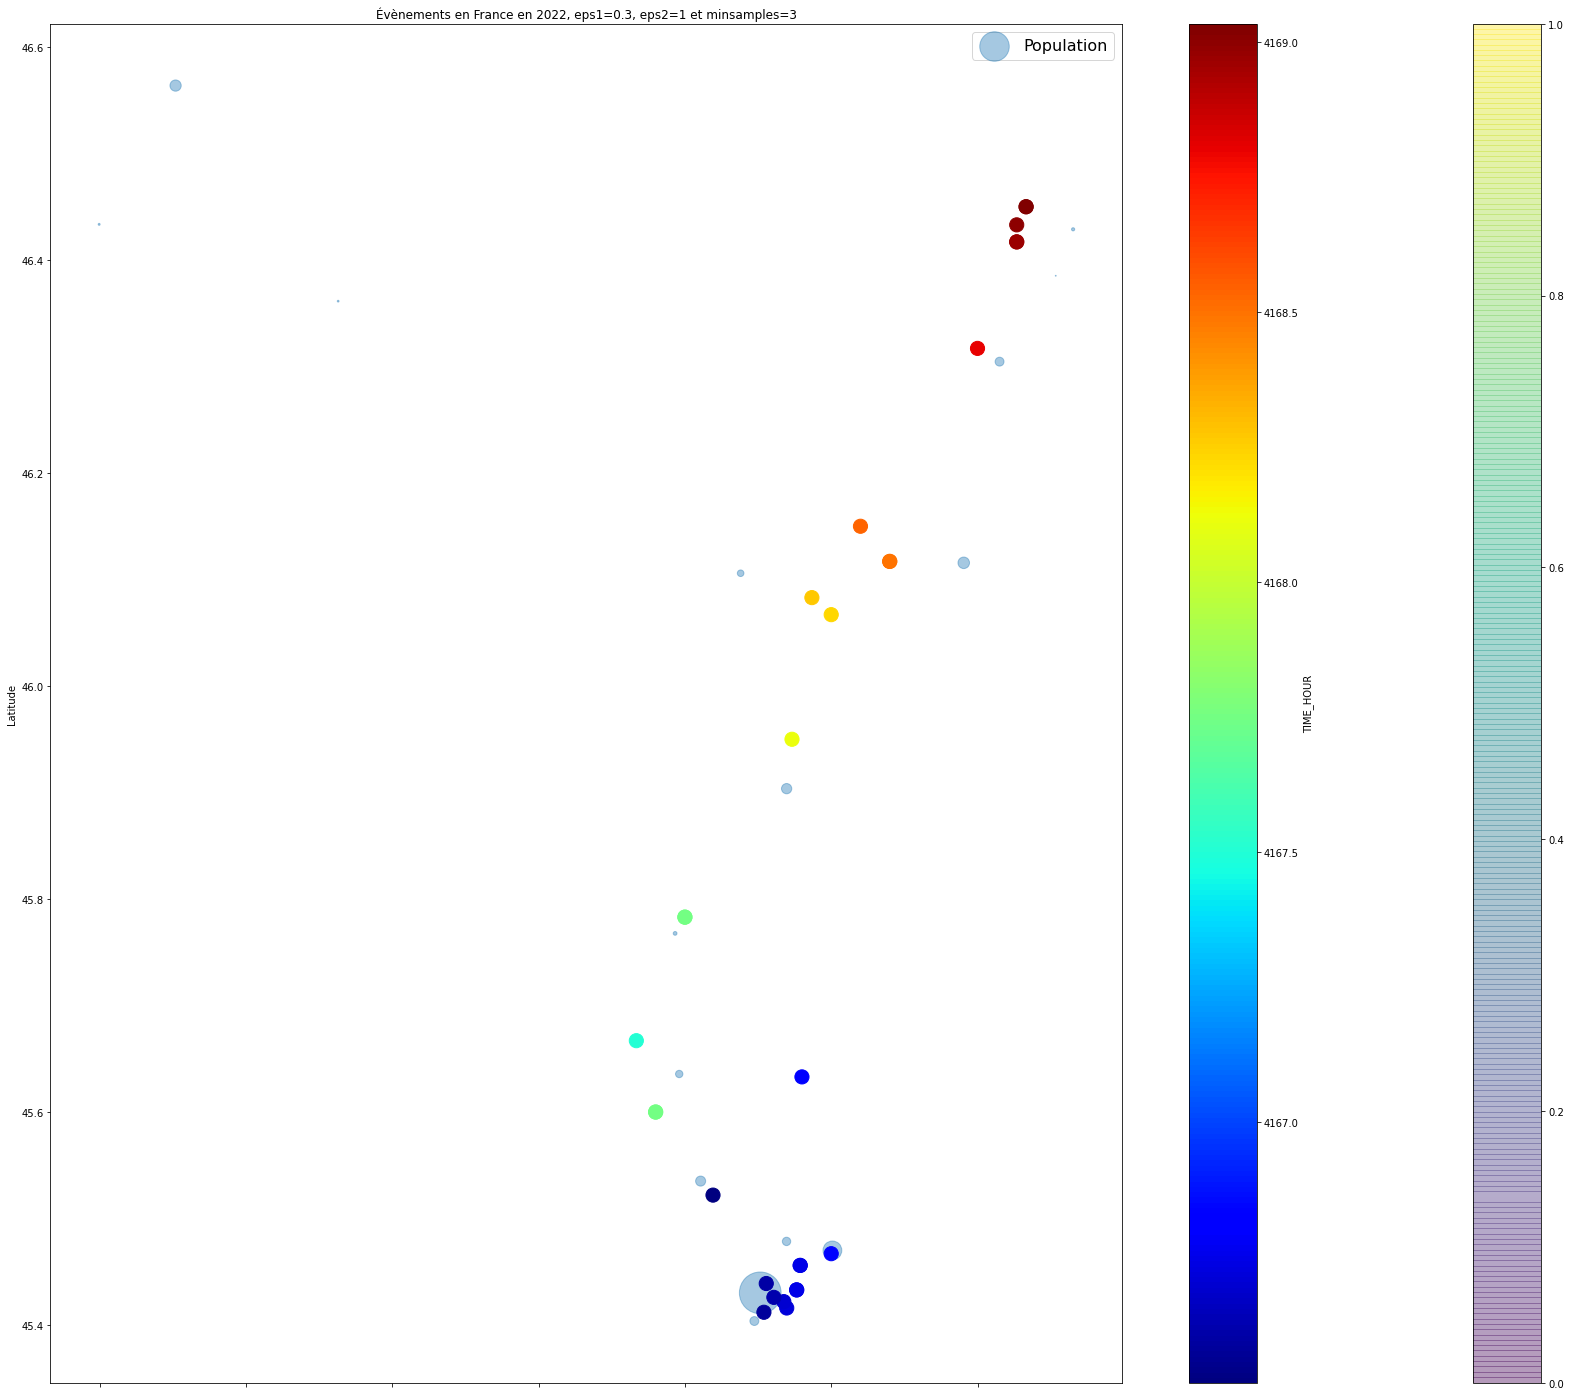

<ipython-input-37-4213b9b02d9f>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clst['TIME_HOUR']=df_clst.apply(lambda donnee: convert_hour(donnee), axis=1)


        TIME_HOUR  LATITUDE  LONGITUDE  cluster
classe                                         
10             21        21         21       21
24             21        21         21       21
27             21        21         21       21
62             21        21         21       21
85             21        21         21       21


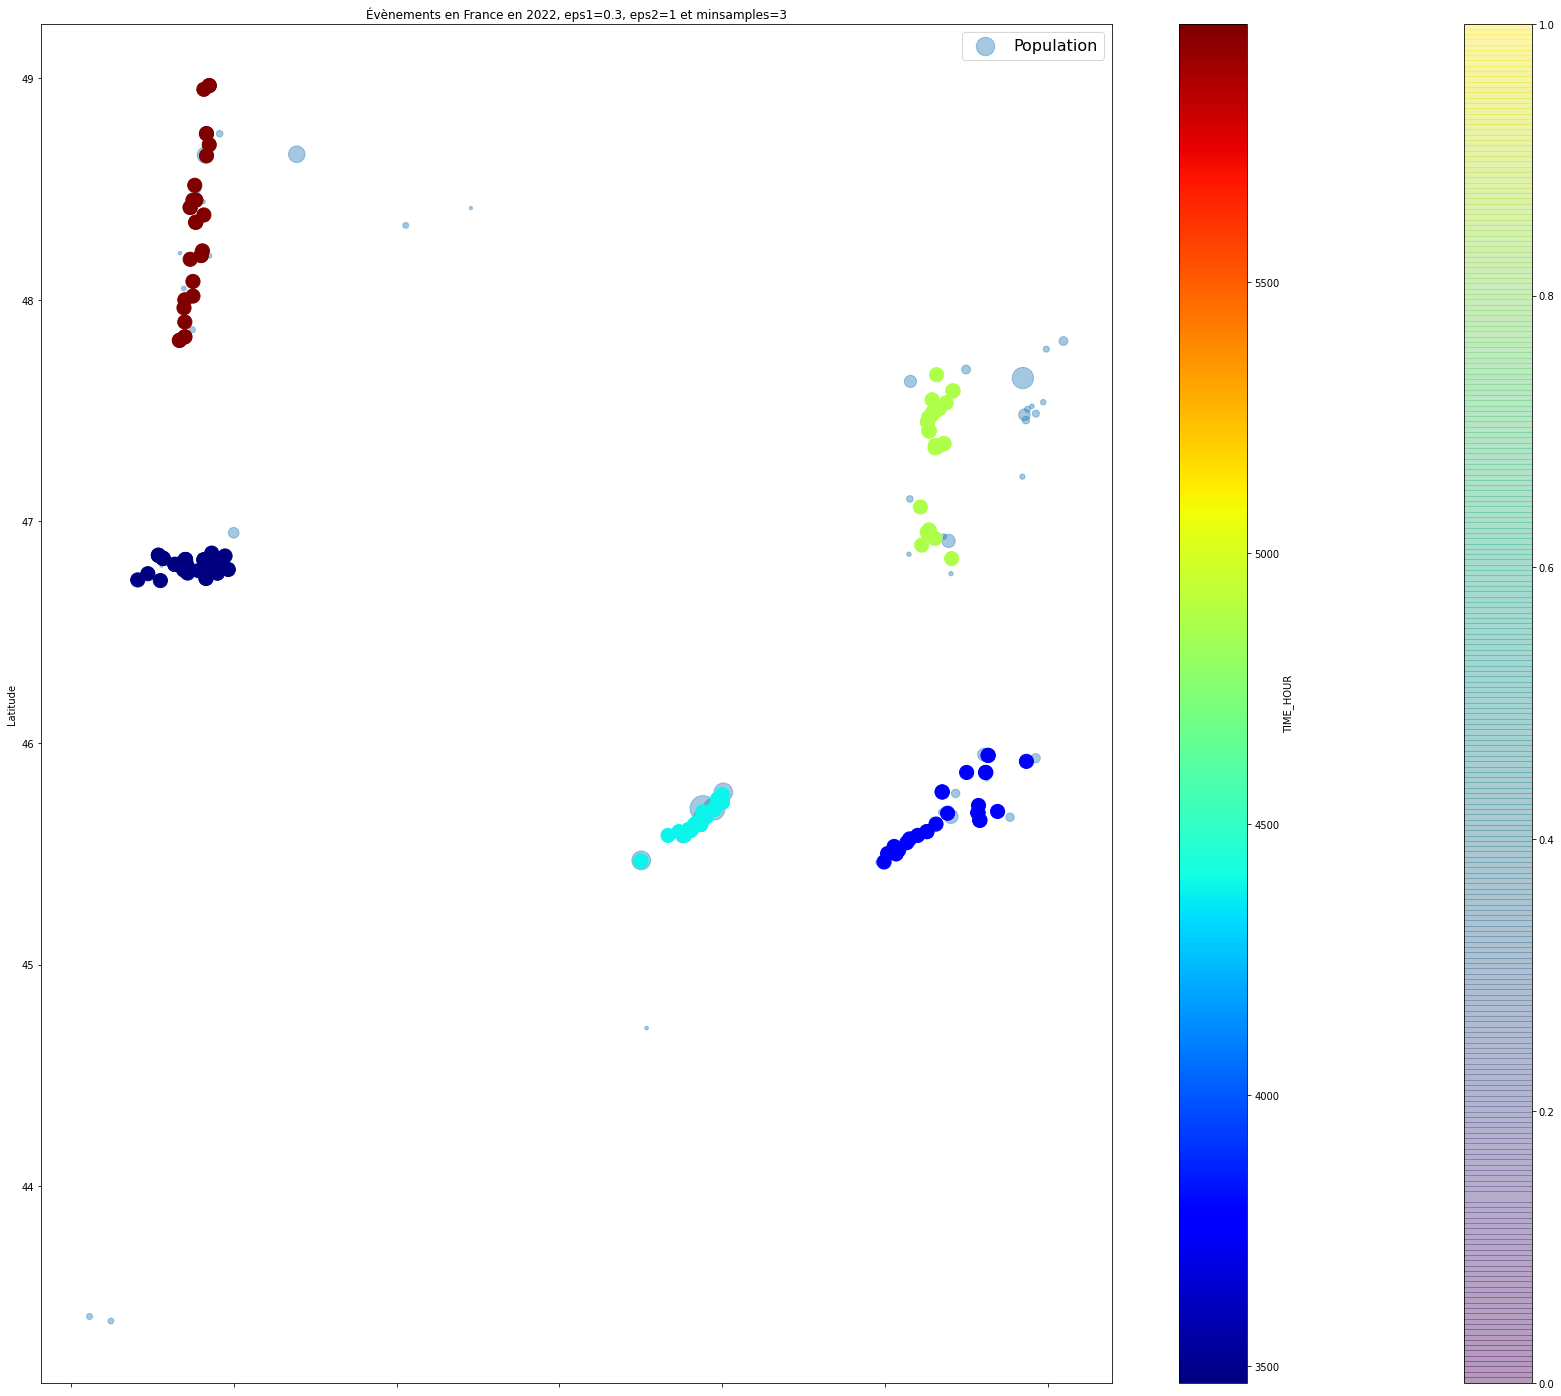

<ipython-input-37-4213b9b02d9f>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clst['TIME_HOUR']=df_clst.apply(lambda donnee: convert_hour(donnee), axis=1)


        TIME_HOUR  LATITUDE  LONGITUDE  cluster
classe                                         
2              20        20         20       20


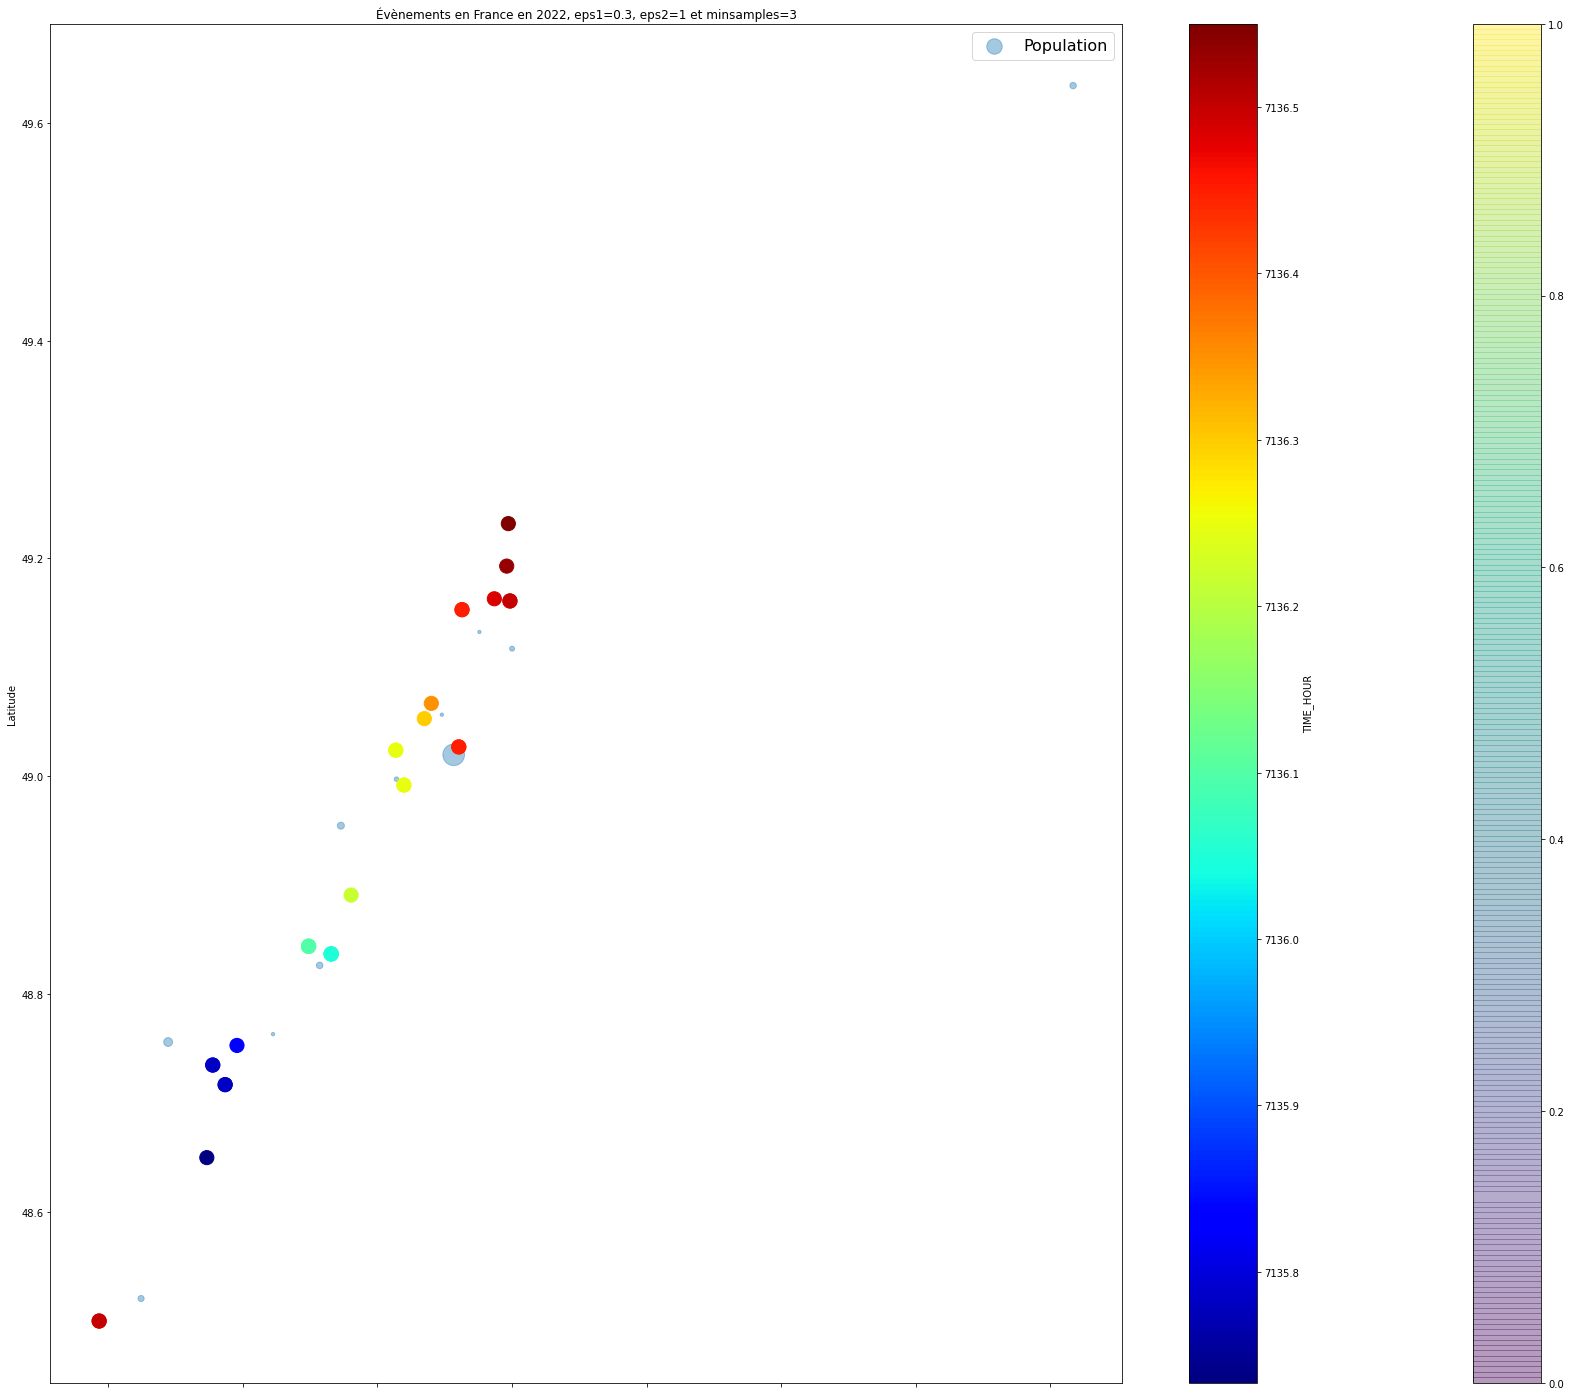

<ipython-input-37-4213b9b02d9f>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clst['TIME_HOUR']=df_clst.apply(lambda donnee: convert_hour(donnee), axis=1)


        TIME_HOUR  LATITUDE  LONGITUDE  cluster
classe                                         
9              18        18         18       18
56             18        18         18       18
87             18        18         18       18


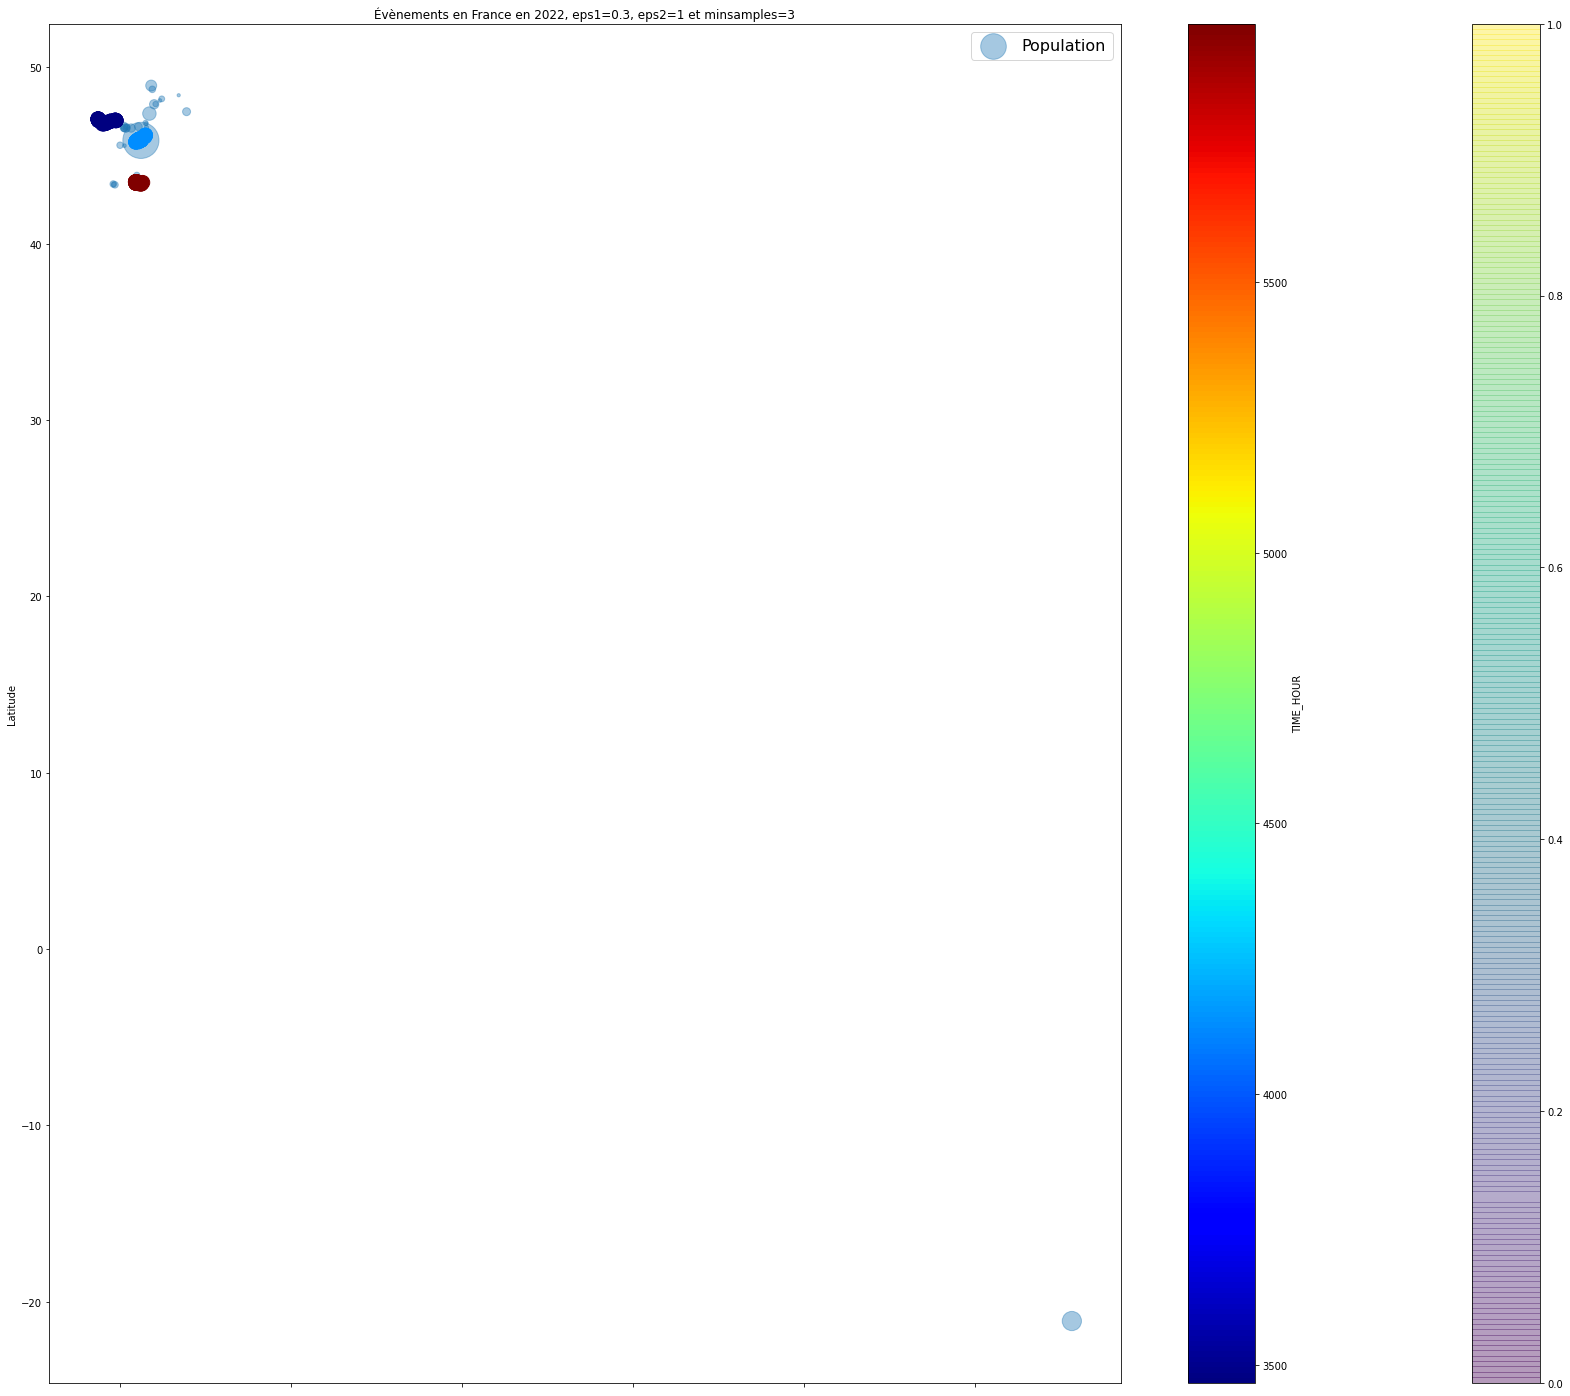

In [ ]:
for i in range(20):
  stdbscan_demog_fr4(2022,0.3, 1, 3,i)

<ipython-input-37-4213b9b02d9f>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clst['TIME_HOUR']=df_clst.apply(lambda donnee: convert_hour(donnee), axis=1)


        TIME_HOUR  LATITUDE  LONGITUDE  cluster
classe                                         
95            136       136        136      136


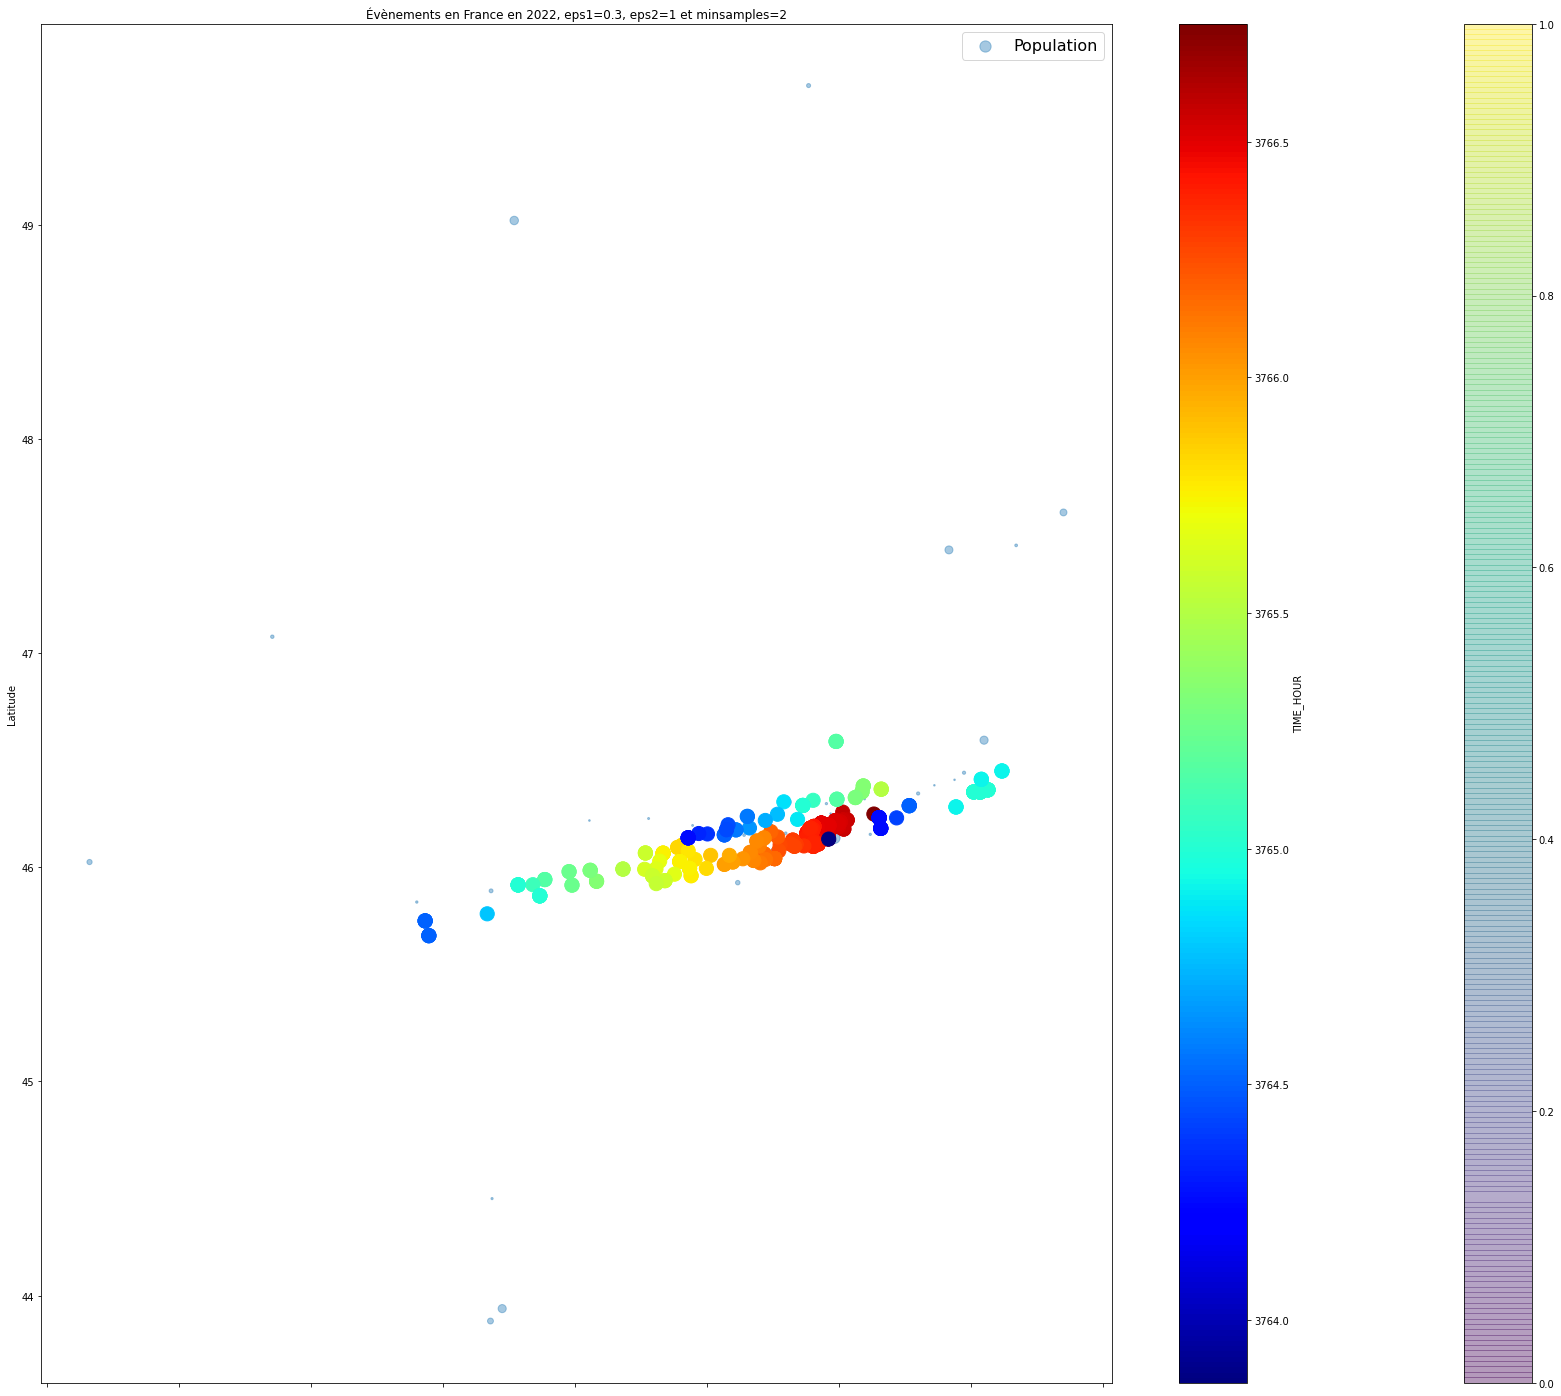

<ipython-input-37-4213b9b02d9f>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clst['TIME_HOUR']=df_clst.apply(lambda donnee: convert_hour(donnee), axis=1)


        TIME_HOUR  LATITUDE  LONGITUDE  cluster
classe                                         
49            134       134        134      134


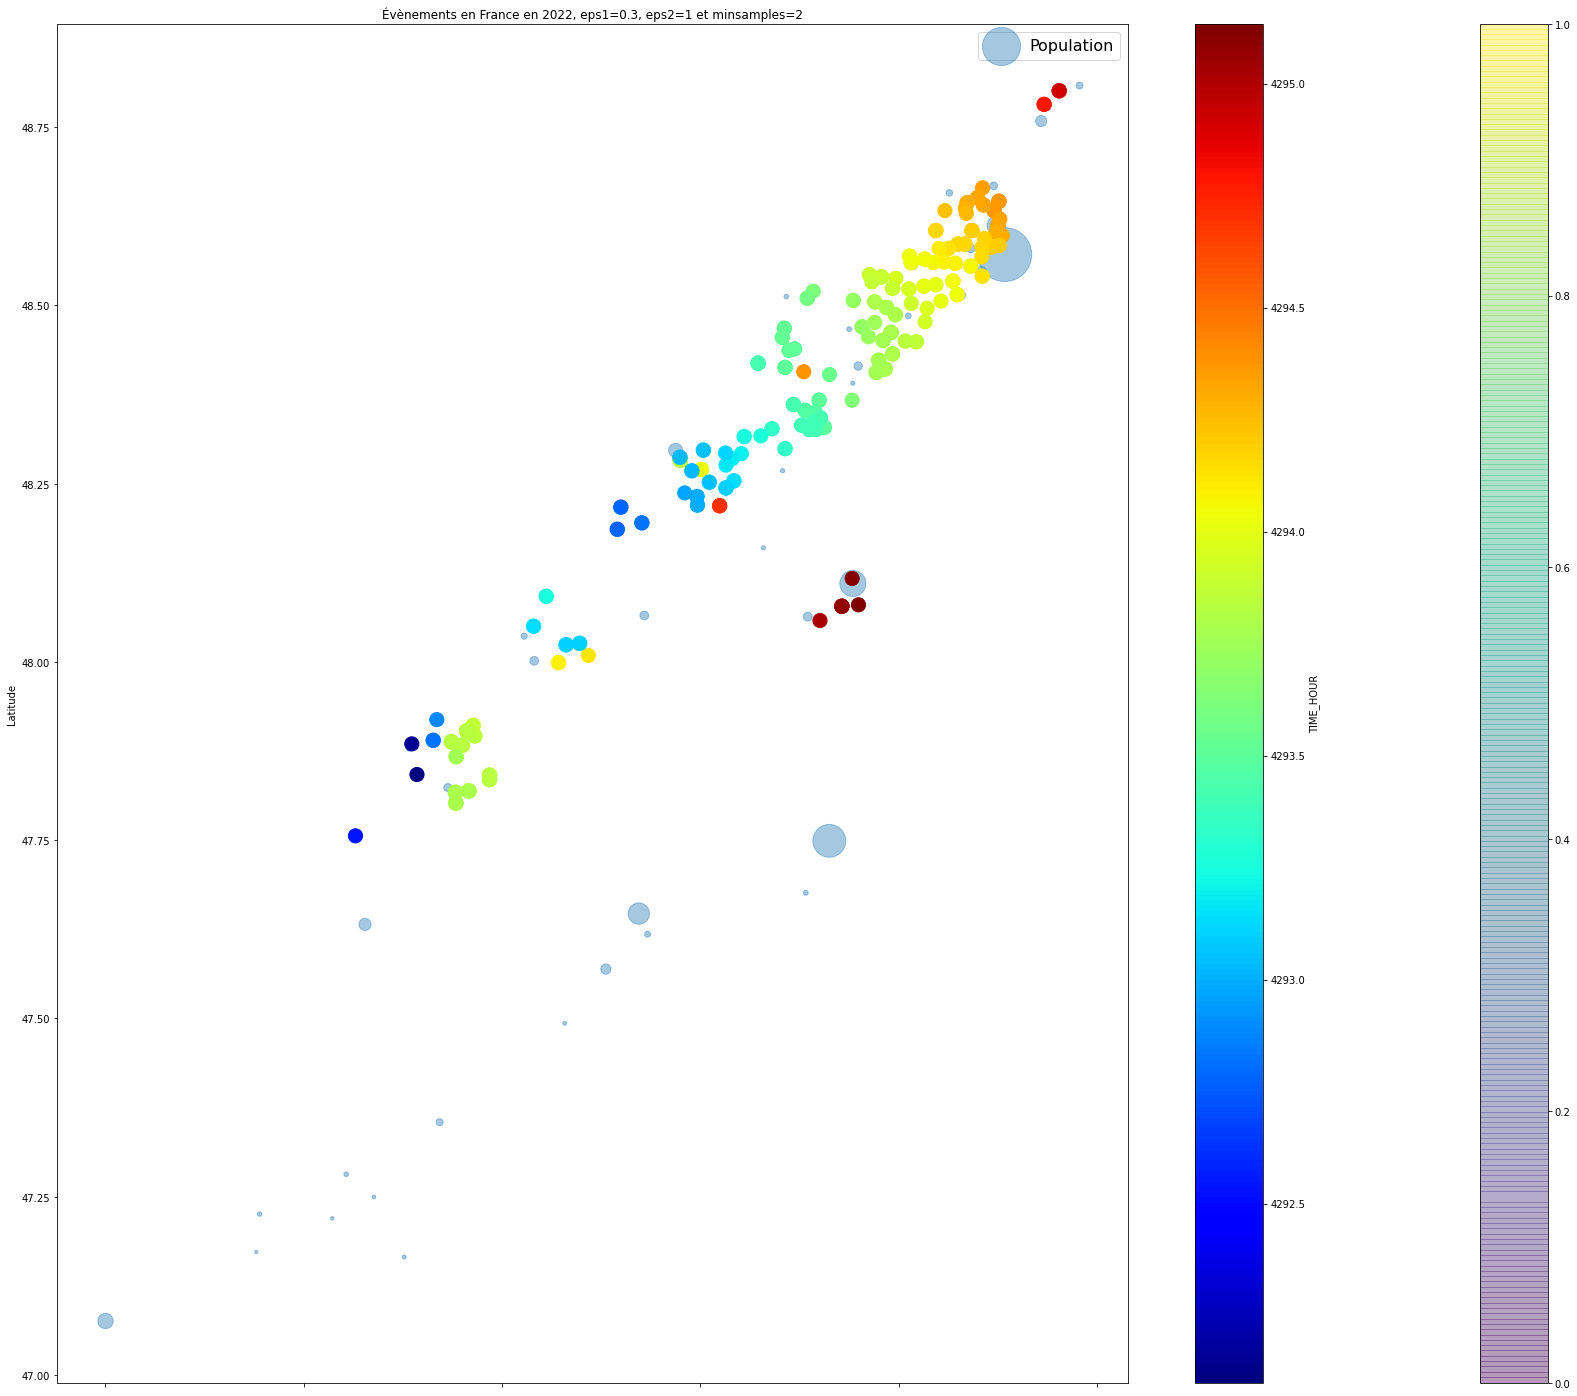

<ipython-input-37-4213b9b02d9f>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clst['TIME_HOUR']=df_clst.apply(lambda donnee: convert_hour(donnee), axis=1)


        TIME_HOUR  LATITUDE  LONGITUDE  cluster
classe                                         
121           117       117        117      117


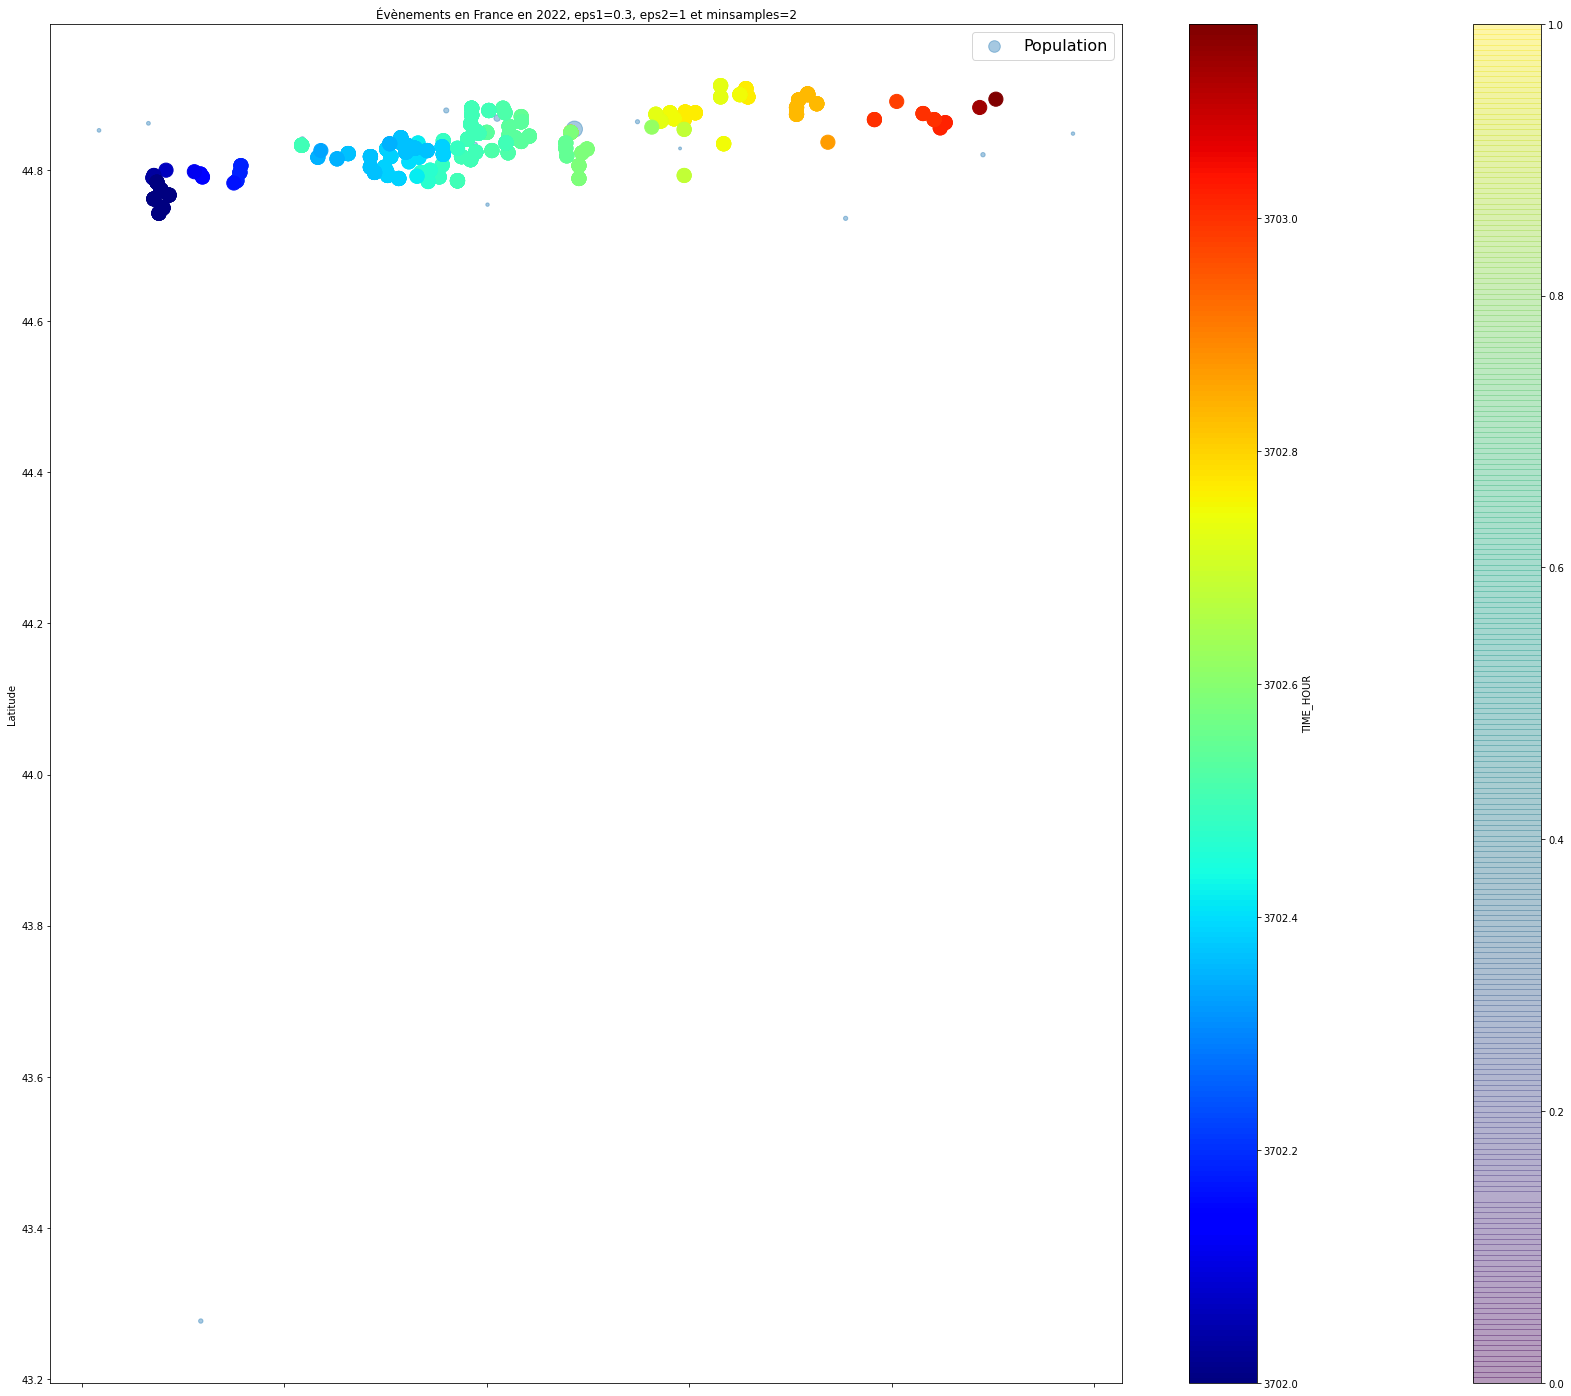

<ipython-input-37-4213b9b02d9f>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clst['TIME_HOUR']=df_clst.apply(lambda donnee: convert_hour(donnee), axis=1)


        TIME_HOUR  LATITUDE  LONGITUDE  cluster
classe                                         
-1            113       113        113      113
 76           113       113        113      113


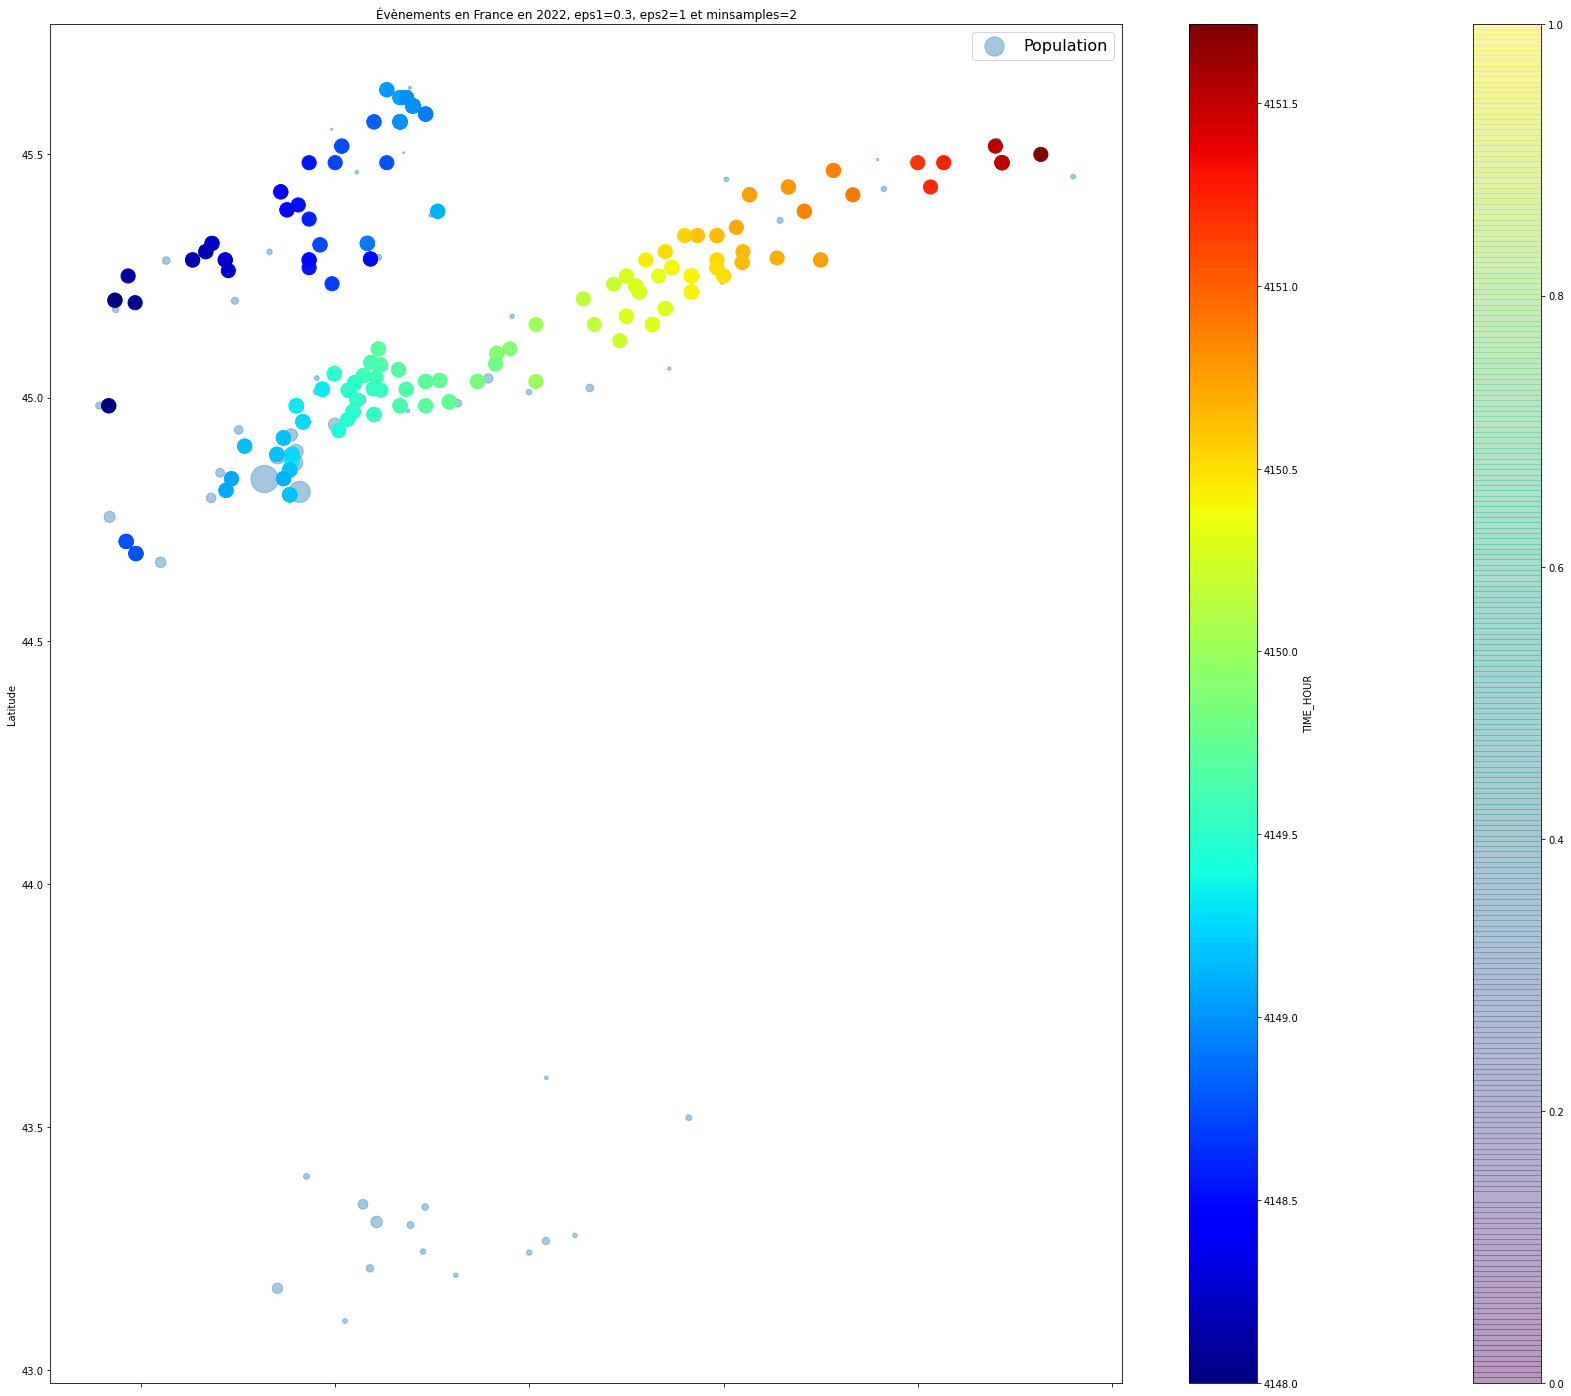

<ipython-input-37-4213b9b02d9f>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clst['TIME_HOUR']=df_clst.apply(lambda donnee: convert_hour(donnee), axis=1)


        TIME_HOUR  LATITUDE  LONGITUDE  cluster
classe                                         
48            110       110        110      110


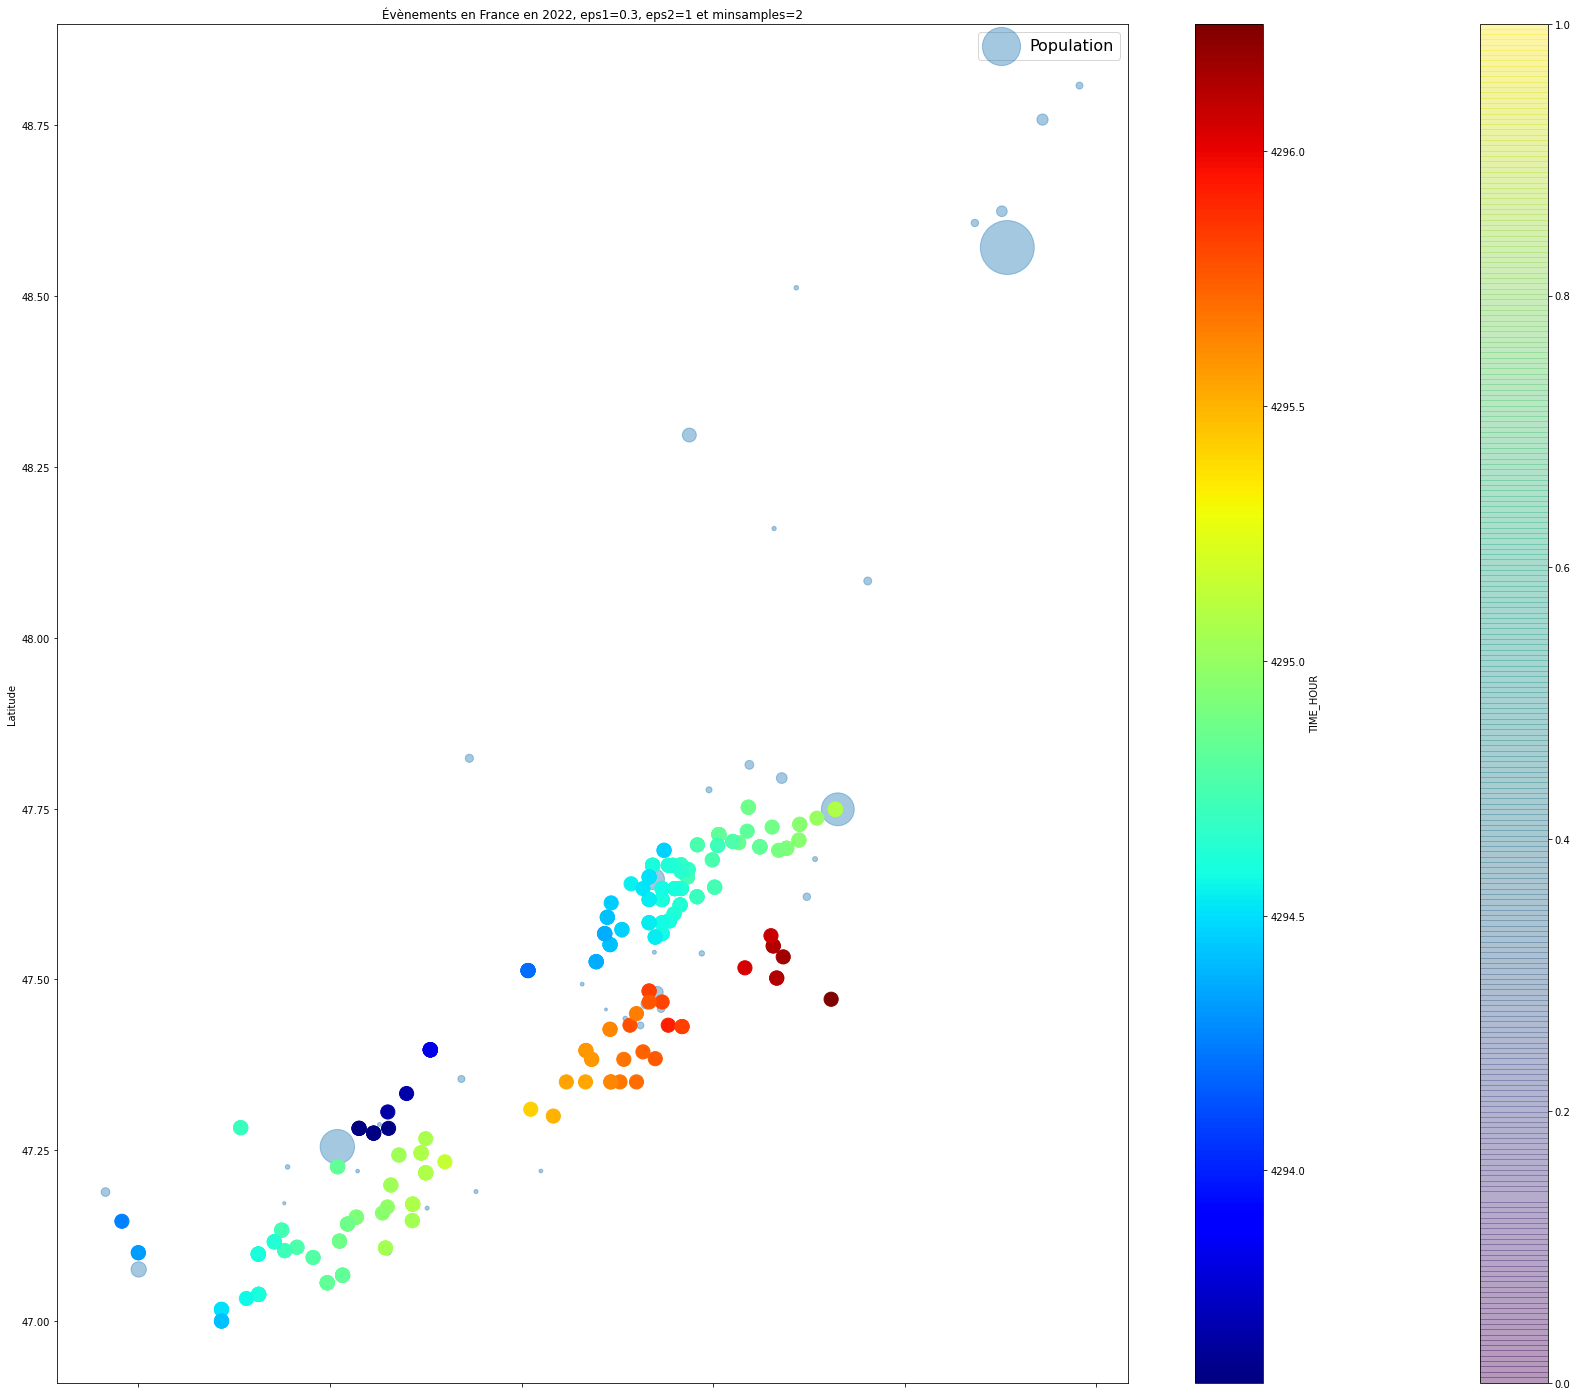

<ipython-input-37-4213b9b02d9f>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clst['TIME_HOUR']=df_clst.apply(lambda donnee: convert_hour(donnee), axis=1)


        TIME_HOUR  LATITUDE  LONGITUDE  cluster
classe                                         
79             98        98         98       98


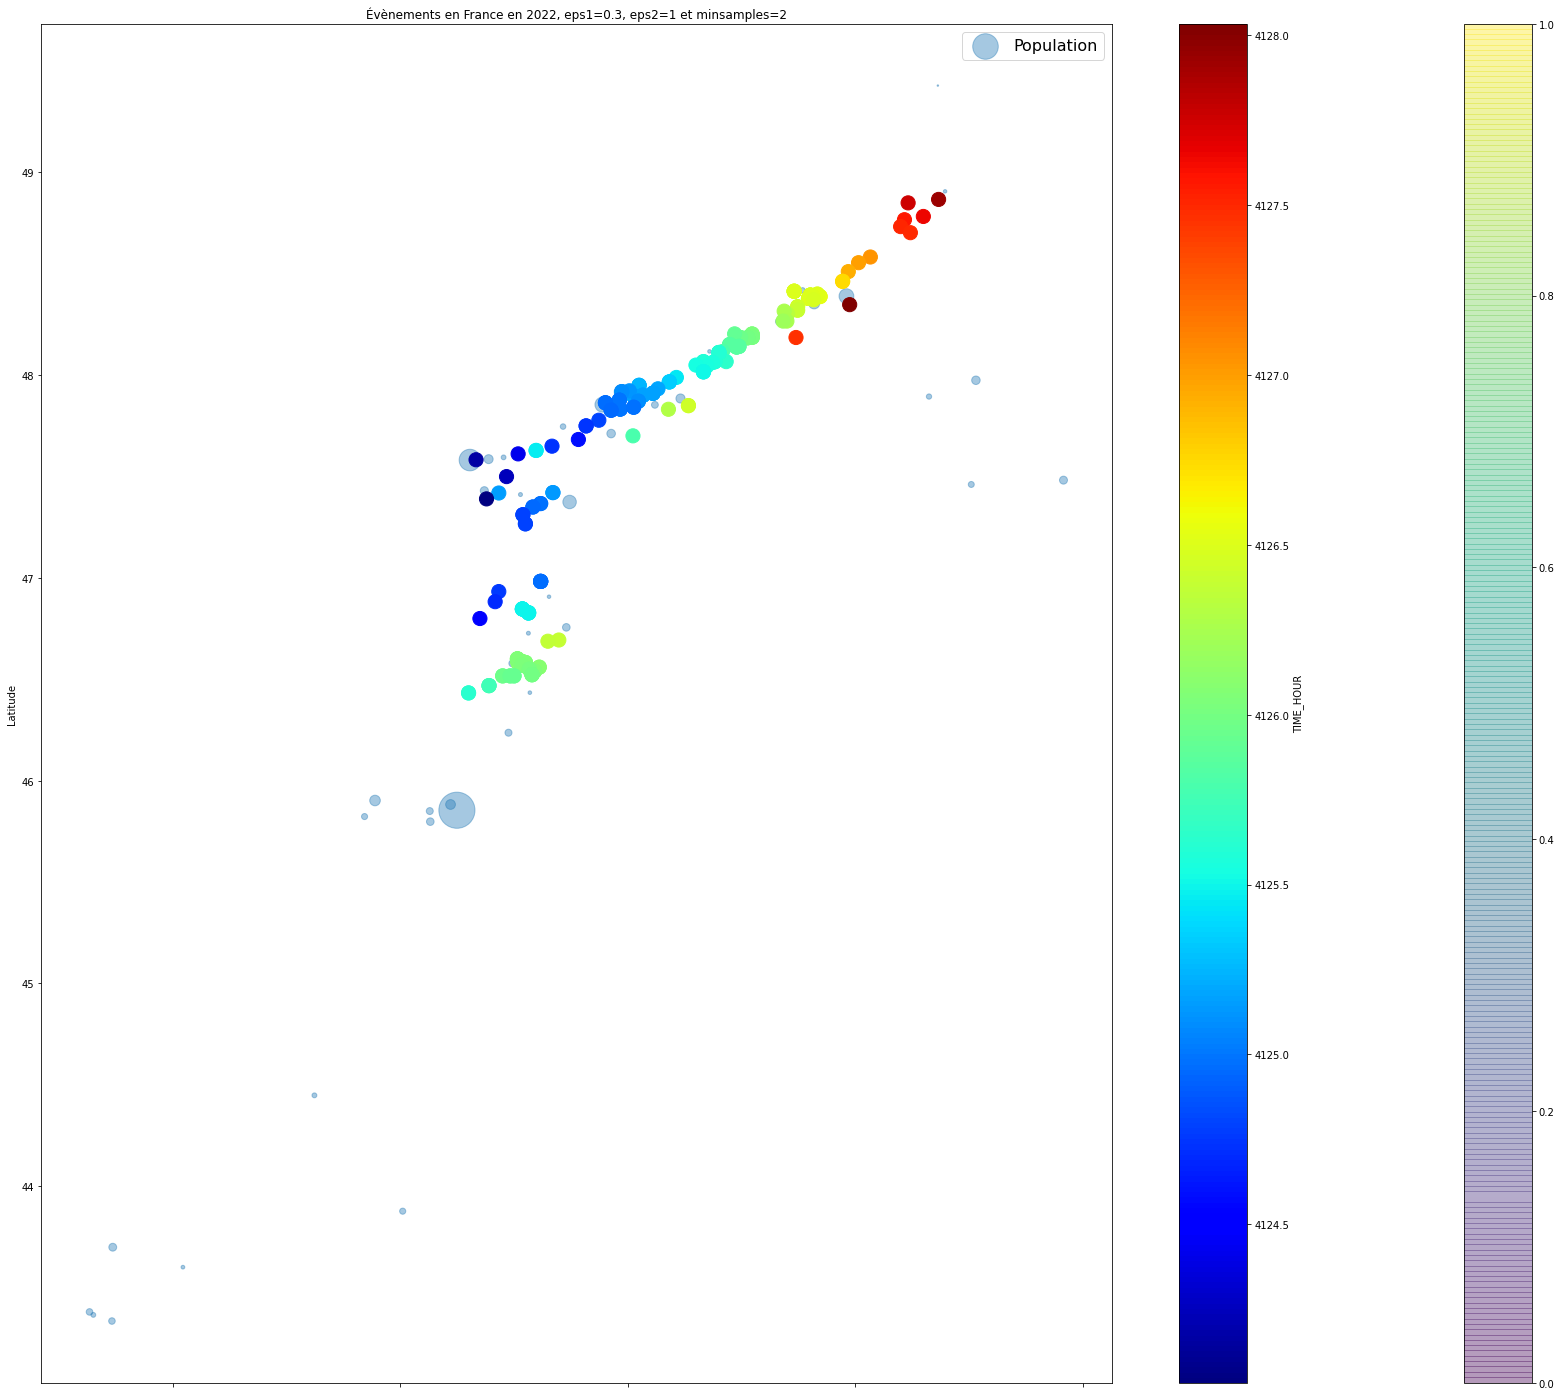

<ipython-input-37-4213b9b02d9f>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clst['TIME_HOUR']=df_clst.apply(lambda donnee: convert_hour(donnee), axis=1)


        TIME_HOUR  LATITUDE  LONGITUDE  cluster
classe                                         
78             59        59         59       59


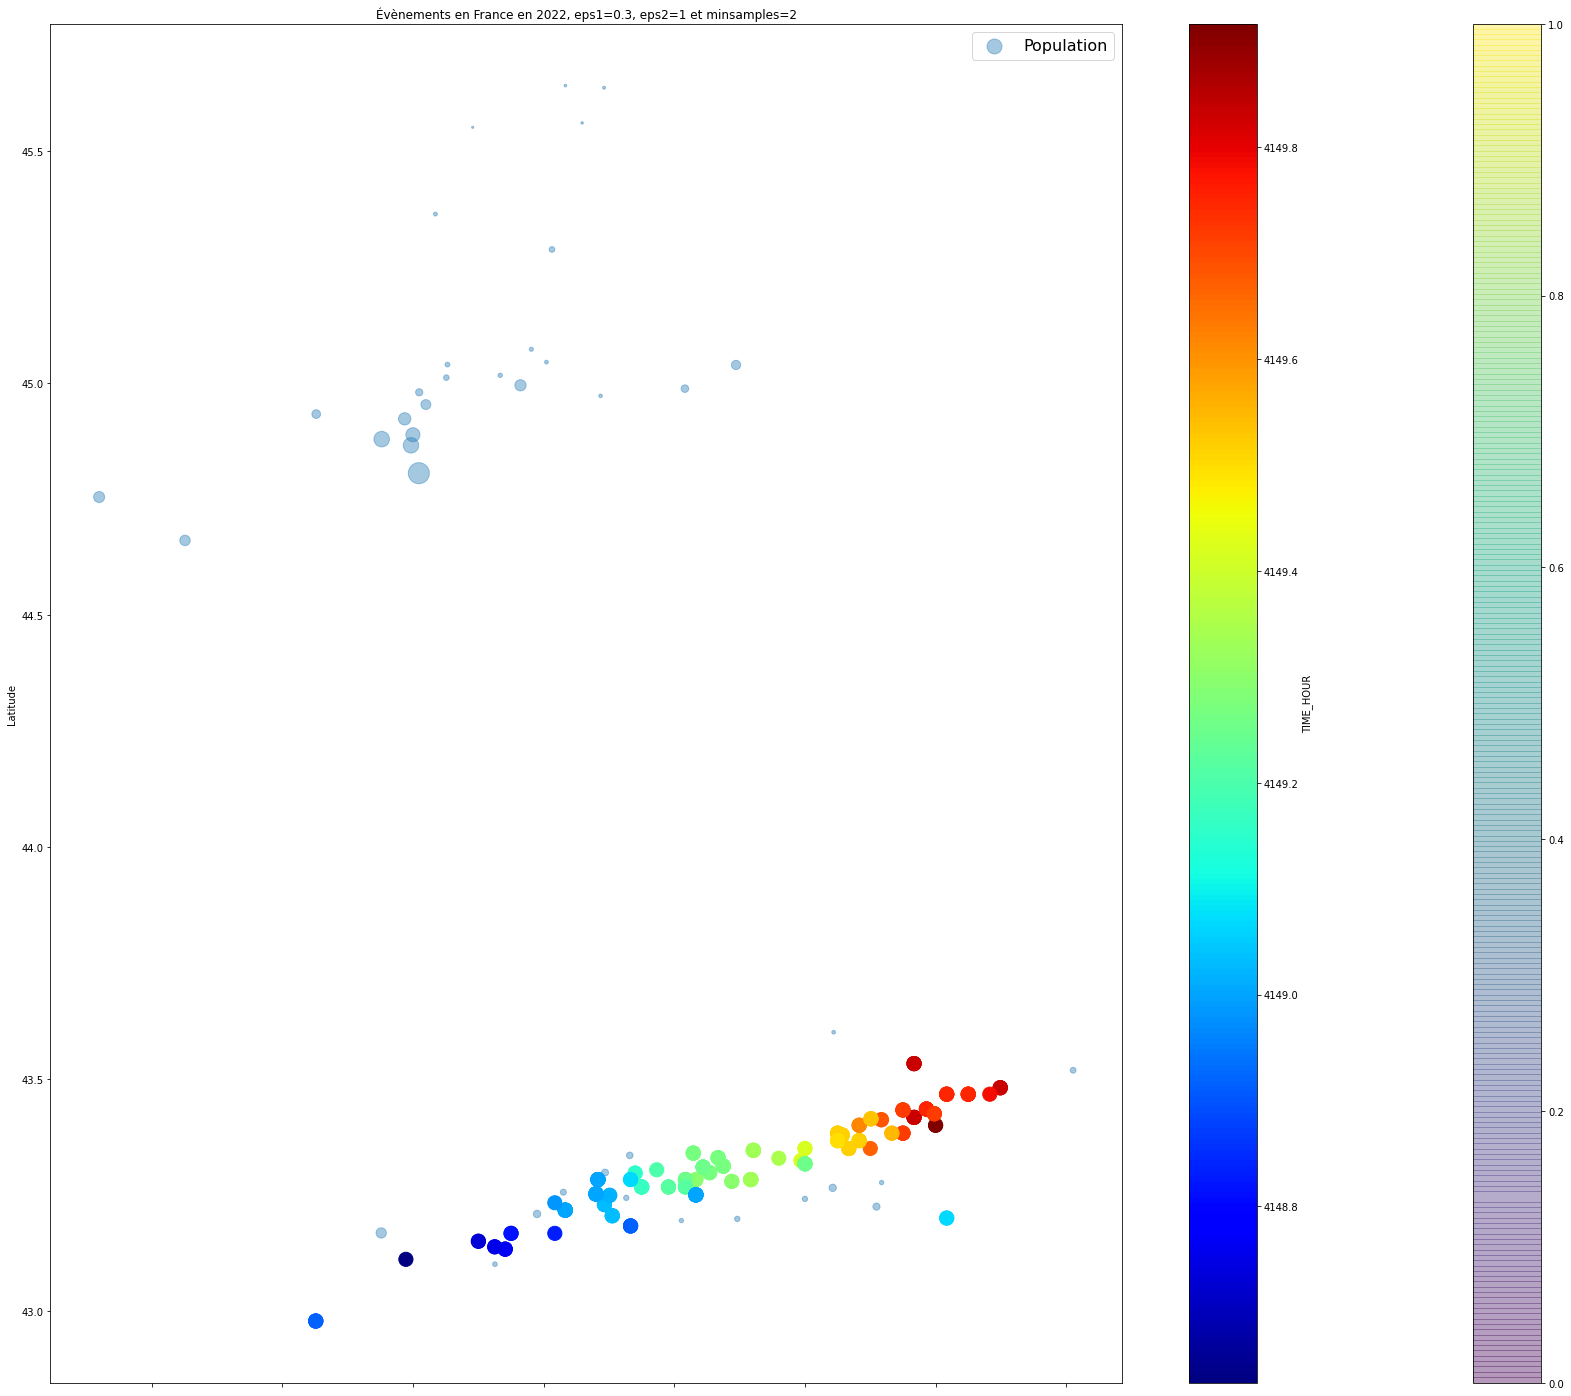

<ipython-input-37-4213b9b02d9f>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clst['TIME_HOUR']=df_clst.apply(lambda donnee: convert_hour(donnee), axis=1)


        TIME_HOUR  LATITUDE  LONGITUDE  cluster
classe                                         
125            54        54         54       54


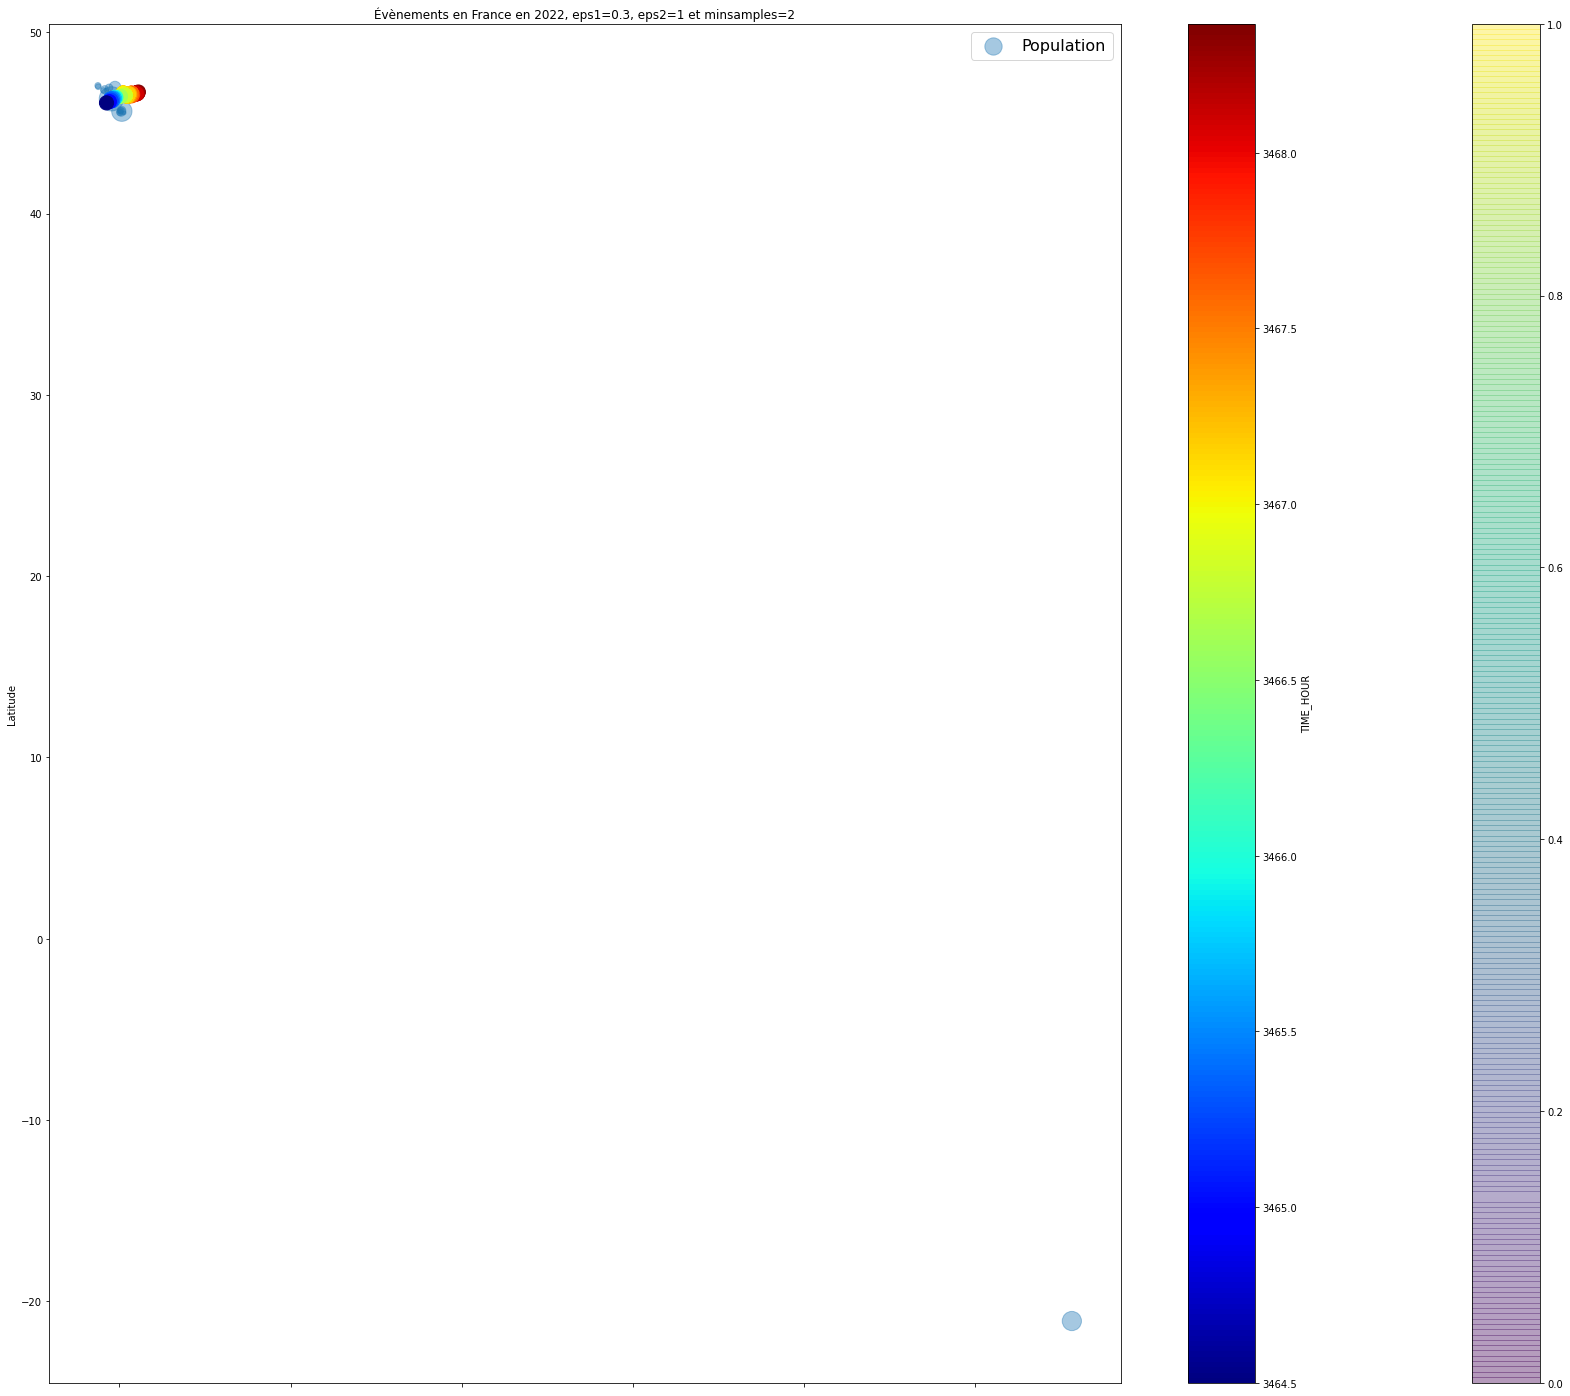

<ipython-input-37-4213b9b02d9f>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clst['TIME_HOUR']=df_clst.apply(lambda donnee: convert_hour(donnee), axis=1)


        TIME_HOUR  LATITUDE  LONGITUDE  cluster
classe                                         
38             46        46         46       46


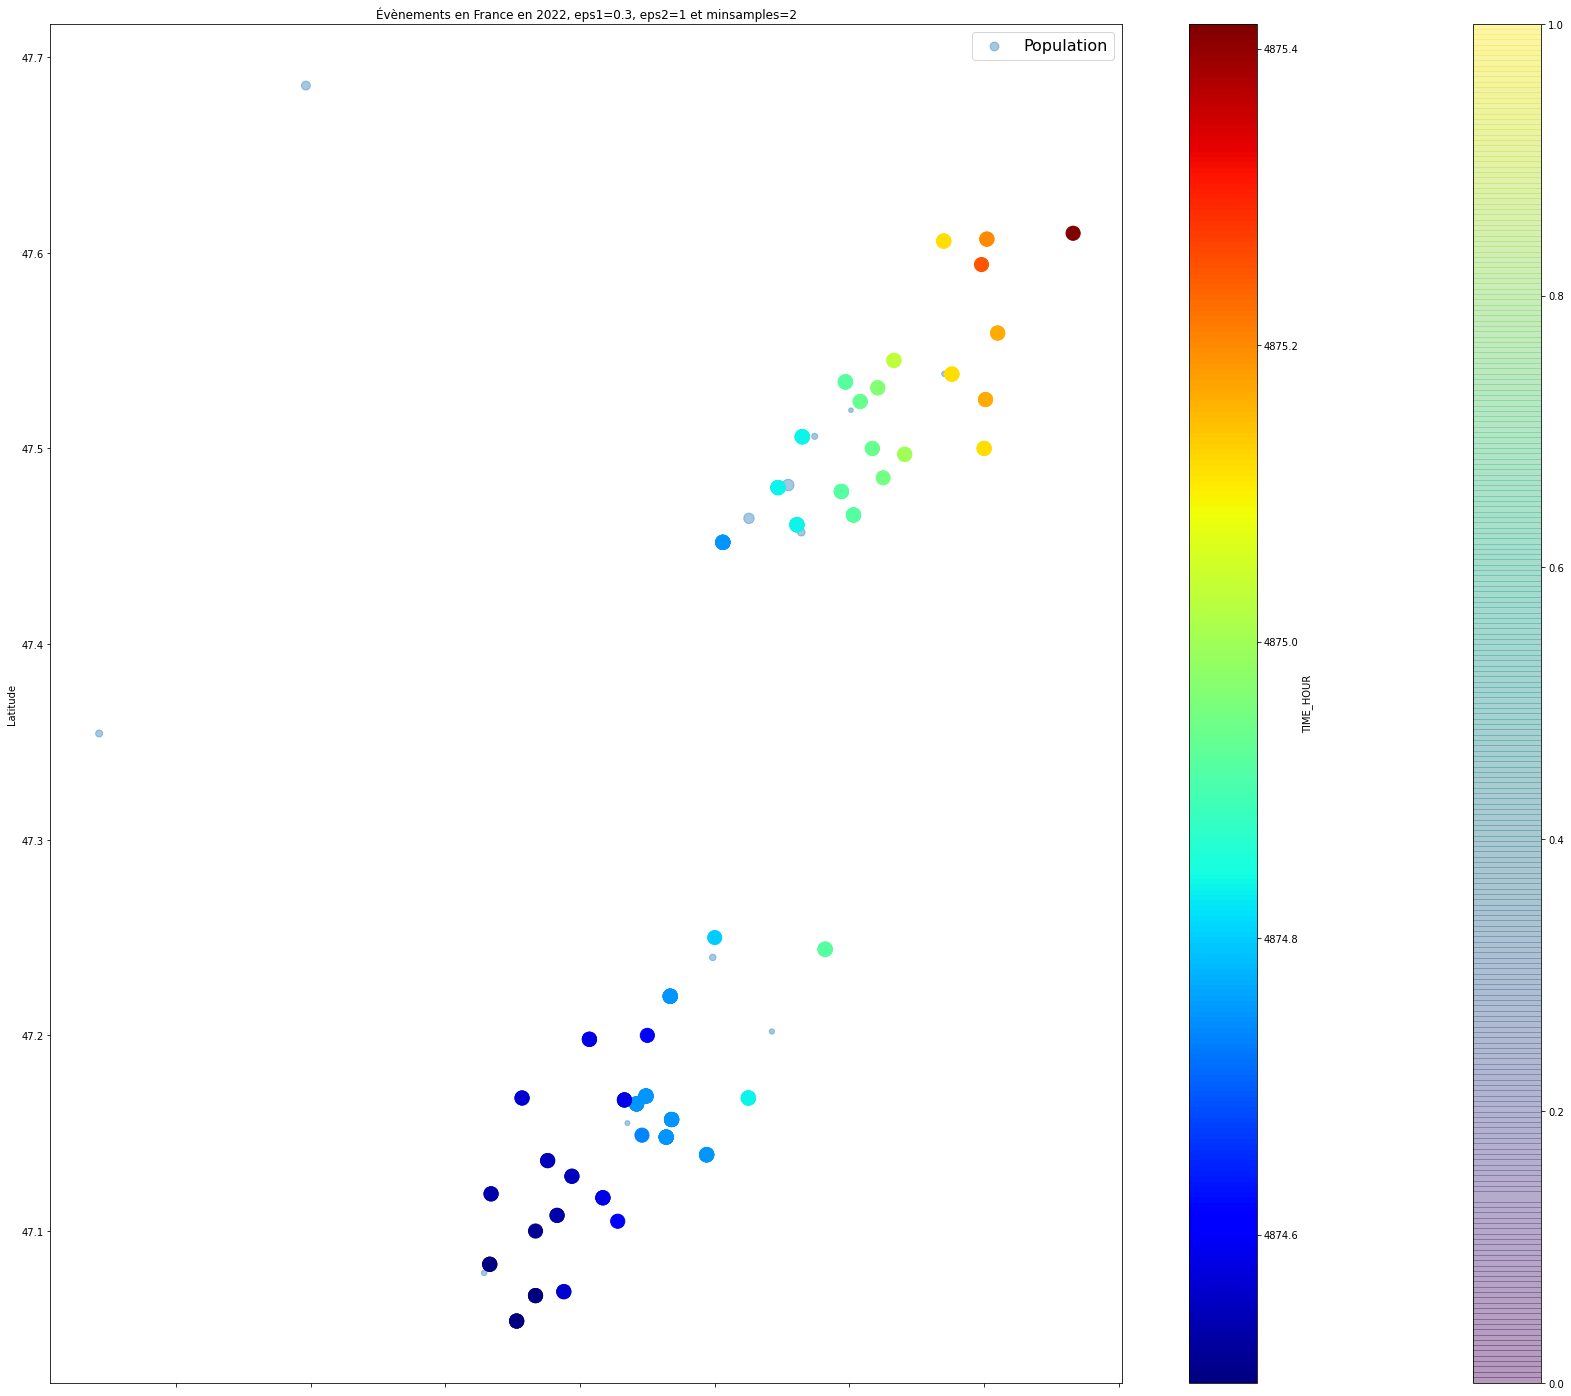

<ipython-input-37-4213b9b02d9f>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clst['TIME_HOUR']=df_clst.apply(lambda donnee: convert_hour(donnee), axis=1)


        TIME_HOUR  LATITUDE  LONGITUDE  cluster
classe                                         
74             41        41         41       41


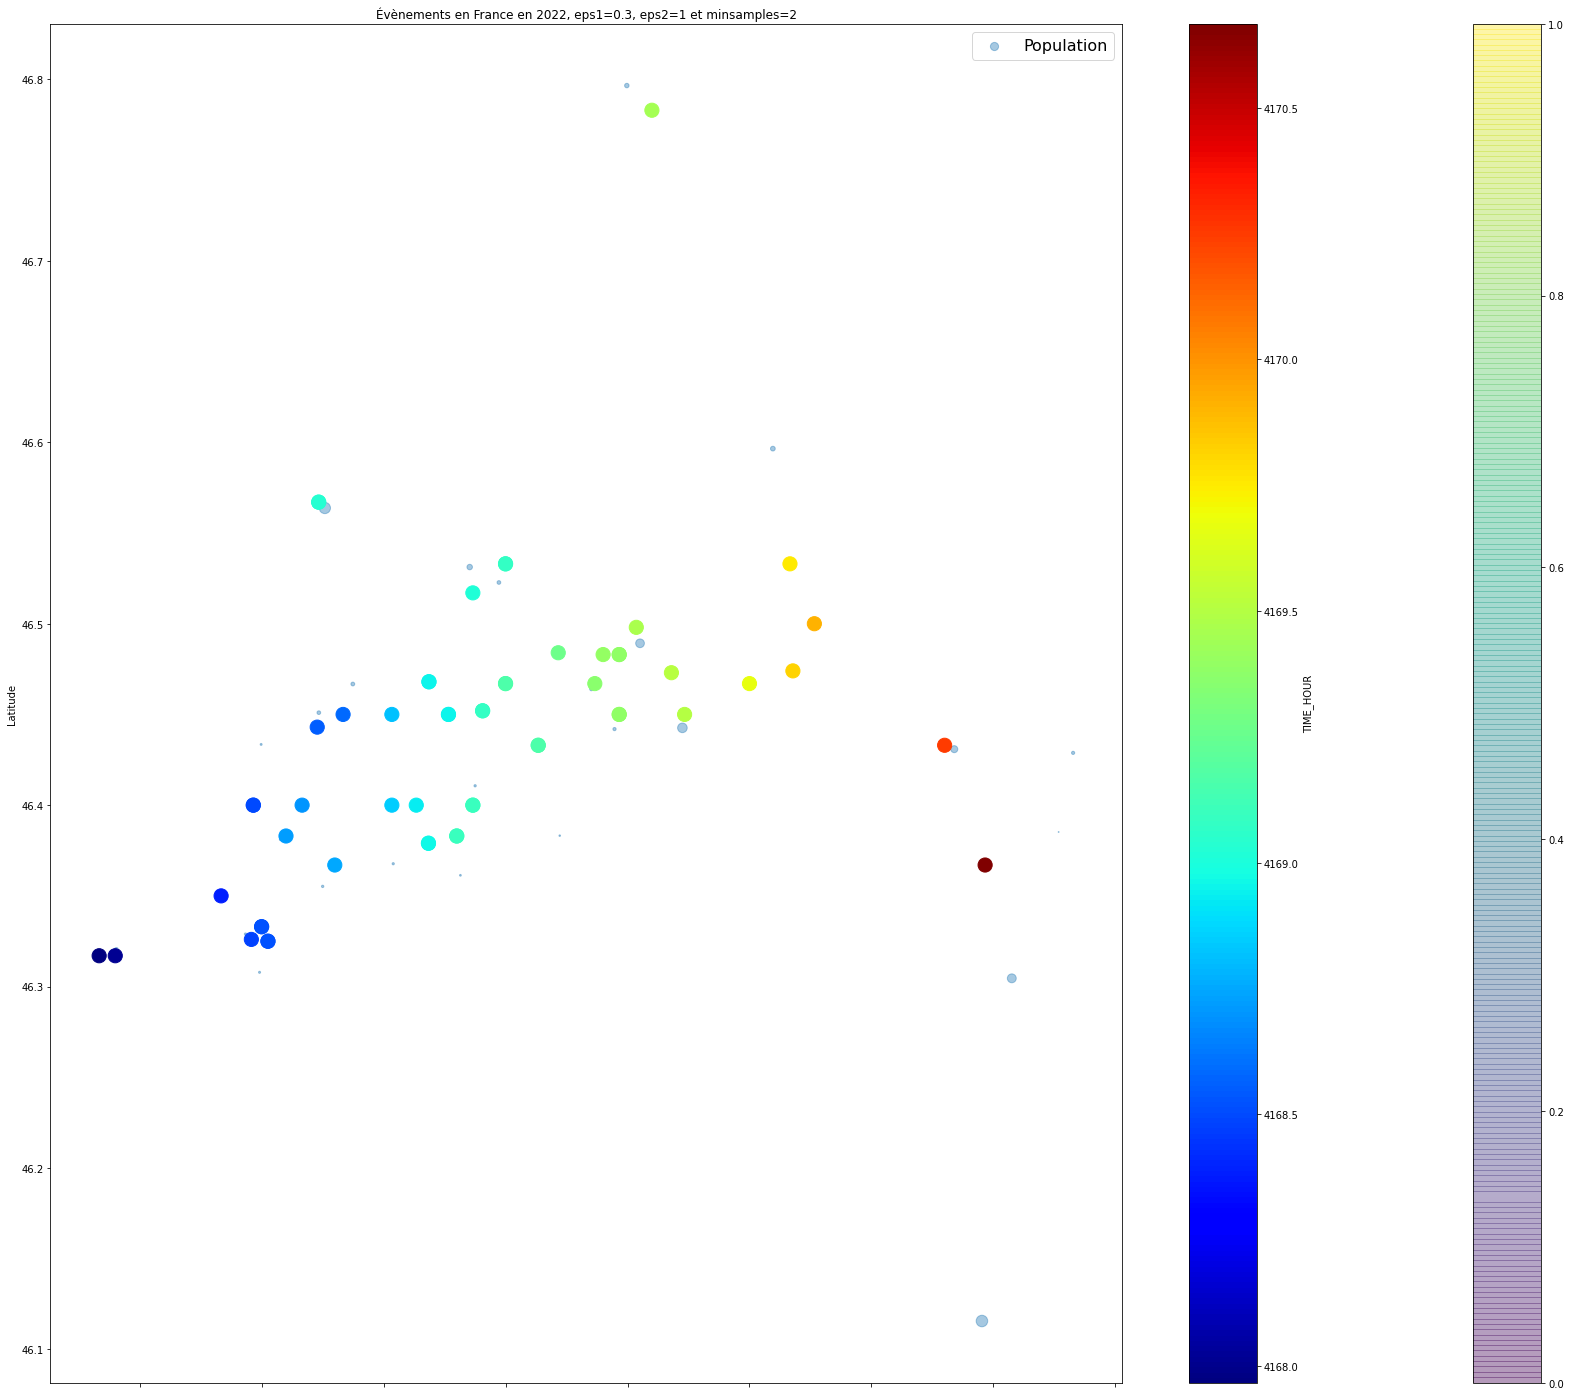

<ipython-input-37-4213b9b02d9f>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clst['TIME_HOUR']=df_clst.apply(lambda donnee: convert_hour(donnee), axis=1)


        TIME_HOUR  LATITUDE  LONGITUDE  cluster
classe                                         
102            38        38         38       38


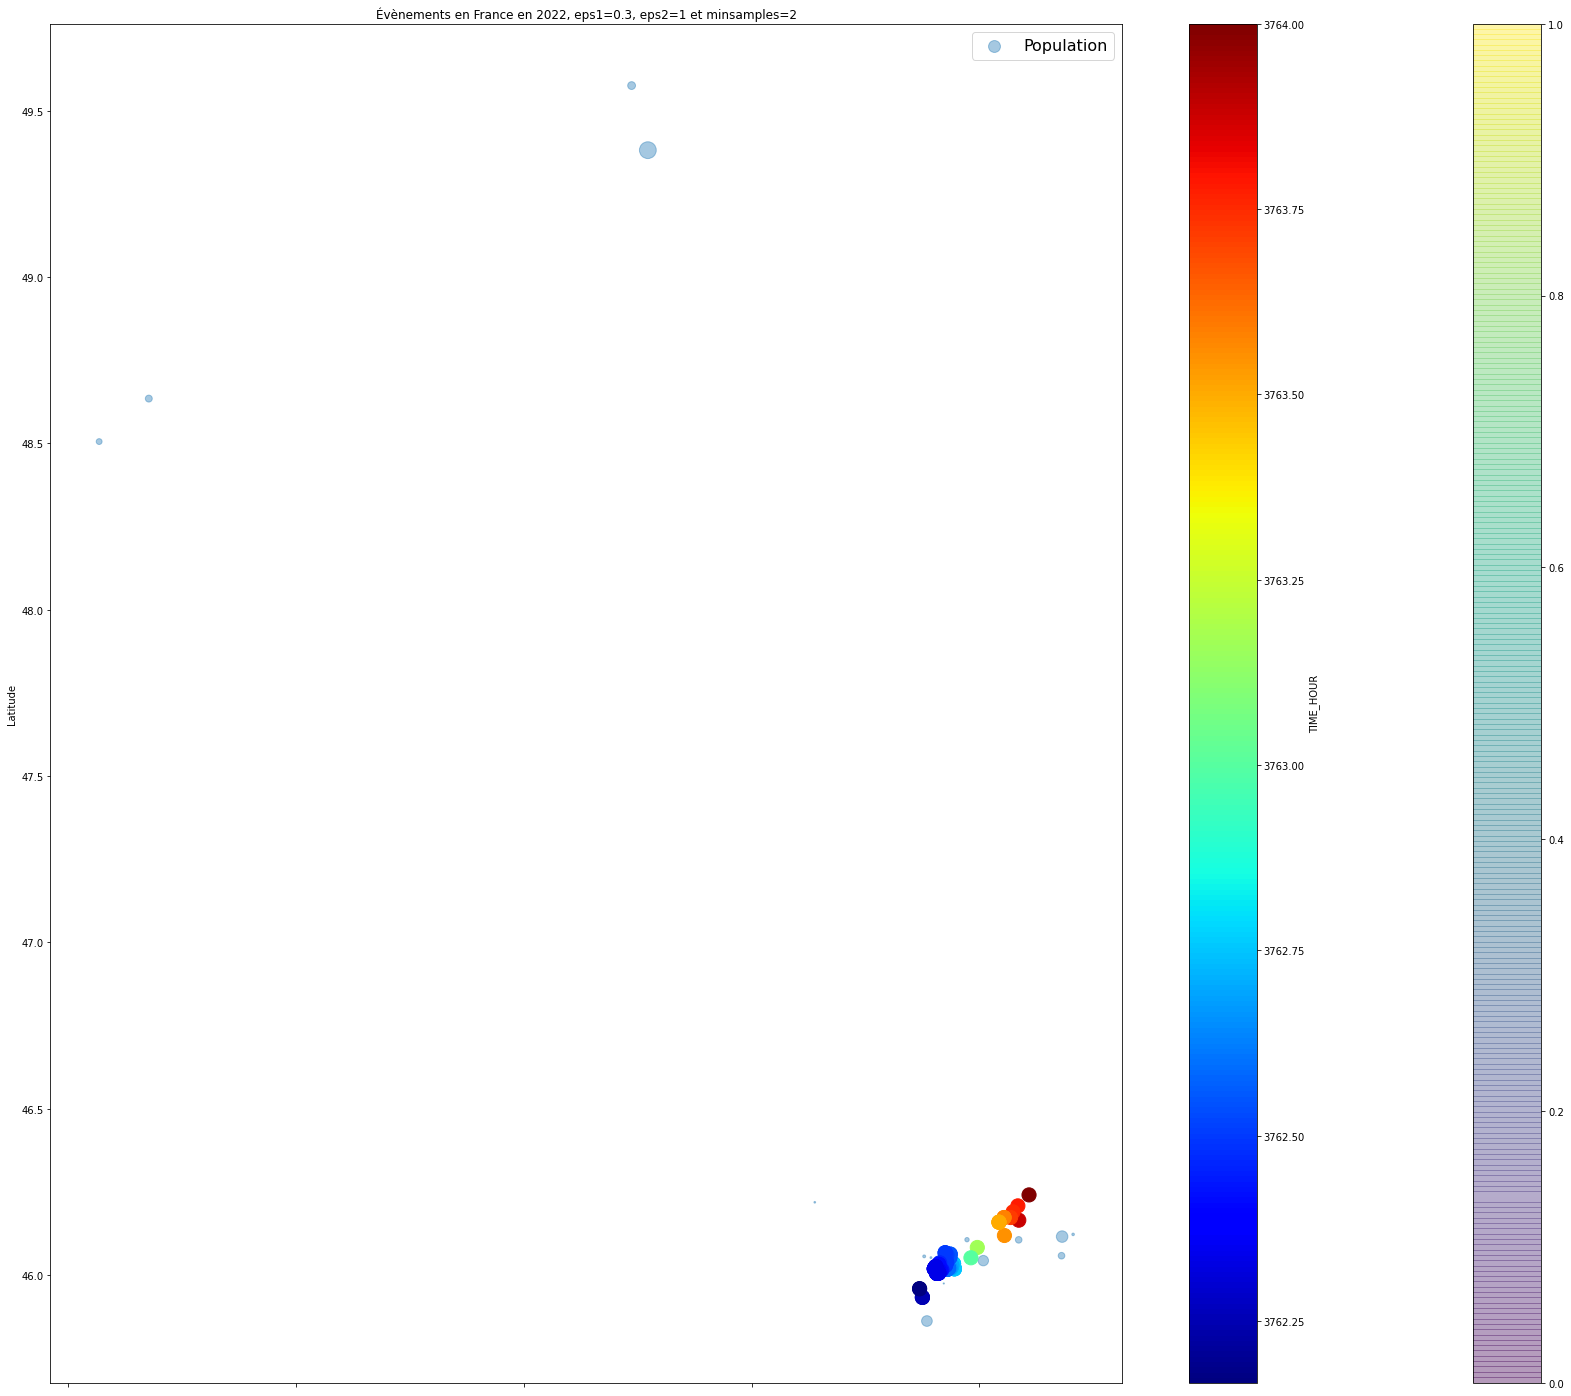

<ipython-input-37-4213b9b02d9f>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clst['TIME_HOUR']=df_clst.apply(lambda donnee: convert_hour(donnee), axis=1)


        TIME_HOUR  LATITUDE  LONGITUDE  cluster
classe                                         
109            37        37         37       37


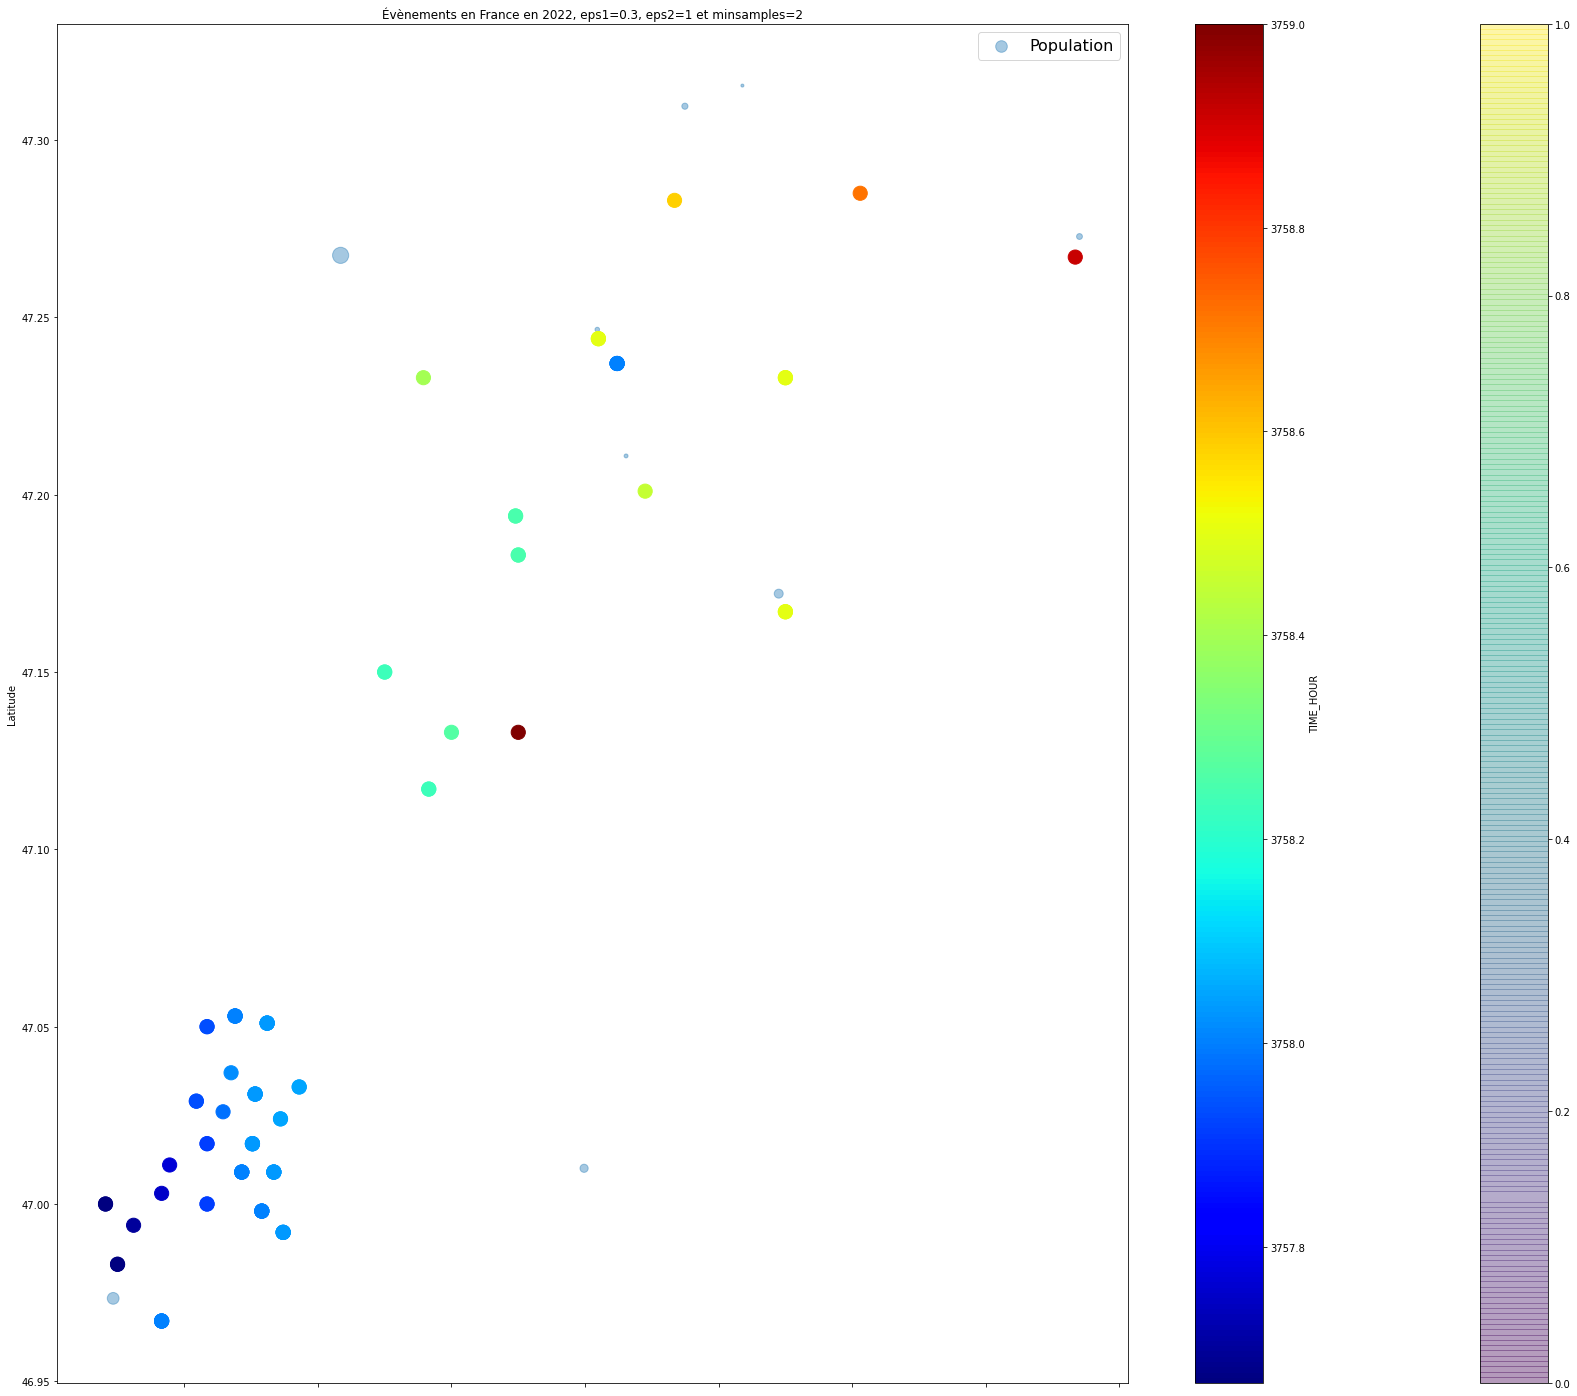

<ipython-input-37-4213b9b02d9f>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clst['TIME_HOUR']=df_clst.apply(lambda donnee: convert_hour(donnee), axis=1)


        TIME_HOUR  LATITUDE  LONGITUDE  cluster
classe                                         
44             36        36         36       36


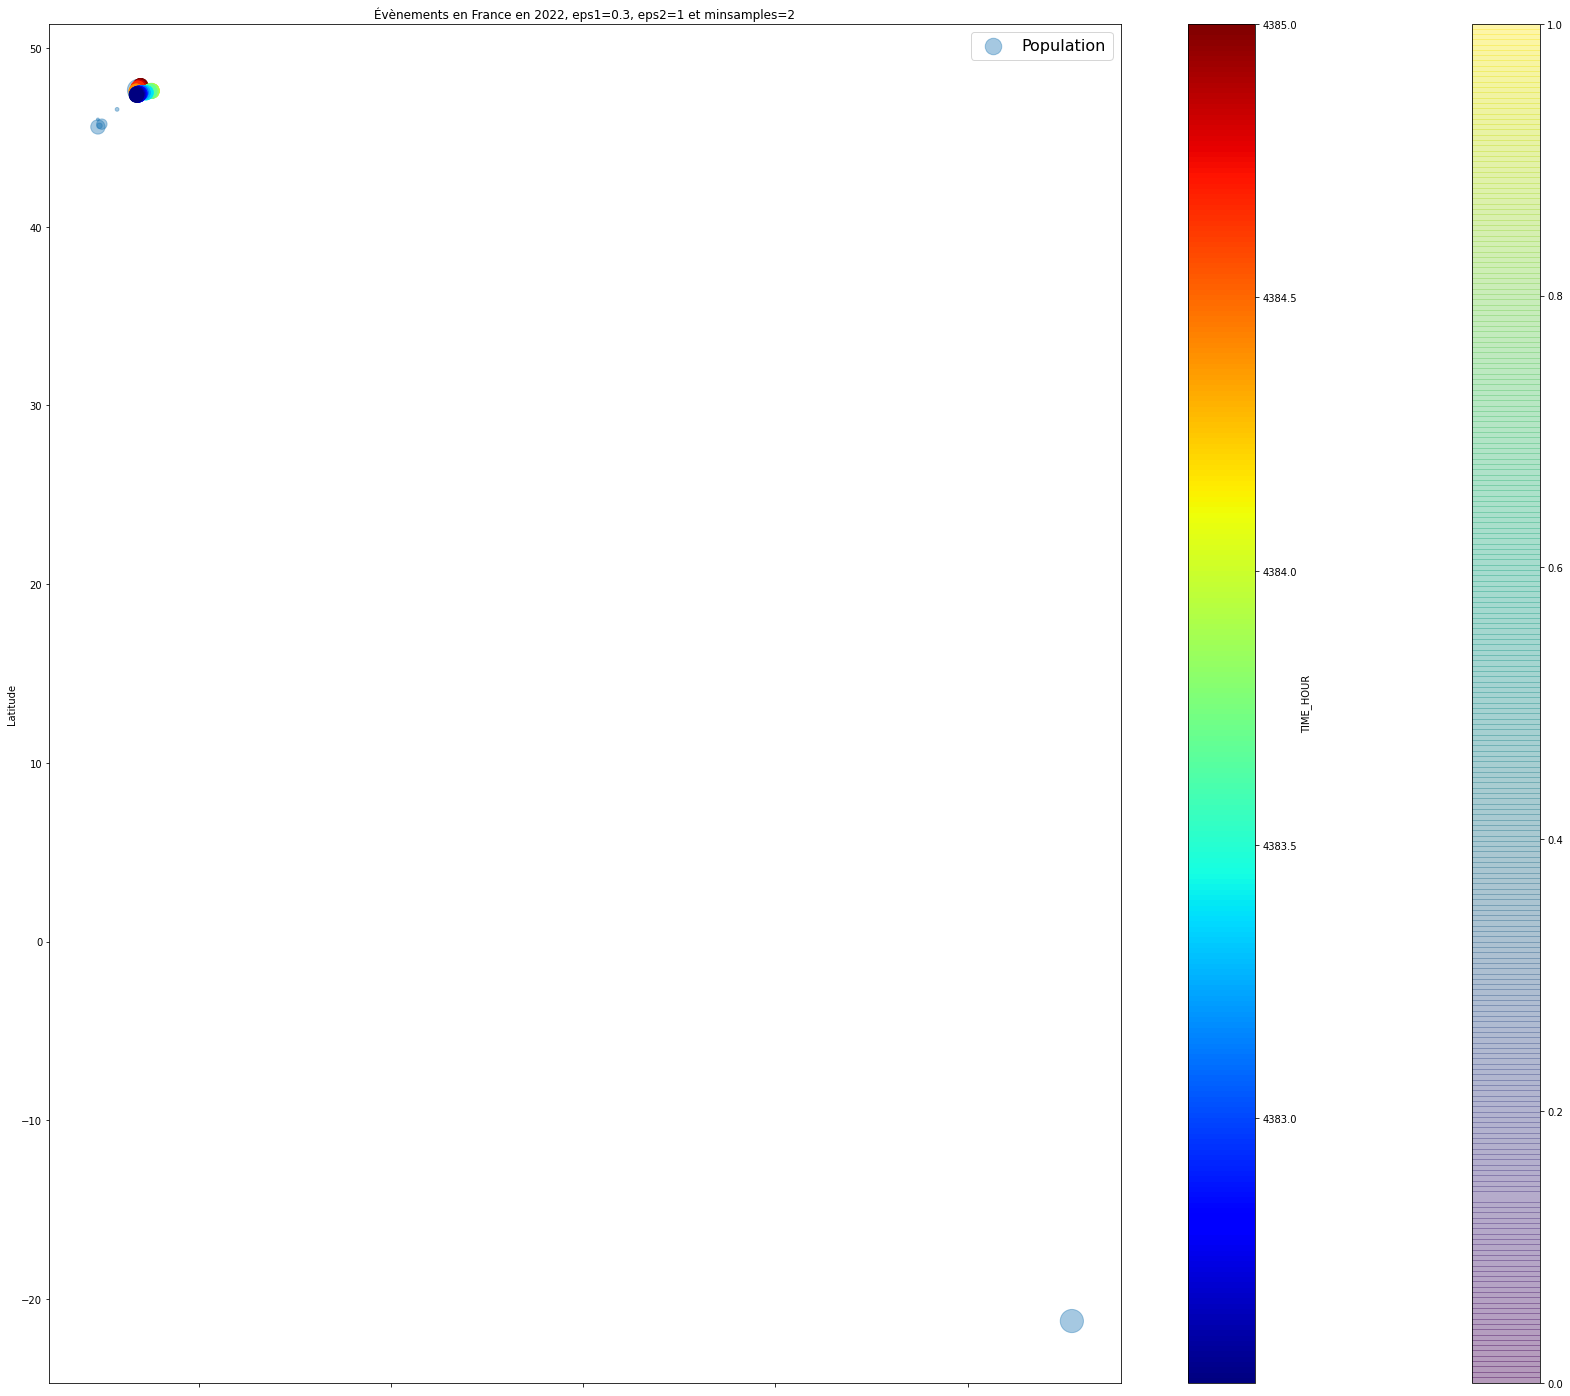

<ipython-input-37-4213b9b02d9f>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clst['TIME_HOUR']=df_clst.apply(lambda donnee: convert_hour(donnee), axis=1)


        TIME_HOUR  LATITUDE  LONGITUDE  cluster
classe                                         
116            32        32         32       32


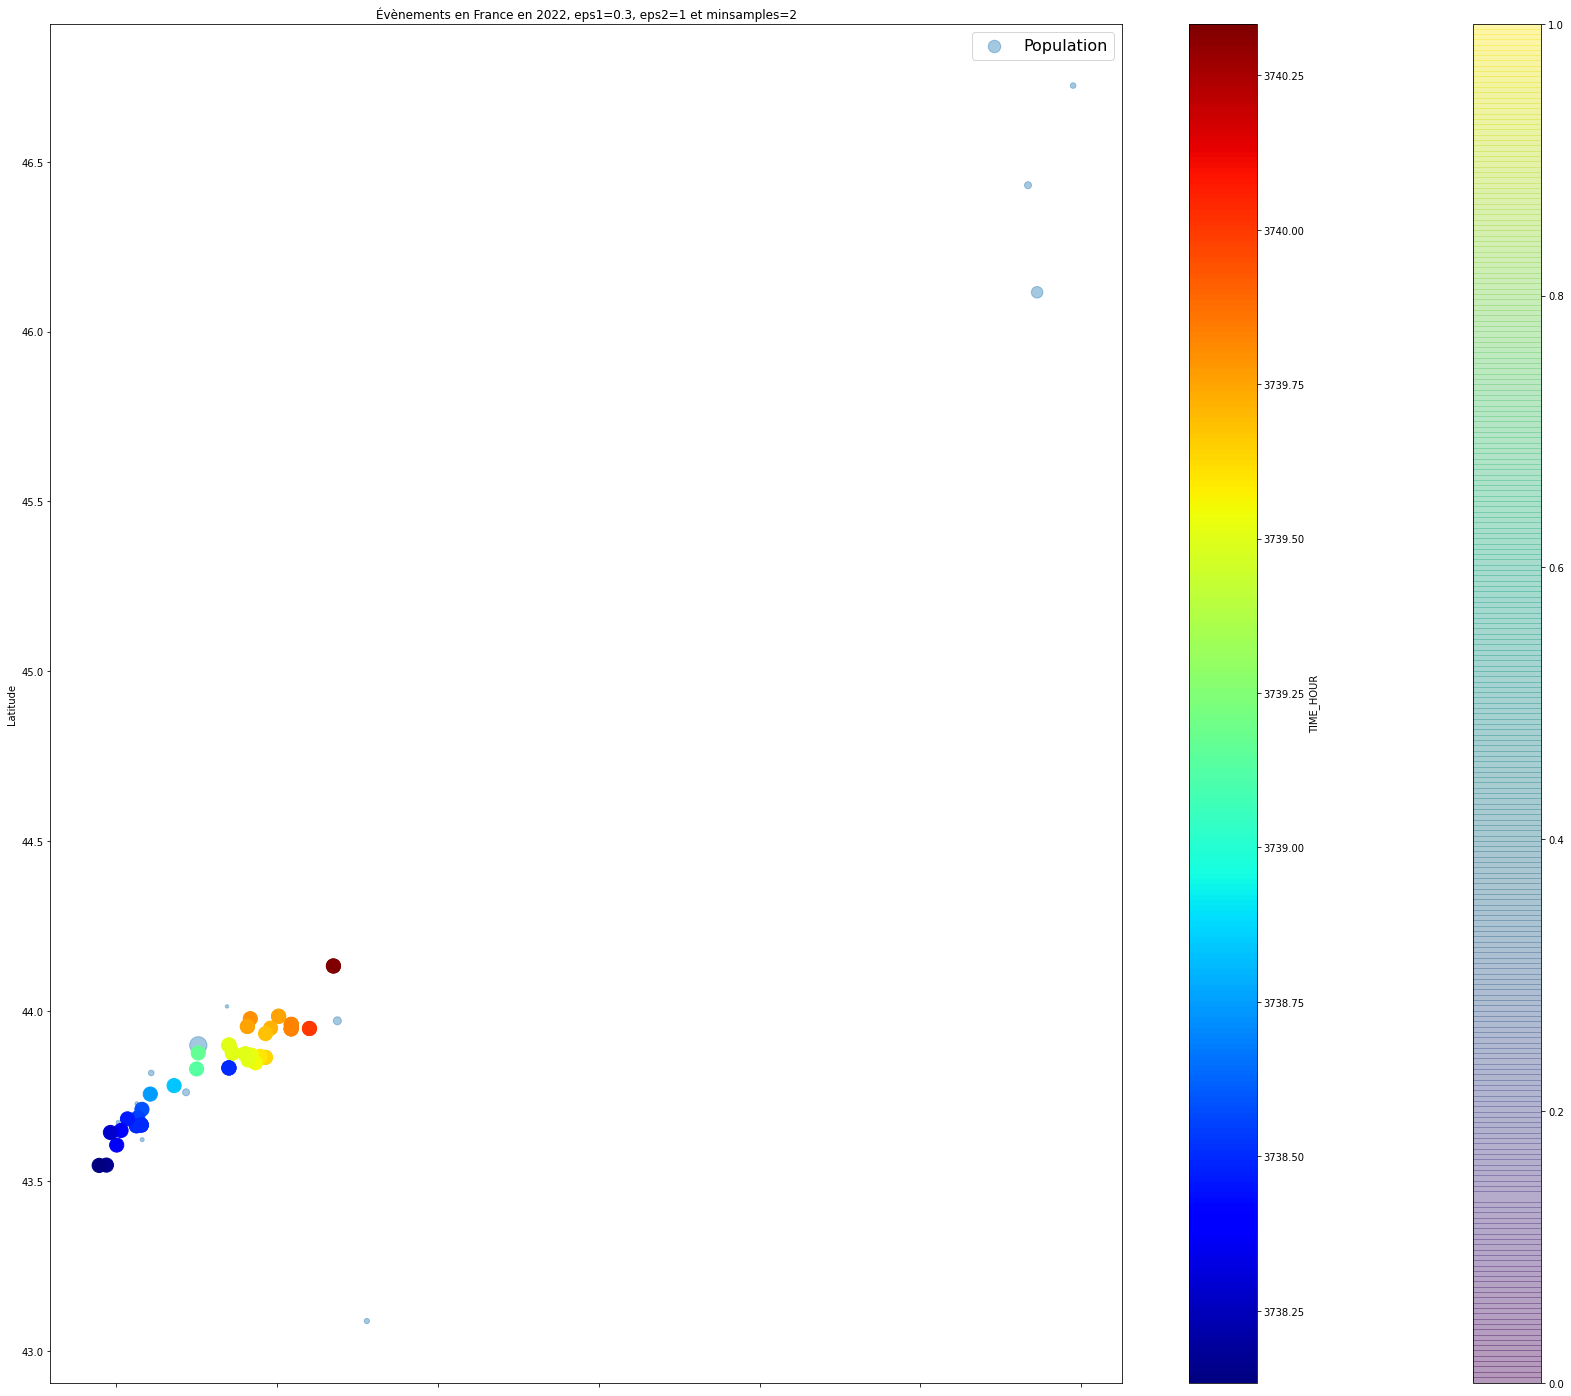

<ipython-input-37-4213b9b02d9f>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clst['TIME_HOUR']=df_clst.apply(lambda donnee: convert_hour(donnee), axis=1)


        TIME_HOUR  LATITUDE  LONGITUDE  cluster
classe                                         
117            31        31         31       31


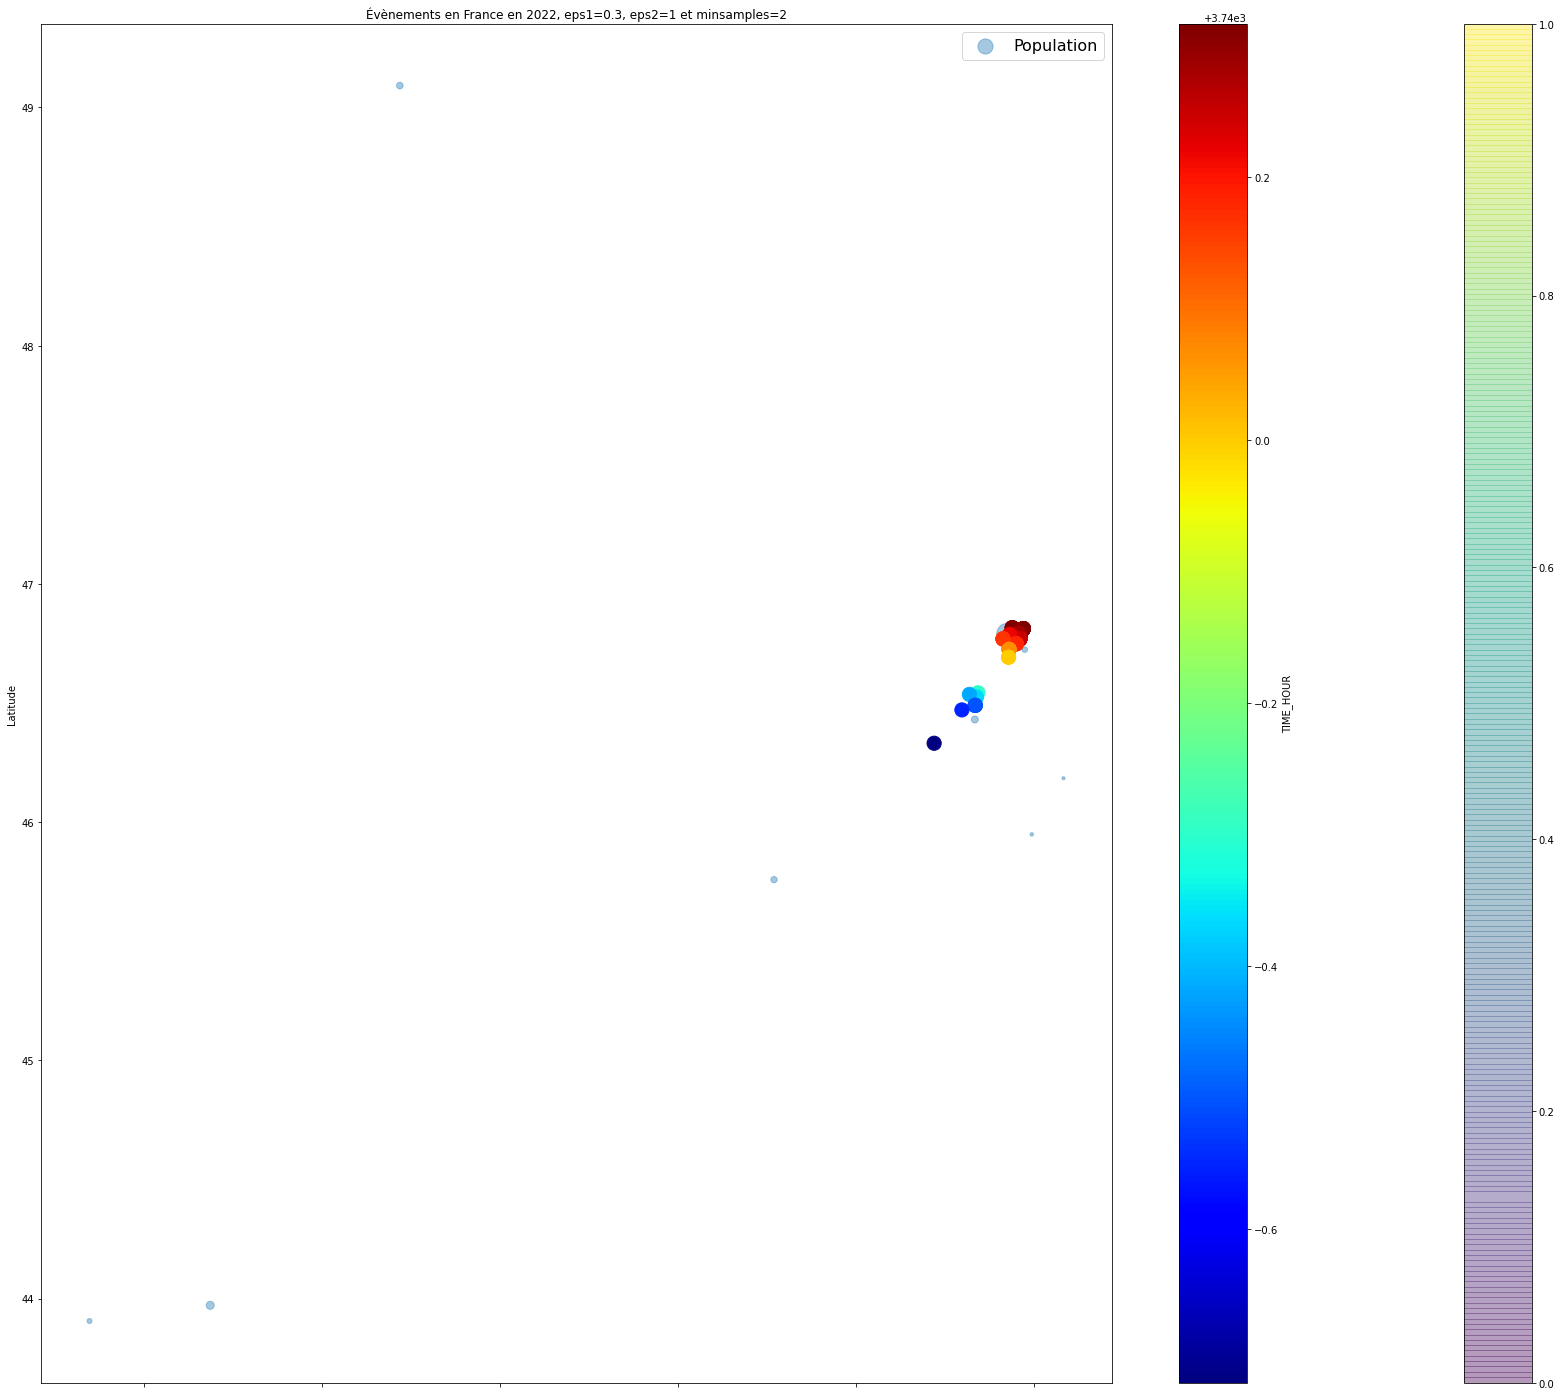

<ipython-input-37-4213b9b02d9f>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clst['TIME_HOUR']=df_clst.apply(lambda donnee: convert_hour(donnee), axis=1)


        TIME_HOUR  LATITUDE  LONGITUDE  cluster
classe                                         
132            29        29         29       29


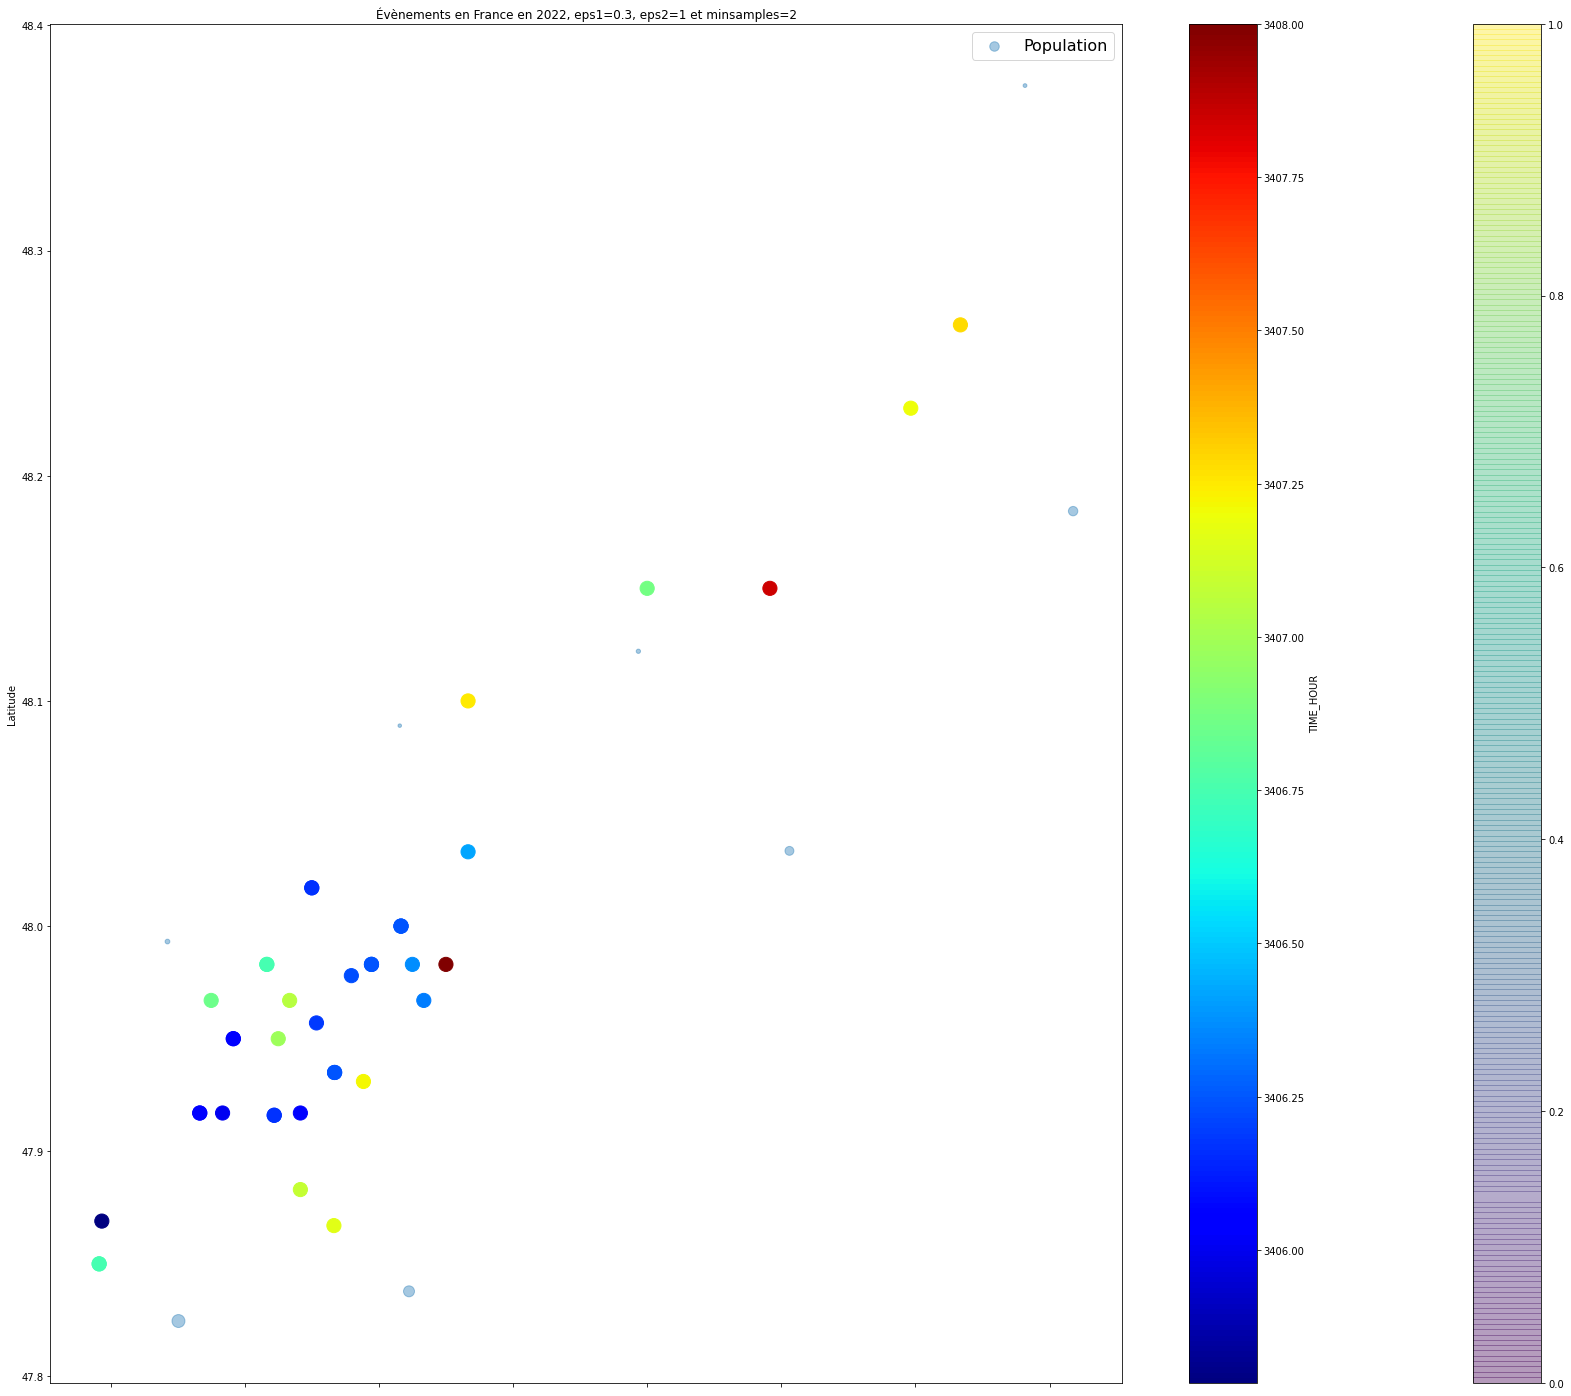

<ipython-input-37-4213b9b02d9f>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clst['TIME_HOUR']=df_clst.apply(lambda donnee: convert_hour(donnee), axis=1)


        TIME_HOUR  LATITUDE  LONGITUDE  cluster
classe                                         
75             22        22         22       22


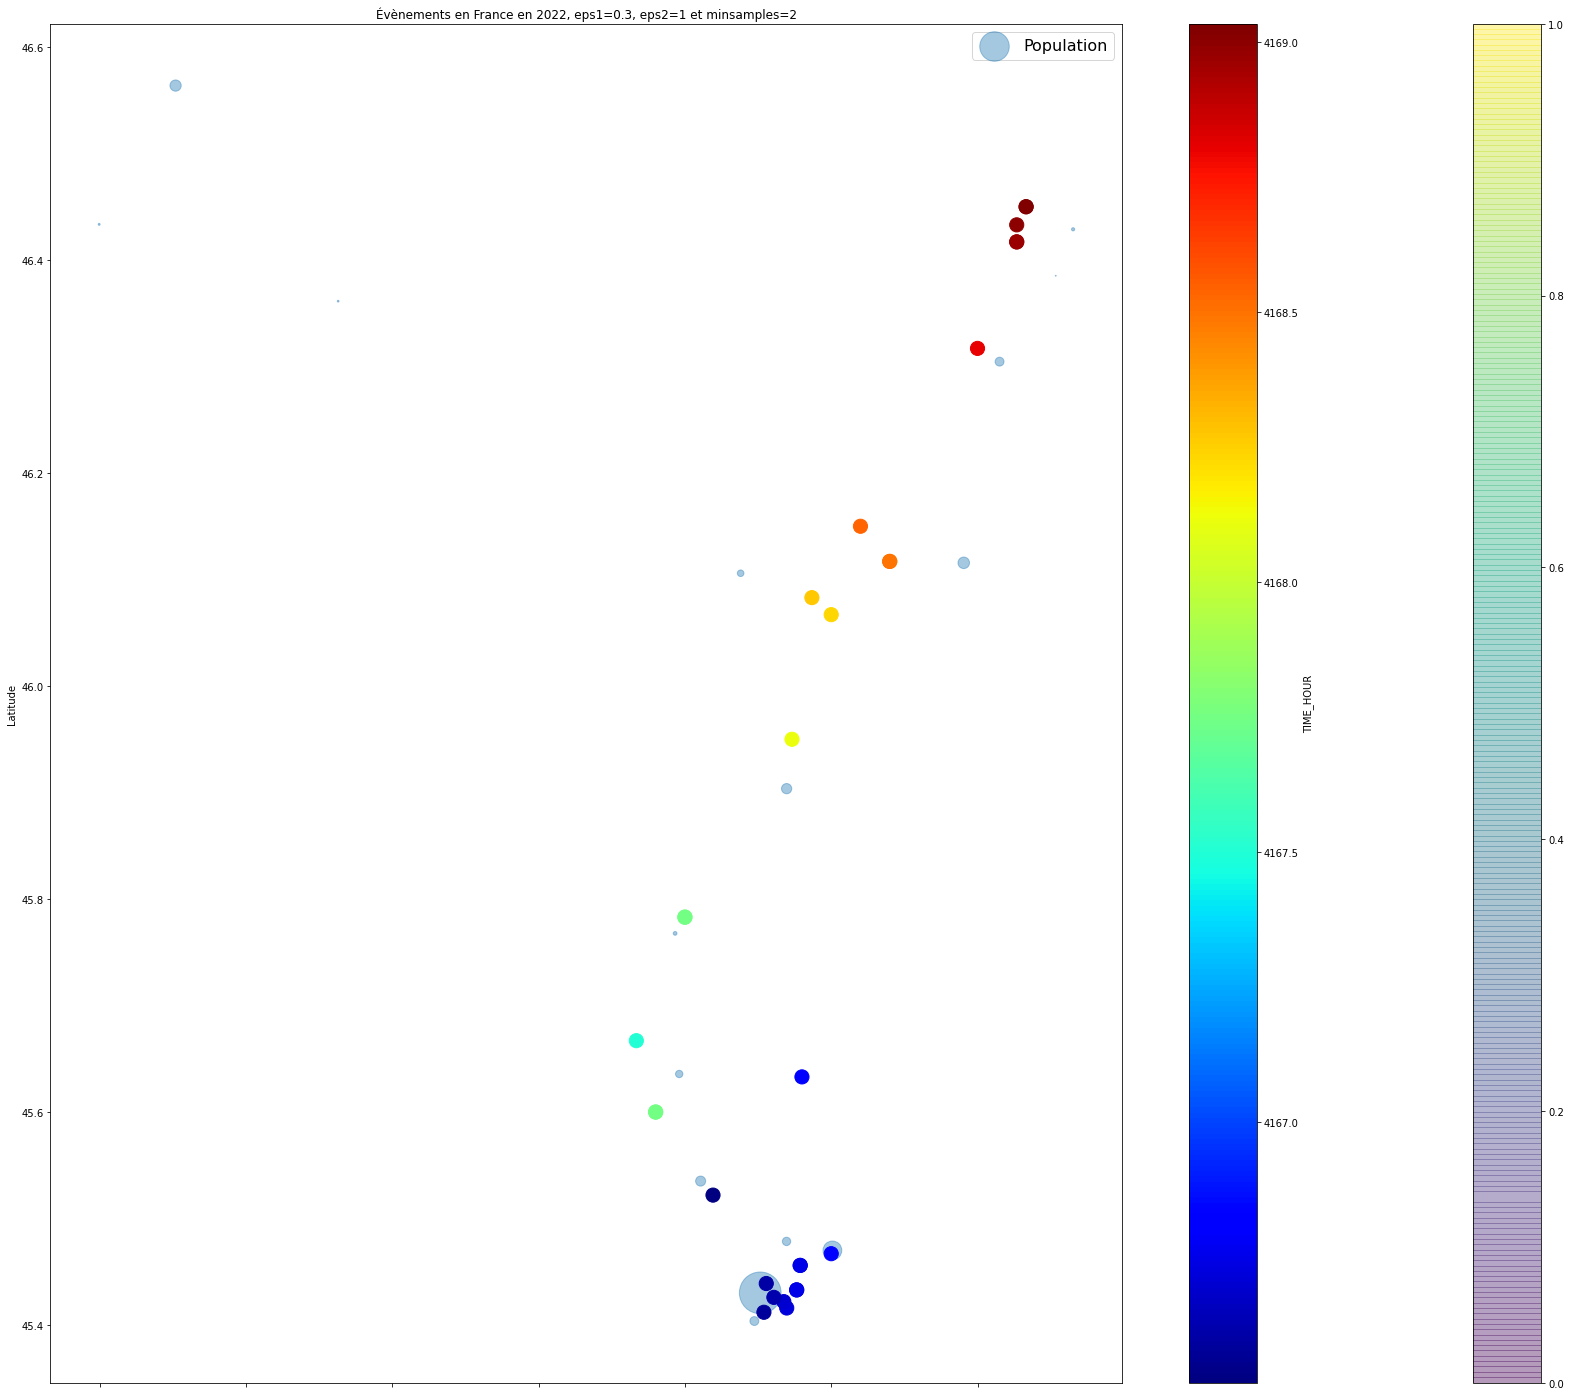

<ipython-input-37-4213b9b02d9f>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clst['TIME_HOUR']=df_clst.apply(lambda donnee: convert_hour(donnee), axis=1)


        TIME_HOUR  LATITUDE  LONGITUDE  cluster
classe                                         
15             21        21         21       21
39             21        21         21       21
43             21        21         21       21
91             21        21         21       21
124            21        21         21       21


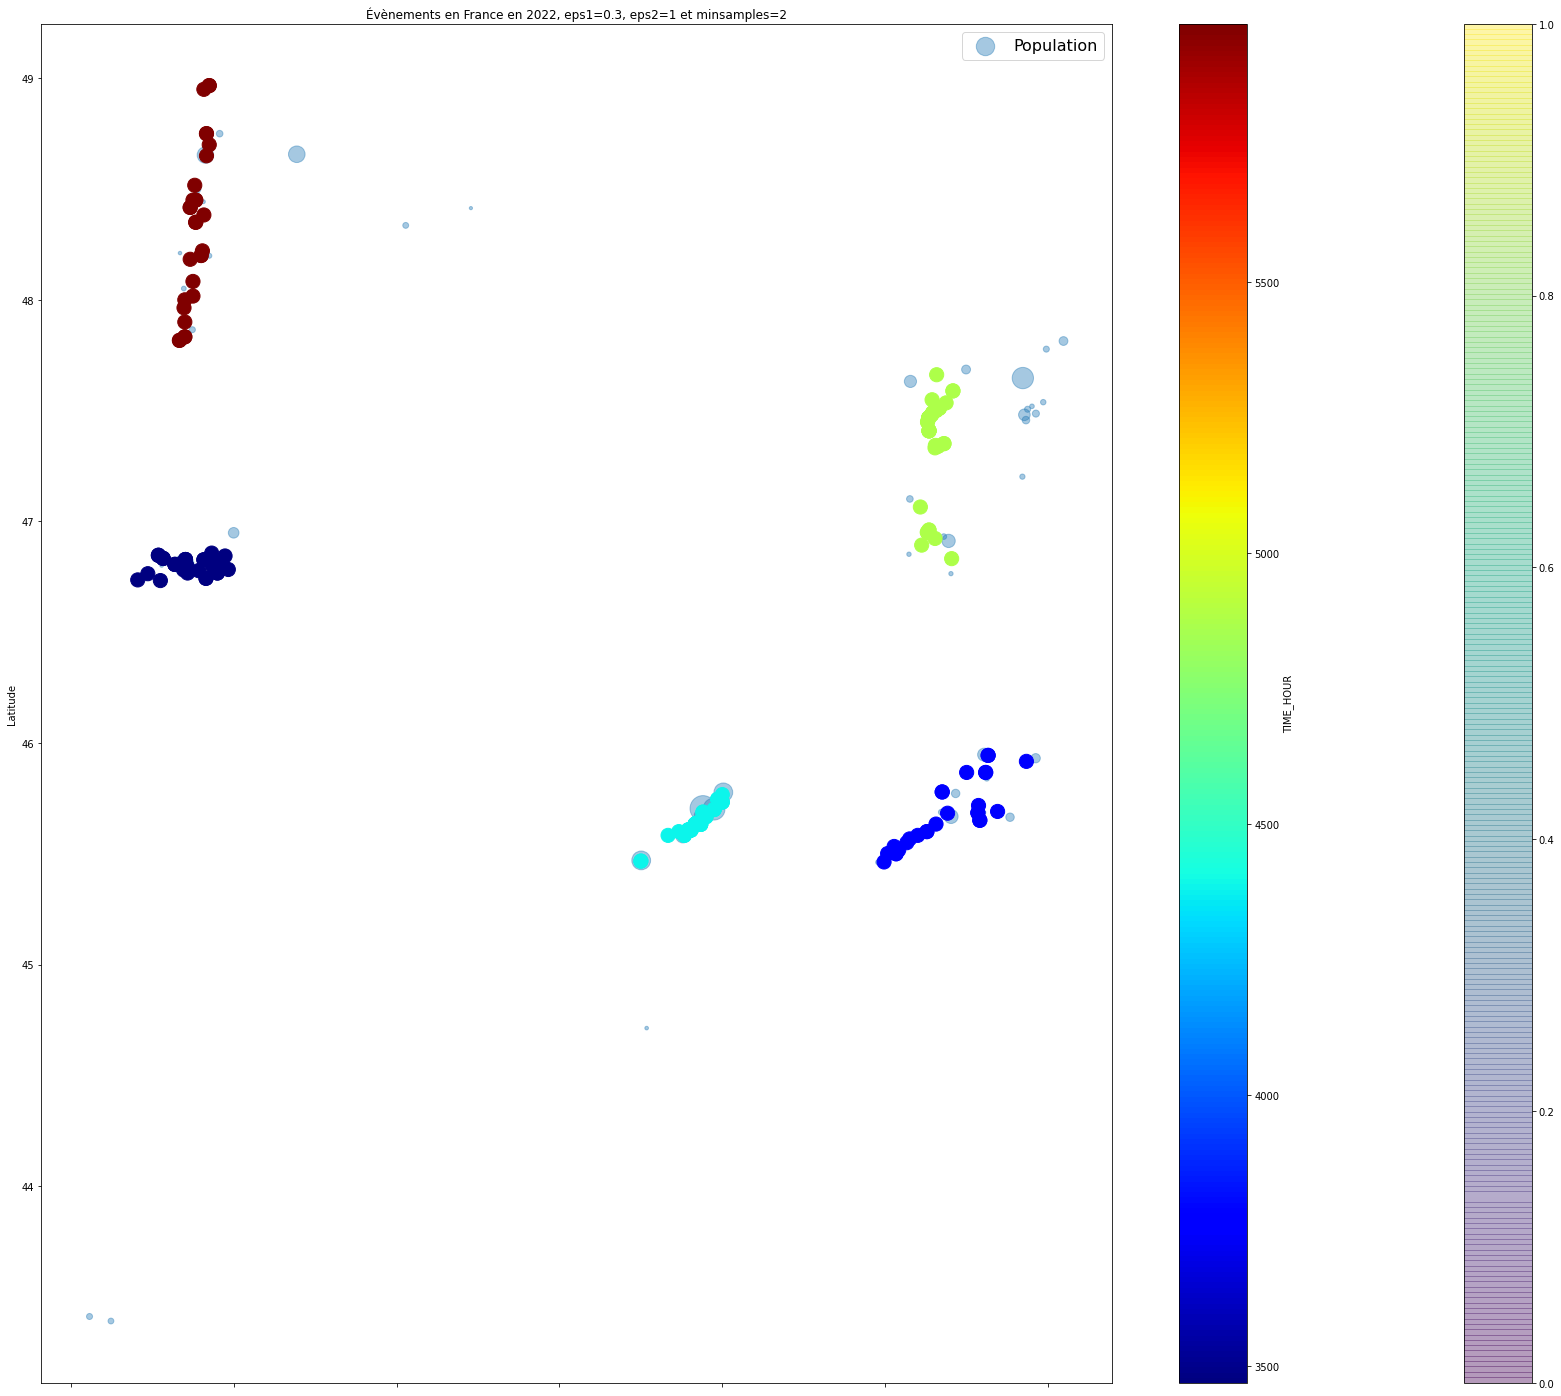

<ipython-input-37-4213b9b02d9f>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clst['TIME_HOUR']=df_clst.apply(lambda donnee: convert_hour(donnee), axis=1)


        TIME_HOUR  LATITUDE  LONGITUDE  cluster
classe                                         
3              20        20         20       20


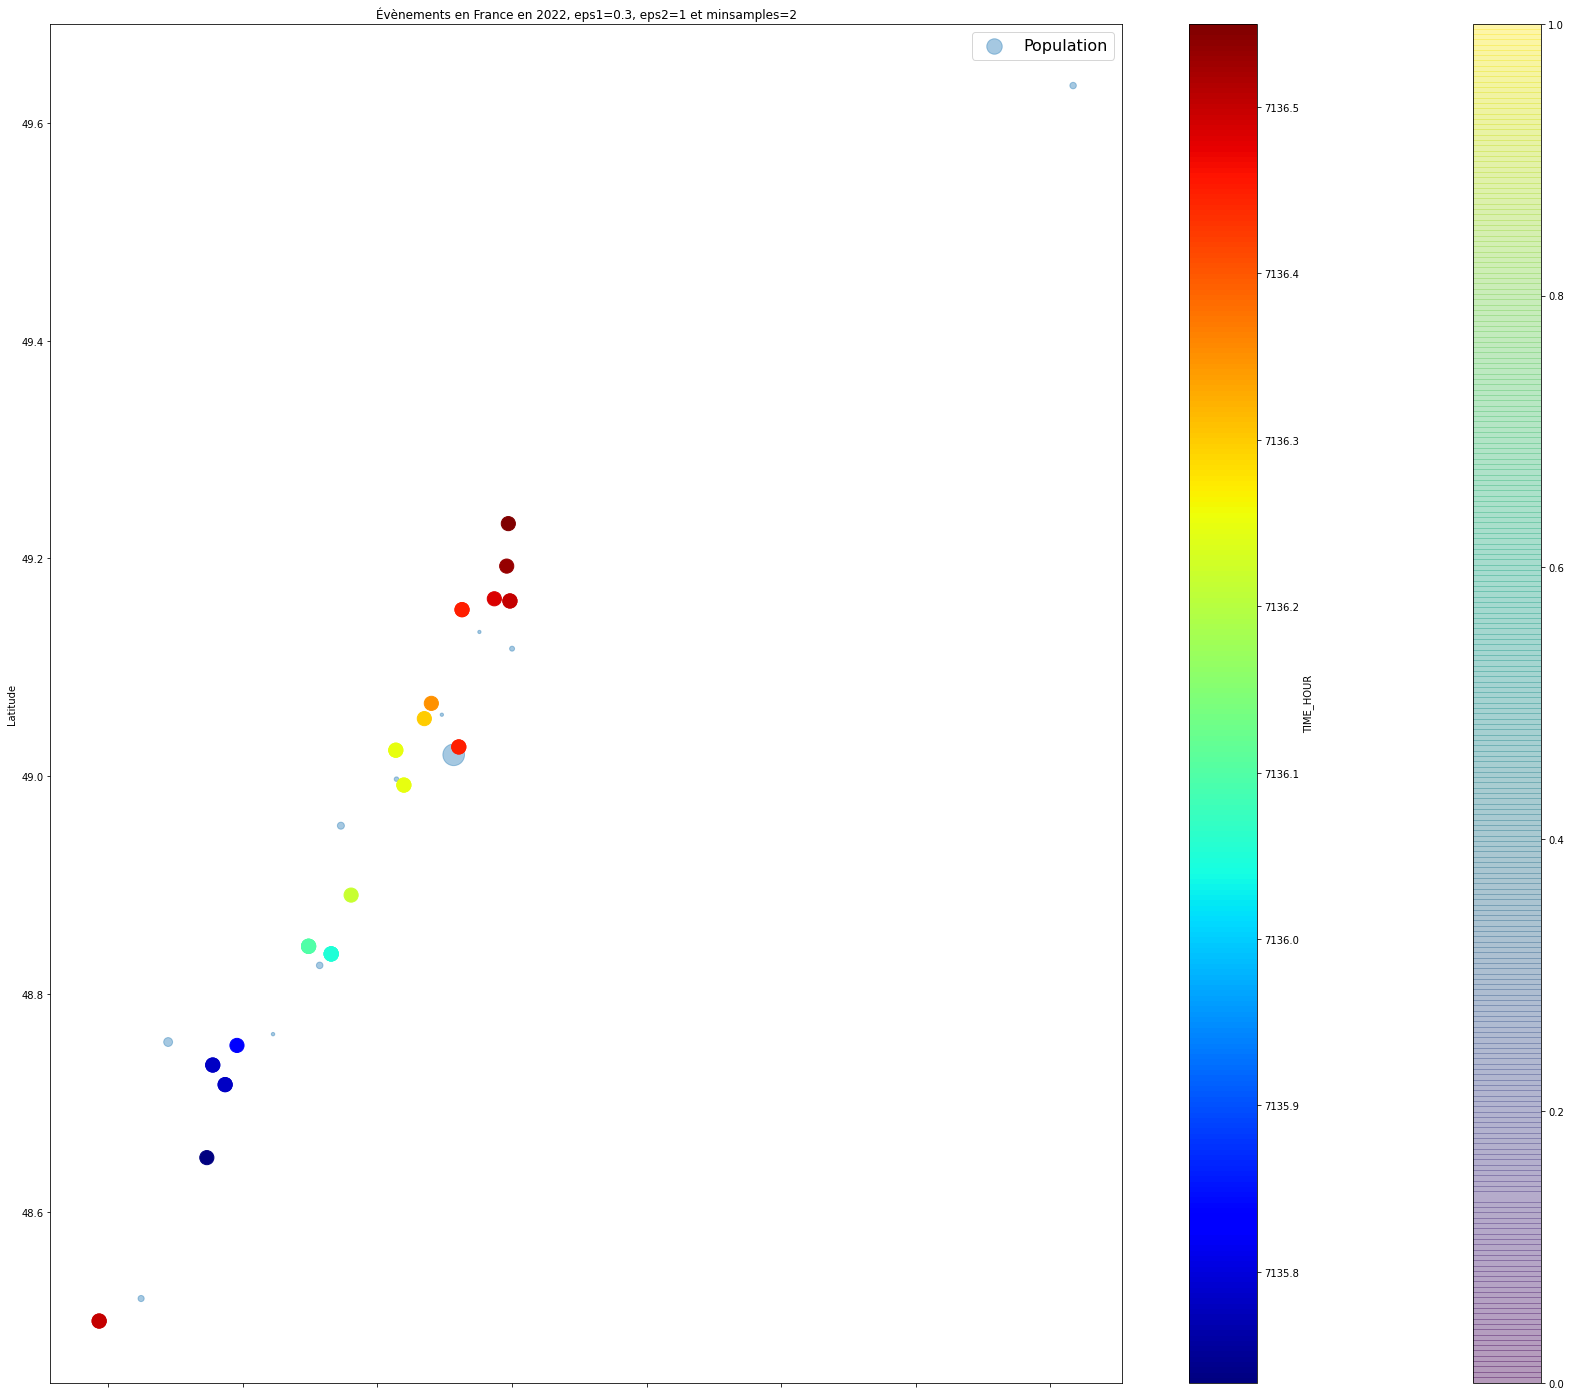

<ipython-input-37-4213b9b02d9f>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clst['TIME_HOUR']=df_clst.apply(lambda donnee: convert_hour(donnee), axis=1)


        TIME_HOUR  LATITUDE  LONGITUDE  cluster
classe                                         
14             18        18         18       18
82             18        18         18       18
126            18        18         18       18


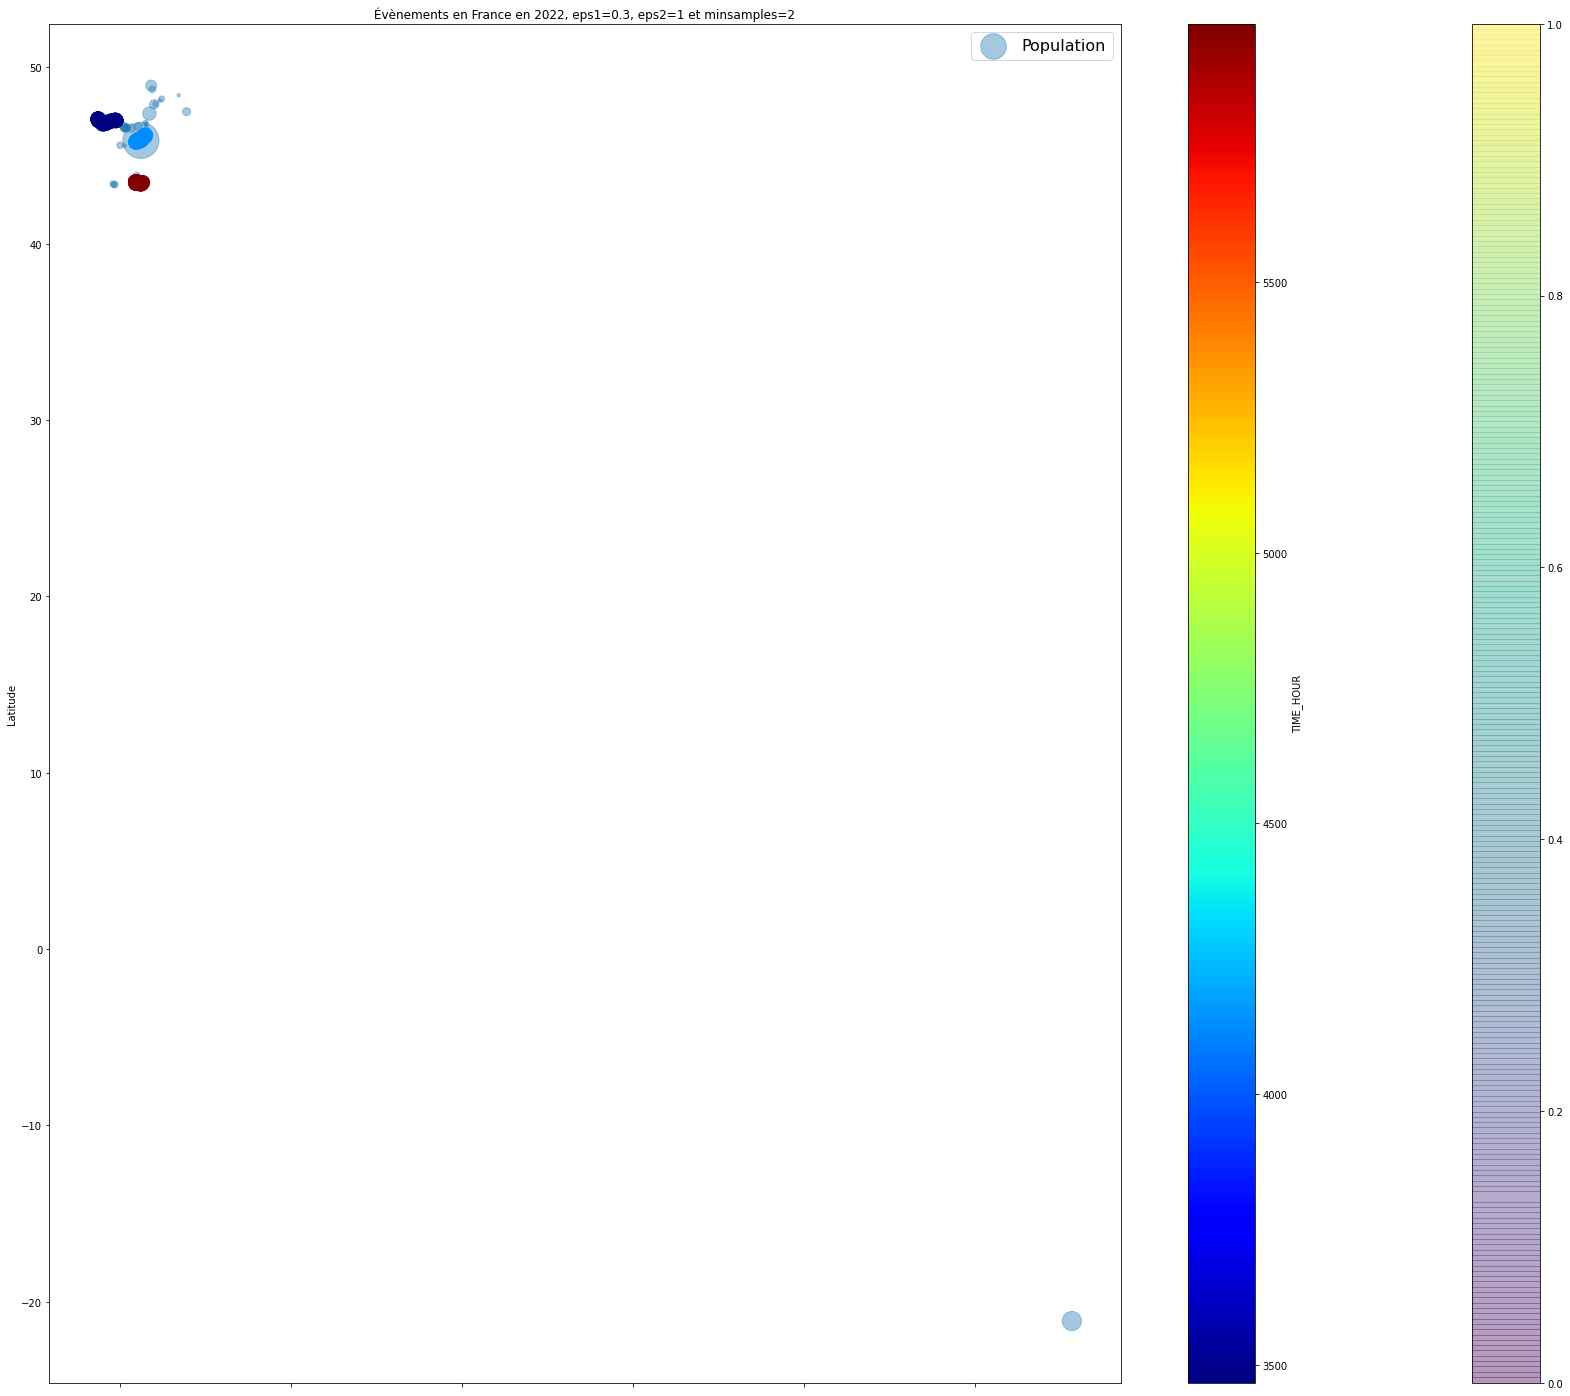

In [ ]:
for i in range(20):
  stdbscan_demog_fr4(2022,0.3, 1, 2,i)

In [99]:
 
def inertia_test(year, ep1, ep2, minpts):
    
    # extraction des données nécessaires 
    x='FR'
    df_clst=df[df['YEAR']==year]
    df_clst=df_clst[df_clst['COUNTRY']==x]
    
    #conversion de la date en heures
    df_clst['TIME_HOUR']=df_clst.apply(lambda donnee: convert_hour(donnee), axis=1)
    
    #bdd finale à utiliser
    df_clst=df_clst.loc[:,['TIME_HOUR','LATITUDE','LONGITUDE']]
    
    # application de st dbscan
    df_clst1=df_clst.copy()
    model = ST_DBSCAN(eps1=ep1, eps2=ep2,min_samples=minpts)
    model.fit(df_clst1)
    df_clst1["cluster"] = model.fit(df_clst)
    classi = model.labels
    
    # colonne contenant les labels
    df_clst1["classe"]=classi
        
    #on élimine les rapports contenus dans la classe déchets
    df_clst1=df_clst1[(df_clst1["classe"]>-1)]
    events= clust(df_clst1,classi)
    
    c=df_clst1['classe'].unique()
    c.sort()
    unclustered=[]
    indices=[]
    for i in range(len(c)):
        df_de=df_clst1[df_clst1['classe']==c[i]]
        df_de.sort_values(by=['LATITUDE'])
        l=[]
        for j in range(len(df_de)-2):
            if df_de.iloc[j,0]>df_de.iloc[j+1,0]:
              h=df_de[df_de['TIME_HOUR']==df_de.iloc[j+1,0]].index.values
              l.append(h[0])
              indices.append(h[0])
        unclustered.append(l)
    total_index=list(df_clst1.index.values)
    indices2=[]
    for e in total_index:
      if not e in indices:
        indices2.append(e)
    df_clst1=df_clst1.loc[indices2]

    #ploting
    geometry = [Point(xy) for xy in zip(df_clst1['LONGITUDE'], df_clst1['LATITUDE'])]
    gdf = GeoDataFrame(df_clst1, geometry=geometry)      
    ax = gdf.plot(figsize=(30,25), color="gray")

    df_clst1.plot.scatter(ax=ax, x = "LONGITUDE", y = "LATITUDE", c = "classe", cmap = "Accent")
    plt.title("Évènements en France en " + str(year) + ", eps1=" + str(ep1 ) + ", eps2=" + str(ep2 ) +" et minsamples=" +str(minpts ))
    plt.xlabel("Longitude")
    plt.ylabel("Latitude")
    plt.show()

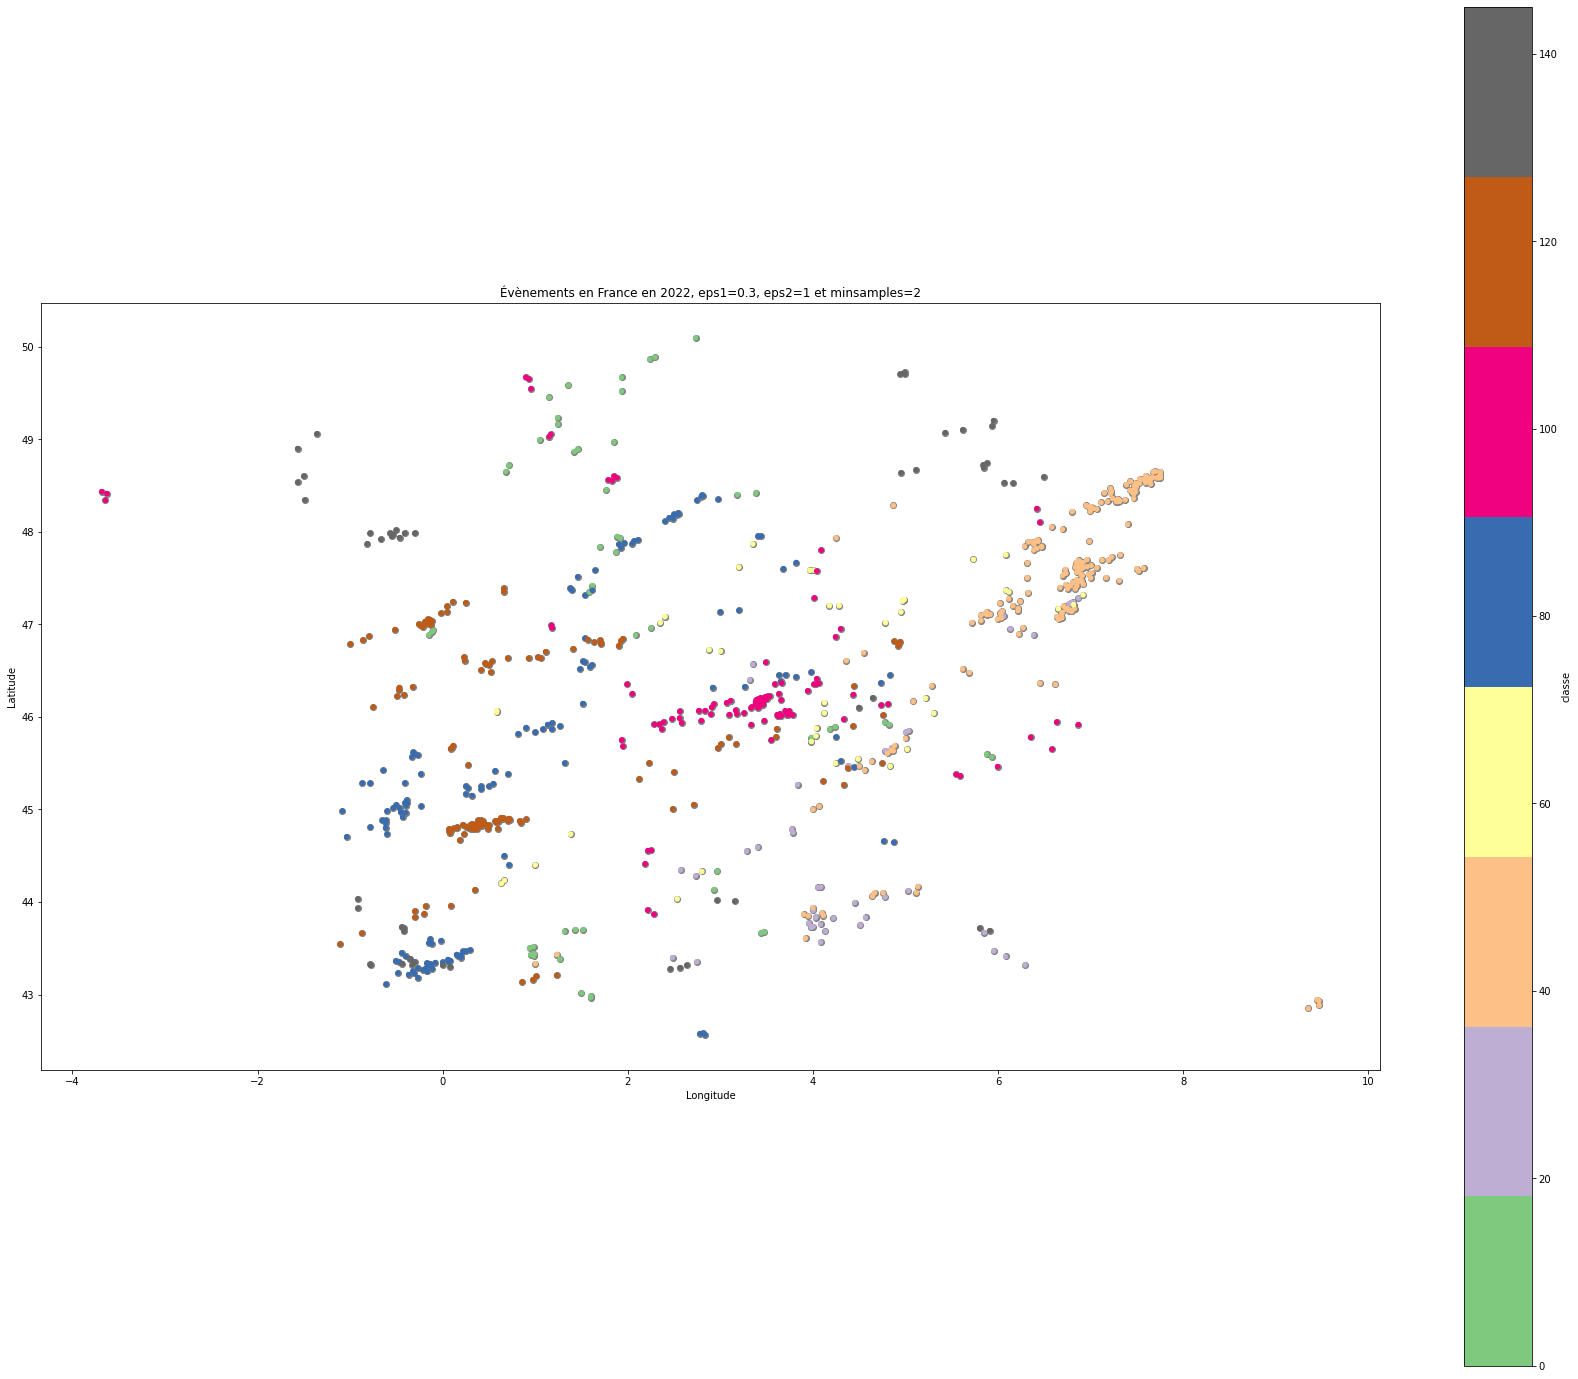

In [100]:
inertia_test(2022,0.3,1,2)